In [1]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torch.utils.data import DataLoader, TensorDataset

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [3]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

In [4]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [5]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [6]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

In [7]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [8]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [9]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

In [10]:
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [11]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    print(x_start.shape, noise.shape)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [12]:
# Load your saved data
train_data = torch.load("data/prepared_datasets/train_celeba.pt")
train_labels = torch.load("data/prepared_datasets/train_celeba_labels.pt")
val_data = torch.load("data/prepared_datasets/val_celeba.pt")
val_labels = torch.load("data/prepared_datasets/val_celeba_labels.pt")
test_data = torch.load("data/prepared_datasets/test_celeba.pt")
test_labels = torch.load("data/prepared_datasets/test_celeba_labels.pt")

In [13]:
train_data[0].shape

torch.Size([3, 64, 64])

In [14]:
train_data=train_data[:50000]
train_labels=train_labels[:50000]

In [15]:
batch_size = 128

In [16]:
def prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels, batch_size=batch_size):
    train_dataset = TensorDataset(train_data, train_labels)
    val_dataset = TensorDataset(val_data, val_labels)
    test_dataset = TensorDataset(test_data, test_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

In [17]:
# Normalize data to [0, 1] if not already done
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())

train_data = train_data * 2 - 1
val_data = val_data * 2 - 1
test_data = test_data * 2 - 1
# Create data loaders
train_loader, val_loader, test_loader = prepare_data_loaders(train_data, train_labels, val_data, val_labels, test_data, test_labels)

In [18]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
#def sample(model, image_size, batch_size=16, channels=3):
def sample(model, image_size, batch_size=32, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

In [19]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [20]:
from torch.optim import Adam
from torch.optim import AdamW

image_size = 64
channels = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

#optimizer = Adam(model.parameters(), lr=5e-3)
#optimizer = AdamW(model.parameters(), lr=5e-3)
optimizer = Adam(model.parameters(), lr=1e-3)

cuda


In [21]:
from torchvision.utils import save_image

epochs = 20
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
        data = data.to(device)
        optimizer.zero_grad()

        #batch_size = batch["pixel_values"].shape[0]
        #batch = batch["pixel_values"].to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        if data.shape[0] == batch_size:
            
            loss = p_losses(model, data, t, loss_type="huber")
            
            if batch_idx % 100 == 0:
                print("Loss:", loss.item())
            
            loss.backward()
            optimizer.step()
            
            # save generated images
            if batch_idx != 0 and batch_idx % save_and_sample_every == 0:
                milestone = batch_idx // save_and_sample_every
                batches = num_to_groups(4, batch_size)
                all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
                all_images = torch.cat(all_images_list, dim=0)
                all_images = (all_images + 1) * 0.5
                save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

Epoch 1/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.4754355847835541


Epoch 1/20:   0%|          | 1/391 [00:01<12:07,  1.86s/it]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   1%|          | 2/391 [00:02<06:40,  1.03s/it]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   1%|          | 3/391 [00:02<04:55,  1.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   1%|          | 4/391 [00:03<04:05,  1.57it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   1%|▏         | 5/391 [00:03<03:38,  1.77it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   2%|▏         | 6/391 [00:04<03:21,  1.91it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   2%|▏         | 7/391 [00:04<03:10,  2.02it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   2%|▏         | 8/391 [00:04<03:02,  2.09it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   2%|▏         | 9/391 [00:05<02:59,  2.12it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   3%|▎         | 10/391 [00:05<02:56,  2.16it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   3%|▎         | 11/391 [00:06<02:53,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   3%|▎         | 12/391 [00:06<02:51,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   3%|▎         | 13/391 [00:07<02:50,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   4%|▎         | 14/391 [00:07<02:49,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   4%|▍         | 15/391 [00:08<02:48,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   4%|▍         | 16/391 [00:08<02:48,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   4%|▍         | 17/391 [00:08<02:48,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   5%|▍         | 18/391 [00:09<02:47,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   5%|▍         | 19/391 [00:09<02:45,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   5%|▌         | 20/391 [00:10<02:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   5%|▌         | 21/391 [00:10<02:45,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   6%|▌         | 22/391 [00:11<02:44,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   6%|▌         | 23/391 [00:11<02:42,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   6%|▌         | 24/391 [00:12<02:42,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   6%|▋         | 25/391 [00:12<02:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   7%|▋         | 26/391 [00:12<02:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   7%|▋         | 27/391 [00:13<02:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   7%|▋         | 28/391 [00:13<02:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   7%|▋         | 29/391 [00:14<02:38,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   8%|▊         | 30/391 [00:14<02:37,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   8%|▊         | 31/391 [00:15<02:36,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   8%|▊         | 32/391 [00:15<02:35,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   8%|▊         | 33/391 [00:15<02:35,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   9%|▊         | 34/391 [00:16<02:34,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   9%|▉         | 35/391 [00:16<02:34,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   9%|▉         | 36/391 [00:17<02:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:   9%|▉         | 37/391 [00:17<02:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  10%|▉         | 38/391 [00:18<02:33,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  10%|▉         | 39/391 [00:18<02:33,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  10%|█         | 40/391 [00:19<02:32,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  10%|█         | 41/391 [00:19<02:31,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  11%|█         | 42/391 [00:19<02:31,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  11%|█         | 43/391 [00:20<02:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  11%|█▏        | 44/391 [00:20<02:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  12%|█▏        | 45/391 [00:21<02:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  12%|█▏        | 46/391 [00:21<02:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  12%|█▏        | 47/391 [00:22<02:32,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  12%|█▏        | 48/391 [00:22<02:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  13%|█▎        | 49/391 [00:23<02:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  13%|█▎        | 50/391 [00:23<02:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  13%|█▎        | 51/391 [00:23<02:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  13%|█▎        | 52/391 [00:24<02:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  14%|█▎        | 53/391 [00:24<02:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  14%|█▍        | 54/391 [00:25<02:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  14%|█▍        | 55/391 [00:25<02:27,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  14%|█▍        | 56/391 [00:26<02:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  15%|█▍        | 57/391 [00:26<02:26,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  15%|█▍        | 58/391 [00:26<02:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  15%|█▌        | 59/391 [00:27<02:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  15%|█▌        | 60/391 [00:27<02:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  16%|█▌        | 61/391 [00:28<02:23,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  16%|█▌        | 62/391 [00:28<02:23,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  16%|█▌        | 63/391 [00:29<02:22,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  16%|█▋        | 64/391 [00:29<02:22,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  17%|█▋        | 65/391 [00:29<02:21,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  17%|█▋        | 66/391 [00:30<02:21,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  17%|█▋        | 67/391 [00:30<02:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  17%|█▋        | 68/391 [00:31<02:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  18%|█▊        | 69/391 [00:31<02:20,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  18%|█▊        | 70/391 [00:32<02:19,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  18%|█▊        | 71/391 [00:32<02:18,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  18%|█▊        | 72/391 [00:33<02:18,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  19%|█▊        | 73/391 [00:33<02:17,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  19%|█▉        | 74/391 [00:33<02:17,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  19%|█▉        | 75/391 [00:34<02:17,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  19%|█▉        | 76/391 [00:34<02:16,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  20%|█▉        | 77/391 [00:35<02:16,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  20%|█▉        | 78/391 [00:35<02:15,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  20%|██        | 79/391 [00:36<02:15,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  20%|██        | 80/391 [00:36<02:14,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  21%|██        | 81/391 [00:36<02:14,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  21%|██        | 82/391 [00:37<02:14,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  21%|██        | 83/391 [00:37<02:13,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  21%|██▏       | 84/391 [00:38<02:12,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  22%|██▏       | 85/391 [00:38<02:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  22%|██▏       | 86/391 [00:39<02:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  22%|██▏       | 87/391 [00:39<02:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  23%|██▎       | 88/391 [00:40<02:13,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  23%|██▎       | 89/391 [00:40<02:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  23%|██▎       | 90/391 [00:40<02:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  23%|██▎       | 91/391 [00:41<02:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  24%|██▎       | 92/391 [00:41<02:11,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  24%|██▍       | 93/391 [00:42<02:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  24%|██▍       | 94/391 [00:42<02:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  24%|██▍       | 95/391 [00:43<02:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  25%|██▍       | 96/391 [00:43<02:09,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  25%|██▍       | 97/391 [00:43<02:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  25%|██▌       | 98/391 [00:44<02:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  25%|██▌       | 99/391 [00:44<02:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  26%|██▌       | 100/391 [00:45<02:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.4211002290248871


Epoch 1/20:  26%|██▌       | 101/391 [00:45<02:08,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  26%|██▌       | 102/391 [00:46<02:08,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  26%|██▋       | 103/391 [00:46<02:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  27%|██▋       | 104/391 [00:47<02:07,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  27%|██▋       | 105/391 [00:47<02:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  27%|██▋       | 106/391 [00:47<02:06,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  27%|██▋       | 107/391 [00:48<02:06,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  28%|██▊       | 108/391 [00:48<02:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  28%|██▊       | 109/391 [00:49<02:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  28%|██▊       | 110/391 [00:49<02:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  28%|██▊       | 111/391 [00:50<02:02,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  29%|██▊       | 112/391 [00:50<02:01,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  29%|██▉       | 113/391 [00:51<02:01,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  29%|██▉       | 114/391 [00:51<02:00,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  29%|██▉       | 115/391 [00:51<02:00,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  30%|██▉       | 116/391 [00:52<01:59,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  30%|██▉       | 117/391 [00:52<01:59,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  30%|███       | 118/391 [00:53<01:59,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  30%|███       | 119/391 [00:53<01:58,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  31%|███       | 120/391 [00:54<01:58,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  31%|███       | 121/391 [00:54<01:57,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  31%|███       | 122/391 [00:54<01:57,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  31%|███▏      | 123/391 [00:55<01:57,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  32%|███▏      | 124/391 [00:55<01:56,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  32%|███▏      | 125/391 [00:56<01:55,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  32%|███▏      | 126/391 [00:56<01:54,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  32%|███▏      | 127/391 [00:57<01:54,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  33%|███▎      | 128/391 [00:57<01:53,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  33%|███▎      | 129/391 [00:57<01:53,  2.32it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  33%|███▎      | 130/391 [00:58<01:53,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  34%|███▎      | 131/391 [00:58<01:52,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  34%|███▍      | 132/391 [00:59<01:52,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  34%|███▍      | 133/391 [00:59<01:52,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  34%|███▍      | 134/391 [01:00<01:52,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  35%|███▍      | 135/391 [01:00<01:51,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  35%|███▍      | 136/391 [01:01<01:51,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  35%|███▌      | 137/391 [01:01<01:51,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  35%|███▌      | 138/391 [01:01<01:50,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  36%|███▌      | 139/391 [01:02<01:49,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  36%|███▌      | 140/391 [01:02<01:49,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  36%|███▌      | 141/391 [01:03<01:48,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  36%|███▋      | 142/391 [01:03<01:48,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  37%|███▋      | 143/391 [01:04<01:48,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  37%|███▋      | 144/391 [01:04<01:47,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  37%|███▋      | 145/391 [01:04<01:46,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  37%|███▋      | 146/391 [01:05<01:46,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  38%|███▊      | 147/391 [01:05<01:45,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  38%|███▊      | 148/391 [01:06<01:45,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  38%|███▊      | 149/391 [01:06<01:44,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  38%|███▊      | 150/391 [01:07<01:44,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  39%|███▊      | 151/391 [01:07<01:44,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  39%|███▉      | 152/391 [01:08<01:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  39%|███▉      | 153/391 [01:08<01:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  39%|███▉      | 154/391 [01:08<01:43,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  40%|███▉      | 155/391 [01:09<01:43,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  40%|███▉      | 156/391 [01:09<01:42,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  40%|████      | 157/391 [01:10<01:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  40%|████      | 158/391 [01:10<01:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  41%|████      | 159/391 [01:11<01:43,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  41%|████      | 160/391 [01:11<01:42,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  41%|████      | 161/391 [01:11<01:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  41%|████▏     | 162/391 [01:12<01:40,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  42%|████▏     | 163/391 [01:12<01:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  42%|████▏     | 164/391 [01:13<01:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  42%|████▏     | 165/391 [01:13<01:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  42%|████▏     | 166/391 [01:14<01:39,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  43%|████▎     | 167/391 [01:14<01:39,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  43%|████▎     | 168/391 [01:15<01:39,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  43%|████▎     | 169/391 [01:15<01:38,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  43%|████▎     | 170/391 [01:15<01:38,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  44%|████▎     | 171/391 [01:16<01:38,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  44%|████▍     | 172/391 [01:16<01:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  44%|████▍     | 173/391 [01:17<01:37,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  45%|████▍     | 174/391 [01:17<01:36,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  45%|████▍     | 175/391 [01:18<01:36,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  45%|████▌     | 176/391 [01:18<01:35,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  45%|████▌     | 177/391 [01:19<01:35,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  46%|████▌     | 178/391 [01:19<01:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  46%|████▌     | 179/391 [01:19<01:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  46%|████▌     | 180/391 [01:20<01:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  46%|████▋     | 181/391 [01:20<01:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  47%|████▋     | 182/391 [01:21<01:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  47%|████▋     | 183/391 [01:21<01:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  47%|████▋     | 184/391 [01:22<01:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  47%|████▋     | 185/391 [01:22<01:29,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  48%|████▊     | 186/391 [01:23<01:29,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  48%|████▊     | 187/391 [01:23<01:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  48%|████▊     | 188/391 [01:23<01:30,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  48%|████▊     | 189/391 [01:24<01:30,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  49%|████▊     | 190/391 [01:24<01:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  49%|████▉     | 191/391 [01:25<01:29,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  49%|████▉     | 192/391 [01:25<01:29,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  49%|████▉     | 193/391 [01:26<01:28,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  50%|████▉     | 194/391 [01:26<01:28,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  50%|████▉     | 195/391 [01:27<01:28,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  50%|█████     | 196/391 [01:27<01:28,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  50%|█████     | 197/391 [01:28<01:28,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  51%|█████     | 198/391 [01:28<01:27,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  51%|█████     | 199/391 [01:28<01:27,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  51%|█████     | 200/391 [01:29<01:26,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.2116357982158661


Epoch 1/20:  51%|█████▏    | 201/391 [01:29<01:25,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  52%|█████▏    | 202/391 [01:30<01:25,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  52%|█████▏    | 203/391 [01:30<01:25,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  52%|█████▏    | 204/391 [01:31<01:26,  2.17it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  52%|█████▏    | 205/391 [01:31<01:25,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  53%|█████▎    | 206/391 [01:32<01:24,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  53%|█████▎    | 207/391 [01:32<01:24,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  53%|█████▎    | 208/391 [01:33<01:23,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  53%|█████▎    | 209/391 [01:33<01:22,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  54%|█████▎    | 210/391 [01:33<01:21,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  54%|█████▍    | 211/391 [01:34<01:20,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  54%|█████▍    | 212/391 [01:34<01:21,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  54%|█████▍    | 213/391 [01:35<01:21,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  55%|█████▍    | 214/391 [01:35<01:21,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  55%|█████▍    | 215/391 [01:36<01:21,  2.16it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  55%|█████▌    | 216/391 [01:36<01:20,  2.17it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  55%|█████▌    | 217/391 [01:37<01:19,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  56%|█████▌    | 218/391 [01:37<01:18,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  56%|█████▌    | 219/391 [01:38<01:17,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  56%|█████▋    | 220/391 [01:38<01:17,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  57%|█████▋    | 221/391 [01:38<01:18,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  57%|█████▋    | 222/391 [01:39<01:17,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  57%|█████▋    | 223/391 [01:39<01:16,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  57%|█████▋    | 224/391 [01:40<01:15,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  58%|█████▊    | 225/391 [01:40<01:14,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  58%|█████▊    | 226/391 [01:41<01:14,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  58%|█████▊    | 227/391 [01:41<01:13,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  58%|█████▊    | 228/391 [01:42<01:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  59%|█████▊    | 229/391 [01:42<01:11,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  59%|█████▉    | 230/391 [01:42<01:11,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  59%|█████▉    | 231/391 [01:43<01:11,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  59%|█████▉    | 232/391 [01:43<01:10,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  60%|█████▉    | 233/391 [01:44<01:10,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  60%|█████▉    | 234/391 [01:44<01:10,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  60%|██████    | 235/391 [01:45<01:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  60%|██████    | 236/391 [01:45<01:09,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  61%|██████    | 237/391 [01:46<01:08,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  61%|██████    | 238/391 [01:46<01:08,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  61%|██████    | 239/391 [01:46<01:07,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  61%|██████▏   | 240/391 [01:47<01:07,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  62%|██████▏   | 241/391 [01:47<01:07,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  62%|██████▏   | 242/391 [01:48<01:06,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  62%|██████▏   | 243/391 [01:48<01:05,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  62%|██████▏   | 244/391 [01:49<01:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  63%|██████▎   | 245/391 [01:49<01:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  63%|██████▎   | 246/391 [01:50<01:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  63%|██████▎   | 247/391 [01:50<01:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  63%|██████▎   | 248/391 [01:50<01:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  64%|██████▎   | 249/391 [01:51<01:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  64%|██████▍   | 250/391 [01:51<01:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  64%|██████▍   | 251/391 [01:52<01:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  64%|██████▍   | 252/391 [01:52<01:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  65%|██████▍   | 253/391 [01:53<01:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  65%|██████▍   | 254/391 [01:53<01:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  65%|██████▌   | 255/391 [01:54<01:00,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  65%|██████▌   | 256/391 [01:54<00:59,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  66%|██████▌   | 257/391 [01:54<00:59,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  66%|██████▌   | 258/391 [01:55<00:59,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  66%|██████▌   | 259/391 [01:55<00:58,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  66%|██████▋   | 260/391 [01:56<00:58,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  67%|██████▋   | 261/391 [01:56<00:57,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  67%|██████▋   | 262/391 [01:57<00:57,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  67%|██████▋   | 263/391 [01:57<00:57,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  68%|██████▊   | 264/391 [01:58<00:57,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  68%|██████▊   | 265/391 [01:58<00:56,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  68%|██████▊   | 266/391 [01:58<00:56,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  68%|██████▊   | 267/391 [01:59<00:55,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  69%|██████▊   | 268/391 [01:59<00:54,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  69%|██████▉   | 269/391 [02:00<00:54,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  69%|██████▉   | 270/391 [02:00<00:54,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  69%|██████▉   | 271/391 [02:01<00:53,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  70%|██████▉   | 272/391 [02:01<00:53,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  70%|██████▉   | 273/391 [02:02<00:52,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  70%|███████   | 274/391 [02:02<00:52,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  70%|███████   | 275/391 [02:02<00:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  71%|███████   | 276/391 [02:03<00:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  71%|███████   | 277/391 [02:03<00:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  71%|███████   | 278/391 [02:04<00:50,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  71%|███████▏  | 279/391 [02:04<00:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  72%|███████▏  | 280/391 [02:05<00:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  72%|███████▏  | 281/391 [02:05<00:48,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  72%|███████▏  | 282/391 [02:06<00:48,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  72%|███████▏  | 283/391 [02:06<00:48,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  73%|███████▎  | 284/391 [02:07<00:47,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  73%|███████▎  | 285/391 [02:07<00:47,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  73%|███████▎  | 286/391 [02:07<00:47,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  73%|███████▎  | 287/391 [02:08<00:47,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  74%|███████▎  | 288/391 [02:08<00:46,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  74%|███████▍  | 289/391 [02:09<00:46,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  74%|███████▍  | 290/391 [02:09<00:45,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  74%|███████▍  | 291/391 [02:10<00:45,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  75%|███████▍  | 292/391 [02:10<00:45,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  75%|███████▍  | 293/391 [02:11<00:44,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  75%|███████▌  | 294/391 [02:11<00:44,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  75%|███████▌  | 295/391 [02:12<00:43,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  76%|███████▌  | 296/391 [02:12<00:42,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  76%|███████▌  | 297/391 [02:12<00:42,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  76%|███████▌  | 298/391 [02:13<00:42,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  76%|███████▋  | 299/391 [02:13<00:41,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  77%|███████▋  | 300/391 [02:14<00:41,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.052133709192276


Epoch 1/20:  77%|███████▋  | 301/391 [02:14<00:40,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  77%|███████▋  | 302/391 [02:15<00:40,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  77%|███████▋  | 303/391 [02:15<00:39,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  78%|███████▊  | 304/391 [02:16<00:39,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  78%|███████▊  | 305/391 [02:16<00:38,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  78%|███████▊  | 306/391 [02:16<00:38,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  79%|███████▊  | 307/391 [02:17<00:37,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  79%|███████▉  | 308/391 [02:17<00:37,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  79%|███████▉  | 309/391 [02:18<00:36,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  79%|███████▉  | 310/391 [02:18<00:36,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  80%|███████▉  | 311/391 [02:19<00:35,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  80%|███████▉  | 312/391 [02:19<00:35,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  80%|████████  | 313/391 [02:20<00:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  80%|████████  | 314/391 [02:20<00:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  81%|████████  | 315/391 [02:20<00:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  81%|████████  | 316/391 [02:21<00:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  81%|████████  | 317/391 [02:21<00:32,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  81%|████████▏ | 318/391 [02:22<00:32,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  82%|████████▏ | 319/391 [02:22<00:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  82%|████████▏ | 320/391 [02:23<00:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  82%|████████▏ | 321/391 [02:23<00:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  82%|████████▏ | 322/391 [02:24<00:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  83%|████████▎ | 323/391 [02:24<00:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  83%|████████▎ | 324/391 [02:24<00:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  83%|████████▎ | 325/391 [02:25<00:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  83%|████████▎ | 326/391 [02:25<00:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  84%|████████▎ | 327/391 [02:26<00:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  84%|████████▍ | 328/391 [02:26<00:28,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  84%|████████▍ | 329/391 [02:27<00:27,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  84%|████████▍ | 330/391 [02:27<00:27,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  85%|████████▍ | 331/391 [02:28<00:26,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  85%|████████▍ | 332/391 [02:28<00:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  85%|████████▌ | 333/391 [02:28<00:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  85%|████████▌ | 334/391 [02:29<00:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  86%|████████▌ | 335/391 [02:29<00:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  86%|████████▌ | 336/391 [02:30<00:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  86%|████████▌ | 337/391 [02:30<00:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  86%|████████▋ | 338/391 [02:31<00:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  87%|████████▋ | 339/391 [02:31<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  87%|████████▋ | 340/391 [02:32<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  87%|████████▋ | 341/391 [02:32<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  87%|████████▋ | 342/391 [02:32<00:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  88%|████████▊ | 343/391 [02:33<00:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  88%|████████▊ | 344/391 [02:33<00:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  88%|████████▊ | 345/391 [02:34<00:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  88%|████████▊ | 346/391 [02:34<00:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  89%|████████▊ | 347/391 [02:35<00:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  89%|████████▉ | 348/391 [02:35<00:19,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  89%|████████▉ | 349/391 [02:36<00:18,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  90%|████████▉ | 350/391 [02:36<00:18,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  90%|████████▉ | 351/391 [02:36<00:18,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  90%|█████████ | 352/391 [02:37<00:17,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  90%|█████████ | 353/391 [02:37<00:17,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  91%|█████████ | 354/391 [02:38<00:16,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  91%|█████████ | 355/391 [02:38<00:16,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  91%|█████████ | 356/391 [02:39<00:15,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  91%|█████████▏| 357/391 [02:39<00:15,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  92%|█████████▏| 358/391 [02:40<00:14,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  92%|█████████▏| 359/391 [02:40<00:14,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  92%|█████████▏| 360/391 [02:40<00:13,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  92%|█████████▏| 361/391 [02:41<00:13,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  93%|█████████▎| 362/391 [02:41<00:13,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  93%|█████████▎| 363/391 [02:42<00:12,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  93%|█████████▎| 364/391 [02:42<00:12,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  93%|█████████▎| 365/391 [02:43<00:11,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  94%|█████████▎| 366/391 [02:43<00:11,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  94%|█████████▍| 367/391 [02:44<00:10,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  94%|█████████▍| 368/391 [02:44<00:10,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  94%|█████████▍| 369/391 [02:44<00:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  95%|█████████▍| 370/391 [02:45<00:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  95%|█████████▍| 371/391 [02:45<00:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  95%|█████████▌| 372/391 [02:46<00:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  95%|█████████▌| 373/391 [02:46<00:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  96%|█████████▌| 374/391 [02:47<00:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  96%|█████████▌| 375/391 [02:47<00:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  96%|█████████▌| 376/391 [02:48<00:06,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  96%|█████████▋| 377/391 [02:48<00:06,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  97%|█████████▋| 378/391 [02:48<00:05,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  97%|█████████▋| 379/391 [02:49<00:05,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  97%|█████████▋| 380/391 [02:49<00:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  97%|█████████▋| 381/391 [02:50<00:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  98%|█████████▊| 382/391 [02:50<00:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  98%|█████████▊| 383/391 [02:51<00:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  98%|█████████▊| 384/391 [02:51<00:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  98%|█████████▊| 385/391 [02:52<00:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  99%|█████████▊| 386/391 [02:52<00:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  99%|█████████▉| 387/391 [02:52<00:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  99%|█████████▉| 388/391 [02:53<00:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 1/20:  99%|█████████▉| 389/391 [02:53<00:00,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.05417558550834656


Epoch 2/20:   0%|          | 1/391 [00:00<02:55,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   1%|          | 2/391 [00:00<02:56,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   1%|          | 3/391 [00:01<02:53,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   1%|          | 4/391 [00:01<02:52,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   1%|▏         | 5/391 [00:02<02:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   2%|▏         | 6/391 [00:02<02:51,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   2%|▏         | 7/391 [00:03<02:51,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   2%|▏         | 8/391 [00:03<02:51,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   2%|▏         | 9/391 [00:04<02:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   3%|▎         | 10/391 [00:04<02:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   3%|▎         | 11/391 [00:04<02:48,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   3%|▎         | 12/391 [00:05<02:48,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   3%|▎         | 13/391 [00:05<02:48,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   4%|▎         | 14/391 [00:06<02:47,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   4%|▍         | 15/391 [00:06<02:47,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   4%|▍         | 16/391 [00:07<02:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   4%|▍         | 17/391 [00:07<02:47,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   5%|▍         | 18/391 [00:08<02:47,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   5%|▍         | 19/391 [00:08<02:46,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   5%|▌         | 20/391 [00:08<02:46,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   5%|▌         | 21/391 [00:09<02:47,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   6%|▌         | 22/391 [00:09<02:46,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   6%|▌         | 23/391 [00:10<02:45,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   6%|▌         | 24/391 [00:10<02:44,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   6%|▋         | 25/391 [00:11<02:43,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   7%|▋         | 26/391 [00:11<02:42,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   7%|▋         | 27/391 [00:12<02:41,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   7%|▋         | 28/391 [00:12<02:41,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   7%|▋         | 29/391 [00:12<02:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   8%|▊         | 30/391 [00:13<02:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   8%|▊         | 31/391 [00:13<02:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   8%|▊         | 32/391 [00:14<02:39,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   8%|▊         | 33/391 [00:14<02:38,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   9%|▊         | 34/391 [00:15<02:38,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   9%|▉         | 35/391 [00:15<02:38,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   9%|▉         | 36/391 [00:16<02:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:   9%|▉         | 37/391 [00:16<02:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  10%|▉         | 38/391 [00:16<02:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  10%|▉         | 39/391 [00:17<02:37,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  10%|█         | 40/391 [00:17<02:36,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  10%|█         | 41/391 [00:18<02:36,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  11%|█         | 42/391 [00:18<02:37,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  11%|█         | 43/391 [00:19<02:36,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  11%|█▏        | 44/391 [00:19<02:37,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  12%|█▏        | 45/391 [00:20<02:36,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  12%|█▏        | 46/391 [00:20<02:35,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  12%|█▏        | 47/391 [00:20<02:34,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  12%|█▏        | 48/391 [00:21<02:34,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  13%|█▎        | 49/391 [00:21<02:35,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  13%|█▎        | 50/391 [00:22<02:32,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  13%|█▎        | 51/391 [00:22<02:31,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  13%|█▎        | 52/391 [00:23<02:31,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  14%|█▎        | 53/391 [00:23<02:31,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  14%|█▍        | 54/391 [00:24<02:30,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  14%|█▍        | 55/391 [00:24<02:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  14%|█▍        | 56/391 [00:25<02:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  15%|█▍        | 57/391 [00:25<02:27,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  15%|█▍        | 58/391 [00:25<02:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  15%|█▌        | 59/391 [00:26<02:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  15%|█▌        | 60/391 [00:26<02:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  16%|█▌        | 61/391 [00:27<02:24,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  16%|█▌        | 62/391 [00:27<02:24,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  16%|█▌        | 63/391 [00:28<02:24,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  16%|█▋        | 64/391 [00:28<02:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  17%|█▋        | 65/391 [00:28<02:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  17%|█▋        | 66/391 [00:29<02:22,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  17%|█▋        | 67/391 [00:29<02:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  17%|█▋        | 68/391 [00:30<02:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  18%|█▊        | 69/391 [00:30<02:22,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  18%|█▊        | 70/391 [00:31<02:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  18%|█▊        | 71/391 [00:31<02:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  18%|█▊        | 72/391 [00:32<02:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  19%|█▊        | 73/391 [00:32<02:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  19%|█▉        | 74/391 [00:32<02:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  19%|█▉        | 75/391 [00:33<02:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  19%|█▉        | 76/391 [00:33<02:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  20%|█▉        | 77/391 [00:34<02:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  20%|█▉        | 78/391 [00:34<02:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  20%|██        | 79/391 [00:35<02:18,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  20%|██        | 80/391 [00:35<02:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  21%|██        | 81/391 [00:36<02:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  21%|██        | 82/391 [00:36<02:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  21%|██        | 83/391 [00:36<02:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  21%|██▏       | 84/391 [00:37<02:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  22%|██▏       | 85/391 [00:37<02:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  22%|██▏       | 86/391 [00:38<02:13,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  22%|██▏       | 87/391 [00:38<02:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  23%|██▎       | 88/391 [00:39<02:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  23%|██▎       | 89/391 [00:39<02:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  23%|██▎       | 90/391 [00:39<02:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  23%|██▎       | 91/391 [00:40<02:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  24%|██▎       | 92/391 [00:40<02:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  24%|██▍       | 93/391 [00:41<02:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  24%|██▍       | 94/391 [00:41<02:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  24%|██▍       | 95/391 [00:42<02:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  25%|██▍       | 96/391 [00:42<02:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  25%|██▍       | 97/391 [00:43<02:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  25%|██▌       | 98/391 [00:43<02:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  25%|██▌       | 99/391 [00:43<02:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  26%|██▌       | 100/391 [00:44<02:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.054953187704086304


Epoch 2/20:  26%|██▌       | 101/391 [00:44<02:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  26%|██▌       | 102/391 [00:45<02:08,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  26%|██▋       | 103/391 [00:45<02:09,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  27%|██▋       | 104/391 [00:46<02:09,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  27%|██▋       | 105/391 [00:46<02:08,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  27%|██▋       | 106/391 [00:47<02:09,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  27%|██▋       | 107/391 [00:47<02:08,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  28%|██▊       | 108/391 [00:48<02:06,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  28%|██▊       | 109/391 [00:48<02:06,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  28%|██▊       | 110/391 [00:48<02:05,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  28%|██▊       | 111/391 [00:49<02:05,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  29%|██▊       | 112/391 [00:49<02:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  29%|██▉       | 113/391 [00:50<02:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  29%|██▉       | 114/391 [00:50<02:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  29%|██▉       | 115/391 [00:51<02:03,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  30%|██▉       | 116/391 [00:51<02:03,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  30%|██▉       | 117/391 [00:52<02:03,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  30%|███       | 118/391 [00:52<02:02,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  30%|███       | 119/391 [00:52<02:01,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  31%|███       | 120/391 [00:53<02:00,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  31%|███       | 121/391 [00:53<02:01,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  31%|███       | 122/391 [00:54<02:01,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  31%|███▏      | 123/391 [00:54<02:00,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  32%|███▏      | 124/391 [00:55<02:00,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  32%|███▏      | 125/391 [00:55<02:00,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  32%|███▏      | 126/391 [00:56<01:59,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  32%|███▏      | 127/391 [00:56<01:59,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  33%|███▎      | 128/391 [00:57<01:58,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  33%|███▎      | 129/391 [00:57<01:58,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  33%|███▎      | 130/391 [00:57<01:57,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  34%|███▎      | 131/391 [00:58<01:57,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  34%|███▍      | 132/391 [00:58<01:57,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  34%|███▍      | 133/391 [00:59<01:57,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  34%|███▍      | 134/391 [00:59<01:56,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  35%|███▍      | 135/391 [01:00<01:55,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  35%|███▍      | 136/391 [01:00<01:55,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  35%|███▌      | 137/391 [01:01<01:54,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  35%|███▌      | 138/391 [01:01<01:55,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  36%|███▌      | 139/391 [01:01<01:54,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  36%|███▌      | 140/391 [01:02<01:54,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  36%|███▌      | 141/391 [01:02<01:53,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  36%|███▋      | 142/391 [01:03<01:52,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  37%|███▋      | 143/391 [01:03<01:51,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  37%|███▋      | 144/391 [01:04<01:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  37%|███▋      | 145/391 [01:04<01:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  37%|███▋      | 146/391 [01:05<01:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  38%|███▊      | 147/391 [01:05<01:47,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  38%|███▊      | 148/391 [01:05<01:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  38%|███▊      | 149/391 [01:06<01:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  38%|███▊      | 150/391 [01:06<01:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  39%|███▊      | 151/391 [01:07<01:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  39%|███▉      | 152/391 [01:07<01:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  39%|███▉      | 153/391 [01:08<01:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  39%|███▉      | 154/391 [01:08<01:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  40%|███▉      | 155/391 [01:09<01:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  40%|███▉      | 156/391 [01:09<01:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  40%|████      | 157/391 [01:09<01:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  40%|████      | 158/391 [01:10<01:41,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  41%|████      | 159/391 [01:10<01:41,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  41%|████      | 160/391 [01:11<01:40,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  41%|████      | 161/391 [01:11<01:40,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  41%|████▏     | 162/391 [01:12<01:39,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  42%|████▏     | 163/391 [01:12<01:38,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  42%|████▏     | 164/391 [01:12<01:38,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  42%|████▏     | 165/391 [01:13<01:38,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  42%|████▏     | 166/391 [01:13<01:37,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  43%|████▎     | 167/391 [01:14<01:36,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  43%|████▎     | 168/391 [01:14<01:36,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  43%|████▎     | 169/391 [01:15<01:36,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  43%|████▎     | 170/391 [01:15<01:36,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  44%|████▎     | 171/391 [01:16<01:35,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  44%|████▍     | 172/391 [01:16<01:34,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  44%|████▍     | 173/391 [01:16<01:34,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  45%|████▍     | 174/391 [01:17<01:34,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  45%|████▍     | 175/391 [01:17<01:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  45%|████▌     | 176/391 [01:18<01:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  45%|████▌     | 177/391 [01:18<01:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  46%|████▌     | 178/391 [01:19<01:32,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  46%|████▌     | 179/391 [01:19<01:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  46%|████▌     | 180/391 [01:19<01:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  46%|████▋     | 181/391 [01:20<01:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  47%|████▋     | 182/391 [01:20<01:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  47%|████▋     | 183/391 [01:21<01:31,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  47%|████▋     | 184/391 [01:21<01:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  47%|████▋     | 185/391 [01:22<01:29,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  48%|████▊     | 186/391 [01:22<01:29,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  48%|████▊     | 187/391 [01:23<01:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  48%|████▊     | 188/391 [01:23<01:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  48%|████▊     | 189/391 [01:23<01:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  49%|████▊     | 190/391 [01:24<01:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  49%|████▉     | 191/391 [01:24<01:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  49%|████▉     | 192/391 [01:25<01:26,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  49%|████▉     | 193/391 [01:25<01:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  50%|████▉     | 194/391 [01:26<01:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  50%|████▉     | 195/391 [01:26<01:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  50%|█████     | 196/391 [01:26<01:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  50%|█████     | 197/391 [01:27<01:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  51%|█████     | 198/391 [01:27<01:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  51%|█████     | 199/391 [01:28<01:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  51%|█████     | 200/391 [01:28<01:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.03557507321238518


Epoch 2/20:  51%|█████▏    | 201/391 [01:29<01:22,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  52%|█████▏    | 202/391 [01:29<01:22,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  52%|█████▏    | 203/391 [01:29<01:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  52%|█████▏    | 204/391 [01:30<01:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  52%|█████▏    | 205/391 [01:30<01:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  53%|█████▎    | 206/391 [01:31<01:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  53%|█████▎    | 207/391 [01:31<01:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  53%|█████▎    | 208/391 [01:32<01:19,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  53%|█████▎    | 209/391 [01:32<01:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  54%|█████▎    | 210/391 [01:33<01:19,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  54%|█████▍    | 211/391 [01:33<01:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  54%|█████▍    | 212/391 [01:33<01:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  54%|█████▍    | 213/391 [01:34<01:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  55%|█████▍    | 214/391 [01:34<01:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  55%|█████▍    | 215/391 [01:35<01:16,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  55%|█████▌    | 216/391 [01:35<01:16,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  55%|█████▌    | 217/391 [01:36<01:15,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  56%|█████▌    | 218/391 [01:36<01:15,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  56%|█████▌    | 219/391 [01:36<01:14,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  56%|█████▋    | 220/391 [01:37<01:14,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  57%|█████▋    | 221/391 [01:37<01:14,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  57%|█████▋    | 222/391 [01:38<01:13,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  57%|█████▋    | 223/391 [01:38<01:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  57%|█████▋    | 224/391 [01:39<01:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  58%|█████▊    | 225/391 [01:39<01:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  58%|█████▊    | 226/391 [01:40<01:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  58%|█████▊    | 227/391 [01:40<01:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  58%|█████▊    | 228/391 [01:40<01:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  59%|█████▊    | 229/391 [01:41<01:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  59%|█████▉    | 230/391 [01:41<01:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  59%|█████▉    | 231/391 [01:42<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  59%|█████▉    | 232/391 [01:42<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  60%|█████▉    | 233/391 [01:43<01:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  60%|█████▉    | 234/391 [01:43<01:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  60%|██████    | 235/391 [01:44<01:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  60%|██████    | 236/391 [01:44<01:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  61%|██████    | 237/391 [01:44<01:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  61%|██████    | 238/391 [01:45<01:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  61%|██████    | 239/391 [01:45<01:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  61%|██████▏   | 240/391 [01:46<01:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  62%|██████▏   | 241/391 [01:46<01:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  62%|██████▏   | 242/391 [01:47<01:05,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  62%|██████▏   | 243/391 [01:47<01:04,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  62%|██████▏   | 244/391 [01:47<01:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  63%|██████▎   | 245/391 [01:48<01:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  63%|██████▎   | 246/391 [01:48<01:03,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  63%|██████▎   | 247/391 [01:49<01:02,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  63%|██████▎   | 248/391 [01:49<01:02,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  64%|██████▎   | 249/391 [01:50<01:02,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  64%|██████▍   | 250/391 [01:50<01:01,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  64%|██████▍   | 251/391 [01:51<01:01,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  64%|██████▍   | 252/391 [01:51<01:00,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  65%|██████▍   | 253/391 [01:51<01:00,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  65%|██████▍   | 254/391 [01:52<00:59,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  65%|██████▌   | 255/391 [01:52<00:58,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  65%|██████▌   | 256/391 [01:53<00:58,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  66%|██████▌   | 257/391 [01:53<00:58,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  66%|██████▌   | 258/391 [01:54<00:57,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  66%|██████▌   | 259/391 [01:54<00:57,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  66%|██████▋   | 260/391 [01:54<00:56,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  67%|██████▋   | 261/391 [01:55<00:56,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  67%|██████▋   | 262/391 [01:55<00:55,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  67%|██████▋   | 263/391 [01:56<00:55,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  68%|██████▊   | 264/391 [01:56<00:55,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  68%|██████▊   | 265/391 [01:57<00:54,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  68%|██████▊   | 266/391 [01:57<00:54,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  68%|██████▊   | 267/391 [01:57<00:54,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  69%|██████▊   | 268/391 [01:58<00:53,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  69%|██████▉   | 269/391 [01:58<00:53,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  69%|██████▉   | 270/391 [01:59<00:52,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  69%|██████▉   | 271/391 [01:59<00:52,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  70%|██████▉   | 272/391 [02:00<00:51,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  70%|██████▉   | 273/391 [02:00<00:51,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  70%|███████   | 274/391 [02:01<00:51,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  70%|███████   | 275/391 [02:01<00:50,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  71%|███████   | 276/391 [02:01<00:50,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  71%|███████   | 277/391 [02:02<00:49,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  71%|███████   | 278/391 [02:02<00:49,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  71%|███████▏  | 279/391 [02:03<00:48,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  72%|███████▏  | 280/391 [02:03<00:48,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  72%|███████▏  | 281/391 [02:04<00:47,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  72%|███████▏  | 282/391 [02:04<00:47,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  72%|███████▏  | 283/391 [02:04<00:47,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  73%|███████▎  | 284/391 [02:05<00:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  73%|███████▎  | 285/391 [02:05<00:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  73%|███████▎  | 286/391 [02:06<00:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  73%|███████▎  | 287/391 [02:06<00:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  74%|███████▎  | 288/391 [02:07<00:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  74%|███████▍  | 289/391 [02:07<00:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  74%|███████▍  | 290/391 [02:08<00:44,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  74%|███████▍  | 291/391 [02:08<00:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  75%|███████▍  | 292/391 [02:08<00:43,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  75%|███████▍  | 293/391 [02:09<00:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  75%|███████▌  | 294/391 [02:09<00:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  75%|███████▌  | 295/391 [02:10<00:41,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  76%|███████▌  | 296/391 [02:10<00:41,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  76%|███████▌  | 297/391 [02:11<00:41,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  76%|███████▌  | 298/391 [02:11<00:40,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  76%|███████▋  | 299/391 [02:11<00:40,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  77%|███████▋  | 300/391 [02:12<00:39,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.03347834572196007


Epoch 2/20:  77%|███████▋  | 301/391 [02:12<00:39,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  77%|███████▋  | 302/391 [02:13<00:38,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  77%|███████▋  | 303/391 [02:13<00:38,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  78%|███████▊  | 304/391 [02:14<00:37,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  78%|███████▊  | 305/391 [02:14<00:37,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  78%|███████▊  | 306/391 [02:15<00:37,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  79%|███████▊  | 307/391 [02:15<00:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  79%|███████▉  | 308/391 [02:15<00:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  79%|███████▉  | 309/391 [02:16<00:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  79%|███████▉  | 310/391 [02:16<00:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  80%|███████▉  | 311/391 [02:17<00:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  80%|███████▉  | 312/391 [02:17<00:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  80%|████████  | 313/391 [02:18<00:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  80%|████████  | 314/391 [02:18<00:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  81%|████████  | 315/391 [02:18<00:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  81%|████████  | 316/391 [02:19<00:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  81%|████████  | 317/391 [02:19<00:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  81%|████████▏ | 318/391 [02:20<00:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  82%|████████▏ | 319/391 [02:20<00:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  82%|████████▏ | 320/391 [02:21<00:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  82%|████████▏ | 321/391 [02:21<00:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  82%|████████▏ | 322/391 [02:22<00:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  83%|████████▎ | 323/391 [02:22<00:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  83%|████████▎ | 324/391 [02:22<00:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  83%|████████▎ | 325/391 [02:23<00:28,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  83%|████████▎ | 326/391 [02:23<00:28,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  84%|████████▎ | 327/391 [02:24<00:27,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  84%|████████▍ | 328/391 [02:24<00:27,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  84%|████████▍ | 329/391 [02:25<00:26,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  84%|████████▍ | 330/391 [02:25<00:26,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  85%|████████▍ | 331/391 [02:25<00:26,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  85%|████████▍ | 332/391 [02:26<00:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  85%|████████▌ | 333/391 [02:26<00:25,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  85%|████████▌ | 334/391 [02:27<00:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  86%|████████▌ | 335/391 [02:27<00:24,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  86%|████████▌ | 336/391 [02:28<00:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  86%|████████▌ | 337/391 [02:28<00:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  86%|████████▋ | 338/391 [02:29<00:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  87%|████████▋ | 339/391 [02:29<00:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  87%|████████▋ | 340/391 [02:29<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  87%|████████▋ | 341/391 [02:30<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  87%|████████▋ | 342/391 [02:30<00:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  88%|████████▊ | 343/391 [02:31<00:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  88%|████████▊ | 344/391 [02:31<00:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  88%|████████▊ | 345/391 [02:32<00:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  88%|████████▊ | 346/391 [02:32<00:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  89%|████████▊ | 347/391 [02:33<00:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  89%|████████▉ | 348/391 [02:33<00:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  89%|████████▉ | 349/391 [02:33<00:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  90%|████████▉ | 350/391 [02:34<00:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  90%|████████▉ | 351/391 [02:34<00:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  90%|█████████ | 352/391 [02:35<00:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  90%|█████████ | 353/391 [02:35<00:16,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  91%|█████████ | 354/391 [02:36<00:16,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  91%|█████████ | 355/391 [02:36<00:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  91%|█████████ | 356/391 [02:36<00:15,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  91%|█████████▏| 357/391 [02:37<00:14,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  92%|█████████▏| 358/391 [02:37<00:14,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  92%|█████████▏| 359/391 [02:38<00:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  92%|█████████▏| 360/391 [02:38<00:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  92%|█████████▏| 361/391 [02:39<00:13,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  93%|█████████▎| 362/391 [02:39<00:12,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  93%|█████████▎| 363/391 [02:39<00:12,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  93%|█████████▎| 364/391 [02:40<00:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  93%|█████████▎| 365/391 [02:40<00:11,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  94%|█████████▎| 366/391 [02:41<00:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  94%|█████████▍| 367/391 [02:41<00:11,  2.15it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  94%|█████████▍| 368/391 [02:42<00:10,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  94%|█████████▍| 369/391 [02:42<00:09,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  95%|█████████▍| 370/391 [02:43<00:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  95%|█████████▍| 371/391 [02:43<00:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  95%|█████████▌| 372/391 [02:44<00:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  95%|█████████▌| 373/391 [02:44<00:07,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  96%|█████████▌| 374/391 [02:44<00:07,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  96%|█████████▌| 375/391 [02:45<00:06,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  96%|█████████▌| 376/391 [02:45<00:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  96%|█████████▋| 377/391 [02:46<00:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  97%|█████████▋| 378/391 [02:46<00:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  97%|█████████▋| 379/391 [02:47<00:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  97%|█████████▋| 380/391 [02:47<00:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  97%|█████████▋| 381/391 [02:47<00:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  98%|█████████▊| 382/391 [02:48<00:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  98%|█████████▊| 383/391 [02:48<00:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  98%|█████████▊| 384/391 [02:49<00:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  98%|█████████▊| 385/391 [02:49<00:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  99%|█████████▊| 386/391 [02:50<00:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  99%|█████████▉| 387/391 [02:50<00:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  99%|█████████▉| 388/391 [02:51<00:01,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 2/20:  99%|█████████▉| 389/391 [02:51<00:00,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.026653017848730087


Epoch 3/20:   0%|          | 1/391 [00:00<02:56,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   1%|          | 2/391 [00:00<02:54,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   1%|          | 3/391 [00:01<02:54,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   1%|          | 4/391 [00:01<02:53,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   1%|▏         | 5/391 [00:02<02:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   2%|▏         | 6/391 [00:02<02:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   2%|▏         | 7/391 [00:03<02:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   2%|▏         | 8/391 [00:03<02:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   2%|▏         | 9/391 [00:03<02:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   3%|▎         | 10/391 [00:04<02:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   3%|▎         | 11/391 [00:04<02:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   3%|▎         | 12/391 [00:05<02:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   3%|▎         | 13/391 [00:05<02:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   4%|▎         | 14/391 [00:06<02:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   4%|▍         | 15/391 [00:06<02:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   4%|▍         | 16/391 [00:07<02:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   4%|▍         | 17/391 [00:07<02:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   5%|▍         | 18/391 [00:07<02:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   5%|▍         | 19/391 [00:08<02:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   5%|▌         | 20/391 [00:08<02:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   5%|▌         | 21/391 [00:09<02:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   6%|▌         | 22/391 [00:09<02:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   6%|▌         | 23/391 [00:10<02:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   6%|▌         | 24/391 [00:10<02:42,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   6%|▋         | 25/391 [00:11<02:43,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   7%|▋         | 26/391 [00:11<02:43,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   7%|▋         | 27/391 [00:11<02:43,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   7%|▋         | 28/391 [00:12<02:42,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   7%|▋         | 29/391 [00:12<02:42,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   8%|▊         | 30/391 [00:13<02:42,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   8%|▊         | 31/391 [00:13<02:40,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   8%|▊         | 32/391 [00:14<02:39,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   8%|▊         | 33/391 [00:14<02:39,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   9%|▊         | 34/391 [00:15<02:39,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   9%|▉         | 35/391 [00:15<02:39,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   9%|▉         | 36/391 [00:15<02:39,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:   9%|▉         | 37/391 [00:16<02:39,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  10%|▉         | 38/391 [00:16<02:38,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  10%|▉         | 39/391 [00:17<02:37,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  10%|█         | 40/391 [00:17<02:35,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  10%|█         | 41/391 [00:18<02:36,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  11%|█         | 42/391 [00:18<02:36,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  11%|█         | 43/391 [00:19<02:37,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  11%|█▏        | 44/391 [00:19<02:36,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  12%|█▏        | 45/391 [00:20<02:35,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  12%|█▏        | 46/391 [00:20<02:34,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  12%|█▏        | 47/391 [00:20<02:34,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  12%|█▏        | 48/391 [00:21<02:33,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  13%|█▎        | 49/391 [00:21<02:33,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  13%|█▎        | 50/391 [00:22<02:32,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  13%|█▎        | 51/391 [00:22<02:32,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  13%|█▎        | 52/391 [00:23<02:32,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  14%|█▎        | 53/391 [00:23<02:32,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  14%|█▍        | 54/391 [00:24<02:31,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  14%|█▍        | 55/391 [00:24<02:31,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  14%|█▍        | 56/391 [00:24<02:30,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  15%|█▍        | 57/391 [00:25<02:30,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  15%|█▍        | 58/391 [00:25<02:28,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  15%|█▌        | 59/391 [00:26<02:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  15%|█▌        | 60/391 [00:26<02:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  16%|█▌        | 61/391 [00:27<02:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  16%|█▌        | 62/391 [00:27<02:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  16%|█▌        | 63/391 [00:28<02:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  16%|█▋        | 64/391 [00:28<02:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  17%|█▋        | 65/391 [00:28<02:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  17%|█▋        | 66/391 [00:29<02:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  17%|█▋        | 67/391 [00:29<02:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  17%|█▋        | 68/391 [00:30<02:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  18%|█▊        | 69/391 [00:30<02:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  18%|█▊        | 70/391 [00:31<02:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  18%|█▊        | 71/391 [00:31<02:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  18%|█▊        | 72/391 [00:32<02:20,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  19%|█▊        | 73/391 [00:32<02:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  19%|█▉        | 74/391 [00:32<02:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  19%|█▉        | 75/391 [00:33<02:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  19%|█▉        | 76/391 [00:33<02:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  20%|█▉        | 77/391 [00:34<02:19,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  20%|█▉        | 78/391 [00:34<02:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  20%|██        | 79/391 [00:35<02:18,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  20%|██        | 80/391 [00:35<02:18,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  21%|██        | 81/391 [00:36<02:18,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  21%|██        | 82/391 [00:36<02:17,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  21%|██        | 83/391 [00:36<02:17,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  21%|██▏       | 84/391 [00:37<02:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  22%|██▏       | 85/391 [00:37<02:14,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  22%|██▏       | 86/391 [00:38<02:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  22%|██▏       | 87/391 [00:38<02:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  23%|██▎       | 88/391 [00:39<02:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  23%|██▎       | 89/391 [00:39<02:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  23%|██▎       | 90/391 [00:39<02:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  23%|██▎       | 91/391 [00:40<02:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  24%|██▎       | 92/391 [00:40<02:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  24%|██▍       | 93/391 [00:41<02:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  24%|██▍       | 94/391 [00:41<02:12,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  24%|██▍       | 95/391 [00:42<02:13,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  25%|██▍       | 96/391 [00:42<02:13,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  25%|██▍       | 97/391 [00:43<02:13,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  25%|██▌       | 98/391 [00:43<02:11,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  25%|██▌       | 99/391 [00:44<02:11,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  26%|██▌       | 100/391 [00:44<02:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.029026009142398834


Epoch 3/20:  26%|██▌       | 101/391 [00:44<02:08,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  26%|██▌       | 102/391 [00:45<02:08,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  26%|██▋       | 103/391 [00:45<02:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  27%|██▋       | 104/391 [00:46<02:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  27%|██▋       | 105/391 [00:46<02:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  27%|██▋       | 106/391 [00:47<02:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  27%|██▋       | 107/391 [00:47<02:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  28%|██▊       | 108/391 [00:48<02:05,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  28%|██▊       | 109/391 [00:48<02:05,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  28%|██▊       | 110/391 [00:48<02:05,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  28%|██▊       | 111/391 [00:49<02:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  29%|██▊       | 112/391 [00:49<02:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  29%|██▉       | 113/391 [00:50<02:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  29%|██▉       | 114/391 [00:50<02:05,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  29%|██▉       | 115/391 [00:51<02:03,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  30%|██▉       | 116/391 [00:51<02:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  30%|██▉       | 117/391 [00:52<02:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  30%|███       | 118/391 [00:52<02:02,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  30%|███       | 119/391 [00:52<02:00,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  31%|███       | 120/391 [00:53<01:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  31%|███       | 121/391 [00:53<01:59,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  31%|███       | 122/391 [00:54<01:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  31%|███▏      | 123/391 [00:54<01:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  32%|███▏      | 124/391 [00:55<01:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  32%|███▏      | 125/391 [00:55<01:58,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  32%|███▏      | 126/391 [00:56<01:58,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  32%|███▏      | 127/391 [00:56<01:58,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  33%|███▎      | 128/391 [00:56<01:57,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  33%|███▎      | 129/391 [00:57<01:56,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  33%|███▎      | 130/391 [00:57<01:56,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  34%|███▎      | 131/391 [00:58<01:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  34%|███▍      | 132/391 [00:58<01:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  34%|███▍      | 133/391 [00:59<01:53,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  34%|███▍      | 134/391 [00:59<01:53,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  35%|███▍      | 135/391 [01:00<01:53,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  35%|███▍      | 136/391 [01:00<01:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  35%|███▌      | 137/391 [01:00<01:51,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  35%|███▌      | 138/391 [01:01<01:50,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  36%|███▌      | 139/391 [01:01<01:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  36%|███▌      | 140/391 [01:02<01:50,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  36%|███▌      | 141/391 [01:02<01:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  36%|███▋      | 142/391 [01:03<01:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  37%|███▋      | 143/391 [01:03<01:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  37%|███▋      | 144/391 [01:03<01:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  37%|███▋      | 145/391 [01:04<01:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  37%|███▋      | 146/391 [01:04<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  38%|███▊      | 147/391 [01:05<01:46,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  38%|███▊      | 148/391 [01:05<01:46,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  38%|███▊      | 149/391 [01:06<01:45,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  38%|███▊      | 150/391 [01:06<01:45,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  39%|███▊      | 151/391 [01:07<01:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  39%|███▉      | 152/391 [01:07<01:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  39%|███▉      | 153/391 [01:07<01:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  39%|███▉      | 154/391 [01:08<01:43,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  40%|███▉      | 155/391 [01:08<01:43,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  40%|███▉      | 156/391 [01:09<01:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  40%|████      | 157/391 [01:09<01:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  40%|████      | 158/391 [01:10<01:41,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  41%|████      | 159/391 [01:10<01:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  41%|████      | 160/391 [01:10<01:41,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  41%|████      | 161/391 [01:11<01:40,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  41%|████▏     | 162/391 [01:11<01:39,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  42%|████▏     | 163/391 [01:12<01:39,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  42%|████▏     | 164/391 [01:12<01:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  42%|████▏     | 165/391 [01:13<01:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  42%|████▏     | 166/391 [01:13<01:38,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  43%|████▎     | 167/391 [01:14<01:37,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  43%|████▎     | 168/391 [01:14<01:37,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  43%|████▎     | 169/391 [01:14<01:36,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  43%|████▎     | 170/391 [01:15<01:36,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  44%|████▎     | 171/391 [01:15<01:36,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  44%|████▍     | 172/391 [01:16<01:35,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  44%|████▍     | 173/391 [01:16<01:35,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  45%|████▍     | 174/391 [01:17<01:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  45%|████▍     | 175/391 [01:17<01:33,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  45%|████▌     | 176/391 [01:17<01:33,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  45%|████▌     | 177/391 [01:18<01:32,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  46%|████▌     | 178/391 [01:18<01:32,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  46%|████▌     | 179/391 [01:19<01:33,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  46%|████▌     | 180/391 [01:19<01:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  46%|████▋     | 181/391 [01:20<01:31,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  47%|████▋     | 182/391 [01:20<01:30,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  47%|████▋     | 183/391 [01:20<01:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  47%|████▋     | 184/391 [01:21<01:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  47%|████▋     | 185/391 [01:21<01:29,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  48%|████▊     | 186/391 [01:22<01:29,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  48%|████▊     | 187/391 [01:22<01:29,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  48%|████▊     | 188/391 [01:23<01:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  48%|████▊     | 189/391 [01:23<01:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  49%|████▊     | 190/391 [01:24<01:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  49%|████▉     | 191/391 [01:24<01:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  49%|████▉     | 192/391 [01:24<01:27,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  49%|████▉     | 193/391 [01:25<01:27,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  50%|████▉     | 194/391 [01:25<01:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  50%|████▉     | 195/391 [01:26<01:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  50%|█████     | 196/391 [01:26<01:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  50%|█████     | 197/391 [01:27<01:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  51%|█████     | 198/391 [01:27<01:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  51%|█████     | 199/391 [01:28<01:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  51%|█████     | 200/391 [01:28<01:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.03276781365275383


Epoch 3/20:  51%|█████▏    | 201/391 [01:28<01:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  52%|█████▏    | 202/391 [01:29<01:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  52%|█████▏    | 203/391 [01:29<01:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  52%|█████▏    | 204/391 [01:30<01:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  52%|█████▏    | 205/391 [01:30<01:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  53%|█████▎    | 206/391 [01:31<01:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  53%|█████▎    | 207/391 [01:31<01:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  53%|█████▎    | 208/391 [01:32<01:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  53%|█████▎    | 209/391 [01:32<01:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  54%|█████▎    | 210/391 [01:32<01:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  54%|█████▍    | 211/391 [01:33<01:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  54%|█████▍    | 212/391 [01:33<01:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  54%|█████▍    | 213/391 [01:34<01:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  55%|█████▍    | 214/391 [01:34<01:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  55%|█████▍    | 215/391 [01:35<01:16,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  55%|█████▌    | 216/391 [01:35<01:16,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  55%|█████▌    | 217/391 [01:35<01:15,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  56%|█████▌    | 218/391 [01:36<01:15,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  56%|█████▌    | 219/391 [01:36<01:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  56%|█████▋    | 220/391 [01:37<01:14,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  57%|█████▋    | 221/391 [01:37<01:14,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  57%|█████▋    | 222/391 [01:38<01:13,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  57%|█████▋    | 223/391 [01:38<01:12,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  57%|█████▋    | 224/391 [01:38<01:12,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  58%|█████▊    | 225/391 [01:39<01:11,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  58%|█████▊    | 226/391 [01:39<01:11,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  58%|█████▊    | 227/391 [01:40<01:10,  2.32it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  58%|█████▊    | 228/391 [01:40<01:10,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  59%|█████▊    | 229/391 [01:41<01:10,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  59%|█████▉    | 230/391 [01:41<01:09,  2.32it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  59%|█████▉    | 231/391 [01:41<01:09,  2.32it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  59%|█████▉    | 232/391 [01:42<01:08,  2.32it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  60%|█████▉    | 233/391 [01:42<01:08,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  60%|█████▉    | 234/391 [01:43<01:07,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  60%|██████    | 235/391 [01:43<01:07,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  60%|██████    | 236/391 [01:44<01:07,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  61%|██████    | 237/391 [01:44<01:07,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  61%|██████    | 238/391 [01:45<01:06,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  61%|██████    | 239/391 [01:45<01:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  61%|██████▏   | 240/391 [01:45<01:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  62%|██████▏   | 241/391 [01:46<01:05,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  62%|██████▏   | 242/391 [01:46<01:05,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  62%|██████▏   | 243/391 [01:47<01:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  62%|██████▏   | 244/391 [01:47<01:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  63%|██████▎   | 245/391 [01:48<01:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  63%|██████▎   | 246/391 [01:48<01:04,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  63%|██████▎   | 247/391 [01:49<01:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  63%|██████▎   | 248/391 [01:49<01:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  64%|██████▎   | 249/391 [01:49<01:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  64%|██████▍   | 250/391 [01:50<01:01,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  64%|██████▍   | 251/391 [01:50<01:01,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  64%|██████▍   | 252/391 [01:51<01:00,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  65%|██████▍   | 253/391 [01:51<01:00,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  65%|██████▍   | 254/391 [01:52<00:59,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  65%|██████▌   | 255/391 [01:52<00:59,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  65%|██████▌   | 256/391 [01:52<00:59,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  66%|██████▌   | 257/391 [01:53<00:58,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  66%|██████▌   | 258/391 [01:53<00:58,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  66%|██████▌   | 259/391 [01:54<00:57,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  66%|██████▋   | 260/391 [01:54<00:57,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  67%|██████▋   | 261/391 [01:55<00:56,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  67%|██████▋   | 262/391 [01:55<00:56,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  67%|██████▋   | 263/391 [01:56<00:55,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  68%|██████▊   | 264/391 [01:56<00:55,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  68%|██████▊   | 265/391 [01:56<00:54,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  68%|██████▊   | 266/391 [01:57<00:54,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  68%|██████▊   | 267/391 [01:57<00:54,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  69%|██████▊   | 268/391 [01:58<00:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  69%|██████▉   | 269/391 [01:58<00:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  69%|██████▉   | 270/391 [01:59<00:52,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  69%|██████▉   | 271/391 [01:59<00:52,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  70%|██████▉   | 272/391 [01:59<00:52,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  70%|██████▉   | 273/391 [02:00<00:51,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  70%|███████   | 274/391 [02:00<00:50,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  70%|███████   | 275/391 [02:01<00:50,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  71%|███████   | 276/391 [02:01<00:49,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  71%|███████   | 277/391 [02:02<00:49,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  71%|███████   | 278/391 [02:02<00:49,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  71%|███████▏  | 279/391 [02:02<00:48,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  72%|███████▏  | 280/391 [02:03<00:48,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  72%|███████▏  | 281/391 [02:03<00:47,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  72%|███████▏  | 282/391 [02:04<00:47,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  72%|███████▏  | 283/391 [02:04<00:47,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  73%|███████▎  | 284/391 [02:05<00:46,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  73%|███████▎  | 285/391 [02:05<00:46,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  73%|███████▎  | 286/391 [02:06<00:45,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  73%|███████▎  | 287/391 [02:06<00:45,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  74%|███████▎  | 288/391 [02:06<00:44,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  74%|███████▍  | 289/391 [02:07<00:44,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  74%|███████▍  | 290/391 [02:07<00:44,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  74%|███████▍  | 291/391 [02:08<00:43,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  75%|███████▍  | 292/391 [02:08<00:43,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  75%|███████▍  | 293/391 [02:09<00:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  75%|███████▌  | 294/391 [02:09<00:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  75%|███████▌  | 295/391 [02:09<00:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  76%|███████▌  | 296/391 [02:10<00:41,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  76%|███████▌  | 297/391 [02:10<00:41,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  76%|███████▌  | 298/391 [02:11<00:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  76%|███████▋  | 299/391 [02:11<00:40,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  77%|███████▋  | 300/391 [02:12<00:39,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.025854742154479027


Epoch 3/20:  77%|███████▋  | 301/391 [02:12<00:39,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  77%|███████▋  | 302/391 [02:13<00:38,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  77%|███████▋  | 303/391 [02:13<00:38,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  78%|███████▊  | 304/391 [02:13<00:37,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  78%|███████▊  | 305/391 [02:14<00:37,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  78%|███████▊  | 306/391 [02:14<00:37,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  79%|███████▊  | 307/391 [02:15<00:36,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  79%|███████▉  | 308/391 [02:15<00:36,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  79%|███████▉  | 309/391 [02:16<00:35,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  79%|███████▉  | 310/391 [02:16<00:35,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  80%|███████▉  | 311/391 [02:16<00:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  80%|███████▉  | 312/391 [02:17<00:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  80%|████████  | 313/391 [02:17<00:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  80%|████████  | 314/391 [02:18<00:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  81%|████████  | 315/391 [02:18<00:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  81%|████████  | 316/391 [02:19<00:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  81%|████████  | 317/391 [02:19<00:32,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  81%|████████▏ | 318/391 [02:19<00:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  82%|████████▏ | 319/391 [02:20<00:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  82%|████████▏ | 320/391 [02:20<00:31,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  82%|████████▏ | 321/391 [02:21<00:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  82%|████████▏ | 322/391 [02:21<00:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  83%|████████▎ | 323/391 [02:22<00:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  83%|████████▎ | 324/391 [02:22<00:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  83%|████████▎ | 325/391 [02:23<00:28,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  83%|████████▎ | 326/391 [02:23<00:28,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  84%|████████▎ | 327/391 [02:23<00:27,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  84%|████████▍ | 328/391 [02:24<00:27,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  84%|████████▍ | 329/391 [02:24<00:27,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  84%|████████▍ | 330/391 [02:25<00:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  85%|████████▍ | 331/391 [02:25<00:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  85%|████████▍ | 332/391 [02:26<00:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  85%|████████▌ | 333/391 [02:26<00:25,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  85%|████████▌ | 334/391 [02:26<00:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  86%|████████▌ | 335/391 [02:27<00:24,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  86%|████████▌ | 336/391 [02:27<00:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  86%|████████▌ | 337/391 [02:28<00:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  86%|████████▋ | 338/391 [02:28<00:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  87%|████████▋ | 339/391 [02:29<00:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  87%|████████▋ | 340/391 [02:29<00:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  87%|████████▋ | 341/391 [02:30<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  87%|████████▋ | 342/391 [02:30<00:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  88%|████████▊ | 343/391 [02:30<00:21,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  88%|████████▊ | 344/391 [02:31<00:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  88%|████████▊ | 345/391 [02:31<00:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  88%|████████▊ | 346/391 [02:32<00:20,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  89%|████████▊ | 347/391 [02:32<00:19,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  89%|████████▉ | 348/391 [02:33<00:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  89%|████████▉ | 349/391 [02:33<00:18,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  90%|████████▉ | 350/391 [02:34<00:18,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  90%|████████▉ | 351/391 [02:34<00:18,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  90%|█████████ | 352/391 [02:34<00:17,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  90%|█████████ | 353/391 [02:35<00:17,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  91%|█████████ | 354/391 [02:35<00:16,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  91%|█████████ | 355/391 [02:36<00:16,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  91%|█████████ | 356/391 [02:36<00:15,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  91%|█████████▏| 357/391 [02:37<00:15,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  92%|█████████▏| 358/391 [02:37<00:15,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  92%|█████████▏| 359/391 [02:38<00:14,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  92%|█████████▏| 360/391 [02:38<00:14,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  92%|█████████▏| 361/391 [02:39<00:13,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  93%|█████████▎| 362/391 [02:39<00:13,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  93%|█████████▎| 363/391 [02:40<00:12,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  93%|█████████▎| 364/391 [02:40<00:12,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  93%|█████████▎| 365/391 [02:40<00:11,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  94%|█████████▎| 366/391 [02:41<00:11,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  94%|█████████▍| 367/391 [02:41<00:10,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  94%|█████████▍| 368/391 [02:42<00:10,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  94%|█████████▍| 369/391 [02:42<00:09,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  95%|█████████▍| 370/391 [02:43<00:09,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  95%|█████████▍| 371/391 [02:43<00:09,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  95%|█████████▌| 372/391 [02:44<00:08,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  95%|█████████▌| 373/391 [02:44<00:08,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  96%|█████████▌| 374/391 [02:44<00:07,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  96%|█████████▌| 375/391 [02:45<00:07,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  96%|█████████▌| 376/391 [02:45<00:06,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  96%|█████████▋| 377/391 [02:46<00:06,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  97%|█████████▋| 378/391 [02:46<00:05,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  97%|█████████▋| 379/391 [02:47<00:05,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  97%|█████████▋| 380/391 [02:47<00:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  97%|█████████▋| 381/391 [02:48<00:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  98%|█████████▊| 382/391 [02:48<00:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  98%|█████████▊| 383/391 [02:48<00:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  98%|█████████▊| 384/391 [02:49<00:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  98%|█████████▊| 385/391 [02:49<00:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  99%|█████████▊| 386/391 [02:50<00:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  99%|█████████▉| 387/391 [02:50<00:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  99%|█████████▉| 388/391 [02:51<00:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 3/20:  99%|█████████▉| 389/391 [02:51<00:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.029896220192313194


Epoch 4/20:   0%|          | 1/391 [00:00<02:52,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   1%|          | 2/391 [00:00<02:54,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   1%|          | 3/391 [00:01<02:52,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   1%|          | 4/391 [00:01<02:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   1%|▏         | 5/391 [00:02<02:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   2%|▏         | 6/391 [00:02<02:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   2%|▏         | 7/391 [00:03<02:51,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   2%|▏         | 8/391 [00:03<02:50,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   2%|▏         | 9/391 [00:04<02:51,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   3%|▎         | 10/391 [00:04<02:49,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   3%|▎         | 11/391 [00:04<02:48,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   3%|▎         | 12/391 [00:05<02:48,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   3%|▎         | 13/391 [00:05<02:48,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   4%|▎         | 14/391 [00:06<02:48,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   4%|▍         | 15/391 [00:06<02:47,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   4%|▍         | 16/391 [00:07<02:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   4%|▍         | 17/391 [00:07<02:46,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   5%|▍         | 18/391 [00:08<02:46,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   5%|▍         | 19/391 [00:08<02:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   5%|▌         | 20/391 [00:08<02:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   5%|▌         | 21/391 [00:09<02:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   6%|▌         | 22/391 [00:09<02:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   6%|▌         | 23/391 [00:10<02:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   6%|▌         | 24/391 [00:10<02:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   6%|▋         | 25/391 [00:11<02:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   7%|▋         | 26/391 [00:11<02:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   7%|▋         | 27/391 [00:11<02:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   7%|▋         | 28/391 [00:12<02:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   7%|▋         | 29/391 [00:12<02:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   8%|▊         | 30/391 [00:13<02:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   8%|▊         | 31/391 [00:13<02:37,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   8%|▊         | 32/391 [00:14<02:37,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   8%|▊         | 33/391 [00:14<02:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   9%|▊         | 34/391 [00:15<02:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   9%|▉         | 35/391 [00:15<02:35,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   9%|▉         | 36/391 [00:15<02:35,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:   9%|▉         | 37/391 [00:16<02:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  10%|▉         | 38/391 [00:16<02:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  10%|▉         | 39/391 [00:17<02:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  10%|█         | 40/391 [00:17<02:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  10%|█         | 41/391 [00:18<02:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  11%|█         | 42/391 [00:18<02:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  11%|█         | 43/391 [00:19<02:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  11%|█▏        | 44/391 [00:19<02:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  12%|█▏        | 45/391 [00:19<02:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  12%|█▏        | 46/391 [00:20<02:33,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  12%|█▏        | 47/391 [00:20<02:34,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  12%|█▏        | 48/391 [00:21<02:32,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  13%|█▎        | 49/391 [00:21<02:31,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  13%|█▎        | 50/391 [00:22<02:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  13%|█▎        | 51/391 [00:22<02:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  13%|█▎        | 52/391 [00:22<02:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  14%|█▎        | 53/391 [00:23<02:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  14%|█▍        | 54/391 [00:23<02:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  14%|█▍        | 55/391 [00:24<02:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  14%|█▍        | 56/391 [00:24<02:27,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  15%|█▍        | 57/391 [00:25<02:27,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  15%|█▍        | 58/391 [00:25<02:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  15%|█▌        | 59/391 [00:26<02:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  15%|█▌        | 60/391 [00:26<02:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  16%|█▌        | 61/391 [00:26<02:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  16%|█▌        | 62/391 [00:27<02:26,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  16%|█▌        | 63/391 [00:27<02:27,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  16%|█▋        | 64/391 [00:28<02:27,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  17%|█▋        | 65/391 [00:28<02:26,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  17%|█▋        | 66/391 [00:29<02:25,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  17%|█▋        | 67/391 [00:29<02:25,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  17%|█▋        | 68/391 [00:30<02:25,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  18%|█▊        | 69/391 [00:30<02:25,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  18%|█▊        | 70/391 [00:31<02:24,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  18%|█▊        | 71/391 [00:31<02:24,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  18%|█▊        | 72/391 [00:31<02:23,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  19%|█▊        | 73/391 [00:32<02:23,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  19%|█▉        | 74/391 [00:32<02:22,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  19%|█▉        | 75/391 [00:33<02:22,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  19%|█▉        | 76/391 [00:33<02:21,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  20%|█▉        | 77/391 [00:34<02:21,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  20%|█▉        | 78/391 [00:34<02:20,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  20%|██        | 79/391 [00:35<02:20,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  20%|██        | 80/391 [00:35<02:19,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  21%|██        | 81/391 [00:35<02:19,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  21%|██        | 82/391 [00:36<02:18,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  21%|██        | 83/391 [00:36<02:17,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  21%|██▏       | 84/391 [00:37<02:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  22%|██▏       | 85/391 [00:37<02:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  22%|██▏       | 86/391 [00:38<02:15,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  22%|██▏       | 87/391 [00:38<02:15,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  23%|██▎       | 88/391 [00:39<02:15,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  23%|██▎       | 89/391 [00:39<02:15,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  23%|██▎       | 90/391 [00:39<02:14,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  23%|██▎       | 91/391 [00:40<02:14,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  24%|██▎       | 92/391 [00:40<02:13,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  24%|██▍       | 93/391 [00:41<02:13,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  24%|██▍       | 94/391 [00:41<02:12,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  24%|██▍       | 95/391 [00:42<02:13,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  25%|██▍       | 96/391 [00:42<02:12,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  25%|██▍       | 97/391 [00:43<02:11,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  25%|██▌       | 98/391 [00:43<02:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  25%|██▌       | 99/391 [00:43<02:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  26%|██▌       | 100/391 [00:44<02:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.02681868150830269


Epoch 4/20:  26%|██▌       | 101/391 [00:44<02:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  26%|██▌       | 102/391 [00:45<02:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  26%|██▋       | 103/391 [00:45<02:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  27%|██▋       | 104/391 [00:46<02:05,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  27%|██▋       | 105/391 [00:46<02:05,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  27%|██▋       | 106/391 [00:47<02:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  27%|██▋       | 107/391 [00:47<02:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  28%|██▊       | 108/391 [00:47<02:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  28%|██▊       | 109/391 [00:48<02:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  28%|██▊       | 110/391 [00:48<02:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  28%|██▊       | 111/391 [00:49<02:02,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  29%|██▊       | 112/391 [00:49<02:01,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  29%|██▉       | 113/391 [00:50<02:01,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  29%|██▉       | 114/391 [00:50<02:00,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  29%|██▉       | 115/391 [00:51<02:01,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  30%|██▉       | 116/391 [00:51<02:00,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  30%|██▉       | 117/391 [00:51<02:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  30%|███       | 118/391 [00:52<02:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  30%|███       | 119/391 [00:52<02:00,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  31%|███       | 120/391 [00:53<02:00,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  31%|███       | 121/391 [00:53<01:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  31%|███       | 122/391 [00:54<01:59,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  31%|███▏      | 123/391 [00:54<01:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  32%|███▏      | 124/391 [00:54<01:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  32%|███▏      | 125/391 [00:55<01:57,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  32%|███▏      | 126/391 [00:55<01:57,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  32%|███▏      | 127/391 [00:56<01:57,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  33%|███▎      | 128/391 [00:56<01:56,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  33%|███▎      | 129/391 [00:57<01:56,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  33%|███▎      | 130/391 [00:57<01:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  34%|███▎      | 131/391 [00:58<01:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  34%|███▍      | 132/391 [00:58<01:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  34%|███▍      | 133/391 [00:58<01:53,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  34%|███▍      | 134/391 [00:59<01:53,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  35%|███▍      | 135/391 [00:59<01:53,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  35%|███▍      | 136/391 [01:00<01:52,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  35%|███▌      | 137/391 [01:00<01:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  35%|███▌      | 138/391 [01:01<01:50,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  36%|███▌      | 139/391 [01:01<01:50,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  36%|███▌      | 140/391 [01:02<01:50,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  36%|███▌      | 141/391 [01:02<01:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  36%|███▋      | 142/391 [01:02<01:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  37%|███▋      | 143/391 [01:03<01:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  37%|███▋      | 144/391 [01:03<01:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  37%|███▋      | 145/391 [01:04<01:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  37%|███▋      | 146/391 [01:04<01:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  38%|███▊      | 147/391 [01:05<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  38%|███▊      | 148/391 [01:05<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  38%|███▊      | 149/391 [01:06<01:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  38%|███▊      | 150/391 [01:06<01:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  39%|███▊      | 151/391 [01:06<01:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  39%|███▉      | 152/391 [01:07<01:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  39%|███▉      | 153/391 [01:07<01:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  39%|███▉      | 154/391 [01:08<01:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  40%|███▉      | 155/391 [01:08<01:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  40%|███▉      | 156/391 [01:09<01:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  40%|████      | 157/391 [01:09<01:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  40%|████      | 158/391 [01:09<01:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  41%|████      | 159/391 [01:10<01:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  41%|████      | 160/391 [01:10<01:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  41%|████      | 161/391 [01:11<01:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  41%|████▏     | 162/391 [01:11<01:40,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  42%|████▏     | 163/391 [01:12<01:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  42%|████▏     | 164/391 [01:12<01:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  42%|████▏     | 165/391 [01:13<01:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  42%|████▏     | 166/391 [01:13<01:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  43%|████▎     | 167/391 [01:13<01:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  43%|████▎     | 168/391 [01:14<01:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  43%|████▎     | 169/391 [01:14<01:38,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  43%|████▎     | 170/391 [01:15<01:38,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  44%|████▎     | 171/391 [01:15<01:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  44%|████▍     | 172/391 [01:16<01:37,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  44%|████▍     | 173/391 [01:16<01:36,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  45%|████▍     | 174/391 [01:17<01:36,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  45%|████▍     | 175/391 [01:17<01:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  45%|████▌     | 176/391 [01:17<01:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  45%|████▌     | 177/391 [01:18<01:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  46%|████▌     | 178/391 [01:18<01:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  46%|████▌     | 179/391 [01:19<01:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  46%|████▌     | 180/391 [01:19<01:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  46%|████▋     | 181/391 [01:20<01:33,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  47%|████▋     | 182/391 [01:20<01:32,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  47%|████▋     | 183/391 [01:21<01:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  47%|████▋     | 184/391 [01:21<01:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  47%|████▋     | 185/391 [01:21<01:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  48%|████▊     | 186/391 [01:22<01:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  48%|████▊     | 187/391 [01:22<01:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  48%|████▊     | 188/391 [01:23<01:28,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  48%|████▊     | 189/391 [01:23<01:28,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  49%|████▊     | 190/391 [01:24<01:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  49%|████▉     | 191/391 [01:24<01:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  49%|████▉     | 192/391 [01:24<01:27,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  49%|████▉     | 193/391 [01:25<01:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  50%|████▉     | 194/391 [01:25<01:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  50%|████▉     | 195/391 [01:26<01:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  50%|█████     | 196/391 [01:26<01:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  50%|█████     | 197/391 [01:27<01:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  51%|█████     | 198/391 [01:27<01:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  51%|█████     | 199/391 [01:28<01:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  51%|█████     | 200/391 [01:28<01:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.026678092777729034


Epoch 4/20:  51%|█████▏    | 201/391 [01:28<01:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  52%|█████▏    | 202/391 [01:29<01:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  52%|█████▏    | 203/391 [01:29<01:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  52%|█████▏    | 204/391 [01:30<01:21,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  52%|█████▏    | 205/391 [01:30<01:20,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  53%|█████▎    | 206/391 [01:31<01:20,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  53%|█████▎    | 207/391 [01:31<01:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  53%|█████▎    | 208/391 [01:32<01:20,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  53%|█████▎    | 209/391 [01:32<01:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  54%|█████▎    | 210/391 [01:32<01:18,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  54%|█████▍    | 211/391 [01:33<01:18,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  54%|█████▍    | 212/391 [01:33<01:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  54%|█████▍    | 213/391 [01:34<01:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  55%|█████▍    | 214/391 [01:34<01:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  55%|█████▍    | 215/391 [01:35<01:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  55%|█████▌    | 216/391 [01:35<01:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  55%|█████▌    | 217/391 [01:35<01:16,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  56%|█████▌    | 218/391 [01:36<01:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  56%|█████▌    | 219/391 [01:36<01:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  56%|█████▋    | 220/391 [01:37<01:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  57%|█████▋    | 221/391 [01:37<01:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  57%|█████▋    | 222/391 [01:38<01:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  57%|█████▋    | 223/391 [01:38<01:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  57%|█████▋    | 224/391 [01:39<01:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  58%|█████▊    | 225/391 [01:39<01:14,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  58%|█████▊    | 226/391 [01:39<01:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  58%|█████▊    | 227/391 [01:40<01:13,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  58%|█████▊    | 228/391 [01:40<01:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  59%|█████▊    | 229/391 [01:41<01:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  59%|█████▉    | 230/391 [01:41<01:11,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  59%|█████▉    | 231/391 [01:42<01:11,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  59%|█████▉    | 232/391 [01:42<01:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  60%|█████▉    | 233/391 [01:43<01:10,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  60%|█████▉    | 234/391 [01:43<01:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  60%|██████    | 235/391 [01:43<01:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  60%|██████    | 236/391 [01:44<01:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  61%|██████    | 237/391 [01:44<01:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  61%|██████    | 238/391 [01:45<01:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  61%|██████    | 239/391 [01:45<01:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  61%|██████▏   | 240/391 [01:46<01:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  62%|██████▏   | 241/391 [01:46<01:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  62%|██████▏   | 242/391 [01:47<01:05,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  62%|██████▏   | 243/391 [01:47<01:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  62%|██████▏   | 244/391 [01:47<01:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  63%|██████▎   | 245/391 [01:48<01:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  63%|██████▎   | 246/391 [01:48<01:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  63%|██████▎   | 247/391 [01:49<01:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  63%|██████▎   | 248/391 [01:49<01:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  64%|██████▎   | 249/391 [01:50<01:02,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  64%|██████▍   | 250/391 [01:50<01:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  64%|██████▍   | 251/391 [01:50<01:01,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  64%|██████▍   | 252/391 [01:51<01:01,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  65%|██████▍   | 253/391 [01:51<01:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  65%|██████▍   | 254/391 [01:52<01:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  65%|██████▌   | 255/391 [01:52<00:59,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  65%|██████▌   | 256/391 [01:53<00:59,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  66%|██████▌   | 257/391 [01:53<00:59,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  66%|██████▌   | 258/391 [01:54<00:58,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  66%|██████▌   | 259/391 [01:54<00:58,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  66%|██████▋   | 260/391 [01:54<00:57,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  67%|██████▋   | 261/391 [01:55<00:57,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  67%|██████▋   | 262/391 [01:55<00:56,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  67%|██████▋   | 263/391 [01:56<00:56,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  68%|██████▊   | 264/391 [01:56<00:55,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  68%|██████▊   | 265/391 [01:57<00:55,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  68%|██████▊   | 266/391 [01:57<00:55,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  68%|██████▊   | 267/391 [01:58<00:54,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  69%|██████▊   | 268/391 [01:58<00:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  69%|██████▉   | 269/391 [01:58<00:53,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  69%|██████▉   | 270/391 [01:59<00:52,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  69%|██████▉   | 271/391 [01:59<00:52,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  70%|██████▉   | 272/391 [02:00<00:51,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  70%|██████▉   | 273/391 [02:00<00:51,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  70%|███████   | 274/391 [02:01<00:50,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  70%|███████   | 275/391 [02:01<00:50,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  71%|███████   | 276/391 [02:01<00:49,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  71%|███████   | 277/391 [02:02<00:49,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  71%|███████   | 278/391 [02:02<00:48,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  71%|███████▏  | 279/391 [02:03<00:48,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  72%|███████▏  | 280/391 [02:03<00:48,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  72%|███████▏  | 281/391 [02:04<00:47,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  72%|███████▏  | 282/391 [02:04<00:47,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  72%|███████▏  | 283/391 [02:04<00:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  73%|███████▎  | 284/391 [02:05<00:46,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  73%|███████▎  | 285/391 [02:05<00:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  73%|███████▎  | 286/391 [02:06<00:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  73%|███████▎  | 287/391 [02:06<00:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  74%|███████▎  | 288/391 [02:07<00:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  74%|███████▍  | 289/391 [02:07<00:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  74%|███████▍  | 290/391 [02:08<00:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  74%|███████▍  | 291/391 [02:08<00:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  75%|███████▍  | 292/391 [02:08<00:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  75%|███████▍  | 293/391 [02:09<00:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  75%|███████▌  | 294/391 [02:09<00:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  75%|███████▌  | 295/391 [02:10<00:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  76%|███████▌  | 296/391 [02:10<00:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  76%|███████▌  | 297/391 [02:11<00:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  76%|███████▌  | 298/391 [02:11<00:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  76%|███████▋  | 299/391 [02:12<00:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  77%|███████▋  | 300/391 [02:12<00:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.025491822510957718


Epoch 4/20:  77%|███████▋  | 301/391 [02:12<00:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  77%|███████▋  | 302/391 [02:13<00:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  77%|███████▋  | 303/391 [02:13<00:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  78%|███████▊  | 304/391 [02:14<00:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  78%|███████▊  | 305/391 [02:14<00:37,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  78%|███████▊  | 306/391 [02:15<00:37,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  79%|███████▊  | 307/391 [02:15<00:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  79%|███████▉  | 308/391 [02:15<00:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  79%|███████▉  | 309/391 [02:16<00:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  79%|███████▉  | 310/391 [02:16<00:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  80%|███████▉  | 311/391 [02:17<00:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  80%|███████▉  | 312/391 [02:17<00:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  80%|████████  | 313/391 [02:18<00:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  80%|████████  | 314/391 [02:18<00:33,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  81%|████████  | 315/391 [02:19<00:33,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  81%|████████  | 316/391 [02:19<00:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  81%|████████  | 317/391 [02:19<00:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  81%|████████▏ | 318/391 [02:20<00:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  82%|████████▏ | 319/391 [02:20<00:31,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  82%|████████▏ | 320/391 [02:21<00:30,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  82%|████████▏ | 321/391 [02:21<00:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  82%|████████▏ | 322/391 [02:22<00:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  83%|████████▎ | 323/391 [02:22<00:29,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  83%|████████▎ | 324/391 [02:22<00:29,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  83%|████████▎ | 325/391 [02:23<00:28,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  83%|████████▎ | 326/391 [02:23<00:28,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  84%|████████▎ | 327/391 [02:24<00:27,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  84%|████████▍ | 328/391 [02:24<00:27,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  84%|████████▍ | 329/391 [02:25<00:26,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  84%|████████▍ | 330/391 [02:25<00:26,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  85%|████████▍ | 331/391 [02:26<00:26,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  85%|████████▍ | 332/391 [02:26<00:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  85%|████████▌ | 333/391 [02:26<00:25,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  85%|████████▌ | 334/391 [02:27<00:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  86%|████████▌ | 335/391 [02:27<00:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  86%|████████▌ | 336/391 [02:28<00:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  86%|████████▌ | 337/391 [02:28<00:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  86%|████████▋ | 338/391 [02:29<00:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  87%|████████▋ | 339/391 [02:29<00:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  87%|████████▋ | 340/391 [02:29<00:22,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  87%|████████▋ | 341/391 [02:30<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  87%|████████▋ | 342/391 [02:30<00:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  88%|████████▊ | 343/391 [02:31<00:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  88%|████████▊ | 344/391 [02:31<00:20,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  88%|████████▊ | 345/391 [02:32<00:20,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  88%|████████▊ | 346/391 [02:32<00:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  89%|████████▊ | 347/391 [02:33<00:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  89%|████████▉ | 348/391 [02:33<00:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  89%|████████▉ | 349/391 [02:33<00:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  90%|████████▉ | 350/391 [02:34<00:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  90%|████████▉ | 351/391 [02:34<00:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  90%|█████████ | 352/391 [02:35<00:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  90%|█████████ | 353/391 [02:35<00:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  91%|█████████ | 354/391 [02:36<00:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  91%|█████████ | 355/391 [02:36<00:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  91%|█████████ | 356/391 [02:37<00:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  91%|█████████▏| 357/391 [02:37<00:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  92%|█████████▏| 358/391 [02:37<00:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  92%|█████████▏| 359/391 [02:38<00:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  92%|█████████▏| 360/391 [02:38<00:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  92%|█████████▏| 361/391 [02:39<00:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  93%|█████████▎| 362/391 [02:39<00:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  93%|█████████▎| 363/391 [02:40<00:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  93%|█████████▎| 364/391 [02:40<00:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  93%|█████████▎| 365/391 [02:41<00:11,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  94%|█████████▎| 366/391 [02:41<00:11,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  94%|█████████▍| 367/391 [02:41<00:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  94%|█████████▍| 368/391 [02:42<00:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  94%|█████████▍| 369/391 [02:42<00:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  95%|█████████▍| 370/391 [02:43<00:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  95%|█████████▍| 371/391 [02:43<00:08,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  95%|█████████▌| 372/391 [02:44<00:08,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  95%|█████████▌| 373/391 [02:44<00:08,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  96%|█████████▌| 374/391 [02:45<00:07,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  96%|█████████▌| 375/391 [02:45<00:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  96%|█████████▌| 376/391 [02:45<00:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  96%|█████████▋| 377/391 [02:46<00:06,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  97%|█████████▋| 378/391 [02:46<00:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  97%|█████████▋| 379/391 [02:47<00:05,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  97%|█████████▋| 380/391 [02:47<00:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  97%|█████████▋| 381/391 [02:48<00:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  98%|█████████▊| 382/391 [02:48<00:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  98%|█████████▊| 383/391 [02:49<00:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  98%|█████████▊| 384/391 [02:49<00:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  98%|█████████▊| 385/391 [02:49<00:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  99%|█████████▊| 386/391 [02:50<00:02,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  99%|█████████▉| 387/391 [02:50<00:01,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  99%|█████████▉| 388/391 [02:51<00:01,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 4/20:  99%|█████████▉| 389/391 [02:51<00:00,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.03178536891937256


Epoch 5/20:   0%|          | 1/391 [00:00<02:51,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   1%|          | 2/391 [00:00<02:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   1%|          | 3/391 [00:01<02:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   1%|          | 4/391 [00:01<02:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   1%|▏         | 5/391 [00:02<02:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   2%|▏         | 6/391 [00:02<02:52,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   2%|▏         | 7/391 [00:03<02:51,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   2%|▏         | 8/391 [00:03<02:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   2%|▏         | 9/391 [00:03<02:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   3%|▎         | 10/391 [00:04<02:50,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   3%|▎         | 11/391 [00:04<02:49,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   3%|▎         | 12/391 [00:05<02:49,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   3%|▎         | 13/391 [00:05<02:48,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   4%|▎         | 14/391 [00:06<02:48,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   4%|▍         | 15/391 [00:06<02:48,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   4%|▍         | 16/391 [00:07<02:47,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   4%|▍         | 17/391 [00:07<02:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   5%|▍         | 18/391 [00:08<02:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   5%|▍         | 19/391 [00:08<02:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   5%|▌         | 20/391 [00:08<02:45,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   5%|▌         | 21/391 [00:09<02:47,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   6%|▌         | 22/391 [00:09<02:46,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   6%|▌         | 23/391 [00:10<02:47,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   6%|▌         | 24/391 [00:10<02:46,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   6%|▋         | 25/391 [00:11<02:45,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   7%|▋         | 26/391 [00:11<02:44,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   7%|▋         | 27/391 [00:12<02:43,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   7%|▋         | 28/391 [00:12<02:42,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   7%|▋         | 29/391 [00:12<02:41,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   8%|▊         | 30/391 [00:13<02:42,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   8%|▊         | 31/391 [00:13<02:42,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   8%|▊         | 32/391 [00:14<02:41,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   8%|▊         | 33/391 [00:14<02:41,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   9%|▊         | 34/391 [00:15<02:40,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   9%|▉         | 35/391 [00:15<02:40,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   9%|▉         | 36/391 [00:16<02:39,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:   9%|▉         | 37/391 [00:16<02:37,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  10%|▉         | 38/391 [00:16<02:36,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  10%|▉         | 39/391 [00:17<02:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  10%|█         | 40/391 [00:17<02:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  10%|█         | 41/391 [00:18<02:33,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  11%|█         | 42/391 [00:18<02:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  11%|█         | 43/391 [00:19<02:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  11%|█▏        | 44/391 [00:19<02:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  12%|█▏        | 45/391 [00:20<02:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  12%|█▏        | 46/391 [00:20<02:32,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  12%|█▏        | 47/391 [00:20<02:32,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  12%|█▏        | 48/391 [00:21<02:32,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  13%|█▎        | 49/391 [00:21<02:32,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  13%|█▎        | 50/391 [00:22<02:32,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  13%|█▎        | 51/391 [00:22<02:31,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  13%|█▎        | 52/391 [00:23<02:31,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  14%|█▎        | 53/391 [00:23<02:31,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  14%|█▍        | 54/391 [00:24<02:30,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  14%|█▍        | 55/391 [00:24<02:30,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  14%|█▍        | 56/391 [00:24<02:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  15%|█▍        | 57/391 [00:25<02:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  15%|█▍        | 58/391 [00:25<02:27,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  15%|█▌        | 59/391 [00:26<02:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  15%|█▌        | 60/391 [00:26<02:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  16%|█▌        | 61/391 [00:27<02:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  16%|█▌        | 62/391 [00:27<02:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  16%|█▌        | 63/391 [00:28<02:26,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  16%|█▋        | 64/391 [00:28<02:26,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  17%|█▋        | 65/391 [00:28<02:27,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  17%|█▋        | 66/391 [00:29<02:25,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  17%|█▋        | 67/391 [00:29<02:25,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  17%|█▋        | 68/391 [00:30<02:25,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  18%|█▊        | 69/391 [00:30<02:25,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  18%|█▊        | 70/391 [00:31<02:23,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  18%|█▊        | 71/391 [00:31<02:23,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  18%|█▊        | 72/391 [00:32<02:23,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  19%|█▊        | 73/391 [00:32<02:22,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  19%|█▉        | 74/391 [00:33<02:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  19%|█▉        | 75/391 [00:33<02:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  19%|█▉        | 76/391 [00:33<02:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  20%|█▉        | 77/391 [00:34<02:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  20%|█▉        | 78/391 [00:34<02:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  20%|██        | 79/391 [00:35<02:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  20%|██        | 80/391 [00:35<02:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  21%|██        | 81/391 [00:36<02:17,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  21%|██        | 82/391 [00:36<02:18,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  21%|██        | 83/391 [00:36<02:17,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  21%|██▏       | 84/391 [00:37<02:16,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  22%|██▏       | 85/391 [00:37<02:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  22%|██▏       | 86/391 [00:38<02:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  22%|██▏       | 87/391 [00:38<02:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  23%|██▎       | 88/391 [00:39<02:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  23%|██▎       | 89/391 [00:39<02:14,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  23%|██▎       | 90/391 [00:40<02:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  23%|██▎       | 91/391 [00:40<02:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  24%|██▎       | 92/391 [00:40<02:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  24%|██▍       | 93/391 [00:41<02:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  24%|██▍       | 94/391 [00:41<02:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  24%|██▍       | 95/391 [00:42<02:09,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  25%|██▍       | 96/391 [00:42<02:08,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  25%|██▍       | 97/391 [00:43<02:08,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  25%|██▌       | 98/391 [00:43<02:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  25%|██▌       | 99/391 [00:44<02:07,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  26%|██▌       | 100/391 [00:44<02:06,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.028921008110046387


Epoch 5/20:  26%|██▌       | 101/391 [00:44<02:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  26%|██▌       | 102/391 [00:45<02:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  26%|██▋       | 103/391 [00:45<02:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  27%|██▋       | 104/391 [00:46<02:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  27%|██▋       | 105/391 [00:46<02:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  27%|██▋       | 106/391 [00:47<02:04,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  27%|██▋       | 107/391 [00:47<02:03,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  28%|██▊       | 108/391 [00:47<02:03,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  28%|██▊       | 109/391 [00:48<02:03,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  28%|██▊       | 110/391 [00:48<02:02,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  28%|██▊       | 111/391 [00:49<02:02,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  29%|██▊       | 112/391 [00:49<02:02,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  29%|██▉       | 113/391 [00:50<02:01,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  29%|██▉       | 114/391 [00:50<02:01,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  29%|██▉       | 115/391 [00:51<02:00,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  30%|██▉       | 116/391 [00:51<02:00,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  30%|██▉       | 117/391 [00:51<01:59,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  30%|███       | 118/391 [00:52<01:59,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  30%|███       | 119/391 [00:52<01:58,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  31%|███       | 120/391 [00:53<01:58,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  31%|███       | 121/391 [00:53<01:57,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  31%|███       | 122/391 [00:54<01:57,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  31%|███▏      | 123/391 [00:54<01:57,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  32%|███▏      | 124/391 [00:54<01:56,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  32%|███▏      | 125/391 [00:55<01:56,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  32%|███▏      | 126/391 [00:55<01:56,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  32%|███▏      | 127/391 [00:56<01:55,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  33%|███▎      | 128/391 [00:56<01:54,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  33%|███▎      | 129/391 [00:57<01:53,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  33%|███▎      | 130/391 [00:57<01:53,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  34%|███▎      | 131/391 [00:58<01:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  34%|███▍      | 132/391 [00:58<01:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  34%|███▍      | 133/391 [00:58<01:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  34%|███▍      | 134/391 [00:59<01:53,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  35%|███▍      | 135/391 [00:59<01:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  35%|███▍      | 136/391 [01:00<01:52,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  35%|███▌      | 137/391 [01:00<01:52,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  35%|███▌      | 138/391 [01:01<01:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  36%|███▌      | 139/391 [01:01<01:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  36%|███▌      | 140/391 [01:01<01:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  36%|███▌      | 141/391 [01:02<01:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  36%|███▋      | 142/391 [01:02<01:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  37%|███▋      | 143/391 [01:03<01:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  37%|███▋      | 144/391 [01:03<01:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  37%|███▋      | 145/391 [01:04<01:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  37%|███▋      | 146/391 [01:04<01:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  38%|███▊      | 147/391 [01:05<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  38%|███▊      | 148/391 [01:05<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  38%|███▊      | 149/391 [01:05<01:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  38%|███▊      | 150/391 [01:06<01:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  39%|███▊      | 151/391 [01:06<01:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  39%|███▉      | 152/391 [01:07<01:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  39%|███▉      | 153/391 [01:07<01:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  39%|███▉      | 154/391 [01:08<01:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  40%|███▉      | 155/391 [01:08<01:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  40%|███▉      | 156/391 [01:09<01:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  40%|████      | 157/391 [01:09<01:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  40%|████      | 158/391 [01:09<01:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  41%|████      | 159/391 [01:10<01:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  41%|████      | 160/391 [01:10<01:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  41%|████      | 161/391 [01:11<01:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  41%|████▏     | 162/391 [01:11<01:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  42%|████▏     | 163/391 [01:12<01:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  42%|████▏     | 164/391 [01:12<01:41,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  42%|████▏     | 165/391 [01:13<01:40,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  42%|████▏     | 166/391 [01:13<01:40,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  43%|████▎     | 167/391 [01:13<01:40,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  43%|████▎     | 168/391 [01:14<01:40,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  43%|████▎     | 169/391 [01:14<01:39,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  43%|████▎     | 170/391 [01:15<01:39,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  44%|████▎     | 171/391 [01:15<01:38,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  44%|████▍     | 172/391 [01:16<01:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  44%|████▍     | 173/391 [01:16<01:37,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  45%|████▍     | 174/391 [01:17<01:36,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  45%|████▍     | 175/391 [01:17<01:36,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  45%|████▌     | 176/391 [01:17<01:35,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  45%|████▌     | 177/391 [01:18<01:35,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  46%|████▌     | 178/391 [01:18<01:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  46%|████▌     | 179/391 [01:19<01:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  46%|████▌     | 180/391 [01:19<01:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  46%|████▋     | 181/391 [01:20<01:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  47%|████▋     | 182/391 [01:20<01:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  47%|████▋     | 183/391 [01:21<01:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  47%|████▋     | 184/391 [01:21<01:31,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  47%|████▋     | 185/391 [01:21<01:31,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  48%|████▊     | 186/391 [01:22<01:31,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  48%|████▊     | 187/391 [01:22<01:30,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  48%|████▊     | 188/391 [01:23<01:30,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  48%|████▊     | 189/391 [01:23<01:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  49%|████▊     | 190/391 [01:24<01:30,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  49%|████▉     | 191/391 [01:24<01:29,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  49%|████▉     | 192/391 [01:25<01:28,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  49%|████▉     | 193/391 [01:25<01:28,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  50%|████▉     | 194/391 [01:25<01:28,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  50%|████▉     | 195/391 [01:26<01:27,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  50%|█████     | 196/391 [01:26<01:26,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  50%|█████     | 197/391 [01:27<01:26,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  51%|█████     | 198/391 [01:27<01:26,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  51%|█████     | 199/391 [01:28<01:27,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  51%|█████     | 200/391 [01:28<01:25,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.027614358812570572


Epoch 5/20:  51%|█████▏    | 201/391 [01:29<01:25,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  52%|█████▏    | 202/391 [01:29<01:24,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  52%|█████▏    | 203/391 [01:29<01:23,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  52%|█████▏    | 204/391 [01:30<01:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  52%|█████▏    | 205/391 [01:30<01:22,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  53%|█████▎    | 206/391 [01:31<01:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  53%|█████▎    | 207/391 [01:31<01:22,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  53%|█████▎    | 208/391 [01:32<01:21,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  53%|█████▎    | 209/391 [01:32<01:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  54%|█████▎    | 210/391 [01:33<01:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  54%|█████▍    | 211/391 [01:33<01:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  54%|█████▍    | 212/391 [01:33<01:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  54%|█████▍    | 213/391 [01:34<01:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  55%|█████▍    | 214/391 [01:34<01:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  55%|█████▍    | 215/391 [01:35<01:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  55%|█████▌    | 216/391 [01:35<01:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  55%|█████▌    | 217/391 [01:36<01:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  56%|█████▌    | 218/391 [01:36<01:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  56%|█████▌    | 219/391 [01:37<01:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  56%|█████▋    | 220/391 [01:37<01:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  57%|█████▋    | 221/391 [01:37<01:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  57%|█████▋    | 222/391 [01:38<01:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  57%|█████▋    | 223/391 [01:38<01:13,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  57%|█████▋    | 224/391 [01:39<01:13,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  58%|█████▊    | 225/391 [01:39<01:12,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  58%|█████▊    | 226/391 [01:40<01:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  58%|█████▊    | 227/391 [01:40<01:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  58%|█████▊    | 228/391 [01:41<01:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  59%|█████▊    | 229/391 [01:41<01:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  59%|█████▉    | 230/391 [01:41<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  59%|█████▉    | 231/391 [01:42<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  59%|█████▉    | 232/391 [01:42<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  60%|█████▉    | 233/391 [01:43<01:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  60%|█████▉    | 234/391 [01:43<01:08,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  60%|██████    | 235/391 [01:44<01:08,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  60%|██████    | 236/391 [01:44<01:07,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  61%|██████    | 237/391 [01:44<01:07,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  61%|██████    | 238/391 [01:45<01:07,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  61%|██████    | 239/391 [01:45<01:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  61%|██████▏   | 240/391 [01:46<01:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  62%|██████▏   | 241/391 [01:46<01:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  62%|██████▏   | 242/391 [01:47<01:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  62%|██████▏   | 243/391 [01:47<01:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  62%|██████▏   | 244/391 [01:48<01:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  63%|██████▎   | 245/391 [01:48<01:04,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  63%|██████▎   | 246/391 [01:48<01:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  63%|██████▎   | 247/391 [01:49<01:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  63%|██████▎   | 248/391 [01:49<01:04,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  64%|██████▎   | 249/391 [01:50<01:03,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  64%|██████▍   | 250/391 [01:50<01:04,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  64%|██████▍   | 251/391 [01:51<01:03,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  64%|██████▍   | 252/391 [01:51<01:02,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  65%|██████▍   | 253/391 [01:52<01:01,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  65%|██████▍   | 254/391 [01:52<01:01,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  65%|██████▌   | 255/391 [01:52<01:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  65%|██████▌   | 256/391 [01:53<00:59,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  66%|██████▌   | 257/391 [01:53<00:58,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  66%|██████▌   | 258/391 [01:54<00:58,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  66%|██████▌   | 259/391 [01:54<00:58,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  66%|██████▋   | 260/391 [01:55<00:57,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  67%|██████▋   | 261/391 [01:55<00:57,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  67%|██████▋   | 262/391 [01:56<00:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  67%|██████▋   | 263/391 [01:56<00:56,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  68%|██████▊   | 264/391 [01:56<00:56,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  68%|██████▊   | 265/391 [01:57<00:56,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  68%|██████▊   | 266/391 [01:57<00:55,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  68%|██████▊   | 267/391 [01:58<00:55,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  69%|██████▊   | 268/391 [01:58<00:54,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  69%|██████▉   | 269/391 [01:59<00:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  69%|██████▉   | 270/391 [01:59<00:53,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  69%|██████▉   | 271/391 [02:00<00:53,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  70%|██████▉   | 272/391 [02:00<00:52,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  70%|██████▉   | 273/391 [02:00<00:51,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  70%|███████   | 274/391 [02:01<00:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  70%|███████   | 275/391 [02:01<00:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  71%|███████   | 276/391 [02:02<00:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  71%|███████   | 277/391 [02:02<00:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  71%|███████   | 278/391 [02:03<00:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  71%|███████▏  | 279/391 [02:03<00:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  72%|███████▏  | 280/391 [02:03<00:48,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  72%|███████▏  | 281/391 [02:04<00:48,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  72%|███████▏  | 282/391 [02:04<00:47,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  72%|███████▏  | 283/391 [02:05<00:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  73%|███████▎  | 284/391 [02:05<00:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  73%|███████▎  | 285/391 [02:06<00:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  73%|███████▎  | 286/391 [02:06<00:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  73%|███████▎  | 287/391 [02:07<00:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  74%|███████▎  | 288/391 [02:07<00:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  74%|███████▍  | 289/391 [02:07<00:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  74%|███████▍  | 290/391 [02:08<00:44,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  74%|███████▍  | 291/391 [02:08<00:43,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  75%|███████▍  | 292/391 [02:09<00:43,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  75%|███████▍  | 293/391 [02:09<00:42,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  75%|███████▌  | 294/391 [02:10<00:42,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  75%|███████▌  | 295/391 [02:10<00:41,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  76%|███████▌  | 296/391 [02:10<00:41,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  76%|███████▌  | 297/391 [02:11<00:41,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  76%|███████▌  | 298/391 [02:11<00:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  76%|███████▋  | 299/391 [02:12<00:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  77%|███████▋  | 300/391 [02:12<00:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.024830278009176254


Epoch 5/20:  77%|███████▋  | 301/391 [02:13<00:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  77%|███████▋  | 302/391 [02:13<00:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  77%|███████▋  | 303/391 [02:14<00:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  78%|███████▊  | 304/391 [02:14<00:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  78%|███████▊  | 305/391 [02:14<00:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  78%|███████▊  | 306/391 [02:15<00:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  79%|███████▊  | 307/391 [02:15<00:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  79%|███████▉  | 308/391 [02:16<00:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  79%|███████▉  | 309/391 [02:16<00:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  79%|███████▉  | 310/391 [02:17<00:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  80%|███████▉  | 311/391 [02:17<00:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  80%|███████▉  | 312/391 [02:18<00:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  80%|████████  | 313/391 [02:18<00:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  80%|████████  | 314/391 [02:18<00:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  81%|████████  | 315/391 [02:19<00:33,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  81%|████████  | 316/391 [02:19<00:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  81%|████████  | 317/391 [02:20<00:32,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  81%|████████▏ | 318/391 [02:20<00:32,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  82%|████████▏ | 319/391 [02:21<00:32,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  82%|████████▏ | 320/391 [02:21<00:31,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  82%|████████▏ | 321/391 [02:22<00:31,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  82%|████████▏ | 322/391 [02:22<00:30,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  83%|████████▎ | 323/391 [02:22<00:30,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  83%|████████▎ | 324/391 [02:23<00:30,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  83%|████████▎ | 325/391 [02:23<00:29,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  83%|████████▎ | 326/391 [02:24<00:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  84%|████████▎ | 327/391 [02:24<00:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  84%|████████▍ | 328/391 [02:25<00:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  84%|████████▍ | 329/391 [02:25<00:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  84%|████████▍ | 330/391 [02:26<00:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  85%|████████▍ | 331/391 [02:26<00:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  85%|████████▍ | 332/391 [02:26<00:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  85%|████████▌ | 333/391 [02:27<00:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  85%|████████▌ | 334/391 [02:27<00:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  86%|████████▌ | 335/391 [02:28<00:24,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  86%|████████▌ | 336/391 [02:28<00:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  86%|████████▌ | 337/391 [02:29<00:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  86%|████████▋ | 338/391 [02:29<00:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  87%|████████▋ | 339/391 [02:29<00:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  87%|████████▋ | 340/391 [02:30<00:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  87%|████████▋ | 341/391 [02:30<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  87%|████████▋ | 342/391 [02:31<00:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  88%|████████▊ | 343/391 [02:31<00:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  88%|████████▊ | 344/391 [02:32<00:20,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  88%|████████▊ | 345/391 [02:32<00:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  88%|████████▊ | 346/391 [02:33<00:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  89%|████████▊ | 347/391 [02:33<00:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  89%|████████▉ | 348/391 [02:33<00:19,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  89%|████████▉ | 349/391 [02:34<00:18,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  90%|████████▉ | 350/391 [02:34<00:18,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  90%|████████▉ | 351/391 [02:35<00:18,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  90%|█████████ | 352/391 [02:35<00:17,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  90%|█████████ | 353/391 [02:36<00:17,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  91%|█████████ | 354/391 [02:36<00:16,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  91%|█████████ | 355/391 [02:37<00:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  91%|█████████ | 356/391 [02:37<00:15,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  91%|█████████▏| 357/391 [02:37<00:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  92%|█████████▏| 358/391 [02:38<00:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  92%|█████████▏| 359/391 [02:38<00:14,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  92%|█████████▏| 360/391 [02:39<00:13,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  92%|█████████▏| 361/391 [02:39<00:13,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  93%|█████████▎| 362/391 [02:40<00:13,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  93%|█████████▎| 363/391 [02:40<00:12,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  93%|█████████▎| 364/391 [02:41<00:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  93%|█████████▎| 365/391 [02:41<00:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  94%|█████████▎| 366/391 [02:41<00:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  94%|█████████▍| 367/391 [02:42<00:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  94%|█████████▍| 368/391 [02:42<00:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  94%|█████████▍| 369/391 [02:43<00:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  95%|█████████▍| 370/391 [02:43<00:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  95%|█████████▍| 371/391 [02:44<00:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  95%|█████████▌| 372/391 [02:44<00:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  95%|█████████▌| 373/391 [02:45<00:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  96%|█████████▌| 374/391 [02:45<00:07,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  96%|█████████▌| 375/391 [02:45<00:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  96%|█████████▌| 376/391 [02:46<00:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  96%|█████████▋| 377/391 [02:46<00:06,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  97%|█████████▋| 378/391 [02:47<00:05,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  97%|█████████▋| 379/391 [02:47<00:05,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  97%|█████████▋| 380/391 [02:48<00:04,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  97%|█████████▋| 381/391 [02:48<00:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  98%|█████████▊| 382/391 [02:49<00:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  98%|█████████▊| 383/391 [02:49<00:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  98%|█████████▊| 384/391 [02:49<00:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  98%|█████████▊| 385/391 [02:50<00:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  99%|█████████▊| 386/391 [02:50<00:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  99%|█████████▉| 387/391 [02:51<00:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  99%|█████████▉| 388/391 [02:51<00:01,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 5/20:  99%|█████████▉| 389/391 [02:52<00:00,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.021684475243091583


Epoch 6/20:   0%|          | 1/391 [00:00<02:56,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   1%|          | 2/391 [00:00<02:54,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   1%|          | 3/391 [00:01<02:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   1%|          | 4/391 [00:01<02:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   1%|▏         | 5/391 [00:02<02:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   2%|▏         | 6/391 [00:02<02:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   2%|▏         | 7/391 [00:03<02:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   2%|▏         | 8/391 [00:03<02:47,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   2%|▏         | 9/391 [00:03<02:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   3%|▎         | 10/391 [00:04<02:46,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   3%|▎         | 11/391 [00:04<02:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   3%|▎         | 12/391 [00:05<02:45,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   3%|▎         | 13/391 [00:05<02:45,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   4%|▎         | 14/391 [00:06<02:44,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   4%|▍         | 15/391 [00:06<02:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   4%|▍         | 16/391 [00:07<02:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   4%|▍         | 17/391 [00:07<02:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   5%|▍         | 18/391 [00:07<02:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   5%|▍         | 19/391 [00:08<02:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   5%|▌         | 20/391 [00:08<02:45,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   5%|▌         | 21/391 [00:09<02:45,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   6%|▌         | 22/391 [00:09<02:46,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   6%|▌         | 23/391 [00:10<02:48,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   6%|▌         | 24/391 [00:10<02:49,  2.16it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   6%|▋         | 25/391 [00:11<02:48,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   7%|▋         | 26/391 [00:11<02:45,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   7%|▋         | 27/391 [00:11<02:42,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   7%|▋         | 28/391 [00:12<02:41,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   7%|▋         | 29/391 [00:12<02:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   8%|▊         | 30/391 [00:13<02:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   8%|▊         | 31/391 [00:13<02:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   8%|▊         | 32/391 [00:14<02:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   8%|▊         | 33/391 [00:14<02:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   9%|▊         | 34/391 [00:15<02:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   9%|▉         | 35/391 [00:15<02:38,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   9%|▉         | 36/391 [00:15<02:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:   9%|▉         | 37/391 [00:16<02:36,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  10%|▉         | 38/391 [00:16<02:36,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  10%|▉         | 39/391 [00:17<02:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  10%|█         | 40/391 [00:17<02:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  10%|█         | 41/391 [00:18<02:33,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  11%|█         | 42/391 [00:18<02:33,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  11%|█         | 43/391 [00:19<02:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  11%|█▏        | 44/391 [00:19<02:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  12%|█▏        | 45/391 [00:19<02:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  12%|█▏        | 46/391 [00:20<02:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  12%|█▏        | 47/391 [00:20<02:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  12%|█▏        | 48/391 [00:21<02:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  13%|█▎        | 49/391 [00:21<02:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  13%|█▎        | 50/391 [00:22<02:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  13%|█▎        | 51/391 [00:22<02:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  13%|█▎        | 52/391 [00:23<02:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  14%|█▎        | 53/391 [00:23<02:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  14%|█▍        | 54/391 [00:23<02:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  14%|█▍        | 55/391 [00:24<02:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  14%|█▍        | 56/391 [00:24<02:27,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  15%|█▍        | 57/391 [00:25<02:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  15%|█▍        | 58/391 [00:25<02:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  15%|█▌        | 59/391 [00:26<02:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  15%|█▌        | 60/391 [00:26<02:23,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  16%|█▌        | 61/391 [00:26<02:23,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  16%|█▌        | 62/391 [00:27<02:22,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  16%|█▌        | 63/391 [00:27<02:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  16%|█▋        | 64/391 [00:28<02:22,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  17%|█▋        | 65/391 [00:28<02:22,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  17%|█▋        | 66/391 [00:29<02:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  17%|█▋        | 67/391 [00:29<02:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  17%|█▋        | 68/391 [00:29<02:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  18%|█▊        | 69/391 [00:30<02:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  18%|█▊        | 70/391 [00:30<02:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  18%|█▊        | 71/391 [00:31<02:21,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  18%|█▊        | 72/391 [00:31<02:21,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  19%|█▊        | 73/391 [00:32<02:21,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  19%|█▉        | 74/391 [00:32<02:21,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  19%|█▉        | 75/391 [00:33<02:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  19%|█▉        | 76/391 [00:33<02:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  20%|█▉        | 77/391 [00:34<02:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  20%|█▉        | 78/391 [00:34<02:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  20%|██        | 79/391 [00:34<02:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  20%|██        | 80/391 [00:35<02:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  21%|██        | 81/391 [00:35<02:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  21%|██        | 82/391 [00:36<02:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  21%|██        | 83/391 [00:36<02:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  21%|██▏       | 84/391 [00:37<02:14,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  22%|██▏       | 85/391 [00:37<02:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  22%|██▏       | 86/391 [00:37<02:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  22%|██▏       | 87/391 [00:38<02:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  23%|██▎       | 88/391 [00:38<02:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  23%|██▎       | 89/391 [00:39<02:12,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  23%|██▎       | 90/391 [00:39<02:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  23%|██▎       | 91/391 [00:40<02:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  24%|██▎       | 92/391 [00:40<02:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  24%|██▍       | 93/391 [00:41<02:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  24%|██▍       | 94/391 [00:41<02:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  24%|██▍       | 95/391 [00:41<02:09,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  25%|██▍       | 96/391 [00:42<02:09,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  25%|██▍       | 97/391 [00:42<02:08,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  25%|██▌       | 98/391 [00:43<02:07,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  25%|██▌       | 99/391 [00:43<02:07,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  26%|██▌       | 100/391 [00:44<02:07,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.02932431362569332


Epoch 6/20:  26%|██▌       | 101/391 [00:44<02:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  26%|██▌       | 102/391 [00:44<02:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  26%|██▋       | 103/391 [00:45<02:05,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  27%|██▋       | 104/391 [00:45<02:05,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  27%|██▋       | 105/391 [00:46<02:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  27%|██▋       | 106/391 [00:46<02:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  27%|██▋       | 107/391 [00:47<02:04,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  28%|██▊       | 108/391 [00:47<02:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  28%|██▊       | 109/391 [00:48<02:03,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  28%|██▊       | 110/391 [00:48<02:02,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  28%|██▊       | 111/391 [00:48<02:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  29%|██▊       | 112/391 [00:49<02:02,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  29%|██▉       | 113/391 [00:49<02:01,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  29%|██▉       | 114/391 [00:50<02:00,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  29%|██▉       | 115/391 [00:50<02:00,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  30%|██▉       | 116/391 [00:51<01:59,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  30%|██▉       | 117/391 [00:51<01:58,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  30%|███       | 118/391 [00:51<01:58,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  30%|███       | 119/391 [00:52<01:58,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  31%|███       | 120/391 [00:52<01:58,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  31%|███       | 121/391 [00:53<01:57,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  31%|███       | 122/391 [00:53<01:57,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  31%|███▏      | 123/391 [00:54<01:57,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  32%|███▏      | 124/391 [00:54<01:56,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  32%|███▏      | 125/391 [00:55<01:56,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  32%|███▏      | 126/391 [00:55<01:56,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  32%|███▏      | 127/391 [00:55<01:55,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  33%|███▎      | 128/391 [00:56<01:55,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  33%|███▎      | 129/391 [00:56<01:55,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  33%|███▎      | 130/391 [00:57<01:54,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  34%|███▎      | 131/391 [00:57<01:54,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  34%|███▍      | 132/391 [00:58<01:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  34%|███▍      | 133/391 [00:58<01:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  34%|███▍      | 134/391 [00:58<01:53,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  35%|███▍      | 135/391 [00:59<01:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  35%|███▍      | 136/391 [00:59<01:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  35%|███▌      | 137/391 [01:00<01:51,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  35%|███▌      | 138/391 [01:00<01:50,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  36%|███▌      | 139/391 [01:01<01:49,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  36%|███▌      | 140/391 [01:01<01:50,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  36%|███▌      | 141/391 [01:02<01:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  36%|███▋      | 142/391 [01:02<01:48,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  37%|███▋      | 143/391 [01:02<01:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  37%|███▋      | 144/391 [01:03<01:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  37%|███▋      | 145/391 [01:03<01:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  37%|███▋      | 146/391 [01:04<01:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  38%|███▊      | 147/391 [01:04<01:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  38%|███▊      | 148/391 [01:05<01:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  38%|███▊      | 149/391 [01:05<01:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  38%|███▊      | 150/391 [01:06<01:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  39%|███▊      | 151/391 [01:06<01:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  39%|███▉      | 152/391 [01:06<01:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  39%|███▉      | 153/391 [01:07<01:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  39%|███▉      | 154/391 [01:07<01:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  40%|███▉      | 155/391 [01:08<01:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  40%|███▉      | 156/391 [01:08<01:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  40%|████      | 157/391 [01:09<01:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  40%|████      | 158/391 [01:09<01:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  41%|████      | 159/391 [01:09<01:41,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  41%|████      | 160/391 [01:10<01:40,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  41%|████      | 161/391 [01:10<01:40,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  41%|████▏     | 162/391 [01:11<01:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  42%|████▏     | 163/391 [01:11<01:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  42%|████▏     | 164/391 [01:12<01:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  42%|████▏     | 165/391 [01:12<01:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  42%|████▏     | 166/391 [01:13<01:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  43%|████▎     | 167/391 [01:13<01:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  43%|████▎     | 168/391 [01:13<01:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  43%|████▎     | 169/391 [01:14<01:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  43%|████▎     | 170/391 [01:14<01:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  44%|████▎     | 171/391 [01:15<01:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  44%|████▍     | 172/391 [01:15<01:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  44%|████▍     | 173/391 [01:16<01:36,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  45%|████▍     | 174/391 [01:16<01:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  45%|████▍     | 175/391 [01:17<01:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  45%|████▌     | 176/391 [01:17<01:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  45%|████▌     | 177/391 [01:17<01:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  46%|████▌     | 178/391 [01:18<01:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  46%|████▌     | 179/391 [01:18<01:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  46%|████▌     | 180/391 [01:19<01:34,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  46%|████▋     | 181/391 [01:19<01:33,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  47%|████▋     | 182/391 [01:20<01:33,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  47%|████▋     | 183/391 [01:20<01:32,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  47%|████▋     | 184/391 [01:21<01:32,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  47%|████▋     | 185/391 [01:21<01:31,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  48%|████▊     | 186/391 [01:21<01:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  48%|████▊     | 187/391 [01:22<01:30,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  48%|████▊     | 188/391 [01:22<01:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  48%|████▊     | 189/391 [01:23<01:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  49%|████▊     | 190/391 [01:23<01:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  49%|████▉     | 191/391 [01:24<01:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  49%|████▉     | 192/391 [01:24<01:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  49%|████▉     | 193/391 [01:24<01:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  50%|████▉     | 194/391 [01:25<01:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  50%|████▉     | 195/391 [01:25<01:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  50%|█████     | 196/391 [01:26<01:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  50%|█████     | 197/391 [01:26<01:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  51%|█████     | 198/391 [01:27<01:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  51%|█████     | 199/391 [01:27<01:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  51%|█████     | 200/391 [01:28<01:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.02714088372886181


Epoch 6/20:  51%|█████▏    | 201/391 [01:28<01:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  52%|█████▏    | 202/391 [01:28<01:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  52%|█████▏    | 203/391 [01:29<01:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  52%|█████▏    | 204/391 [01:29<01:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  52%|█████▏    | 205/391 [01:30<01:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  53%|█████▎    | 206/391 [01:30<01:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  53%|█████▎    | 207/391 [01:31<01:21,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  53%|█████▎    | 208/391 [01:31<01:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  53%|█████▎    | 209/391 [01:32<01:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  54%|█████▎    | 210/391 [01:32<01:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  54%|█████▍    | 211/391 [01:32<01:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  54%|█████▍    | 212/391 [01:33<01:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  54%|█████▍    | 213/391 [01:33<01:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  55%|█████▍    | 214/391 [01:34<01:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  55%|█████▍    | 215/391 [01:34<01:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  55%|█████▌    | 216/391 [01:35<01:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  55%|█████▌    | 217/391 [01:35<01:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  56%|█████▌    | 218/391 [01:35<01:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  56%|█████▌    | 219/391 [01:36<01:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  56%|█████▋    | 220/391 [01:36<01:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  57%|█████▋    | 221/391 [01:37<01:14,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  57%|█████▋    | 222/391 [01:37<01:14,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  57%|█████▋    | 223/391 [01:38<01:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  57%|█████▋    | 224/391 [01:38<01:13,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  58%|█████▊    | 225/391 [01:39<01:12,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  58%|█████▊    | 226/391 [01:39<01:12,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  58%|█████▊    | 227/391 [01:39<01:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  58%|█████▊    | 228/391 [01:40<01:11,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  59%|█████▊    | 229/391 [01:40<01:11,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  59%|█████▉    | 230/391 [01:41<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  59%|█████▉    | 231/391 [01:41<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  59%|█████▉    | 232/391 [01:42<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  60%|█████▉    | 233/391 [01:42<01:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  60%|█████▉    | 234/391 [01:43<01:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  60%|██████    | 235/391 [01:43<01:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  60%|██████    | 236/391 [01:43<01:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  61%|██████    | 237/391 [01:44<01:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  61%|██████    | 238/391 [01:44<01:07,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  61%|██████    | 239/391 [01:45<01:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  61%|██████▏   | 240/391 [01:45<01:07,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  62%|██████▏   | 241/391 [01:46<01:06,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  62%|██████▏   | 242/391 [01:46<01:06,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  62%|██████▏   | 243/391 [01:47<01:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  62%|██████▏   | 244/391 [01:47<01:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  63%|██████▎   | 245/391 [01:47<01:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  63%|██████▎   | 246/391 [01:48<01:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  63%|██████▎   | 247/391 [01:48<01:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  63%|██████▎   | 248/391 [01:49<01:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  64%|██████▎   | 249/391 [01:49<01:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  64%|██████▍   | 250/391 [01:50<01:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  64%|██████▍   | 251/391 [01:50<01:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  64%|██████▍   | 252/391 [01:50<01:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  65%|██████▍   | 253/391 [01:51<01:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  65%|██████▍   | 254/391 [01:51<01:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  65%|██████▌   | 255/391 [01:52<00:59,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  65%|██████▌   | 256/391 [01:52<00:59,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  66%|██████▌   | 257/391 [01:53<00:58,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  66%|██████▌   | 258/391 [01:53<00:58,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  66%|██████▌   | 259/391 [01:54<00:57,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  66%|██████▋   | 260/391 [01:54<00:57,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  67%|██████▋   | 261/391 [01:54<00:57,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  67%|██████▋   | 262/391 [01:55<00:56,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  67%|██████▋   | 263/391 [01:55<00:56,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  68%|██████▊   | 264/391 [01:56<00:55,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  68%|██████▊   | 265/391 [01:56<00:55,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  68%|██████▊   | 266/391 [01:57<00:55,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  68%|██████▊   | 267/391 [01:57<00:54,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  69%|██████▊   | 268/391 [01:58<00:53,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  69%|██████▉   | 269/391 [01:58<00:53,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  69%|██████▉   | 270/391 [01:58<00:52,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  69%|██████▉   | 271/391 [01:59<00:52,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  70%|██████▉   | 272/391 [01:59<00:51,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  70%|██████▉   | 273/391 [02:00<00:51,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  70%|███████   | 274/391 [02:00<00:51,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  70%|███████   | 275/391 [02:01<00:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  71%|███████   | 276/391 [02:01<00:50,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  71%|███████   | 277/391 [02:01<00:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  71%|███████   | 278/391 [02:02<00:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  71%|███████▏  | 279/391 [02:02<00:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  72%|███████▏  | 280/391 [02:03<00:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  72%|███████▏  | 281/391 [02:03<00:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  72%|███████▏  | 282/391 [02:04<00:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  72%|███████▏  | 283/391 [02:04<00:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  73%|███████▎  | 284/391 [02:05<00:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  73%|███████▎  | 285/391 [02:05<00:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  73%|███████▎  | 286/391 [02:05<00:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  73%|███████▎  | 287/391 [02:06<00:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  74%|███████▎  | 288/391 [02:06<00:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  74%|███████▍  | 289/391 [02:07<00:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  74%|███████▍  | 290/391 [02:07<00:44,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  74%|███████▍  | 291/391 [02:08<00:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  75%|███████▍  | 292/391 [02:08<00:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  75%|███████▍  | 293/391 [02:09<00:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  75%|███████▌  | 294/391 [02:09<00:42,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  75%|███████▌  | 295/391 [02:09<00:42,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  76%|███████▌  | 296/391 [02:10<00:42,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  76%|███████▌  | 297/391 [02:10<00:41,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  76%|███████▌  | 298/391 [02:11<00:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  76%|███████▋  | 299/391 [02:11<00:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  77%|███████▋  | 300/391 [02:12<00:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.029502591118216515


Epoch 6/20:  77%|███████▋  | 301/391 [02:12<00:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  77%|███████▋  | 302/391 [02:12<00:38,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  77%|███████▋  | 303/391 [02:13<00:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  78%|███████▊  | 304/391 [02:13<00:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  78%|███████▊  | 305/391 [02:14<00:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  78%|███████▊  | 306/391 [02:14<00:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  79%|███████▊  | 307/391 [02:15<00:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  79%|███████▉  | 308/391 [02:15<00:36,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  79%|███████▉  | 309/391 [02:16<00:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  79%|███████▉  | 310/391 [02:16<00:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  80%|███████▉  | 311/391 [02:16<00:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  80%|███████▉  | 312/391 [02:17<00:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  80%|████████  | 313/391 [02:17<00:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  80%|████████  | 314/391 [02:18<00:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  81%|████████  | 315/391 [02:18<00:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  81%|████████  | 316/391 [02:19<00:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  81%|████████  | 317/391 [02:19<00:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  81%|████████▏ | 318/391 [02:20<00:31,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  82%|████████▏ | 319/391 [02:20<00:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  82%|████████▏ | 320/391 [02:20<00:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  82%|████████▏ | 321/391 [02:21<00:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  82%|████████▏ | 322/391 [02:21<00:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  83%|████████▎ | 323/391 [02:22<00:29,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  83%|████████▎ | 324/391 [02:22<00:29,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  83%|████████▎ | 325/391 [02:23<00:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  83%|████████▎ | 326/391 [02:23<00:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  84%|████████▎ | 327/391 [02:23<00:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  84%|████████▍ | 328/391 [02:24<00:27,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  84%|████████▍ | 329/391 [02:24<00:27,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  84%|████████▍ | 330/391 [02:25<00:26,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  85%|████████▍ | 331/391 [02:25<00:26,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  85%|████████▍ | 332/391 [02:26<00:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  85%|████████▌ | 333/391 [02:26<00:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  85%|████████▌ | 334/391 [02:27<00:24,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  86%|████████▌ | 335/391 [02:27<00:24,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  86%|████████▌ | 336/391 [02:27<00:23,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  86%|████████▌ | 337/391 [02:28<00:23,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  86%|████████▋ | 338/391 [02:28<00:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  87%|████████▋ | 339/391 [02:29<00:22,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  87%|████████▋ | 340/391 [02:29<00:22,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  87%|████████▋ | 341/391 [02:30<00:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  87%|████████▋ | 342/391 [02:30<00:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  88%|████████▊ | 343/391 [02:30<00:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  88%|████████▊ | 344/391 [02:31<00:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  88%|████████▊ | 345/391 [02:31<00:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  88%|████████▊ | 346/391 [02:32<00:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  89%|████████▊ | 347/391 [02:32<00:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  89%|████████▉ | 348/391 [02:33<00:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  89%|████████▉ | 349/391 [02:33<00:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  90%|████████▉ | 350/391 [02:34<00:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  90%|████████▉ | 351/391 [02:34<00:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  90%|█████████ | 352/391 [02:34<00:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  90%|█████████ | 353/391 [02:35<00:16,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  91%|█████████ | 354/391 [02:35<00:16,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  91%|█████████ | 355/391 [02:36<00:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  91%|█████████ | 356/391 [02:36<00:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  91%|█████████▏| 357/391 [02:37<00:14,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  92%|█████████▏| 358/391 [02:37<00:14,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  92%|█████████▏| 359/391 [02:37<00:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  92%|█████████▏| 360/391 [02:38<00:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  92%|█████████▏| 361/391 [02:38<00:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  93%|█████████▎| 362/391 [02:39<00:12,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  93%|█████████▎| 363/391 [02:39<00:12,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  93%|█████████▎| 364/391 [02:40<00:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  93%|█████████▎| 365/391 [02:40<00:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  94%|█████████▎| 366/391 [02:41<00:10,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  94%|█████████▍| 367/391 [02:41<00:10,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  94%|█████████▍| 368/391 [02:41<00:10,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  94%|█████████▍| 369/391 [02:42<00:09,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  95%|█████████▍| 370/391 [02:42<00:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  95%|█████████▍| 371/391 [02:43<00:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  95%|█████████▌| 372/391 [02:43<00:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  95%|█████████▌| 373/391 [02:44<00:07,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  96%|█████████▌| 374/391 [02:44<00:07,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  96%|█████████▌| 375/391 [02:44<00:07,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  96%|█████████▌| 376/391 [02:45<00:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  96%|█████████▋| 377/391 [02:45<00:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  97%|█████████▋| 378/391 [02:46<00:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  97%|█████████▋| 379/391 [02:46<00:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  97%|█████████▋| 380/391 [02:47<00:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  97%|█████████▋| 381/391 [02:47<00:04,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  98%|█████████▊| 382/391 [02:48<00:03,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  98%|█████████▊| 383/391 [02:48<00:03,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  98%|█████████▊| 384/391 [02:48<00:03,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  98%|█████████▊| 385/391 [02:49<00:02,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  99%|█████████▊| 386/391 [02:49<00:02,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  99%|█████████▉| 387/391 [02:50<00:01,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  99%|█████████▉| 388/391 [02:50<00:01,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 6/20:  99%|█████████▉| 389/391 [02:51<00:00,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.022732719779014587


Epoch 7/20:   0%|          | 1/391 [00:00<02:49,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   1%|          | 2/391 [00:00<02:49,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   1%|          | 3/391 [00:01<02:49,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   1%|          | 4/391 [00:01<02:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   1%|▏         | 5/391 [00:02<02:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   2%|▏         | 6/391 [00:02<02:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   2%|▏         | 7/391 [00:03<02:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   2%|▏         | 8/391 [00:03<02:50,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   2%|▏         | 9/391 [00:03<02:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   3%|▎         | 10/391 [00:04<02:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   3%|▎         | 11/391 [00:04<02:48,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   3%|▎         | 12/391 [00:05<02:48,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   3%|▎         | 13/391 [00:05<02:47,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   4%|▎         | 14/391 [00:06<02:47,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   4%|▍         | 15/391 [00:06<02:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   4%|▍         | 16/391 [00:07<02:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   4%|▍         | 17/391 [00:07<02:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   5%|▍         | 18/391 [00:07<02:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   5%|▍         | 19/391 [00:08<02:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   5%|▌         | 20/391 [00:08<02:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   5%|▌         | 21/391 [00:09<02:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   6%|▌         | 22/391 [00:09<02:41,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   6%|▌         | 23/391 [00:10<02:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   6%|▌         | 24/391 [00:10<02:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   6%|▋         | 25/391 [00:11<02:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   7%|▋         | 26/391 [00:11<02:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   7%|▋         | 27/391 [00:11<02:39,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   7%|▋         | 28/391 [00:12<02:38,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   7%|▋         | 29/391 [00:12<02:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   8%|▊         | 30/391 [00:13<02:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   8%|▊         | 31/391 [00:13<02:37,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   8%|▊         | 32/391 [00:14<02:36,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   8%|▊         | 33/391 [00:14<02:36,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   9%|▊         | 34/391 [00:14<02:34,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   9%|▉         | 35/391 [00:15<02:34,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   9%|▉         | 36/391 [00:15<02:34,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:   9%|▉         | 37/391 [00:16<02:34,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  10%|▉         | 38/391 [00:16<02:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  10%|▉         | 39/391 [00:17<02:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  10%|█         | 40/391 [00:17<02:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  10%|█         | 41/391 [00:18<02:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  11%|█         | 42/391 [00:18<02:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  11%|█         | 43/391 [00:18<02:31,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  11%|█▏        | 44/391 [00:19<02:30,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  12%|█▏        | 45/391 [00:19<02:31,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  12%|█▏        | 46/391 [00:20<02:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  12%|█▏        | 47/391 [00:20<02:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  12%|█▏        | 48/391 [00:21<02:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  13%|█▎        | 49/391 [00:21<02:29,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  13%|█▎        | 50/391 [00:21<02:28,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  13%|█▎        | 51/391 [00:22<02:27,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  13%|█▎        | 52/391 [00:22<02:27,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  14%|█▎        | 53/391 [00:23<02:27,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  14%|█▍        | 54/391 [00:23<02:26,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  14%|█▍        | 55/391 [00:24<02:26,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  14%|█▍        | 56/391 [00:24<02:25,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  15%|█▍        | 57/391 [00:24<02:25,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  15%|█▍        | 58/391 [00:25<02:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  15%|█▌        | 59/391 [00:25<02:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  15%|█▌        | 60/391 [00:26<02:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  16%|█▌        | 61/391 [00:26<02:26,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  16%|█▌        | 62/391 [00:27<02:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  16%|█▌        | 63/391 [00:27<02:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  16%|█▋        | 64/391 [00:28<02:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  17%|█▋        | 65/391 [00:28<02:23,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  17%|█▋        | 66/391 [00:28<02:24,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  17%|█▋        | 67/391 [00:29<02:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  17%|█▋        | 68/391 [00:29<02:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  18%|█▊        | 69/391 [00:30<02:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  18%|█▊        | 70/391 [00:30<02:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  18%|█▊        | 71/391 [00:31<02:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  18%|█▊        | 72/391 [00:31<02:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  19%|█▊        | 73/391 [00:32<02:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  19%|█▉        | 74/391 [00:32<02:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  19%|█▉        | 75/391 [00:32<02:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  19%|█▉        | 76/391 [00:33<02:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  20%|█▉        | 77/391 [00:33<02:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  20%|█▉        | 78/391 [00:34<02:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  20%|██        | 79/391 [00:34<02:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  20%|██        | 80/391 [00:35<02:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  21%|██        | 81/391 [00:35<02:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  21%|██        | 82/391 [00:36<02:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  21%|██        | 83/391 [00:36<02:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  21%|██▏       | 84/391 [00:36<02:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  22%|██▏       | 85/391 [00:37<02:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  22%|██▏       | 86/391 [00:37<02:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  22%|██▏       | 87/391 [00:38<02:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  23%|██▎       | 88/391 [00:38<02:13,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  23%|██▎       | 89/391 [00:39<02:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  23%|██▎       | 90/391 [00:39<02:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  23%|██▎       | 91/391 [00:39<02:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  24%|██▎       | 92/391 [00:40<02:10,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  24%|██▍       | 93/391 [00:40<02:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  24%|██▍       | 94/391 [00:41<02:09,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  24%|██▍       | 95/391 [00:41<02:09,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  25%|██▍       | 96/391 [00:42<02:08,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  25%|██▍       | 97/391 [00:42<02:07,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  25%|██▌       | 98/391 [00:43<02:07,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  25%|██▌       | 99/391 [00:43<02:07,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  26%|██▌       | 100/391 [00:43<02:06,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.02726013958454132


Epoch 7/20:  26%|██▌       | 101/391 [00:44<02:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  26%|██▌       | 102/391 [00:44<02:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  26%|██▋       | 103/391 [00:45<02:05,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  27%|██▋       | 104/391 [00:45<02:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  27%|██▋       | 105/391 [00:46<02:04,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  27%|██▋       | 106/391 [00:46<02:03,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  27%|██▋       | 107/391 [00:46<02:03,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  28%|██▊       | 108/391 [00:47<02:02,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  28%|██▊       | 109/391 [00:47<02:02,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  28%|██▊       | 110/391 [00:48<02:02,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  28%|██▊       | 111/391 [00:48<02:01,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  29%|██▊       | 112/391 [00:49<02:01,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  29%|██▉       | 113/391 [00:49<02:01,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  29%|██▉       | 114/391 [00:49<02:01,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  29%|██▉       | 115/391 [00:50<02:01,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  30%|██▉       | 116/391 [00:50<02:01,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  30%|██▉       | 117/391 [00:51<02:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  30%|███       | 118/391 [00:51<02:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  30%|███       | 119/391 [00:52<02:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  31%|███       | 120/391 [00:52<01:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  31%|███       | 121/391 [00:53<01:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  31%|███       | 122/391 [00:53<01:58,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  31%|███▏      | 123/391 [00:53<01:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  32%|███▏      | 124/391 [00:54<01:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  32%|███▏      | 125/391 [00:54<01:57,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  32%|███▏      | 126/391 [00:55<01:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  32%|███▏      | 127/391 [00:55<01:55,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  33%|███▎      | 128/391 [00:56<01:55,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  33%|███▎      | 129/391 [00:56<01:55,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  33%|███▎      | 130/391 [00:57<01:54,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  34%|███▎      | 131/391 [00:57<01:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  34%|███▍      | 132/391 [00:57<01:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  34%|███▍      | 133/391 [00:58<01:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  34%|███▍      | 134/391 [00:58<01:52,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  35%|███▍      | 135/391 [00:59<01:52,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  35%|███▍      | 136/391 [00:59<01:51,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  35%|███▌      | 137/391 [01:00<01:51,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  35%|███▌      | 138/391 [01:00<01:50,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  36%|███▌      | 139/391 [01:00<01:50,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  36%|███▌      | 140/391 [01:01<01:49,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  36%|███▌      | 141/391 [01:01<01:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  36%|███▋      | 142/391 [01:02<01:48,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  37%|███▋      | 143/391 [01:02<01:48,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  37%|███▋      | 144/391 [01:03<01:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  37%|███▋      | 145/391 [01:03<01:47,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  37%|███▋      | 146/391 [01:04<01:46,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  38%|███▊      | 147/391 [01:04<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  38%|███▊      | 148/391 [01:04<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  38%|███▊      | 149/391 [01:05<01:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  38%|███▊      | 150/391 [01:05<01:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  39%|███▊      | 151/391 [01:06<01:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  39%|███▉      | 152/391 [01:06<01:48,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  39%|███▉      | 153/391 [01:07<01:49,  2.16it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  39%|███▉      | 154/391 [01:07<01:47,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  40%|███▉      | 155/391 [01:08<01:46,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  40%|███▉      | 156/391 [01:08<01:44,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  40%|████      | 157/391 [01:08<01:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  40%|████      | 158/391 [01:09<01:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  41%|████      | 159/391 [01:09<01:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  41%|████      | 160/391 [01:10<01:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  41%|████      | 161/391 [01:10<01:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  41%|████▏     | 162/391 [01:11<01:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  42%|████▏     | 163/391 [01:11<01:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  42%|████▏     | 164/391 [01:12<01:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  42%|████▏     | 165/391 [01:12<01:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  42%|████▏     | 166/391 [01:12<01:38,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  43%|████▎     | 167/391 [01:13<01:37,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  43%|████▎     | 168/391 [01:13<01:37,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  43%|████▎     | 169/391 [01:14<01:39,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  43%|████▎     | 170/391 [01:14<01:41,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  44%|████▎     | 171/391 [01:15<01:41,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  44%|████▍     | 172/391 [01:15<01:39,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  44%|████▍     | 173/391 [01:16<01:37,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  45%|████▍     | 174/391 [01:16<01:37,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  45%|████▍     | 175/391 [01:16<01:36,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  45%|████▌     | 176/391 [01:17<01:36,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  45%|████▌     | 177/391 [01:17<01:36,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  46%|████▌     | 178/391 [01:18<01:36,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  46%|████▌     | 179/391 [01:18<01:35,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  46%|████▌     | 180/391 [01:19<01:35,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  46%|████▋     | 181/391 [01:19<01:34,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  47%|████▋     | 182/391 [01:20<01:33,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  47%|████▋     | 183/391 [01:20<01:32,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  47%|████▋     | 184/391 [01:21<01:32,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  47%|████▋     | 185/391 [01:21<01:32,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  48%|████▊     | 186/391 [01:21<01:33,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  48%|████▊     | 187/391 [01:22<01:33,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  48%|████▊     | 188/391 [01:22<01:31,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  48%|████▊     | 189/391 [01:23<01:30,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  49%|████▊     | 190/391 [01:23<01:29,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  49%|████▉     | 191/391 [01:24<01:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  49%|████▉     | 192/391 [01:24<01:27,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  49%|████▉     | 193/391 [01:25<01:27,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  50%|████▉     | 194/391 [01:25<01:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  50%|████▉     | 195/391 [01:25<01:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  50%|█████     | 196/391 [01:26<01:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  50%|█████     | 197/391 [01:26<01:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  51%|█████     | 198/391 [01:27<01:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  51%|█████     | 199/391 [01:27<01:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  51%|█████     | 200/391 [01:28<01:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.02245706133544445


Epoch 7/20:  51%|█████▏    | 201/391 [01:28<01:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  52%|█████▏    | 202/391 [01:28<01:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  52%|█████▏    | 203/391 [01:29<01:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  52%|█████▏    | 204/391 [01:29<01:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  52%|█████▏    | 205/391 [01:30<01:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  53%|█████▎    | 206/391 [01:30<01:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  53%|█████▎    | 207/391 [01:31<01:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  53%|█████▎    | 208/391 [01:31<01:19,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  53%|█████▎    | 209/391 [01:32<01:19,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  54%|█████▎    | 210/391 [01:32<01:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  54%|█████▍    | 211/391 [01:32<01:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  54%|█████▍    | 212/391 [01:33<01:20,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  54%|█████▍    | 213/391 [01:33<01:20,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  55%|█████▍    | 214/391 [01:34<01:19,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  55%|█████▍    | 215/391 [01:34<01:18,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  55%|█████▌    | 216/391 [01:35<01:17,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  55%|█████▌    | 217/391 [01:35<01:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  56%|█████▌    | 218/391 [01:36<01:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  56%|█████▌    | 219/391 [01:36<01:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  56%|█████▋    | 220/391 [01:36<01:14,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  57%|█████▋    | 221/391 [01:37<01:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  57%|█████▋    | 222/391 [01:37<01:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  57%|█████▋    | 223/391 [01:38<01:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  57%|█████▋    | 224/391 [01:38<01:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  58%|█████▊    | 225/391 [01:39<01:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  58%|█████▊    | 226/391 [01:39<01:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  58%|█████▊    | 227/391 [01:40<01:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  58%|█████▊    | 228/391 [01:40<01:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  59%|█████▊    | 229/391 [01:40<01:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  59%|█████▉    | 230/391 [01:41<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  59%|█████▉    | 231/391 [01:41<01:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  59%|█████▉    | 232/391 [01:42<01:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  60%|█████▉    | 233/391 [01:42<01:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  60%|█████▉    | 234/391 [01:43<01:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  60%|██████    | 235/391 [01:43<01:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  60%|██████    | 236/391 [01:43<01:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  61%|██████    | 237/391 [01:44<01:09,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  61%|██████    | 238/391 [01:44<01:09,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  61%|██████    | 239/391 [01:45<01:09,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  61%|██████▏   | 240/391 [01:45<01:08,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  62%|██████▏   | 241/391 [01:46<01:07,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  62%|██████▏   | 242/391 [01:46<01:06,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  62%|██████▏   | 243/391 [01:47<01:06,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  62%|██████▏   | 244/391 [01:47<01:05,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  63%|██████▎   | 245/391 [01:48<01:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  63%|██████▎   | 246/391 [01:48<01:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  63%|██████▎   | 247/391 [01:48<01:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  63%|██████▎   | 248/391 [01:49<01:03,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  64%|██████▎   | 249/391 [01:49<01:03,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  64%|██████▍   | 250/391 [01:50<01:02,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  64%|██████▍   | 251/391 [01:50<01:02,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  64%|██████▍   | 252/391 [01:51<01:02,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  65%|██████▍   | 253/391 [01:51<01:01,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  65%|██████▍   | 254/391 [01:52<01:01,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  65%|██████▌   | 255/391 [01:52<01:00,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  65%|██████▌   | 256/391 [01:52<01:00,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  66%|██████▌   | 257/391 [01:53<01:00,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  66%|██████▌   | 258/391 [01:53<00:59,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  66%|██████▌   | 259/391 [01:54<00:58,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  66%|██████▋   | 260/391 [01:54<00:58,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  67%|██████▋   | 261/391 [01:55<00:58,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  67%|██████▋   | 262/391 [01:55<00:57,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  67%|██████▋   | 263/391 [01:56<00:56,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  68%|██████▊   | 264/391 [01:56<00:56,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  68%|██████▊   | 265/391 [01:57<00:56,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  68%|██████▊   | 266/391 [01:57<00:55,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  68%|██████▊   | 267/391 [01:57<00:55,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  69%|██████▊   | 268/391 [01:58<00:55,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  69%|██████▉   | 269/391 [01:58<00:54,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  69%|██████▉   | 270/391 [01:59<00:54,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  69%|██████▉   | 271/391 [01:59<00:53,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  70%|██████▉   | 272/391 [02:00<00:53,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  70%|██████▉   | 273/391 [02:00<00:53,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  70%|███████   | 274/391 [02:01<00:52,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  70%|███████   | 275/391 [02:01<00:52,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  71%|███████   | 276/391 [02:01<00:51,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  71%|███████   | 277/391 [02:02<00:51,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  71%|███████   | 278/391 [02:02<00:50,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  71%|███████▏  | 279/391 [02:03<00:50,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  72%|███████▏  | 280/391 [02:03<00:49,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  72%|███████▏  | 281/391 [02:04<00:49,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  72%|███████▏  | 282/391 [02:04<00:48,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  72%|███████▏  | 283/391 [02:05<00:48,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  73%|███████▎  | 284/391 [02:05<00:47,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  73%|███████▎  | 285/391 [02:05<00:47,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  73%|███████▎  | 286/391 [02:06<00:47,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  73%|███████▎  | 287/391 [02:06<00:46,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  74%|███████▎  | 288/391 [02:07<00:46,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  74%|███████▍  | 289/391 [02:07<00:45,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  74%|███████▍  | 290/391 [02:08<00:44,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  74%|███████▍  | 291/391 [02:08<00:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  75%|███████▍  | 292/391 [02:09<00:44,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  75%|███████▍  | 293/391 [02:09<00:43,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  75%|███████▌  | 294/391 [02:10<00:43,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  75%|███████▌  | 295/391 [02:10<00:43,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  76%|███████▌  | 296/391 [02:10<00:42,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  76%|███████▌  | 297/391 [02:11<00:42,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  76%|███████▌  | 298/391 [02:11<00:41,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  76%|███████▋  | 299/391 [02:12<00:41,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  77%|███████▋  | 300/391 [02:12<00:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.022576531395316124


Epoch 7/20:  77%|███████▋  | 301/391 [02:13<00:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  77%|███████▋  | 302/391 [02:13<00:39,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  77%|███████▋  | 303/391 [02:14<00:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  78%|███████▊  | 304/391 [02:14<00:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  78%|███████▊  | 305/391 [02:14<00:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  78%|███████▊  | 306/391 [02:15<00:37,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  79%|███████▊  | 307/391 [02:15<00:36,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  79%|███████▉  | 308/391 [02:16<00:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  79%|███████▉  | 309/391 [02:16<00:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  79%|███████▉  | 310/391 [02:17<00:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  80%|███████▉  | 311/391 [02:17<00:34,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  80%|███████▉  | 312/391 [02:17<00:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  80%|████████  | 313/391 [02:18<00:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  80%|████████  | 314/391 [02:18<00:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  81%|████████  | 315/391 [02:19<00:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  81%|████████  | 316/391 [02:19<00:32,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  81%|████████  | 317/391 [02:20<00:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  81%|████████▏ | 318/391 [02:20<00:31,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  82%|████████▏ | 319/391 [02:20<00:31,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  82%|████████▏ | 320/391 [02:21<00:30,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  82%|████████▏ | 321/391 [02:21<00:30,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  82%|████████▏ | 322/391 [02:22<00:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  83%|████████▎ | 323/391 [02:22<00:29,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  83%|████████▎ | 324/391 [02:23<00:29,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  83%|████████▎ | 325/391 [02:23<00:28,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  83%|████████▎ | 326/391 [02:24<00:28,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  84%|████████▎ | 327/391 [02:24<00:27,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  84%|████████▍ | 328/391 [02:24<00:27,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  84%|████████▍ | 329/391 [02:25<00:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  84%|████████▍ | 330/391 [02:25<00:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  85%|████████▍ | 331/391 [02:26<00:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  85%|████████▍ | 332/391 [02:26<00:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  85%|████████▌ | 333/391 [02:27<00:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  85%|████████▌ | 334/391 [02:27<00:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  86%|████████▌ | 335/391 [02:27<00:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  86%|████████▌ | 336/391 [02:28<00:24,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  86%|████████▌ | 337/391 [02:28<00:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  86%|████████▋ | 338/391 [02:29<00:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  87%|████████▋ | 339/391 [02:29<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  87%|████████▋ | 340/391 [02:30<00:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  87%|████████▋ | 341/391 [02:30<00:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  87%|████████▋ | 342/391 [02:31<00:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  88%|████████▊ | 343/391 [02:31<00:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  88%|████████▊ | 344/391 [02:31<00:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  88%|████████▊ | 345/391 [02:32<00:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  88%|████████▊ | 346/391 [02:32<00:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  89%|████████▊ | 347/391 [02:33<00:19,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  89%|████████▉ | 348/391 [02:33<00:18,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  89%|████████▉ | 349/391 [02:34<00:18,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  90%|████████▉ | 350/391 [02:34<00:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  90%|████████▉ | 351/391 [02:34<00:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  90%|█████████ | 352/391 [02:35<00:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  90%|█████████ | 353/391 [02:35<00:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  91%|█████████ | 354/391 [02:36<00:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  91%|█████████ | 355/391 [02:36<00:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  91%|█████████ | 356/391 [02:37<00:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  91%|█████████▏| 357/391 [02:37<00:14,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  92%|█████████▏| 358/391 [02:38<00:14,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  92%|█████████▏| 359/391 [02:38<00:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  92%|█████████▏| 360/391 [02:38<00:13,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  92%|█████████▏| 361/391 [02:39<00:12,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  93%|█████████▎| 362/391 [02:39<00:12,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  93%|█████████▎| 363/391 [02:40<00:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  93%|█████████▎| 364/391 [02:40<00:12,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  93%|█████████▎| 365/391 [02:41<00:11,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  94%|█████████▎| 366/391 [02:41<00:11,  2.17it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  94%|█████████▍| 367/391 [02:42<00:10,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  94%|█████████▍| 368/391 [02:42<00:10,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  94%|█████████▍| 369/391 [02:42<00:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  95%|█████████▍| 370/391 [02:43<00:09,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  95%|█████████▍| 371/391 [02:43<00:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  95%|█████████▌| 372/391 [02:44<00:08,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  95%|█████████▌| 373/391 [02:44<00:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  96%|█████████▌| 374/391 [02:45<00:07,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  96%|█████████▌| 375/391 [02:45<00:07,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  96%|█████████▌| 376/391 [02:46<00:06,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  96%|█████████▋| 377/391 [02:46<00:06,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  97%|█████████▋| 378/391 [02:47<00:05,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  97%|█████████▋| 379/391 [02:47<00:05,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  97%|█████████▋| 380/391 [02:47<00:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  97%|█████████▋| 381/391 [02:48<00:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  98%|█████████▊| 382/391 [02:48<00:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  98%|█████████▊| 383/391 [02:49<00:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  98%|█████████▊| 384/391 [02:49<00:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  98%|█████████▊| 385/391 [02:50<00:02,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  99%|█████████▊| 386/391 [02:50<00:02,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  99%|█████████▉| 387/391 [02:50<00:01,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  99%|█████████▉| 388/391 [02:51<00:01,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 7/20:  99%|█████████▉| 389/391 [02:51<00:00,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.024465318769216537


Epoch 8/20:   0%|          | 1/391 [00:00<02:54,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   1%|          | 2/391 [00:00<02:53,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   1%|          | 3/391 [00:01<02:52,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   1%|          | 4/391 [00:01<02:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   1%|▏         | 5/391 [00:02<02:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   2%|▏         | 6/391 [00:02<02:48,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   2%|▏         | 7/391 [00:03<02:47,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   2%|▏         | 8/391 [00:03<02:46,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   2%|▏         | 9/391 [00:03<02:46,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   3%|▎         | 10/391 [00:04<02:45,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   3%|▎         | 11/391 [00:04<02:44,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   3%|▎         | 12/391 [00:05<02:44,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   3%|▎         | 13/391 [00:05<02:45,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   4%|▎         | 14/391 [00:06<02:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   4%|▍         | 15/391 [00:06<02:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   4%|▍         | 16/391 [00:07<02:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   4%|▍         | 17/391 [00:07<02:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   5%|▍         | 18/391 [00:07<02:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   5%|▍         | 19/391 [00:08<02:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   5%|▌         | 20/391 [00:08<02:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   5%|▌         | 21/391 [00:09<02:44,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   6%|▌         | 22/391 [00:09<02:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   6%|▌         | 23/391 [00:10<02:43,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   6%|▌         | 24/391 [00:10<02:43,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   6%|▋         | 25/391 [00:11<02:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   7%|▋         | 26/391 [00:11<02:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   7%|▋         | 27/391 [00:11<02:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   7%|▋         | 28/391 [00:12<02:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   7%|▋         | 29/391 [00:12<02:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   8%|▊         | 30/391 [00:13<02:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   8%|▊         | 31/391 [00:13<02:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   8%|▊         | 32/391 [00:14<02:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   8%|▊         | 33/391 [00:14<02:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   9%|▊         | 34/391 [00:14<02:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   9%|▉         | 35/391 [00:15<02:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   9%|▉         | 36/391 [00:15<02:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:   9%|▉         | 37/391 [00:16<02:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  10%|▉         | 38/391 [00:16<02:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  10%|▉         | 39/391 [00:17<02:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  10%|█         | 40/391 [00:17<02:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  10%|█         | 41/391 [00:18<02:32,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  11%|█         | 42/391 [00:18<02:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  11%|█         | 43/391 [00:18<02:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  11%|█▏        | 44/391 [00:19<02:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  12%|█▏        | 45/391 [00:19<02:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  12%|█▏        | 46/391 [00:20<02:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  12%|█▏        | 47/391 [00:20<02:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  12%|█▏        | 48/391 [00:21<02:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  13%|█▎        | 49/391 [00:21<02:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  13%|█▎        | 50/391 [00:21<02:31,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  13%|█▎        | 51/391 [00:22<02:31,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  13%|█▎        | 52/391 [00:22<02:31,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  14%|█▎        | 53/391 [00:23<02:30,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  14%|█▍        | 54/391 [00:23<02:30,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  14%|█▍        | 55/391 [00:24<02:30,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  14%|█▍        | 56/391 [00:24<02:29,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  15%|█▍        | 57/391 [00:25<02:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  15%|█▍        | 58/391 [00:25<02:27,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  15%|█▌        | 59/391 [00:25<02:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  15%|█▌        | 60/391 [00:26<02:27,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  16%|█▌        | 61/391 [00:26<02:26,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  16%|█▌        | 62/391 [00:27<02:26,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  16%|█▌        | 63/391 [00:27<02:25,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  16%|█▋        | 64/391 [00:28<02:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  17%|█▋        | 65/391 [00:28<02:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  17%|█▋        | 66/391 [00:29<02:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  17%|█▋        | 67/391 [00:29<02:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  17%|█▋        | 68/391 [00:29<02:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  18%|█▊        | 69/391 [00:30<02:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  18%|█▊        | 70/391 [00:30<02:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  18%|█▊        | 71/391 [00:31<02:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  18%|█▊        | 72/391 [00:31<02:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  19%|█▊        | 73/391 [00:32<02:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  19%|█▉        | 74/391 [00:32<02:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  19%|█▉        | 75/391 [00:33<02:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  19%|█▉        | 76/391 [00:33<02:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  20%|█▉        | 77/391 [00:33<02:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  20%|█▉        | 78/391 [00:34<02:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  20%|██        | 79/391 [00:34<02:18,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  20%|██        | 80/391 [00:35<02:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  21%|██        | 81/391 [00:35<02:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  21%|██        | 82/391 [00:36<02:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  21%|██        | 83/391 [00:36<02:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  21%|██▏       | 84/391 [00:37<02:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  22%|██▏       | 85/391 [00:37<02:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  22%|██▏       | 86/391 [00:37<02:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  22%|██▏       | 87/391 [00:38<02:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  23%|██▎       | 88/391 [00:38<02:13,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  23%|██▎       | 89/391 [00:39<02:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  23%|██▎       | 90/391 [00:39<02:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  23%|██▎       | 91/391 [00:40<02:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  24%|██▎       | 92/391 [00:40<02:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  24%|██▍       | 93/391 [00:40<02:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  24%|██▍       | 94/391 [00:41<02:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  24%|██▍       | 95/391 [00:41<02:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  25%|██▍       | 96/391 [00:42<02:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  25%|██▍       | 97/391 [00:42<02:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  25%|██▌       | 98/391 [00:43<02:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  25%|██▌       | 99/391 [00:43<02:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  26%|██▌       | 100/391 [00:44<02:07,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.023382604122161865


Epoch 8/20:  26%|██▌       | 101/391 [00:44<02:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  26%|██▌       | 102/391 [00:44<02:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  26%|██▋       | 103/391 [00:45<02:07,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  27%|██▋       | 104/391 [00:45<02:07,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  27%|██▋       | 105/391 [00:46<02:07,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  27%|██▋       | 106/391 [00:46<02:08,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  27%|██▋       | 107/391 [00:47<02:06,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  28%|██▊       | 108/391 [00:47<02:05,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  28%|██▊       | 109/391 [00:48<02:06,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  28%|██▊       | 110/391 [00:48<02:05,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  28%|██▊       | 111/391 [00:48<02:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  29%|██▊       | 112/391 [00:49<02:04,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  29%|██▉       | 113/391 [00:49<02:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  29%|██▉       | 114/391 [00:50<02:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  29%|██▉       | 115/391 [00:50<02:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  30%|██▉       | 116/391 [00:51<02:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  30%|██▉       | 117/391 [00:51<02:00,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  30%|███       | 118/391 [00:52<02:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  30%|███       | 119/391 [00:52<01:58,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  31%|███       | 120/391 [00:52<01:58,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  31%|███       | 121/391 [00:53<01:57,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  31%|███       | 122/391 [00:53<01:57,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  31%|███▏      | 123/391 [00:54<01:56,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  32%|███▏      | 124/391 [00:54<01:56,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  32%|███▏      | 125/391 [00:55<01:56,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  32%|███▏      | 126/391 [00:55<01:56,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  32%|███▏      | 127/391 [00:55<01:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  33%|███▎      | 128/391 [00:56<01:55,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  33%|███▎      | 129/391 [00:56<01:54,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  33%|███▎      | 130/391 [00:57<01:54,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  34%|███▎      | 131/391 [00:57<01:54,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  34%|███▍      | 132/391 [00:58<01:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  34%|███▍      | 133/391 [00:58<01:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  34%|███▍      | 134/391 [00:59<01:52,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  35%|███▍      | 135/391 [00:59<01:52,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  35%|███▍      | 136/391 [00:59<01:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  35%|███▌      | 137/391 [01:00<01:51,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  35%|███▌      | 138/391 [01:00<01:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  36%|███▌      | 139/391 [01:01<01:50,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  36%|███▌      | 140/391 [01:01<01:50,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  36%|███▌      | 141/391 [01:02<01:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  36%|███▋      | 142/391 [01:02<01:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  37%|███▋      | 143/391 [01:03<01:48,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  37%|███▋      | 144/391 [01:03<01:47,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  37%|███▋      | 145/391 [01:03<01:47,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  37%|███▋      | 146/391 [01:04<01:46,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  38%|███▊      | 147/391 [01:04<01:46,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  38%|███▊      | 148/391 [01:05<01:46,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  38%|███▊      | 149/391 [01:05<01:45,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  38%|███▊      | 150/391 [01:06<01:45,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  39%|███▊      | 151/391 [01:06<01:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  39%|███▉      | 152/391 [01:06<01:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  39%|███▉      | 153/391 [01:07<01:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  39%|███▉      | 154/391 [01:07<01:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  40%|███▉      | 155/391 [01:08<01:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  40%|███▉      | 156/391 [01:08<01:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  40%|████      | 157/391 [01:09<01:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  40%|████      | 158/391 [01:09<01:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  41%|████      | 159/391 [01:10<01:42,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  41%|████      | 160/391 [01:10<01:42,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  41%|████      | 161/391 [01:10<01:42,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  41%|████▏     | 162/391 [01:11<01:42,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  42%|████▏     | 163/391 [01:11<01:41,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  42%|████▏     | 164/391 [01:12<01:41,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  42%|████▏     | 165/391 [01:12<01:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  42%|████▏     | 166/391 [01:13<01:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  43%|████▎     | 167/391 [01:13<01:40,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  43%|████▎     | 168/391 [01:14<01:39,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  43%|████▎     | 169/391 [01:14<01:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  43%|████▎     | 170/391 [01:14<01:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  44%|████▎     | 171/391 [01:15<01:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  44%|████▍     | 172/391 [01:15<01:36,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  44%|████▍     | 173/391 [01:16<01:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  45%|████▍     | 174/391 [01:16<01:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  45%|████▍     | 175/391 [01:17<01:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  45%|████▌     | 176/391 [01:17<01:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  45%|████▌     | 177/391 [01:18<01:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  46%|████▌     | 178/391 [01:18<01:33,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  46%|████▌     | 179/391 [01:18<01:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  46%|████▌     | 180/391 [01:19<01:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  46%|████▋     | 181/391 [01:19<01:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  47%|████▋     | 182/391 [01:20<01:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  47%|████▋     | 183/391 [01:20<01:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  47%|████▋     | 184/391 [01:21<01:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  47%|████▋     | 185/391 [01:21<01:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  48%|████▊     | 186/391 [01:21<01:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  48%|████▊     | 187/391 [01:22<01:29,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  48%|████▊     | 188/391 [01:22<01:28,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  48%|████▊     | 189/391 [01:23<01:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  49%|████▊     | 190/391 [01:23<01:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  49%|████▉     | 191/391 [01:24<01:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  49%|████▉     | 192/391 [01:24<01:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  49%|████▉     | 193/391 [01:25<01:28,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  50%|████▉     | 194/391 [01:25<01:28,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  50%|████▉     | 195/391 [01:25<01:27,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  50%|█████     | 196/391 [01:26<01:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  50%|█████     | 197/391 [01:26<01:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  51%|█████     | 198/391 [01:27<01:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  51%|█████     | 199/391 [01:27<01:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  51%|█████     | 200/391 [01:28<01:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.02358742617070675


Epoch 8/20:  51%|█████▏    | 201/391 [01:28<01:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  52%|█████▏    | 202/391 [01:29<01:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  52%|█████▏    | 203/391 [01:29<01:22,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  52%|█████▏    | 204/391 [01:29<01:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  52%|█████▏    | 205/391 [01:30<01:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  53%|█████▎    | 206/391 [01:30<01:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  53%|█████▎    | 207/391 [01:31<01:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  53%|█████▎    | 208/391 [01:31<01:20,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  53%|█████▎    | 209/391 [01:32<01:19,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  54%|█████▎    | 210/391 [01:32<01:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  54%|█████▍    | 211/391 [01:32<01:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  54%|█████▍    | 212/391 [01:33<01:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  54%|█████▍    | 213/391 [01:33<01:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  55%|█████▍    | 214/391 [01:34<01:18,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  55%|█████▍    | 215/391 [01:34<01:18,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  55%|█████▌    | 216/391 [01:35<01:17,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  55%|█████▌    | 217/391 [01:35<01:17,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  56%|█████▌    | 218/391 [01:36<01:17,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  56%|█████▌    | 219/391 [01:36<01:16,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  56%|█████▋    | 220/391 [01:36<01:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  57%|█████▋    | 221/391 [01:37<01:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  57%|█████▋    | 222/391 [01:37<01:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  57%|█████▋    | 223/391 [01:38<01:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  57%|█████▋    | 224/391 [01:38<01:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  58%|█████▊    | 225/391 [01:39<01:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  58%|█████▊    | 226/391 [01:39<01:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  58%|█████▊    | 227/391 [01:40<01:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  58%|█████▊    | 228/391 [01:40<01:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  59%|█████▊    | 229/391 [01:40<01:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  59%|█████▉    | 230/391 [01:41<01:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  59%|█████▉    | 231/391 [01:41<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  59%|█████▉    | 232/391 [01:42<01:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  60%|█████▉    | 233/391 [01:42<01:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  60%|█████▉    | 234/391 [01:43<01:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  60%|██████    | 235/391 [01:43<01:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  60%|██████    | 236/391 [01:44<01:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  61%|██████    | 237/391 [01:44<01:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  61%|██████    | 238/391 [01:44<01:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  61%|██████    | 239/391 [01:45<01:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  61%|██████▏   | 240/391 [01:45<01:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  62%|██████▏   | 241/391 [01:46<01:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  62%|██████▏   | 242/391 [01:46<01:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  62%|██████▏   | 243/391 [01:47<01:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  62%|██████▏   | 244/391 [01:47<01:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  63%|██████▎   | 245/391 [01:48<01:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  63%|██████▎   | 246/391 [01:48<01:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  63%|██████▎   | 247/391 [01:48<01:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  63%|██████▎   | 248/391 [01:49<01:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  64%|██████▎   | 249/391 [01:49<01:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  64%|██████▍   | 250/391 [01:50<01:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  64%|██████▍   | 251/391 [01:50<01:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  64%|██████▍   | 252/391 [01:51<01:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  65%|██████▍   | 253/391 [01:51<01:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  65%|██████▍   | 254/391 [01:51<01:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  65%|██████▌   | 255/391 [01:52<01:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  65%|██████▌   | 256/391 [01:52<00:59,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  66%|██████▌   | 257/391 [01:53<00:58,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  66%|██████▌   | 258/391 [01:53<00:59,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  66%|██████▌   | 259/391 [01:54<00:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  66%|██████▋   | 260/391 [01:54<00:58,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  67%|██████▋   | 261/391 [01:55<00:57,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  67%|██████▋   | 262/391 [01:55<00:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  67%|██████▋   | 263/391 [01:55<00:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  68%|██████▊   | 264/391 [01:56<00:55,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  68%|██████▊   | 265/391 [01:56<00:56,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  68%|██████▊   | 266/391 [01:57<00:55,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  68%|██████▊   | 267/391 [01:57<00:55,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  69%|██████▊   | 268/391 [01:58<00:54,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  69%|██████▉   | 269/391 [01:58<00:54,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  69%|██████▉   | 270/391 [01:59<00:53,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  69%|██████▉   | 271/391 [01:59<00:53,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  70%|██████▉   | 272/391 [01:59<00:52,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  70%|██████▉   | 273/391 [02:00<00:52,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  70%|███████   | 274/391 [02:00<00:52,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  70%|███████   | 275/391 [02:01<00:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  71%|███████   | 276/391 [02:01<00:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  71%|███████   | 277/391 [02:02<00:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  71%|███████   | 278/391 [02:02<00:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  71%|███████▏  | 279/391 [02:03<00:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  72%|███████▏  | 280/391 [02:03<00:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  72%|███████▏  | 281/391 [02:03<00:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  72%|███████▏  | 282/391 [02:04<00:48,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  72%|███████▏  | 283/391 [02:04<00:47,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  73%|███████▎  | 284/391 [02:05<00:47,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  73%|███████▎  | 285/391 [02:05<00:47,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  73%|███████▎  | 286/391 [02:06<00:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  73%|███████▎  | 287/391 [02:06<00:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  74%|███████▎  | 288/391 [02:07<00:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  74%|███████▍  | 289/391 [02:07<00:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  74%|███████▍  | 290/391 [02:07<00:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  74%|███████▍  | 291/391 [02:08<00:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  75%|███████▍  | 292/391 [02:08<00:43,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  75%|███████▍  | 293/391 [02:09<00:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  75%|███████▌  | 294/391 [02:09<00:43,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  75%|███████▌  | 295/391 [02:10<00:43,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  76%|███████▌  | 296/391 [02:10<00:42,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  76%|███████▌  | 297/391 [02:11<00:41,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  76%|███████▌  | 298/391 [02:11<00:41,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  76%|███████▋  | 299/391 [02:11<00:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  77%|███████▋  | 300/391 [02:12<00:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.02275959402322769


Epoch 8/20:  77%|███████▋  | 301/391 [02:12<00:40,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  77%|███████▋  | 302/391 [02:13<00:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  77%|███████▋  | 303/391 [02:13<00:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  78%|███████▊  | 304/391 [02:14<00:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  78%|███████▊  | 305/391 [02:14<00:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  78%|███████▊  | 306/391 [02:15<00:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  79%|███████▊  | 307/391 [02:15<00:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  79%|███████▉  | 308/391 [02:15<00:36,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  79%|███████▉  | 309/391 [02:16<00:36,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  79%|███████▉  | 310/391 [02:16<00:36,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  80%|███████▉  | 311/391 [02:17<00:36,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  80%|███████▉  | 312/391 [02:17<00:35,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  80%|████████  | 313/391 [02:18<00:35,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  80%|████████  | 314/391 [02:18<00:34,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  81%|████████  | 315/391 [02:19<00:34,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  81%|████████  | 316/391 [02:19<00:34,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  81%|████████  | 317/391 [02:20<00:33,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  81%|████████▏ | 318/391 [02:20<00:32,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  82%|████████▏ | 319/391 [02:20<00:32,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  82%|████████▏ | 320/391 [02:21<00:31,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  82%|████████▏ | 321/391 [02:21<00:31,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  82%|████████▏ | 322/391 [02:22<00:30,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  83%|████████▎ | 323/391 [02:22<00:30,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  83%|████████▎ | 324/391 [02:23<00:29,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  83%|████████▎ | 325/391 [02:23<00:29,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  83%|████████▎ | 326/391 [02:24<00:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  84%|████████▎ | 327/391 [02:24<00:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  84%|████████▍ | 328/391 [02:24<00:27,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  84%|████████▍ | 329/391 [02:25<00:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  84%|████████▍ | 330/391 [02:25<00:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  85%|████████▍ | 331/391 [02:26<00:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  85%|████████▍ | 332/391 [02:26<00:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  85%|████████▌ | 333/391 [02:27<00:25,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  85%|████████▌ | 334/391 [02:27<00:25,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  86%|████████▌ | 335/391 [02:28<00:24,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  86%|████████▌ | 336/391 [02:28<00:24,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  86%|████████▌ | 337/391 [02:28<00:23,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  86%|████████▋ | 338/391 [02:29<00:23,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  87%|████████▋ | 339/391 [02:29<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  87%|████████▋ | 340/391 [02:30<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  87%|████████▋ | 341/391 [02:30<00:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  87%|████████▋ | 342/391 [02:31<00:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  88%|████████▊ | 343/391 [02:31<00:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  88%|████████▊ | 344/391 [02:31<00:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  88%|████████▊ | 345/391 [02:32<00:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  88%|████████▊ | 346/391 [02:32<00:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  89%|████████▊ | 347/391 [02:33<00:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  89%|████████▉ | 348/391 [02:33<00:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  89%|████████▉ | 349/391 [02:34<00:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  90%|████████▉ | 350/391 [02:34<00:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  90%|████████▉ | 351/391 [02:35<00:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  90%|█████████ | 352/391 [02:35<00:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  90%|█████████ | 353/391 [02:35<00:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  91%|█████████ | 354/391 [02:36<00:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  91%|█████████ | 355/391 [02:36<00:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  91%|█████████ | 356/391 [02:37<00:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  91%|█████████▏| 357/391 [02:37<00:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  92%|█████████▏| 358/391 [02:38<00:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  92%|█████████▏| 359/391 [02:38<00:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  92%|█████████▏| 360/391 [02:39<00:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  92%|█████████▏| 361/391 [02:39<00:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  93%|█████████▎| 362/391 [02:39<00:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  93%|█████████▎| 363/391 [02:40<00:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  93%|█████████▎| 364/391 [02:40<00:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  93%|█████████▎| 365/391 [02:41<00:11,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  94%|█████████▎| 366/391 [02:41<00:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  94%|█████████▍| 367/391 [02:42<00:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  94%|█████████▍| 368/391 [02:42<00:10,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  94%|█████████▍| 369/391 [02:43<00:09,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  95%|█████████▍| 370/391 [02:43<00:09,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  95%|█████████▍| 371/391 [02:43<00:08,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  95%|█████████▌| 372/391 [02:44<00:08,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  95%|█████████▌| 373/391 [02:44<00:08,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  96%|█████████▌| 374/391 [02:45<00:07,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  96%|█████████▌| 375/391 [02:45<00:07,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  96%|█████████▌| 376/391 [02:46<00:06,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  96%|█████████▋| 377/391 [02:46<00:06,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  97%|█████████▋| 378/391 [02:47<00:05,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  97%|█████████▋| 379/391 [02:47<00:05,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  97%|█████████▋| 380/391 [02:47<00:04,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  97%|█████████▋| 381/391 [02:48<00:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  98%|█████████▊| 382/391 [02:48<00:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  98%|█████████▊| 383/391 [02:49<00:03,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  98%|█████████▊| 384/391 [02:49<00:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  98%|█████████▊| 385/391 [02:50<00:02,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  99%|█████████▊| 386/391 [02:50<00:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  99%|█████████▉| 387/391 [02:51<00:01,  2.14it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  99%|█████████▉| 388/391 [02:51<00:01,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 8/20:  99%|█████████▉| 389/391 [02:52<00:00,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.023139510303735733


Epoch 9/20:   0%|          | 1/391 [00:00<02:51,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   1%|          | 2/391 [00:00<02:50,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   1%|          | 3/391 [00:01<02:49,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   1%|          | 4/391 [00:01<02:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   1%|▏         | 5/391 [00:02<02:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   2%|▏         | 6/391 [00:02<02:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   2%|▏         | 7/391 [00:03<02:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   2%|▏         | 8/391 [00:03<02:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   2%|▏         | 9/391 [00:03<02:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   3%|▎         | 10/391 [00:04<02:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   3%|▎         | 11/391 [00:04<02:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   3%|▎         | 12/391 [00:05<02:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   3%|▎         | 13/391 [00:05<02:47,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   4%|▎         | 14/391 [00:06<02:47,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   4%|▍         | 15/391 [00:06<02:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   4%|▍         | 16/391 [00:07<02:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   4%|▍         | 17/391 [00:07<02:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   5%|▍         | 18/391 [00:07<02:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   5%|▍         | 19/391 [00:08<02:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   5%|▌         | 20/391 [00:08<02:44,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   5%|▌         | 21/391 [00:09<02:44,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   6%|▌         | 22/391 [00:09<02:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   6%|▌         | 23/391 [00:10<02:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   6%|▌         | 24/391 [00:10<02:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   6%|▋         | 25/391 [00:11<02:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   7%|▋         | 26/391 [00:11<02:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   7%|▋         | 27/391 [00:11<02:41,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   7%|▋         | 28/391 [00:12<02:41,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   7%|▋         | 29/391 [00:12<02:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   8%|▊         | 30/391 [00:13<02:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   8%|▊         | 31/391 [00:13<02:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   8%|▊         | 32/391 [00:14<02:40,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   8%|▊         | 33/391 [00:14<02:39,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   9%|▊         | 34/391 [00:15<02:39,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   9%|▉         | 35/391 [00:15<02:38,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   9%|▉         | 36/391 [00:15<02:38,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:   9%|▉         | 37/391 [00:16<02:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  10%|▉         | 38/391 [00:16<02:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  10%|▉         | 39/391 [00:17<02:36,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  10%|█         | 40/391 [00:17<02:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  10%|█         | 41/391 [00:18<02:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  11%|█         | 42/391 [00:18<02:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  11%|█         | 43/391 [00:19<02:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  11%|█▏        | 44/391 [00:19<02:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  12%|█▏        | 45/391 [00:19<02:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  12%|█▏        | 46/391 [00:20<02:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  12%|█▏        | 47/391 [00:20<02:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  12%|█▏        | 48/391 [00:21<02:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  13%|█▎        | 49/391 [00:21<02:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  13%|█▎        | 50/391 [00:22<02:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  13%|█▎        | 51/391 [00:22<02:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  13%|█▎        | 52/391 [00:22<02:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  14%|█▎        | 53/391 [00:23<02:29,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  14%|█▍        | 54/391 [00:23<02:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  14%|█▍        | 55/391 [00:24<02:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  14%|█▍        | 56/391 [00:24<02:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  15%|█▍        | 57/391 [00:25<02:27,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  15%|█▍        | 58/391 [00:25<02:27,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  15%|█▌        | 59/391 [00:26<02:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  15%|█▌        | 60/391 [00:26<02:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  16%|█▌        | 61/391 [00:26<02:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  16%|█▌        | 62/391 [00:27<02:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  16%|█▌        | 63/391 [00:27<02:25,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  16%|█▋        | 64/391 [00:28<02:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  17%|█▋        | 65/391 [00:28<02:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  17%|█▋        | 66/391 [00:29<02:24,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  17%|█▋        | 67/391 [00:29<02:23,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  17%|█▋        | 68/391 [00:30<02:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  18%|█▊        | 69/391 [00:30<02:23,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  18%|█▊        | 70/391 [00:30<02:22,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  18%|█▊        | 71/391 [00:31<02:22,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  18%|█▊        | 72/391 [00:31<02:22,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  19%|█▊        | 73/391 [00:32<02:22,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  19%|█▉        | 74/391 [00:32<02:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  19%|█▉        | 75/391 [00:33<02:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  19%|█▉        | 76/391 [00:33<02:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  20%|█▉        | 77/391 [00:34<02:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  20%|█▉        | 78/391 [00:34<02:20,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  20%|██        | 79/391 [00:34<02:19,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  20%|██        | 80/391 [00:35<02:18,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  21%|██        | 81/391 [00:35<02:18,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  21%|██        | 82/391 [00:36<02:17,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  21%|██        | 83/391 [00:36<02:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  21%|██▏       | 84/391 [00:37<02:17,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  22%|██▏       | 85/391 [00:37<02:16,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  22%|██▏       | 86/391 [00:38<02:16,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  22%|██▏       | 87/391 [00:38<02:16,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  23%|██▎       | 88/391 [00:38<02:15,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  23%|██▎       | 89/391 [00:39<02:15,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  23%|██▎       | 90/391 [00:39<02:14,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  23%|██▎       | 91/391 [00:40<02:13,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  24%|██▎       | 92/391 [00:40<02:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  24%|██▍       | 93/391 [00:41<02:13,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  24%|██▍       | 94/391 [00:41<02:13,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  24%|██▍       | 95/391 [00:42<02:12,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  25%|██▍       | 96/391 [00:42<02:11,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  25%|██▍       | 97/391 [00:43<02:11,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  25%|██▌       | 98/391 [00:43<02:10,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  25%|██▌       | 99/391 [00:43<02:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  26%|██▌       | 100/391 [00:44<02:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.024725299328565598


Epoch 9/20:  26%|██▌       | 101/391 [00:44<02:09,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  26%|██▌       | 102/391 [00:45<02:08,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  26%|██▋       | 103/391 [00:45<02:08,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  27%|██▋       | 104/391 [00:46<02:08,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  27%|██▋       | 105/391 [00:46<02:07,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  27%|██▋       | 106/391 [00:47<02:07,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  27%|██▋       | 107/391 [00:47<02:06,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  28%|██▊       | 108/391 [00:47<02:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  28%|██▊       | 109/391 [00:48<02:04,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  28%|██▊       | 110/391 [00:48<02:04,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  28%|██▊       | 111/391 [00:49<02:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  29%|██▊       | 112/391 [00:49<02:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  29%|██▉       | 113/391 [00:50<02:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  29%|██▉       | 114/391 [00:50<02:01,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  29%|██▉       | 115/391 [00:50<02:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  30%|██▉       | 116/391 [00:51<02:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  30%|██▉       | 117/391 [00:51<02:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  30%|███       | 118/391 [00:52<02:02,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  30%|███       | 119/391 [00:52<02:01,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  31%|███       | 120/391 [00:53<02:00,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  31%|███       | 121/391 [00:53<01:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  31%|███       | 122/391 [00:54<01:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  31%|███▏      | 123/391 [00:54<01:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  32%|███▏      | 124/391 [00:54<01:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  32%|███▏      | 125/391 [00:55<01:57,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  32%|███▏      | 126/391 [00:55<01:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  32%|███▏      | 127/391 [00:56<01:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  33%|███▎      | 128/391 [00:56<01:55,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  33%|███▎      | 129/391 [00:57<01:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  33%|███▎      | 130/391 [00:57<01:55,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  34%|███▎      | 131/391 [00:58<01:54,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  34%|███▍      | 132/391 [00:58<01:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  34%|███▍      | 133/391 [00:58<01:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  34%|███▍      | 134/391 [00:59<01:52,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  35%|███▍      | 135/391 [00:59<01:52,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  35%|███▍      | 136/391 [01:00<01:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  35%|███▌      | 137/391 [01:00<01:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  35%|███▌      | 138/391 [01:01<01:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  36%|███▌      | 139/391 [01:01<01:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  36%|███▌      | 140/391 [01:02<01:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  36%|███▌      | 141/391 [01:02<01:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  36%|███▋      | 142/391 [01:02<01:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  37%|███▋      | 143/391 [01:03<01:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  37%|███▋      | 144/391 [01:03<01:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  37%|███▋      | 145/391 [01:04<01:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  37%|███▋      | 146/391 [01:04<01:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  38%|███▊      | 147/391 [01:05<01:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  38%|███▊      | 148/391 [01:05<01:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  38%|███▊      | 149/391 [01:06<01:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  38%|███▊      | 150/391 [01:06<01:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  39%|███▊      | 151/391 [01:06<01:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  39%|███▉      | 152/391 [01:07<01:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  39%|███▉      | 153/391 [01:07<01:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  39%|███▉      | 154/391 [01:08<01:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  40%|███▉      | 155/391 [01:08<01:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  40%|███▉      | 156/391 [01:09<01:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  40%|████      | 157/391 [01:09<01:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  40%|████      | 158/391 [01:09<01:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  41%|████      | 159/391 [01:10<01:42,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  41%|████      | 160/391 [01:10<01:42,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  41%|████      | 161/391 [01:11<01:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  41%|████▏     | 162/391 [01:11<01:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  42%|████▏     | 163/391 [01:12<01:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  42%|████▏     | 164/391 [01:12<01:39,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  42%|████▏     | 165/391 [01:13<01:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  42%|████▏     | 166/391 [01:13<01:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  43%|████▎     | 167/391 [01:13<01:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  43%|████▎     | 168/391 [01:14<01:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  43%|████▎     | 169/391 [01:14<01:37,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  43%|████▎     | 170/391 [01:15<01:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  44%|████▎     | 171/391 [01:15<01:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  44%|████▍     | 172/391 [01:16<01:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  44%|████▍     | 173/391 [01:16<01:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  45%|████▍     | 174/391 [01:16<01:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  45%|████▍     | 175/391 [01:17<01:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  45%|████▌     | 176/391 [01:17<01:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  45%|████▌     | 177/391 [01:18<01:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  46%|████▌     | 178/391 [01:18<01:33,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  46%|████▌     | 179/391 [01:19<01:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  46%|████▌     | 180/391 [01:19<01:31,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  46%|████▋     | 181/391 [01:20<01:31,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  47%|████▋     | 182/391 [01:20<01:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  47%|████▋     | 183/391 [01:20<01:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  47%|████▋     | 184/391 [01:21<01:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  47%|████▋     | 185/391 [01:21<01:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  48%|████▊     | 186/391 [01:22<01:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  48%|████▊     | 187/391 [01:22<01:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  48%|████▊     | 188/391 [01:23<01:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  48%|████▊     | 189/391 [01:23<01:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  49%|████▊     | 190/391 [01:24<01:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  49%|████▉     | 191/391 [01:24<01:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  49%|████▉     | 192/391 [01:24<01:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  49%|████▉     | 193/391 [01:25<01:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  50%|████▉     | 194/391 [01:25<01:27,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  50%|████▉     | 195/391 [01:26<01:27,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  50%|█████     | 196/391 [01:26<01:26,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  50%|█████     | 197/391 [01:27<01:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  51%|█████     | 198/391 [01:27<01:25,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  51%|█████     | 199/391 [01:27<01:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  51%|█████     | 200/391 [01:28<01:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.024195939302444458


Epoch 9/20:  51%|█████▏    | 201/391 [01:28<01:24,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  52%|█████▏    | 202/391 [01:29<01:23,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  52%|█████▏    | 203/391 [01:29<01:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  52%|█████▏    | 204/391 [01:30<01:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  52%|█████▏    | 205/391 [01:30<01:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  53%|█████▎    | 206/391 [01:31<01:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  53%|█████▎    | 207/391 [01:31<01:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  53%|█████▎    | 208/391 [01:31<01:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  53%|█████▎    | 209/391 [01:32<01:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  54%|█████▎    | 210/391 [01:32<01:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  54%|█████▍    | 211/391 [01:33<01:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  54%|█████▍    | 212/391 [01:33<01:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  54%|█████▍    | 213/391 [01:34<01:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  55%|█████▍    | 214/391 [01:34<01:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  55%|█████▍    | 215/391 [01:35<01:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  55%|█████▌    | 216/391 [01:35<01:16,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  55%|█████▌    | 217/391 [01:35<01:16,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  56%|█████▌    | 218/391 [01:36<01:15,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  56%|█████▌    | 219/391 [01:36<01:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  56%|█████▋    | 220/391 [01:37<01:14,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  57%|█████▋    | 221/391 [01:37<01:14,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  57%|█████▋    | 222/391 [01:38<01:14,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  57%|█████▋    | 223/391 [01:38<01:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  57%|█████▋    | 224/391 [01:38<01:13,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  58%|█████▊    | 225/391 [01:39<01:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  58%|█████▊    | 226/391 [01:39<01:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  58%|█████▊    | 227/391 [01:40<01:11,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  58%|█████▊    | 228/391 [01:40<01:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  59%|█████▊    | 229/391 [01:41<01:11,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  59%|█████▉    | 230/391 [01:41<01:10,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  59%|█████▉    | 231/391 [01:42<01:09,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  59%|█████▉    | 232/391 [01:42<01:09,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  60%|█████▉    | 233/391 [01:42<01:08,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  60%|█████▉    | 234/391 [01:43<01:08,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  60%|██████    | 235/391 [01:43<01:08,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  60%|██████    | 236/391 [01:44<01:07,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  61%|██████    | 237/391 [01:44<01:07,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  61%|██████    | 238/391 [01:45<01:07,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  61%|██████    | 239/391 [01:45<01:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  61%|██████▏   | 240/391 [01:45<01:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  62%|██████▏   | 241/391 [01:46<01:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  62%|██████▏   | 242/391 [01:46<01:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  62%|██████▏   | 243/391 [01:47<01:05,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  62%|██████▏   | 244/391 [01:47<01:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  63%|██████▎   | 245/391 [01:48<01:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  63%|██████▎   | 246/391 [01:48<01:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  63%|██████▎   | 247/391 [01:49<01:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  63%|██████▎   | 248/391 [01:49<01:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  64%|██████▎   | 249/391 [01:49<01:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  64%|██████▍   | 250/391 [01:50<01:03,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  64%|██████▍   | 251/391 [01:50<01:02,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  64%|██████▍   | 252/391 [01:51<01:02,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  65%|██████▍   | 253/391 [01:51<01:02,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  65%|██████▍   | 254/391 [01:52<01:01,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  65%|██████▌   | 255/391 [01:52<01:01,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  65%|██████▌   | 256/391 [01:53<01:00,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  66%|██████▌   | 257/391 [01:53<01:00,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  66%|██████▌   | 258/391 [01:54<00:59,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  66%|██████▌   | 259/391 [01:54<00:59,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  66%|██████▋   | 260/391 [01:54<00:58,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  67%|██████▋   | 261/391 [01:55<00:57,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  67%|██████▋   | 262/391 [01:55<00:56,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  67%|██████▋   | 263/391 [01:56<00:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  68%|██████▊   | 264/391 [01:56<00:55,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  68%|██████▊   | 265/391 [01:57<00:55,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  68%|██████▊   | 266/391 [01:57<00:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  68%|██████▊   | 267/391 [01:58<00:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  69%|██████▊   | 268/391 [01:58<00:54,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  69%|██████▉   | 269/391 [01:58<00:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  69%|██████▉   | 270/391 [01:59<00:53,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  69%|██████▉   | 271/391 [01:59<00:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  70%|██████▉   | 272/391 [02:00<00:52,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  70%|██████▉   | 273/391 [02:00<00:51,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  70%|███████   | 274/391 [02:01<00:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  70%|███████   | 275/391 [02:01<00:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  71%|███████   | 276/391 [02:01<00:51,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  71%|███████   | 277/391 [02:02<00:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  71%|███████   | 278/391 [02:02<00:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  71%|███████▏  | 279/391 [02:03<00:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  72%|███████▏  | 280/391 [02:03<00:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  72%|███████▏  | 281/391 [02:04<00:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  72%|███████▏  | 282/391 [02:04<00:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  72%|███████▏  | 283/391 [02:05<00:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  73%|███████▎  | 284/391 [02:05<00:47,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  73%|███████▎  | 285/391 [02:05<00:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  73%|███████▎  | 286/391 [02:06<00:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  73%|███████▎  | 287/391 [02:06<00:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  74%|███████▎  | 288/391 [02:07<00:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  74%|███████▍  | 289/391 [02:07<00:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  74%|███████▍  | 290/391 [02:08<00:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  74%|███████▍  | 291/391 [02:08<00:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  75%|███████▍  | 292/391 [02:09<00:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  75%|███████▍  | 293/391 [02:09<00:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  75%|███████▌  | 294/391 [02:09<00:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  75%|███████▌  | 295/391 [02:10<00:42,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  76%|███████▌  | 296/391 [02:10<00:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  76%|███████▌  | 297/391 [02:11<00:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  76%|███████▌  | 298/391 [02:11<00:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  76%|███████▋  | 299/391 [02:12<00:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  77%|███████▋  | 300/391 [02:12<00:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.02371385507285595


Epoch 9/20:  77%|███████▋  | 301/391 [02:12<00:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  77%|███████▋  | 302/391 [02:13<00:39,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  77%|███████▋  | 303/391 [02:13<00:39,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  78%|███████▊  | 304/391 [02:14<00:39,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  78%|███████▊  | 305/391 [02:14<00:38,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  78%|███████▊  | 306/391 [02:15<00:37,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  79%|███████▊  | 307/391 [02:15<00:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  79%|███████▉  | 308/391 [02:16<00:37,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  79%|███████▉  | 309/391 [02:16<00:36,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  79%|███████▉  | 310/391 [02:17<00:35,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  80%|███████▉  | 311/391 [02:17<00:35,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  80%|███████▉  | 312/391 [02:17<00:35,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  80%|████████  | 313/391 [02:18<00:34,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  80%|████████  | 314/391 [02:18<00:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  81%|████████  | 315/391 [02:19<00:33,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  81%|████████  | 316/391 [02:19<00:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  81%|████████  | 317/391 [02:20<00:32,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  81%|████████▏ | 318/391 [02:20<00:32,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  82%|████████▏ | 319/391 [02:20<00:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  82%|████████▏ | 320/391 [02:21<00:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  82%|████████▏ | 321/391 [02:21<00:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  82%|████████▏ | 322/391 [02:22<00:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  83%|████████▎ | 323/391 [02:22<00:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  83%|████████▎ | 324/391 [02:23<00:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  83%|████████▎ | 325/391 [02:23<00:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  83%|████████▎ | 326/391 [02:24<00:28,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  84%|████████▎ | 327/391 [02:24<00:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  84%|████████▍ | 328/391 [02:24<00:27,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  84%|████████▍ | 329/391 [02:25<00:27,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  84%|████████▍ | 330/391 [02:25<00:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  85%|████████▍ | 331/391 [02:26<00:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  85%|████████▍ | 332/391 [02:26<00:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  85%|████████▌ | 333/391 [02:27<00:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  85%|████████▌ | 334/391 [02:27<00:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  86%|████████▌ | 335/391 [02:28<00:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  86%|████████▌ | 336/391 [02:28<00:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  86%|████████▌ | 337/391 [02:28<00:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  86%|████████▋ | 338/391 [02:29<00:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  87%|████████▋ | 339/391 [02:29<00:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  87%|████████▋ | 340/391 [02:30<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  87%|████████▋ | 341/391 [02:30<00:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  87%|████████▋ | 342/391 [02:31<00:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  88%|████████▊ | 343/391 [02:31<00:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  88%|████████▊ | 344/391 [02:31<00:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  88%|████████▊ | 345/391 [02:32<00:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  88%|████████▊ | 346/391 [02:32<00:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  89%|████████▊ | 347/391 [02:33<00:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  89%|████████▉ | 348/391 [02:33<00:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  89%|████████▉ | 349/391 [02:34<00:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  90%|████████▉ | 350/391 [02:34<00:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  90%|████████▉ | 351/391 [02:35<00:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  90%|█████████ | 352/391 [02:35<00:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  90%|█████████ | 353/391 [02:35<00:16,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  91%|█████████ | 354/391 [02:36<00:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  91%|█████████ | 355/391 [02:36<00:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  91%|█████████ | 356/391 [02:37<00:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  91%|█████████▏| 357/391 [02:37<00:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  92%|█████████▏| 358/391 [02:38<00:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  92%|█████████▏| 359/391 [02:38<00:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  92%|█████████▏| 360/391 [02:39<00:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  92%|█████████▏| 361/391 [02:39<00:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  93%|█████████▎| 362/391 [02:39<00:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  93%|█████████▎| 363/391 [02:40<00:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  93%|█████████▎| 364/391 [02:40<00:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  93%|█████████▎| 365/391 [02:41<00:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  94%|█████████▎| 366/391 [02:41<00:11,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  94%|█████████▍| 367/391 [02:42<00:10,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  94%|█████████▍| 368/391 [02:42<00:10,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  94%|█████████▍| 369/391 [02:43<00:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  95%|█████████▍| 370/391 [02:43<00:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  95%|█████████▍| 371/391 [02:43<00:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  95%|█████████▌| 372/391 [02:44<00:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  95%|█████████▌| 373/391 [02:44<00:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  96%|█████████▌| 374/391 [02:45<00:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  96%|█████████▌| 375/391 [02:45<00:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  96%|█████████▌| 376/391 [02:46<00:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  96%|█████████▋| 377/391 [02:46<00:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  97%|█████████▋| 378/391 [02:47<00:05,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  97%|█████████▋| 379/391 [02:47<00:05,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  97%|█████████▋| 380/391 [02:47<00:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  97%|█████████▋| 381/391 [02:48<00:04,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  98%|█████████▊| 382/391 [02:48<00:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  98%|█████████▊| 383/391 [02:49<00:03,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  98%|█████████▊| 384/391 [02:49<00:03,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  98%|█████████▊| 385/391 [02:50<00:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  99%|█████████▊| 386/391 [02:50<00:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  99%|█████████▉| 387/391 [02:51<00:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  99%|█████████▉| 388/391 [02:51<00:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 9/20:  99%|█████████▉| 389/391 [02:51<00:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.021223535761237144


Epoch 10/20:   0%|          | 1/391 [00:00<02:55,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   1%|          | 2/391 [00:00<02:52,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   1%|          | 3/391 [00:01<02:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   1%|          | 4/391 [00:01<02:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   1%|▏         | 5/391 [00:02<02:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   2%|▏         | 6/391 [00:02<02:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   2%|▏         | 7/391 [00:03<02:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   2%|▏         | 8/391 [00:03<02:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   2%|▏         | 9/391 [00:03<02:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   3%|▎         | 10/391 [00:04<02:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   3%|▎         | 11/391 [00:04<02:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   3%|▎         | 12/391 [00:05<02:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   3%|▎         | 13/391 [00:05<02:47,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   4%|▎         | 14/391 [00:06<02:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   4%|▍         | 15/391 [00:06<02:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   4%|▍         | 16/391 [00:07<02:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   4%|▍         | 17/391 [00:07<02:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   5%|▍         | 18/391 [00:07<02:46,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   5%|▍         | 19/391 [00:08<02:45,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   5%|▌         | 20/391 [00:08<02:45,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   5%|▌         | 21/391 [00:09<02:45,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   6%|▌         | 22/391 [00:09<02:44,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   6%|▌         | 23/391 [00:10<02:43,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   6%|▌         | 24/391 [00:10<02:43,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   6%|▋         | 25/391 [00:11<02:42,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   7%|▋         | 26/391 [00:11<02:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   7%|▋         | 27/391 [00:11<02:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   7%|▋         | 28/391 [00:12<02:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   7%|▋         | 29/391 [00:12<02:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   8%|▊         | 30/391 [00:13<02:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   8%|▊         | 31/391 [00:13<02:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   8%|▊         | 32/391 [00:14<02:37,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   8%|▊         | 33/391 [00:14<02:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   9%|▊         | 34/391 [00:15<02:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   9%|▉         | 35/391 [00:15<02:35,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   9%|▉         | 36/391 [00:15<02:35,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:   9%|▉         | 37/391 [00:16<02:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  10%|▉         | 38/391 [00:16<02:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  10%|▉         | 39/391 [00:17<02:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  10%|█         | 40/391 [00:17<02:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  10%|█         | 41/391 [00:18<02:33,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  11%|█         | 42/391 [00:18<02:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  11%|█         | 43/391 [00:18<02:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  11%|█▏        | 44/391 [00:19<02:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  12%|█▏        | 45/391 [00:19<02:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  12%|█▏        | 46/391 [00:20<02:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  12%|█▏        | 47/391 [00:20<02:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  12%|█▏        | 48/391 [00:21<02:29,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  13%|█▎        | 49/391 [00:21<02:29,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  13%|█▎        | 50/391 [00:22<02:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  13%|█▎        | 51/391 [00:22<02:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  13%|█▎        | 52/391 [00:22<02:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  14%|█▎        | 53/391 [00:23<02:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  14%|█▍        | 54/391 [00:23<02:27,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  14%|█▍        | 55/391 [00:24<02:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  14%|█▍        | 56/391 [00:24<02:26,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  15%|█▍        | 57/391 [00:25<02:27,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  15%|█▍        | 58/391 [00:25<02:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  15%|█▌        | 59/391 [00:26<02:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  15%|█▌        | 60/391 [00:26<02:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  16%|█▌        | 61/391 [00:26<02:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  16%|█▌        | 62/391 [00:27<02:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  16%|█▌        | 63/391 [00:27<02:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  16%|█▋        | 64/391 [00:28<02:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  17%|█▋        | 65/391 [00:28<02:22,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  17%|█▋        | 66/391 [00:29<02:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  17%|█▋        | 67/391 [00:29<02:23,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  17%|█▋        | 68/391 [00:29<02:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  18%|█▊        | 69/391 [00:30<02:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  18%|█▊        | 70/391 [00:30<02:22,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  18%|█▊        | 71/391 [00:31<02:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  18%|█▊        | 72/391 [00:31<02:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  19%|█▊        | 73/391 [00:32<02:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  19%|█▉        | 74/391 [00:32<02:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  19%|█▉        | 75/391 [00:33<02:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  19%|█▉        | 76/391 [00:33<02:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  20%|█▉        | 77/391 [00:33<02:20,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  20%|█▉        | 78/391 [00:34<02:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  20%|██        | 79/391 [00:34<02:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  20%|██        | 80/391 [00:35<02:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  21%|██        | 81/391 [00:35<02:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  21%|██        | 82/391 [00:36<02:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  21%|██        | 83/391 [00:36<02:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  21%|██▏       | 84/391 [00:37<02:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  22%|██▏       | 85/391 [00:37<02:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  22%|██▏       | 86/391 [00:37<02:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  22%|██▏       | 87/391 [00:38<02:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  23%|██▎       | 88/391 [00:38<02:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  23%|██▎       | 89/391 [00:39<02:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  23%|██▎       | 90/391 [00:39<02:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  23%|██▎       | 91/391 [00:40<02:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  24%|██▎       | 92/391 [00:40<02:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  24%|██▍       | 93/391 [00:41<02:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  24%|██▍       | 94/391 [00:41<02:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  24%|██▍       | 95/391 [00:41<02:11,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  25%|██▍       | 96/391 [00:42<02:11,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  25%|██▍       | 97/391 [00:42<02:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  25%|██▌       | 98/391 [00:43<02:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  25%|██▌       | 99/391 [00:43<02:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  26%|██▌       | 100/391 [00:44<02:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.022386174649000168


Epoch 10/20:  26%|██▌       | 101/391 [00:44<02:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  26%|██▌       | 102/391 [00:45<02:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  26%|██▋       | 103/391 [00:45<02:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  27%|██▋       | 104/391 [00:45<02:07,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  27%|██▋       | 105/391 [00:46<02:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  27%|██▋       | 106/391 [00:46<02:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  27%|██▋       | 107/391 [00:47<02:05,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  28%|██▊       | 108/391 [00:47<02:05,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  28%|██▊       | 109/391 [00:48<02:05,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  28%|██▊       | 110/391 [00:48<02:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  28%|██▊       | 111/391 [00:49<02:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  29%|██▊       | 112/391 [00:49<02:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  29%|██▉       | 113/391 [00:49<02:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  29%|██▉       | 114/391 [00:50<02:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  29%|██▉       | 115/391 [00:50<02:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  30%|██▉       | 116/391 [00:51<02:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  30%|██▉       | 117/391 [00:51<02:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  30%|███       | 118/391 [00:52<02:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  30%|███       | 119/391 [00:52<02:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  31%|███       | 120/391 [00:53<02:00,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  31%|███       | 121/391 [00:53<02:00,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  31%|███       | 122/391 [00:53<01:59,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  31%|███▏      | 123/391 [00:54<01:59,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  32%|███▏      | 124/391 [00:54<01:59,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  32%|███▏      | 125/391 [00:55<01:58,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  32%|███▏      | 126/391 [00:55<01:58,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  32%|███▏      | 127/391 [00:56<01:57,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  33%|███▎      | 128/391 [00:56<01:56,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  33%|███▎      | 129/391 [00:57<01:56,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  33%|███▎      | 130/391 [00:57<01:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  34%|███▎      | 131/391 [00:57<01:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  34%|███▍      | 132/391 [00:58<01:55,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  34%|███▍      | 133/391 [00:58<01:55,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  34%|███▍      | 134/391 [00:59<01:53,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  35%|███▍      | 135/391 [00:59<01:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  35%|███▍      | 136/391 [01:00<01:52,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  35%|███▌      | 137/391 [01:00<01:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  35%|███▌      | 138/391 [01:01<01:51,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  36%|███▌      | 139/391 [01:01<01:50,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  36%|███▌      | 140/391 [01:01<01:49,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  36%|███▌      | 141/391 [01:02<01:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  36%|███▋      | 142/391 [01:02<01:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  37%|███▋      | 143/391 [01:03<01:48,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  37%|███▋      | 144/391 [01:03<01:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  37%|███▋      | 145/391 [01:04<01:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  37%|███▋      | 146/391 [01:04<01:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  38%|███▊      | 147/391 [01:04<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  38%|███▊      | 148/391 [01:05<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  38%|███▊      | 149/391 [01:05<01:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  38%|███▊      | 150/391 [01:06<01:48,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  39%|███▊      | 151/391 [01:06<01:47,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  39%|███▉      | 152/391 [01:07<01:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  39%|███▉      | 153/391 [01:07<01:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  39%|███▉      | 154/391 [01:08<01:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  40%|███▉      | 155/391 [01:08<01:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  40%|███▉      | 156/391 [01:08<01:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  40%|████      | 157/391 [01:09<01:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  40%|████      | 158/391 [01:09<01:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  41%|████      | 159/391 [01:10<01:42,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  41%|████      | 160/391 [01:10<01:42,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  41%|████      | 161/391 [01:11<01:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  41%|████▏     | 162/391 [01:11<01:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  42%|████▏     | 163/391 [01:12<01:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  42%|████▏     | 164/391 [01:12<01:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  42%|████▏     | 165/391 [01:12<01:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  42%|████▏     | 166/391 [01:13<01:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  43%|████▎     | 167/391 [01:13<01:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  43%|████▎     | 168/391 [01:14<01:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  43%|████▎     | 169/391 [01:14<01:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  43%|████▎     | 170/391 [01:15<01:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  44%|████▎     | 171/391 [01:15<01:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  44%|████▍     | 172/391 [01:16<01:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  44%|████▍     | 173/391 [01:16<01:37,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  45%|████▍     | 174/391 [01:16<01:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  45%|████▍     | 175/391 [01:17<01:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  45%|████▌     | 176/391 [01:17<01:35,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  45%|████▌     | 177/391 [01:18<01:35,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  46%|████▌     | 178/391 [01:18<01:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  46%|████▌     | 179/391 [01:19<01:34,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  46%|████▌     | 180/391 [01:19<01:34,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  46%|████▋     | 181/391 [01:20<01:33,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  47%|████▋     | 182/391 [01:20<01:32,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  47%|████▋     | 183/391 [01:20<01:32,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  47%|████▋     | 184/391 [01:21<01:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  47%|████▋     | 185/391 [01:21<01:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  48%|████▊     | 186/391 [01:22<01:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  48%|████▊     | 187/391 [01:22<01:30,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  48%|████▊     | 188/391 [01:23<01:29,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  48%|████▊     | 189/391 [01:23<01:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  49%|████▊     | 190/391 [01:23<01:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  49%|████▉     | 191/391 [01:24<01:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  49%|████▉     | 192/391 [01:24<01:27,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  49%|████▉     | 193/391 [01:25<01:27,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  50%|████▉     | 194/391 [01:25<01:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  50%|████▉     | 195/391 [01:26<01:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  50%|█████     | 196/391 [01:26<01:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  50%|█████     | 197/391 [01:27<01:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  51%|█████     | 198/391 [01:27<01:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  51%|█████     | 199/391 [01:27<01:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  51%|█████     | 200/391 [01:28<01:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.020905770361423492


Epoch 10/20:  51%|█████▏    | 201/391 [01:28<01:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  52%|█████▏    | 202/391 [01:29<01:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  52%|█████▏    | 203/391 [01:29<01:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  52%|█████▏    | 204/391 [01:30<01:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  52%|█████▏    | 205/391 [01:30<01:25,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  53%|█████▎    | 206/391 [01:31<01:24,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  53%|█████▎    | 207/391 [01:31<01:23,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  53%|█████▎    | 208/391 [01:31<01:21,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  53%|█████▎    | 209/391 [01:32<01:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  54%|█████▎    | 210/391 [01:32<01:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  54%|█████▍    | 211/391 [01:33<01:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  54%|█████▍    | 212/391 [01:33<01:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  54%|█████▍    | 213/391 [01:34<01:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  55%|█████▍    | 214/391 [01:34<01:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  55%|█████▍    | 215/391 [01:35<01:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  55%|█████▌    | 216/391 [01:35<01:16,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  55%|█████▌    | 217/391 [01:35<01:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  56%|█████▌    | 218/391 [01:36<01:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  56%|█████▌    | 219/391 [01:36<01:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  56%|█████▋    | 220/391 [01:37<01:14,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  57%|█████▋    | 221/391 [01:37<01:14,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  57%|█████▋    | 222/391 [01:38<01:14,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  57%|█████▋    | 223/391 [01:38<01:13,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  57%|█████▋    | 224/391 [01:39<01:12,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  58%|█████▊    | 225/391 [01:39<01:12,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  58%|█████▊    | 226/391 [01:39<01:12,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  58%|█████▊    | 227/391 [01:40<01:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  58%|█████▊    | 228/391 [01:40<01:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  59%|█████▊    | 229/391 [01:41<01:10,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  59%|█████▉    | 230/391 [01:41<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  59%|█████▉    | 231/391 [01:42<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  59%|█████▉    | 232/391 [01:42<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  60%|█████▉    | 233/391 [01:43<01:19,  1.98it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  60%|█████▉    | 234/391 [01:43<01:16,  2.05it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  60%|██████    | 235/391 [01:44<01:14,  2.10it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  60%|██████    | 236/391 [01:44<01:12,  2.15it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  61%|██████    | 237/391 [01:44<01:10,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  61%|██████    | 238/391 [01:45<01:09,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  61%|██████    | 239/391 [01:45<01:08,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  61%|██████▏   | 240/391 [01:46<01:08,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  62%|██████▏   | 241/391 [01:46<01:07,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  62%|██████▏   | 242/391 [01:47<01:07,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  62%|██████▏   | 243/391 [01:47<01:06,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  62%|██████▏   | 244/391 [01:48<01:05,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  63%|██████▎   | 245/391 [01:48<01:05,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  63%|██████▎   | 246/391 [01:48<01:04,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  63%|██████▎   | 247/391 [01:49<01:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  63%|██████▎   | 248/391 [01:49<01:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  64%|██████▎   | 249/391 [01:50<01:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  64%|██████▍   | 250/391 [01:50<01:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  64%|██████▍   | 251/391 [01:51<01:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  64%|██████▍   | 252/391 [01:51<01:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  65%|██████▍   | 253/391 [01:52<01:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  65%|██████▍   | 254/391 [01:52<01:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  65%|██████▌   | 255/391 [01:52<01:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  65%|██████▌   | 256/391 [01:53<00:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  66%|██████▌   | 257/391 [01:53<00:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  66%|██████▌   | 258/391 [01:54<00:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  66%|██████▌   | 259/391 [01:54<00:58,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  66%|██████▋   | 260/391 [01:55<00:58,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  67%|██████▋   | 261/391 [01:55<00:57,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  67%|██████▋   | 262/391 [01:56<00:57,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  67%|██████▋   | 263/391 [01:56<00:56,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  68%|██████▊   | 264/391 [01:56<00:56,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  68%|██████▊   | 265/391 [01:57<00:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  68%|██████▊   | 266/391 [01:57<00:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  68%|██████▊   | 267/391 [01:58<00:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  69%|██████▊   | 268/391 [01:58<00:54,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  69%|██████▉   | 269/391 [01:59<00:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  69%|██████▉   | 270/391 [01:59<00:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  69%|██████▉   | 271/391 [02:00<00:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  70%|██████▉   | 272/391 [02:00<00:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  70%|██████▉   | 273/391 [02:00<00:52,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  70%|███████   | 274/391 [02:01<00:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  70%|███████   | 275/391 [02:01<00:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  71%|███████   | 276/391 [02:02<00:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  71%|███████   | 277/391 [02:02<00:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  71%|███████   | 278/391 [02:03<00:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  71%|███████▏  | 279/391 [02:03<00:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  72%|███████▏  | 280/391 [02:04<00:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  72%|███████▏  | 281/391 [02:04<00:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  72%|███████▏  | 282/391 [02:04<00:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  72%|███████▏  | 283/391 [02:05<00:47,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  73%|███████▎  | 284/391 [02:05<00:47,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  73%|███████▎  | 285/391 [02:06<00:47,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  73%|███████▎  | 286/391 [02:06<00:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  73%|███████▎  | 287/391 [02:07<00:46,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  74%|███████▎  | 288/391 [02:07<00:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  74%|███████▍  | 289/391 [02:08<00:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  74%|███████▍  | 290/391 [02:08<00:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  74%|███████▍  | 291/391 [02:08<00:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  75%|███████▍  | 292/391 [02:09<00:44,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  75%|███████▍  | 293/391 [02:09<00:43,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  75%|███████▌  | 294/391 [02:10<00:43,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  75%|███████▌  | 295/391 [02:10<00:42,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  76%|███████▌  | 296/391 [02:11<00:42,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  76%|███████▌  | 297/391 [02:11<00:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  76%|███████▌  | 298/391 [02:12<00:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  76%|███████▋  | 299/391 [02:12<00:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  77%|███████▋  | 300/391 [02:12<00:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.020154336467385292


Epoch 10/20:  77%|███████▋  | 301/391 [02:13<00:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  77%|███████▋  | 302/391 [02:13<00:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  77%|███████▋  | 303/391 [02:14<00:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  78%|███████▊  | 304/391 [02:14<00:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  78%|███████▊  | 305/391 [02:15<00:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  78%|███████▊  | 306/391 [02:15<00:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  79%|███████▊  | 307/391 [02:15<00:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  79%|███████▉  | 308/391 [02:16<00:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  79%|███████▉  | 309/391 [02:16<00:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  79%|███████▉  | 310/391 [02:17<00:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  80%|███████▉  | 311/391 [02:17<00:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  80%|███████▉  | 312/391 [02:18<00:35,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  80%|████████  | 313/391 [02:18<00:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  80%|████████  | 314/391 [02:19<00:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  81%|████████  | 315/391 [02:19<00:33,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  81%|████████  | 316/391 [02:19<00:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  81%|████████  | 317/391 [02:20<00:32,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  81%|████████▏ | 318/391 [02:20<00:32,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  82%|████████▏ | 319/391 [02:21<00:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  82%|████████▏ | 320/391 [02:21<00:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  82%|████████▏ | 321/391 [02:22<00:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  82%|████████▏ | 322/391 [02:22<00:30,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  83%|████████▎ | 323/391 [02:23<00:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  83%|████████▎ | 324/391 [02:23<00:29,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  83%|████████▎ | 325/391 [02:23<00:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  83%|████████▎ | 326/391 [02:24<00:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  84%|████████▎ | 327/391 [02:24<00:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  84%|████████▍ | 328/391 [02:25<00:27,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  84%|████████▍ | 329/391 [02:25<00:27,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  84%|████████▍ | 330/391 [02:26<00:27,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  85%|████████▍ | 331/391 [02:26<00:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  85%|████████▍ | 332/391 [02:27<00:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  85%|████████▌ | 333/391 [02:27<00:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  85%|████████▌ | 334/391 [02:27<00:25,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  86%|████████▌ | 335/391 [02:28<00:24,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  86%|████████▌ | 336/391 [02:28<00:24,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  86%|████████▌ | 337/391 [02:29<00:24,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  86%|████████▋ | 338/391 [02:29<00:23,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  87%|████████▋ | 339/391 [02:30<00:23,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  87%|████████▋ | 340/391 [02:30<00:22,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  87%|████████▋ | 341/391 [02:31<00:22,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  87%|████████▋ | 342/391 [02:31<00:21,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  88%|████████▊ | 343/391 [02:31<00:21,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  88%|████████▊ | 344/391 [02:32<00:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  88%|████████▊ | 345/391 [02:32<00:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  88%|████████▊ | 346/391 [02:33<00:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  89%|████████▊ | 347/391 [02:33<00:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  89%|████████▉ | 348/391 [02:34<00:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  89%|████████▉ | 349/391 [02:34<00:18,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  90%|████████▉ | 350/391 [02:35<00:18,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  90%|████████▉ | 351/391 [02:35<00:17,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  90%|█████████ | 352/391 [02:35<00:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  90%|█████████ | 353/391 [02:36<00:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  91%|█████████ | 354/391 [02:36<00:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  91%|█████████ | 355/391 [02:37<00:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  91%|█████████ | 356/391 [02:37<00:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  91%|█████████▏| 357/391 [02:38<00:15,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  92%|█████████▏| 358/391 [02:38<00:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  92%|█████████▏| 359/391 [02:39<00:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  92%|█████████▏| 360/391 [02:39<00:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  92%|█████████▏| 361/391 [02:39<00:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  93%|█████████▎| 362/391 [02:40<00:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  93%|█████████▎| 363/391 [02:40<00:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  93%|█████████▎| 364/391 [02:41<00:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  93%|█████████▎| 365/391 [02:41<00:11,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  94%|█████████▎| 366/391 [02:42<00:11,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  94%|█████████▍| 367/391 [02:42<00:10,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  94%|█████████▍| 368/391 [02:43<00:10,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  94%|█████████▍| 369/391 [02:43<00:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  95%|█████████▍| 370/391 [02:43<00:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  95%|█████████▍| 371/391 [02:44<00:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  95%|█████████▌| 372/391 [02:44<00:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  95%|█████████▌| 373/391 [02:45<00:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  96%|█████████▌| 374/391 [02:45<00:07,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  96%|█████████▌| 375/391 [02:46<00:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  96%|█████████▌| 376/391 [02:46<00:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  96%|█████████▋| 377/391 [02:47<00:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  97%|█████████▋| 378/391 [02:47<00:05,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  97%|█████████▋| 379/391 [02:47<00:05,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  97%|█████████▋| 380/391 [02:48<00:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  97%|█████████▋| 381/391 [02:48<00:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  98%|█████████▊| 382/391 [02:49<00:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  98%|█████████▊| 383/391 [02:49<00:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  98%|█████████▊| 384/391 [02:50<00:03,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  98%|█████████▊| 385/391 [02:50<00:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  99%|█████████▊| 386/391 [02:50<00:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  99%|█████████▉| 387/391 [02:51<00:01,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  99%|█████████▉| 388/391 [02:51<00:01,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 10/20:  99%|█████████▉| 389/391 [02:52<00:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.030305329710245132


Epoch 11/20:   0%|          | 1/391 [00:00<02:54,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   1%|          | 2/391 [00:00<02:54,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   1%|          | 3/391 [00:01<02:54,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   1%|          | 4/391 [00:01<02:52,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   1%|▏         | 5/391 [00:02<02:52,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   2%|▏         | 6/391 [00:02<02:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   2%|▏         | 7/391 [00:03<02:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   2%|▏         | 8/391 [00:03<02:51,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   2%|▏         | 9/391 [00:04<02:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   3%|▎         | 10/391 [00:04<02:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   3%|▎         | 11/391 [00:04<02:49,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   3%|▎         | 12/391 [00:05<02:49,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   3%|▎         | 13/391 [00:05<02:48,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   4%|▎         | 14/391 [00:06<02:49,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   4%|▍         | 15/391 [00:06<02:47,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   4%|▍         | 16/391 [00:07<02:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   4%|▍         | 17/391 [00:07<02:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   5%|▍         | 18/391 [00:08<02:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   5%|▍         | 19/391 [00:08<02:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   5%|▌         | 20/391 [00:08<02:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   5%|▌         | 21/391 [00:09<02:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   6%|▌         | 22/391 [00:09<02:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   6%|▌         | 23/391 [00:10<02:43,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   6%|▌         | 24/391 [00:10<02:42,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   6%|▋         | 25/391 [00:11<02:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   7%|▋         | 26/391 [00:11<02:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   7%|▋         | 27/391 [00:11<02:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   7%|▋         | 28/391 [00:12<02:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   7%|▋         | 29/391 [00:12<02:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   8%|▊         | 30/391 [00:13<02:40,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   8%|▊         | 31/391 [00:13<02:40,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   8%|▊         | 32/391 [00:14<02:40,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   8%|▊         | 33/391 [00:14<02:39,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   9%|▊         | 34/391 [00:15<02:39,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   9%|▉         | 35/391 [00:15<02:39,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   9%|▉         | 36/391 [00:16<02:38,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:   9%|▉         | 37/391 [00:16<02:37,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  10%|▉         | 38/391 [00:16<02:37,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  10%|▉         | 39/391 [00:17<02:37,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  10%|█         | 40/391 [00:17<02:36,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  10%|█         | 41/391 [00:18<02:36,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  11%|█         | 42/391 [00:18<02:35,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  11%|█         | 43/391 [00:19<02:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  11%|█▏        | 44/391 [00:19<02:33,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  12%|█▏        | 45/391 [00:19<02:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  12%|█▏        | 46/391 [00:20<02:32,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  12%|█▏        | 47/391 [00:20<02:32,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  12%|█▏        | 48/391 [00:21<02:32,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  13%|█▎        | 49/391 [00:21<02:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  13%|█▎        | 50/391 [00:22<02:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  13%|█▎        | 51/391 [00:22<02:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  13%|█▎        | 52/391 [00:23<02:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  14%|█▎        | 53/391 [00:23<02:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  14%|█▍        | 54/391 [00:23<02:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  14%|█▍        | 55/391 [00:24<02:29,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  14%|█▍        | 56/391 [00:24<02:30,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  15%|█▍        | 57/391 [00:25<02:28,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  15%|█▍        | 58/391 [00:25<02:28,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  15%|█▌        | 59/391 [00:26<02:28,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  15%|█▌        | 60/391 [00:26<02:27,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  16%|█▌        | 61/391 [00:27<02:26,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  16%|█▌        | 62/391 [00:27<02:26,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  16%|█▌        | 63/391 [00:27<02:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  16%|█▋        | 64/391 [00:28<02:25,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  17%|█▋        | 65/391 [00:28<02:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  17%|█▋        | 66/391 [00:29<02:23,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  17%|█▋        | 67/391 [00:29<02:23,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  17%|█▋        | 68/391 [00:30<02:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  18%|█▊        | 69/391 [00:30<02:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  18%|█▊        | 70/391 [00:31<02:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  18%|█▊        | 71/391 [00:31<02:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  18%|█▊        | 72/391 [00:31<02:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  19%|█▊        | 73/391 [00:32<02:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  19%|█▉        | 74/391 [00:32<02:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  19%|█▉        | 75/391 [00:33<02:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  19%|█▉        | 76/391 [00:33<02:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  20%|█▉        | 77/391 [00:34<02:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  20%|█▉        | 78/391 [00:34<02:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  20%|██        | 79/391 [00:35<02:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  20%|██        | 80/391 [00:35<02:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  21%|██        | 81/391 [00:35<02:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  21%|██        | 82/391 [00:36<02:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  21%|██        | 83/391 [00:36<02:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  21%|██▏       | 84/391 [00:37<02:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  22%|██▏       | 85/391 [00:37<02:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  22%|██▏       | 86/391 [00:38<02:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  22%|██▏       | 87/391 [00:38<02:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  23%|██▎       | 88/391 [00:39<02:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  23%|██▎       | 89/391 [00:39<02:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  23%|██▎       | 90/391 [00:39<02:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  23%|██▎       | 91/391 [00:40<02:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  24%|██▎       | 92/391 [00:40<02:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  24%|██▍       | 93/391 [00:41<02:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  24%|██▍       | 94/391 [00:41<02:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  24%|██▍       | 95/391 [00:42<02:09,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  25%|██▍       | 96/391 [00:42<02:09,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  25%|██▍       | 97/391 [00:42<02:08,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  25%|██▌       | 98/391 [00:43<02:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  25%|██▌       | 99/391 [00:43<02:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  26%|██▌       | 100/391 [00:44<02:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.0209663063287735


Epoch 11/20:  26%|██▌       | 101/391 [00:44<02:07,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  26%|██▌       | 102/391 [00:45<02:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  26%|██▋       | 103/391 [00:45<02:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  27%|██▋       | 104/391 [00:46<02:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  27%|██▋       | 105/391 [00:46<02:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  27%|██▋       | 106/391 [00:46<02:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  27%|██▋       | 107/391 [00:47<02:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  28%|██▊       | 108/391 [00:47<02:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  28%|██▊       | 109/391 [00:48<02:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  28%|██▊       | 110/391 [00:48<02:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  28%|██▊       | 111/391 [00:49<02:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  29%|██▊       | 112/391 [00:49<02:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  29%|██▉       | 113/391 [00:50<02:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  29%|██▉       | 114/391 [00:50<02:03,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  29%|██▉       | 115/391 [00:50<02:04,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  30%|██▉       | 116/391 [00:51<02:02,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  30%|██▉       | 117/391 [00:51<02:03,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  30%|███       | 118/391 [00:52<02:02,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  30%|███       | 119/391 [00:52<02:02,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  31%|███       | 120/391 [00:53<02:01,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  31%|███       | 121/391 [00:53<02:00,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  31%|███       | 122/391 [00:54<02:00,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  31%|███▏      | 123/391 [00:54<01:59,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  32%|███▏      | 124/391 [00:54<01:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  32%|███▏      | 125/391 [00:55<01:58,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  32%|███▏      | 126/391 [00:55<01:57,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  32%|███▏      | 127/391 [00:56<01:57,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  33%|███▎      | 128/391 [00:56<01:56,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  33%|███▎      | 129/391 [00:57<01:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  33%|███▎      | 130/391 [00:57<01:55,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  34%|███▎      | 131/391 [00:58<01:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  34%|███▍      | 132/391 [00:58<01:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  34%|███▍      | 133/391 [00:58<01:54,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  34%|███▍      | 134/391 [00:59<01:54,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  35%|███▍      | 135/391 [00:59<01:53,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  35%|███▍      | 136/391 [01:00<01:53,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  35%|███▌      | 137/391 [01:00<01:52,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  35%|███▌      | 138/391 [01:01<01:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  36%|███▌      | 139/391 [01:01<01:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  36%|███▌      | 140/391 [01:02<01:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  36%|███▌      | 141/391 [01:02<01:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  36%|███▋      | 142/391 [01:02<01:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  37%|███▋      | 143/391 [01:03<01:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  37%|███▋      | 144/391 [01:03<01:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  37%|███▋      | 145/391 [01:04<01:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  37%|███▋      | 146/391 [01:04<01:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  38%|███▊      | 147/391 [01:05<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  38%|███▊      | 148/391 [01:05<01:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  38%|███▊      | 149/391 [01:06<01:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  38%|███▊      | 150/391 [01:06<01:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  39%|███▊      | 151/391 [01:06<01:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  39%|███▉      | 152/391 [01:07<01:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  39%|███▉      | 153/391 [01:07<01:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  39%|███▉      | 154/391 [01:08<01:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  40%|███▉      | 155/391 [01:08<01:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  40%|███▉      | 156/391 [01:09<01:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  40%|████      | 157/391 [01:09<01:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  40%|████      | 158/391 [01:09<01:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  41%|████      | 159/391 [01:10<01:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  41%|████      | 160/391 [01:10<01:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  41%|████      | 161/391 [01:11<01:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  41%|████▏     | 162/391 [01:11<01:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  42%|████▏     | 163/391 [01:12<01:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  42%|████▏     | 164/391 [01:12<01:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  42%|████▏     | 165/391 [01:13<01:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  42%|████▏     | 166/391 [01:13<01:40,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  43%|████▎     | 167/391 [01:13<01:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  43%|████▎     | 168/391 [01:14<01:39,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  43%|████▎     | 169/391 [01:14<01:39,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  43%|████▎     | 170/391 [01:15<01:38,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  44%|████▎     | 171/391 [01:15<01:38,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  44%|████▍     | 172/391 [01:16<01:38,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  44%|████▍     | 173/391 [01:16<01:37,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  45%|████▍     | 174/391 [01:17<01:36,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  45%|████▍     | 175/391 [01:17<01:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  45%|████▌     | 176/391 [01:17<01:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  45%|████▌     | 177/391 [01:18<01:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  46%|████▌     | 178/391 [01:18<01:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  46%|████▌     | 179/391 [01:19<01:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  46%|████▌     | 180/391 [01:19<01:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  46%|████▋     | 181/391 [01:20<01:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  47%|████▋     | 182/391 [01:20<01:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  47%|████▋     | 183/391 [01:21<01:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  47%|████▋     | 184/391 [01:21<01:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  47%|████▋     | 185/391 [01:21<01:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  48%|████▊     | 186/391 [01:22<01:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  48%|████▊     | 187/391 [01:22<01:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  48%|████▊     | 188/391 [01:23<01:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  48%|████▊     | 189/391 [01:23<01:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  49%|████▊     | 190/391 [01:24<01:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  49%|████▉     | 191/391 [01:24<01:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  49%|████▉     | 192/391 [01:25<01:29,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  49%|████▉     | 193/391 [01:25<01:28,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  50%|████▉     | 194/391 [01:25<01:28,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  50%|████▉     | 195/391 [01:26<01:27,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  50%|█████     | 196/391 [01:26<01:27,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  50%|█████     | 197/391 [01:27<01:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  51%|█████     | 198/391 [01:27<01:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  51%|█████     | 199/391 [01:28<01:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  51%|█████     | 200/391 [01:28<01:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.0201340913772583


Epoch 11/20:  51%|█████▏    | 201/391 [01:29<01:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  52%|█████▏    | 202/391 [01:29<01:23,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  52%|█████▏    | 203/391 [01:29<01:23,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  52%|█████▏    | 204/391 [01:30<01:23,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  52%|█████▏    | 205/391 [01:30<01:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  53%|█████▎    | 206/391 [01:31<01:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  53%|█████▎    | 207/391 [01:31<01:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  53%|█████▎    | 208/391 [01:32<01:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  53%|█████▎    | 209/391 [01:32<01:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  54%|█████▎    | 210/391 [01:33<01:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  54%|█████▍    | 211/391 [01:33<01:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  54%|█████▍    | 212/391 [01:33<01:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  54%|█████▍    | 213/391 [01:34<01:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  55%|█████▍    | 214/391 [01:34<01:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  55%|█████▍    | 215/391 [01:35<01:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  55%|█████▌    | 216/391 [01:35<01:16,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  55%|█████▌    | 217/391 [01:36<01:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  56%|█████▌    | 218/391 [01:36<01:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  56%|█████▌    | 219/391 [01:37<01:16,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  56%|█████▋    | 220/391 [01:37<01:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  57%|█████▋    | 221/391 [01:37<01:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  57%|█████▋    | 222/391 [01:38<01:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  57%|█████▋    | 223/391 [01:38<01:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  57%|█████▋    | 224/391 [01:39<01:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  58%|█████▊    | 225/391 [01:39<01:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  58%|█████▊    | 226/391 [01:40<01:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  58%|█████▊    | 227/391 [01:40<01:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  58%|█████▊    | 228/391 [01:40<01:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  59%|█████▊    | 229/391 [01:41<01:12,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  59%|█████▉    | 230/391 [01:41<01:11,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  59%|█████▉    | 231/391 [01:42<01:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  59%|█████▉    | 232/391 [01:42<01:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  60%|█████▉    | 233/391 [01:43<01:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  60%|█████▉    | 234/391 [01:43<01:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  60%|██████    | 235/391 [01:44<01:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  60%|██████    | 236/391 [01:44<01:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  61%|██████    | 237/391 [01:44<01:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  61%|██████    | 238/391 [01:45<01:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  61%|██████    | 239/391 [01:45<01:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  61%|██████▏   | 240/391 [01:46<01:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  62%|██████▏   | 241/391 [01:46<01:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  62%|██████▏   | 242/391 [01:47<01:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  62%|██████▏   | 243/391 [01:47<01:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  62%|██████▏   | 244/391 [01:48<01:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  63%|██████▎   | 245/391 [01:48<01:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  63%|██████▎   | 246/391 [01:48<01:04,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  63%|██████▎   | 247/391 [01:49<01:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  63%|██████▎   | 248/391 [01:49<01:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  64%|██████▎   | 249/391 [01:50<01:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  64%|██████▍   | 250/391 [01:50<01:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  64%|██████▍   | 251/391 [01:51<01:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  64%|██████▍   | 252/391 [01:51<01:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  65%|██████▍   | 253/391 [01:52<01:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  65%|██████▍   | 254/391 [01:52<01:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  65%|██████▌   | 255/391 [01:52<01:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  65%|██████▌   | 256/391 [01:53<00:59,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  66%|██████▌   | 257/391 [01:53<00:58,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  66%|██████▌   | 258/391 [01:54<00:58,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  66%|██████▌   | 259/391 [01:54<00:58,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  66%|██████▋   | 260/391 [01:55<00:57,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  67%|██████▋   | 261/391 [01:55<00:57,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  67%|██████▋   | 262/391 [01:56<00:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  67%|██████▋   | 263/391 [01:56<00:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  68%|██████▊   | 264/391 [01:56<00:55,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  68%|██████▊   | 265/391 [01:57<00:55,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  68%|██████▊   | 266/391 [01:57<00:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  68%|██████▊   | 267/391 [01:58<00:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  69%|██████▊   | 268/391 [01:58<00:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  69%|██████▉   | 269/391 [01:59<00:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  69%|██████▉   | 270/391 [01:59<00:53,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  69%|██████▉   | 271/391 [01:59<00:53,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  70%|██████▉   | 272/391 [02:00<00:53,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  70%|██████▉   | 273/391 [02:00<00:52,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  70%|███████   | 274/391 [02:01<00:52,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  70%|███████   | 275/391 [02:01<00:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  71%|███████   | 276/391 [02:02<00:51,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  71%|███████   | 277/391 [02:02<00:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  71%|███████   | 278/391 [02:03<00:50,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  71%|███████▏  | 279/391 [02:03<00:49,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  72%|███████▏  | 280/391 [02:04<00:49,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  72%|███████▏  | 281/391 [02:04<00:48,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  72%|███████▏  | 282/391 [02:04<00:48,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  72%|███████▏  | 283/391 [02:05<00:47,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  73%|███████▎  | 284/391 [02:05<00:47,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  73%|███████▎  | 285/391 [02:06<00:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  73%|███████▎  | 286/391 [02:06<00:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  73%|███████▎  | 287/391 [02:07<00:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  74%|███████▎  | 288/391 [02:07<00:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  74%|███████▍  | 289/391 [02:07<00:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  74%|███████▍  | 290/391 [02:08<00:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  74%|███████▍  | 291/391 [02:08<00:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  75%|███████▍  | 292/391 [02:09<00:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  75%|███████▍  | 293/391 [02:09<00:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  75%|███████▌  | 294/391 [02:10<00:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  75%|███████▌  | 295/391 [02:10<00:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  76%|███████▌  | 296/391 [02:11<00:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  76%|███████▌  | 297/391 [02:11<00:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  76%|███████▌  | 298/391 [02:11<00:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  76%|███████▋  | 299/391 [02:12<00:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  77%|███████▋  | 300/391 [02:12<00:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.022727584466338158


Epoch 11/20:  77%|███████▋  | 301/391 [02:13<00:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  77%|███████▋  | 302/391 [02:13<00:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  77%|███████▋  | 303/391 [02:14<00:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  78%|███████▊  | 304/391 [02:14<00:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  78%|███████▊  | 305/391 [02:15<00:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  78%|███████▊  | 306/391 [02:15<00:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  79%|███████▊  | 307/391 [02:15<00:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  79%|███████▉  | 308/391 [02:16<00:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  79%|███████▉  | 309/391 [02:16<00:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  79%|███████▉  | 310/391 [02:17<00:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  80%|███████▉  | 311/391 [02:17<00:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  80%|███████▉  | 312/391 [02:18<00:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  80%|████████  | 313/391 [02:18<00:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  80%|████████  | 314/391 [02:18<00:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  81%|████████  | 315/391 [02:19<00:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  81%|████████  | 316/391 [02:19<00:33,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  81%|████████  | 317/391 [02:20<00:32,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  81%|████████▏ | 318/391 [02:20<00:32,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  82%|████████▏ | 319/391 [02:21<00:31,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  82%|████████▏ | 320/391 [02:21<00:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  82%|████████▏ | 321/391 [02:22<00:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  82%|████████▏ | 322/391 [02:22<00:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  83%|████████▎ | 323/391 [02:22<00:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  83%|████████▎ | 324/391 [02:23<00:29,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  83%|████████▎ | 325/391 [02:23<00:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  83%|████████▎ | 326/391 [02:24<00:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  84%|████████▎ | 327/391 [02:24<00:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  84%|████████▍ | 328/391 [02:25<00:27,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  84%|████████▍ | 329/391 [02:25<00:27,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  84%|████████▍ | 330/391 [02:26<00:27,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  85%|████████▍ | 331/391 [02:26<00:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  85%|████████▍ | 332/391 [02:26<00:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  85%|████████▌ | 333/391 [02:27<00:25,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  85%|████████▌ | 334/391 [02:27<00:25,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  86%|████████▌ | 335/391 [02:28<00:24,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  86%|████████▌ | 336/391 [02:28<00:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  86%|████████▌ | 337/391 [02:29<00:23,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  86%|████████▋ | 338/391 [02:29<00:23,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  87%|████████▋ | 339/391 [02:30<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  87%|████████▋ | 340/391 [02:30<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  87%|████████▋ | 341/391 [02:30<00:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  87%|████████▋ | 342/391 [02:31<00:21,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  88%|████████▊ | 343/391 [02:31<00:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  88%|████████▊ | 344/391 [02:32<00:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  88%|████████▊ | 345/391 [02:32<00:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  88%|████████▊ | 346/391 [02:33<00:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  89%|████████▊ | 347/391 [02:33<00:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  89%|████████▉ | 348/391 [02:34<00:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  89%|████████▉ | 349/391 [02:34<00:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  90%|████████▉ | 350/391 [02:34<00:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  90%|████████▉ | 351/391 [02:35<00:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  90%|█████████ | 352/391 [02:35<00:17,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  90%|█████████ | 353/391 [02:36<00:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  91%|█████████ | 354/391 [02:36<00:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  91%|█████████ | 355/391 [02:37<00:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  91%|█████████ | 356/391 [02:37<00:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  91%|█████████▏| 357/391 [02:38<00:15,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  92%|█████████▏| 358/391 [02:38<00:14,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  92%|█████████▏| 359/391 [02:38<00:14,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  92%|█████████▏| 360/391 [02:39<00:13,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  92%|█████████▏| 361/391 [02:39<00:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  93%|█████████▎| 362/391 [02:40<00:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  93%|█████████▎| 363/391 [02:40<00:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  93%|█████████▎| 364/391 [02:41<00:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  93%|█████████▎| 365/391 [02:41<00:11,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  94%|█████████▎| 366/391 [02:42<00:11,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  94%|█████████▍| 367/391 [02:42<00:10,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  94%|█████████▍| 368/391 [02:42<00:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  94%|█████████▍| 369/391 [02:43<00:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  95%|█████████▍| 370/391 [02:43<00:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  95%|█████████▍| 371/391 [02:44<00:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  95%|█████████▌| 372/391 [02:44<00:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  95%|█████████▌| 373/391 [02:45<00:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  96%|█████████▌| 374/391 [02:45<00:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  96%|█████████▌| 375/391 [02:46<00:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  96%|█████████▌| 376/391 [02:46<00:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  96%|█████████▋| 377/391 [02:46<00:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  97%|█████████▋| 378/391 [02:47<00:05,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  97%|█████████▋| 379/391 [02:47<00:05,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  97%|█████████▋| 380/391 [02:48<00:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  97%|█████████▋| 381/391 [02:48<00:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  98%|█████████▊| 382/391 [02:49<00:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  98%|█████████▊| 383/391 [02:49<00:03,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  98%|█████████▊| 384/391 [02:50<00:03,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  98%|█████████▊| 385/391 [02:50<00:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  99%|█████████▊| 386/391 [02:50<00:02,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  99%|█████████▉| 387/391 [02:51<00:01,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  99%|█████████▉| 388/391 [02:51<00:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 11/20:  99%|█████████▉| 389/391 [02:52<00:00,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.02209433726966381


Epoch 12/20:   0%|          | 1/391 [00:00<02:53,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   1%|          | 2/391 [00:00<02:55,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   1%|          | 3/391 [00:01<02:54,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   1%|          | 4/391 [00:01<02:53,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   1%|▏         | 5/391 [00:02<02:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   2%|▏         | 6/391 [00:02<02:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   2%|▏         | 7/391 [00:03<02:51,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   2%|▏         | 8/391 [00:03<02:58,  2.14it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   2%|▏         | 9/391 [00:04<02:54,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   3%|▎         | 10/391 [00:04<02:53,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   3%|▎         | 11/391 [00:04<02:51,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   3%|▎         | 12/391 [00:05<02:49,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   3%|▎         | 13/391 [00:05<02:47,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   4%|▎         | 14/391 [00:06<02:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   4%|▍         | 15/391 [00:06<02:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   4%|▍         | 16/391 [00:07<02:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   4%|▍         | 17/391 [00:07<02:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   5%|▍         | 18/391 [00:08<02:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   5%|▍         | 19/391 [00:08<02:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   5%|▌         | 20/391 [00:08<02:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   5%|▌         | 21/391 [00:09<02:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   6%|▌         | 22/391 [00:09<02:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   6%|▌         | 23/391 [00:10<02:43,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   6%|▌         | 24/391 [00:10<02:43,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   6%|▋         | 25/391 [00:11<02:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   7%|▋         | 26/391 [00:11<02:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   7%|▋         | 27/391 [00:12<02:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   7%|▋         | 28/391 [00:12<02:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   7%|▋         | 29/391 [00:12<02:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   8%|▊         | 30/391 [00:13<02:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   8%|▊         | 31/391 [00:13<02:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   8%|▊         | 32/391 [00:14<02:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   8%|▊         | 33/391 [00:14<02:38,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   9%|▊         | 34/391 [00:15<02:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   9%|▉         | 35/391 [00:15<02:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   9%|▉         | 36/391 [00:16<02:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:   9%|▉         | 37/391 [00:16<02:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  10%|▉         | 38/391 [00:16<02:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  10%|▉         | 39/391 [00:17<02:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  10%|█         | 40/391 [00:17<02:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  10%|█         | 41/391 [00:18<02:33,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  11%|█         | 42/391 [00:18<02:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  11%|█         | 43/391 [00:19<02:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  11%|█▏        | 44/391 [00:19<02:34,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  12%|█▏        | 45/391 [00:19<02:34,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  12%|█▏        | 46/391 [00:20<02:34,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  12%|█▏        | 47/391 [00:20<02:34,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  12%|█▏        | 48/391 [00:21<02:33,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  13%|█▎        | 49/391 [00:21<02:32,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  13%|█▎        | 50/391 [00:22<02:31,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  13%|█▎        | 51/391 [00:22<02:30,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  13%|█▎        | 52/391 [00:23<02:30,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  14%|█▎        | 53/391 [00:23<02:30,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  14%|█▍        | 54/391 [00:24<02:31,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  14%|█▍        | 55/391 [00:24<02:30,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  14%|█▍        | 56/391 [00:24<02:29,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  15%|█▍        | 57/391 [00:25<02:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  15%|█▍        | 58/391 [00:25<02:28,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  15%|█▌        | 59/391 [00:26<02:27,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  15%|█▌        | 60/391 [00:26<02:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  16%|█▌        | 61/391 [00:27<02:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  16%|█▌        | 62/391 [00:27<02:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  16%|█▌        | 63/391 [00:27<02:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  16%|█▋        | 64/391 [00:28<02:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  17%|█▋        | 65/391 [00:28<02:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  17%|█▋        | 66/391 [00:29<02:24,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  17%|█▋        | 67/391 [00:29<02:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  17%|█▋        | 68/391 [00:30<02:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  18%|█▊        | 69/391 [00:30<02:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  18%|█▊        | 70/391 [00:31<02:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  18%|█▊        | 71/391 [00:31<02:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  18%|█▊        | 72/391 [00:31<02:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  19%|█▊        | 73/391 [00:32<02:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  19%|█▉        | 74/391 [00:32<02:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  19%|█▉        | 75/391 [00:33<02:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  19%|█▉        | 76/391 [00:33<02:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  20%|█▉        | 77/391 [00:34<02:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  20%|█▉        | 78/391 [00:34<02:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  20%|██        | 79/391 [00:35<02:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  20%|██        | 80/391 [00:35<02:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  21%|██        | 81/391 [00:35<02:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  21%|██        | 82/391 [00:36<02:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  21%|██        | 83/391 [00:36<02:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  21%|██▏       | 84/391 [00:37<02:14,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  22%|██▏       | 85/391 [00:37<02:14,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  22%|██▏       | 86/391 [00:38<02:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  22%|██▏       | 87/391 [00:38<02:13,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  23%|██▎       | 88/391 [00:39<02:12,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  23%|██▎       | 89/391 [00:39<02:12,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  23%|██▎       | 90/391 [00:39<02:11,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  23%|██▎       | 91/391 [00:40<02:11,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  24%|██▎       | 92/391 [00:40<02:11,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  24%|██▍       | 93/391 [00:41<02:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  24%|██▍       | 94/391 [00:41<02:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  24%|██▍       | 95/391 [00:42<02:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  25%|██▍       | 96/391 [00:42<02:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  25%|██▍       | 97/391 [00:42<02:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  25%|██▌       | 98/391 [00:43<02:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  25%|██▌       | 99/391 [00:43<02:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  26%|██▌       | 100/391 [00:44<02:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.01848956011235714


Epoch 12/20:  26%|██▌       | 101/391 [00:44<02:08,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  26%|██▌       | 102/391 [00:45<02:08,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  26%|██▋       | 103/391 [00:45<02:08,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  27%|██▋       | 104/391 [00:46<02:08,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  27%|██▋       | 105/391 [00:46<02:08,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  27%|██▋       | 106/391 [00:46<02:07,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  27%|██▋       | 107/391 [00:47<02:06,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  28%|██▊       | 108/391 [00:47<02:06,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  28%|██▊       | 109/391 [00:48<02:05,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  28%|██▊       | 110/391 [00:48<02:05,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  28%|██▊       | 111/391 [00:49<02:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  29%|██▊       | 112/391 [00:49<02:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  29%|██▉       | 113/391 [00:50<02:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  29%|██▉       | 114/391 [00:50<02:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  29%|██▉       | 115/391 [00:50<02:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  30%|██▉       | 116/391 [00:51<02:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  30%|██▉       | 117/391 [00:51<02:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  30%|███       | 118/391 [00:52<02:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  30%|███       | 119/391 [00:52<02:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  31%|███       | 120/391 [00:53<02:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  31%|███       | 121/391 [00:53<01:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  31%|███       | 122/391 [00:54<02:00,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  31%|███▏      | 123/391 [00:54<02:00,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  32%|███▏      | 124/391 [00:54<01:59,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  32%|███▏      | 125/391 [00:55<02:00,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  32%|███▏      | 126/391 [00:55<01:59,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  32%|███▏      | 127/391 [00:56<01:58,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  33%|███▎      | 128/391 [00:56<01:56,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  33%|███▎      | 129/391 [00:57<01:56,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  33%|███▎      | 130/391 [00:57<01:55,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  34%|███▎      | 131/391 [00:58<01:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  34%|███▍      | 132/391 [00:58<01:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  34%|███▍      | 133/391 [00:58<01:54,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  34%|███▍      | 134/391 [00:59<01:55,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  35%|███▍      | 135/391 [00:59<01:55,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  35%|███▍      | 136/391 [01:00<01:54,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  35%|███▌      | 137/391 [01:00<01:54,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  35%|███▌      | 138/391 [01:01<01:53,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  36%|███▌      | 139/391 [01:01<01:53,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  36%|███▌      | 140/391 [01:02<01:52,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  36%|███▌      | 141/391 [01:02<01:52,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  36%|███▋      | 142/391 [01:03<01:51,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  37%|███▋      | 143/391 [01:03<01:51,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  37%|███▋      | 144/391 [01:03<01:50,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  37%|███▋      | 145/391 [01:04<01:50,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  37%|███▋      | 146/391 [01:04<01:49,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  38%|███▊      | 147/391 [01:05<01:49,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  38%|███▊      | 148/391 [01:05<01:47,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  38%|███▊      | 149/391 [01:06<01:47,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  38%|███▊      | 150/391 [01:06<01:47,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  39%|███▊      | 151/391 [01:07<01:46,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  39%|███▉      | 152/391 [01:07<01:47,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  39%|███▉      | 153/391 [01:07<01:46,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  39%|███▉      | 154/391 [01:08<01:45,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  40%|███▉      | 155/391 [01:08<01:45,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  40%|███▉      | 156/391 [01:09<01:45,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  40%|████      | 157/391 [01:09<01:44,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  40%|████      | 158/391 [01:10<01:44,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  41%|████      | 159/391 [01:10<01:43,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  41%|████      | 160/391 [01:11<01:43,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  41%|████      | 161/391 [01:11<01:43,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  41%|████▏     | 162/391 [01:12<01:43,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  42%|████▏     | 163/391 [01:12<01:44,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  42%|████▏     | 164/391 [01:12<01:42,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  42%|████▏     | 165/391 [01:13<01:40,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  42%|████▏     | 166/391 [01:13<01:39,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  43%|████▎     | 167/391 [01:14<01:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  43%|████▎     | 168/391 [01:14<01:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  43%|████▎     | 169/391 [01:15<01:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  43%|████▎     | 170/391 [01:15<01:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  44%|████▎     | 171/391 [01:15<01:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  44%|████▍     | 172/391 [01:16<01:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  44%|████▍     | 173/391 [01:16<01:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  45%|████▍     | 174/391 [01:17<01:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  45%|████▍     | 175/391 [01:17<01:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  45%|████▌     | 176/391 [01:18<01:35,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  45%|████▌     | 177/391 [01:18<01:35,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  46%|████▌     | 178/391 [01:19<01:35,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  46%|████▌     | 179/391 [01:19<01:34,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  46%|████▌     | 180/391 [01:19<01:33,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  46%|████▋     | 181/391 [01:20<01:32,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  47%|████▋     | 182/391 [01:20<01:32,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  47%|████▋     | 183/391 [01:21<01:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  47%|████▋     | 184/391 [01:21<01:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  47%|████▋     | 185/391 [01:22<01:31,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  48%|████▊     | 186/391 [01:22<01:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  48%|████▊     | 187/391 [01:23<01:30,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  48%|████▊     | 188/391 [01:23<01:30,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  48%|████▊     | 189/391 [01:23<01:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  49%|████▊     | 190/391 [01:24<01:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  49%|████▉     | 191/391 [01:24<01:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  49%|████▉     | 192/391 [01:25<01:27,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  49%|████▉     | 193/391 [01:25<01:27,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  50%|████▉     | 194/391 [01:26<01:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  50%|████▉     | 195/391 [01:26<01:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  50%|█████     | 196/391 [01:27<01:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  50%|█████     | 197/391 [01:27<01:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  51%|█████     | 198/391 [01:27<01:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  51%|█████     | 199/391 [01:28<01:24,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  51%|█████     | 200/391 [01:28<01:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.02342306636273861


Epoch 12/20:  51%|█████▏    | 201/391 [01:29<01:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  52%|█████▏    | 202/391 [01:29<01:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  52%|█████▏    | 203/391 [01:30<01:22,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  52%|█████▏    | 204/391 [01:30<01:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  52%|█████▏    | 205/391 [01:31<01:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  53%|█████▎    | 206/391 [01:31<01:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  53%|█████▎    | 207/391 [01:31<01:21,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  53%|█████▎    | 208/391 [01:32<01:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  53%|█████▎    | 209/391 [01:32<01:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  54%|█████▎    | 210/391 [01:33<01:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  54%|█████▍    | 211/391 [01:33<01:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  54%|█████▍    | 212/391 [01:34<01:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  54%|█████▍    | 213/391 [01:34<01:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  55%|█████▍    | 214/391 [01:35<01:18,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  55%|█████▍    | 215/391 [01:35<01:18,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  55%|█████▌    | 216/391 [01:35<01:18,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  55%|█████▌    | 217/391 [01:36<01:17,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  56%|█████▌    | 218/391 [01:36<01:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  56%|█████▌    | 219/391 [01:37<01:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  56%|█████▋    | 220/391 [01:37<01:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  57%|█████▋    | 221/391 [01:38<01:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  57%|█████▋    | 222/391 [01:38<01:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  57%|█████▋    | 223/391 [01:38<01:13,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  57%|█████▋    | 224/391 [01:39<01:13,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  58%|█████▊    | 225/391 [01:39<01:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  58%|█████▊    | 226/391 [01:40<01:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  58%|█████▊    | 227/391 [01:40<01:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  58%|█████▊    | 228/391 [01:41<01:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  59%|█████▊    | 229/391 [01:41<01:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  59%|█████▉    | 230/391 [01:42<01:11,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  59%|█████▉    | 231/391 [01:42<01:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  59%|█████▉    | 232/391 [01:42<01:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  60%|█████▉    | 233/391 [01:43<01:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  60%|█████▉    | 234/391 [01:43<01:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  60%|██████    | 235/391 [01:44<01:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  60%|██████    | 236/391 [01:44<01:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  61%|██████    | 237/391 [01:45<01:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  61%|██████    | 238/391 [01:45<01:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  61%|██████    | 239/391 [01:46<01:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  61%|██████▏   | 240/391 [01:46<01:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  62%|██████▏   | 241/391 [01:46<01:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  62%|██████▏   | 242/391 [01:47<01:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  62%|██████▏   | 243/391 [01:47<01:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  62%|██████▏   | 244/391 [01:48<01:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  63%|██████▎   | 245/391 [01:48<01:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  63%|██████▎   | 246/391 [01:49<01:04,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  63%|██████▎   | 247/391 [01:49<01:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  63%|██████▎   | 248/391 [01:50<01:03,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  64%|██████▎   | 249/391 [01:50<01:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  64%|██████▍   | 250/391 [01:50<01:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  64%|██████▍   | 251/391 [01:51<01:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  64%|██████▍   | 252/391 [01:51<01:01,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  65%|██████▍   | 253/391 [01:52<01:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  65%|██████▍   | 254/391 [01:52<01:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  65%|██████▌   | 255/391 [01:53<00:59,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  65%|██████▌   | 256/391 [01:53<00:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  66%|██████▌   | 257/391 [01:54<00:58,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  66%|██████▌   | 258/391 [01:54<00:58,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  66%|██████▌   | 259/391 [01:54<00:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  66%|██████▋   | 260/391 [01:55<00:58,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  67%|██████▋   | 261/391 [01:55<00:58,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  67%|██████▋   | 262/391 [01:56<00:57,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  67%|██████▋   | 263/391 [01:56<00:57,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  68%|██████▊   | 264/391 [01:57<00:56,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  68%|██████▊   | 265/391 [01:57<00:56,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  68%|██████▊   | 266/391 [01:58<00:55,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  68%|██████▊   | 267/391 [01:58<00:55,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  69%|██████▊   | 268/391 [01:58<00:55,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  69%|██████▉   | 269/391 [01:59<00:54,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  69%|██████▉   | 270/391 [01:59<00:53,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  69%|██████▉   | 271/391 [02:00<00:53,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  70%|██████▉   | 272/391 [02:00<00:53,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  70%|██████▉   | 273/391 [02:01<00:52,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  70%|███████   | 274/391 [02:01<00:52,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  70%|███████   | 275/391 [02:02<00:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  71%|███████   | 276/391 [02:02<00:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  71%|███████   | 277/391 [02:02<00:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  71%|███████   | 278/391 [02:03<00:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  71%|███████▏  | 279/391 [02:03<00:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  72%|███████▏  | 280/391 [02:04<00:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  72%|███████▏  | 281/391 [02:04<00:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  72%|███████▏  | 282/391 [02:05<00:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  72%|███████▏  | 283/391 [02:05<00:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  73%|███████▎  | 284/391 [02:06<00:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  73%|███████▎  | 285/391 [02:06<00:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  73%|███████▎  | 286/391 [02:06<00:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  73%|███████▎  | 287/391 [02:07<00:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  74%|███████▎  | 288/391 [02:07<00:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  74%|███████▍  | 289/391 [02:08<00:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  74%|███████▍  | 290/391 [02:08<00:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  74%|███████▍  | 291/391 [02:09<00:43,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  75%|███████▍  | 292/391 [02:09<00:43,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  75%|███████▍  | 293/391 [02:09<00:42,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  75%|███████▌  | 294/391 [02:10<00:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  75%|███████▌  | 295/391 [02:10<00:42,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  76%|███████▌  | 296/391 [02:11<00:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  76%|███████▌  | 297/391 [02:11<00:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  76%|███████▌  | 298/391 [02:12<00:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  76%|███████▋  | 299/391 [02:12<00:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  77%|███████▋  | 300/391 [02:13<00:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.022501317784190178


Epoch 12/20:  77%|███████▋  | 301/391 [02:13<00:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  77%|███████▋  | 302/391 [02:13<00:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  77%|███████▋  | 303/391 [02:14<00:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  78%|███████▊  | 304/391 [02:14<00:38,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  78%|███████▊  | 305/391 [02:15<00:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  78%|███████▊  | 306/391 [02:15<00:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  79%|███████▊  | 307/391 [02:16<00:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  79%|███████▉  | 308/391 [02:16<00:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  79%|███████▉  | 309/391 [02:17<00:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  79%|███████▉  | 310/391 [02:17<00:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  80%|███████▉  | 311/391 [02:17<00:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  80%|███████▉  | 312/391 [02:18<00:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  80%|████████  | 313/391 [02:18<00:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  80%|████████  | 314/391 [02:19<00:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  81%|████████  | 315/391 [02:19<00:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  81%|████████  | 316/391 [02:20<00:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  81%|████████  | 317/391 [02:20<00:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  81%|████████▏ | 318/391 [02:20<00:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  82%|████████▏ | 319/391 [02:21<00:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  82%|████████▏ | 320/391 [02:21<00:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  82%|████████▏ | 321/391 [02:22<00:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  82%|████████▏ | 322/391 [02:22<00:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  83%|████████▎ | 323/391 [02:23<00:30,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  83%|████████▎ | 324/391 [02:23<00:29,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  83%|████████▎ | 325/391 [02:24<00:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  83%|████████▎ | 326/391 [02:24<00:29,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  84%|████████▎ | 327/391 [02:24<00:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  84%|████████▍ | 328/391 [02:25<00:27,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  84%|████████▍ | 329/391 [02:25<00:27,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  84%|████████▍ | 330/391 [02:26<00:27,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  85%|████████▍ | 331/391 [02:26<00:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  85%|████████▍ | 332/391 [02:27<00:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  85%|████████▌ | 333/391 [02:27<00:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  85%|████████▌ | 334/391 [02:28<00:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  86%|████████▌ | 335/391 [02:28<00:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  86%|████████▌ | 336/391 [02:28<00:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  86%|████████▌ | 337/391 [02:29<00:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  86%|████████▋ | 338/391 [02:29<00:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  87%|████████▋ | 339/391 [02:30<00:22,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  87%|████████▋ | 340/391 [02:30<00:22,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  87%|████████▋ | 341/391 [02:31<00:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  87%|████████▋ | 342/391 [02:31<00:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  88%|████████▊ | 343/391 [02:31<00:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  88%|████████▊ | 344/391 [02:32<00:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  88%|████████▊ | 345/391 [02:32<00:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  88%|████████▊ | 346/391 [02:33<00:19,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  89%|████████▊ | 347/391 [02:33<00:19,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  89%|████████▉ | 348/391 [02:34<00:18,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  89%|████████▉ | 349/391 [02:34<00:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  90%|████████▉ | 350/391 [02:35<00:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  90%|████████▉ | 351/391 [02:35<00:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  90%|█████████ | 352/391 [02:35<00:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  90%|█████████ | 353/391 [02:36<00:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  91%|█████████ | 354/391 [02:36<00:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  91%|█████████ | 355/391 [02:37<00:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  91%|█████████ | 356/391 [02:37<00:15,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  91%|█████████▏| 357/391 [02:38<00:15,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  92%|█████████▏| 358/391 [02:38<00:14,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  92%|█████████▏| 359/391 [02:39<00:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  92%|█████████▏| 360/391 [02:39<00:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  92%|█████████▏| 361/391 [02:39<00:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  93%|█████████▎| 362/391 [02:40<00:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  93%|█████████▎| 363/391 [02:40<00:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  93%|█████████▎| 364/391 [02:41<00:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  93%|█████████▎| 365/391 [02:41<00:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  94%|█████████▎| 366/391 [02:42<00:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  94%|█████████▍| 367/391 [02:42<00:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  94%|█████████▍| 368/391 [02:43<00:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  94%|█████████▍| 369/391 [02:43<00:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  95%|█████████▍| 370/391 [02:43<00:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  95%|█████████▍| 371/391 [02:44<00:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  95%|█████████▌| 372/391 [02:44<00:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  95%|█████████▌| 373/391 [02:45<00:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  96%|█████████▌| 374/391 [02:45<00:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  96%|█████████▌| 375/391 [02:46<00:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  96%|█████████▌| 376/391 [02:46<00:06,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  96%|█████████▋| 377/391 [02:47<00:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  97%|█████████▋| 378/391 [02:47<00:05,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  97%|█████████▋| 379/391 [02:47<00:05,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  97%|█████████▋| 380/391 [02:48<00:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  97%|█████████▋| 381/391 [02:48<00:04,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  98%|█████████▊| 382/391 [02:49<00:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  98%|█████████▊| 383/391 [02:49<00:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  98%|█████████▊| 384/391 [02:50<00:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  98%|█████████▊| 385/391 [02:50<00:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  99%|█████████▊| 386/391 [02:50<00:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  99%|█████████▉| 387/391 [02:51<00:01,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  99%|█████████▉| 388/391 [02:51<00:01,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 12/20:  99%|█████████▉| 389/391 [02:52<00:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.023210762068629265


Epoch 13/20:   0%|          | 1/391 [00:00<02:51,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   1%|          | 2/391 [00:00<02:52,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   1%|          | 3/391 [00:01<02:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   1%|          | 4/391 [00:01<02:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   1%|▏         | 5/391 [00:02<02:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   2%|▏         | 6/391 [00:02<02:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   2%|▏         | 7/391 [00:03<02:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   2%|▏         | 8/391 [00:03<02:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   2%|▏         | 9/391 [00:03<02:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   3%|▎         | 10/391 [00:04<02:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   3%|▎         | 11/391 [00:04<02:47,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   3%|▎         | 12/391 [00:05<02:47,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   3%|▎         | 13/391 [00:05<02:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   4%|▎         | 14/391 [00:06<02:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   4%|▍         | 15/391 [00:06<02:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   4%|▍         | 16/391 [00:07<02:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   4%|▍         | 17/391 [00:07<02:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   5%|▍         | 18/391 [00:07<02:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   5%|▍         | 19/391 [00:08<02:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   5%|▌         | 20/391 [00:08<02:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   5%|▌         | 21/391 [00:09<02:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   6%|▌         | 22/391 [00:09<02:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   6%|▌         | 23/391 [00:10<02:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   6%|▌         | 24/391 [00:10<02:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   6%|▋         | 25/391 [00:11<02:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   7%|▋         | 26/391 [00:11<02:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   7%|▋         | 27/391 [00:11<02:41,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   7%|▋         | 28/391 [00:12<02:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   7%|▋         | 29/391 [00:12<02:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   8%|▊         | 30/391 [00:13<02:40,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   8%|▊         | 31/391 [00:13<02:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   8%|▊         | 32/391 [00:14<02:39,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   8%|▊         | 33/391 [00:14<02:39,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   9%|▊         | 34/391 [00:15<02:39,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   9%|▉         | 35/391 [00:15<02:39,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   9%|▉         | 36/391 [00:15<02:38,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:   9%|▉         | 37/391 [00:16<02:37,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  10%|▉         | 38/391 [00:16<02:36,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  10%|▉         | 39/391 [00:17<02:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  10%|█         | 40/391 [00:17<02:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  10%|█         | 41/391 [00:18<02:35,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  11%|█         | 42/391 [00:18<02:35,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  11%|█         | 43/391 [00:19<02:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  11%|█▏        | 44/391 [00:19<02:33,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  12%|█▏        | 45/391 [00:19<02:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  12%|█▏        | 46/391 [00:20<02:32,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  12%|█▏        | 47/391 [00:20<02:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  12%|█▏        | 48/391 [00:21<02:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  13%|█▎        | 49/391 [00:21<02:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  13%|█▎        | 50/391 [00:22<02:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  13%|█▎        | 51/391 [00:22<02:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  13%|█▎        | 52/391 [00:23<02:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  14%|█▎        | 53/391 [00:23<02:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  14%|█▍        | 54/391 [00:23<02:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  14%|█▍        | 55/391 [00:24<02:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  14%|█▍        | 56/391 [00:24<02:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  15%|█▍        | 57/391 [00:25<02:27,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  15%|█▍        | 58/391 [00:25<02:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  15%|█▌        | 59/391 [00:26<02:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  15%|█▌        | 60/391 [00:26<02:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  16%|█▌        | 61/391 [00:26<02:24,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  16%|█▌        | 62/391 [00:27<02:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  16%|█▌        | 63/391 [00:27<02:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  16%|█▋        | 64/391 [00:28<02:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  17%|█▋        | 65/391 [00:28<02:22,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  17%|█▋        | 66/391 [00:29<02:21,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  17%|█▋        | 67/391 [00:29<02:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  17%|█▋        | 68/391 [00:30<02:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  18%|█▊        | 69/391 [00:30<02:20,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  18%|█▊        | 70/391 [00:30<02:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  18%|█▊        | 71/391 [00:31<02:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  18%|█▊        | 72/391 [00:31<02:19,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  19%|█▊        | 73/391 [00:32<02:18,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  19%|█▉        | 74/391 [00:32<02:17,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  19%|█▉        | 75/391 [00:33<02:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  19%|█▉        | 76/391 [00:33<02:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  20%|█▉        | 77/391 [00:33<02:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  20%|█▉        | 78/391 [00:34<02:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  20%|██        | 79/391 [00:34<02:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  20%|██        | 80/391 [00:35<02:18,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  21%|██        | 81/391 [00:35<02:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  21%|██        | 82/391 [00:36<02:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  21%|██        | 83/391 [00:36<02:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  21%|██▏       | 84/391 [00:37<02:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  22%|██▏       | 85/391 [00:37<02:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  22%|██▏       | 86/391 [00:37<02:13,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  22%|██▏       | 87/391 [00:38<02:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  23%|██▎       | 88/391 [00:38<02:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  23%|██▎       | 89/391 [00:39<02:14,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  23%|██▎       | 90/391 [00:39<02:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  23%|██▎       | 91/391 [00:40<02:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  24%|██▎       | 92/391 [00:40<02:13,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  24%|██▍       | 93/391 [00:41<02:13,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  24%|██▍       | 94/391 [00:41<02:13,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  24%|██▍       | 95/391 [00:41<02:12,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  25%|██▍       | 96/391 [00:42<02:11,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  25%|██▍       | 97/391 [00:42<02:11,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  25%|██▌       | 98/391 [00:43<02:10,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  25%|██▌       | 99/391 [00:43<02:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  26%|██▌       | 100/391 [00:44<02:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.022024348378181458


Epoch 13/20:  26%|██▌       | 101/391 [00:44<02:07,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  26%|██▌       | 102/391 [00:45<02:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  26%|██▋       | 103/391 [00:45<02:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  27%|██▋       | 104/391 [00:45<02:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  27%|██▋       | 105/391 [00:46<02:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  27%|██▋       | 106/391 [00:46<02:05,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  27%|██▋       | 107/391 [00:47<02:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  28%|██▊       | 108/391 [00:47<02:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  28%|██▊       | 109/391 [00:48<02:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  28%|██▊       | 110/391 [00:48<02:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  28%|██▊       | 111/391 [00:49<02:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  29%|██▊       | 112/391 [00:49<02:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  29%|██▉       | 113/391 [00:49<02:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  29%|██▉       | 114/391 [00:50<02:01,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  29%|██▉       | 115/391 [00:50<02:01,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  30%|██▉       | 116/391 [00:51<02:00,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  30%|██▉       | 117/391 [00:51<01:59,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  30%|███       | 118/391 [00:52<01:59,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  30%|███       | 119/391 [00:52<01:59,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  31%|███       | 120/391 [00:52<01:59,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  31%|███       | 121/391 [00:53<01:59,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  31%|███       | 122/391 [00:53<01:57,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  31%|███▏      | 123/391 [00:54<01:58,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  32%|███▏      | 124/391 [00:54<01:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  32%|███▏      | 125/391 [00:55<01:58,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  32%|███▏      | 126/391 [00:55<01:57,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  32%|███▏      | 127/391 [00:56<01:56,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  33%|███▎      | 128/391 [00:56<01:56,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  33%|███▎      | 129/391 [00:56<01:55,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  33%|███▎      | 130/391 [00:57<01:54,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  34%|███▎      | 131/391 [00:57<01:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  34%|███▍      | 132/391 [00:58<01:54,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  34%|███▍      | 133/391 [00:58<01:53,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  34%|███▍      | 134/391 [00:59<01:52,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  35%|███▍      | 135/391 [00:59<01:52,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  35%|███▍      | 136/391 [01:00<01:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  35%|███▌      | 137/391 [01:00<01:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  35%|███▌      | 138/391 [01:00<01:51,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  36%|███▌      | 139/391 [01:01<01:50,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  36%|███▌      | 140/391 [01:01<01:50,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  36%|███▌      | 141/391 [01:02<01:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  36%|███▋      | 142/391 [01:02<01:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  37%|███▋      | 143/391 [01:03<01:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  37%|███▋      | 144/391 [01:03<01:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  37%|███▋      | 145/391 [01:03<01:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  37%|███▋      | 146/391 [01:04<01:48,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  38%|███▊      | 147/391 [01:04<01:47,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  38%|███▊      | 148/391 [01:05<01:48,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  38%|███▊      | 149/391 [01:05<01:47,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  38%|███▊      | 150/391 [01:06<01:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  39%|███▊      | 151/391 [01:06<01:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  39%|███▉      | 152/391 [01:07<01:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  39%|███▉      | 153/391 [01:07<01:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  39%|███▉      | 154/391 [01:07<01:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  40%|███▉      | 155/391 [01:08<01:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  40%|███▉      | 156/391 [01:08<01:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  40%|████      | 157/391 [01:09<01:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  40%|████      | 158/391 [01:09<01:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  41%|████      | 159/391 [01:10<01:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  41%|████      | 160/391 [01:10<01:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  41%|████      | 161/391 [01:11<01:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  41%|████▏     | 162/391 [01:11<01:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  42%|████▏     | 163/391 [01:11<01:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  42%|████▏     | 164/391 [01:12<01:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  42%|████▏     | 165/391 [01:12<01:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  42%|████▏     | 166/391 [01:13<01:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  43%|████▎     | 167/391 [01:13<01:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  43%|████▎     | 168/391 [01:14<01:37,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  43%|████▎     | 169/391 [01:14<01:37,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  43%|████▎     | 170/391 [01:15<01:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  44%|████▎     | 171/391 [01:15<01:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  44%|████▍     | 172/391 [01:15<01:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  44%|████▍     | 173/391 [01:16<01:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  45%|████▍     | 174/391 [01:16<01:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  45%|████▍     | 175/391 [01:17<01:34,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  45%|████▌     | 176/391 [01:17<01:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  45%|████▌     | 177/391 [01:18<01:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  46%|████▌     | 178/391 [01:18<01:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  46%|████▌     | 179/391 [01:18<01:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  46%|████▌     | 180/391 [01:19<01:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  46%|████▋     | 181/391 [01:19<01:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  47%|████▋     | 182/391 [01:20<01:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  47%|████▋     | 183/391 [01:20<01:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  47%|████▋     | 184/391 [01:21<01:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  47%|████▋     | 185/391 [01:21<01:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  48%|████▊     | 186/391 [01:22<01:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  48%|████▊     | 187/391 [01:22<01:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  48%|████▊     | 188/391 [01:22<01:29,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  48%|████▊     | 189/391 [01:23<01:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  49%|████▊     | 190/391 [01:23<01:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  49%|████▉     | 191/391 [01:24<01:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  49%|████▉     | 192/391 [01:24<01:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  49%|████▉     | 193/391 [01:25<01:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  50%|████▉     | 194/391 [01:25<01:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  50%|████▉     | 195/391 [01:26<01:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  50%|█████     | 196/391 [01:26<01:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  50%|█████     | 197/391 [01:26<01:26,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  51%|█████     | 198/391 [01:27<01:25,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  51%|█████     | 199/391 [01:27<01:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  51%|█████     | 200/391 [01:28<01:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.02662249468266964


Epoch 13/20:  51%|█████▏    | 201/391 [01:28<01:24,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  52%|█████▏    | 202/391 [01:29<01:24,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  52%|█████▏    | 203/391 [01:29<01:23,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  52%|█████▏    | 204/391 [01:30<01:23,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  52%|█████▏    | 205/391 [01:30<01:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  53%|█████▎    | 206/391 [01:30<01:22,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  53%|█████▎    | 207/391 [01:31<01:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  53%|█████▎    | 208/391 [01:31<01:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  53%|█████▎    | 209/391 [01:32<01:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  54%|█████▎    | 210/391 [01:32<01:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  54%|█████▍    | 211/391 [01:33<01:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  54%|█████▍    | 212/391 [01:33<01:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  54%|█████▍    | 213/391 [01:33<01:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  55%|█████▍    | 214/391 [01:34<01:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  55%|█████▍    | 215/391 [01:34<01:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  55%|█████▌    | 216/391 [01:35<01:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  55%|█████▌    | 217/391 [01:35<01:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  56%|█████▌    | 218/391 [01:36<01:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  56%|█████▌    | 219/391 [01:36<01:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  56%|█████▋    | 220/391 [01:37<01:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  57%|█████▋    | 221/391 [01:37<01:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  57%|█████▋    | 222/391 [01:37<01:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  57%|█████▋    | 223/391 [01:38<01:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  57%|█████▋    | 224/391 [01:38<01:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  58%|█████▊    | 225/391 [01:39<01:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  58%|█████▊    | 226/391 [01:39<01:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  58%|█████▊    | 227/391 [01:40<01:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  58%|█████▊    | 228/391 [01:40<01:12,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  59%|█████▊    | 229/391 [01:41<01:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  59%|█████▉    | 230/391 [01:41<01:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  59%|█████▉    | 231/391 [01:41<01:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  59%|█████▉    | 232/391 [01:42<01:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  60%|█████▉    | 233/391 [01:42<01:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  60%|█████▉    | 234/391 [01:43<01:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  60%|██████    | 235/391 [01:43<01:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  60%|██████    | 236/391 [01:44<01:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  61%|██████    | 237/391 [01:44<01:07,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  61%|██████    | 238/391 [01:45<01:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  61%|██████    | 239/391 [01:45<01:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  61%|██████▏   | 240/391 [01:45<01:05,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  62%|██████▏   | 241/391 [01:46<01:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  62%|██████▏   | 242/391 [01:46<01:05,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  62%|██████▏   | 243/391 [01:47<01:04,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  62%|██████▏   | 244/391 [01:47<01:04,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  63%|██████▎   | 245/391 [01:48<01:03,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  63%|██████▎   | 246/391 [01:48<01:03,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  63%|██████▎   | 247/391 [01:48<01:02,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  63%|██████▎   | 248/391 [01:49<01:02,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  64%|██████▎   | 249/391 [01:49<01:02,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  64%|██████▍   | 250/391 [01:50<01:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  64%|██████▍   | 251/391 [01:50<01:01,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  64%|██████▍   | 252/391 [01:51<01:00,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  65%|██████▍   | 253/391 [01:51<01:00,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  65%|██████▍   | 254/391 [01:52<01:00,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  65%|██████▌   | 255/391 [01:52<00:59,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  65%|██████▌   | 256/391 [01:52<00:59,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  66%|██████▌   | 257/391 [01:53<00:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  66%|██████▌   | 258/391 [01:53<00:59,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  66%|██████▌   | 259/391 [01:54<00:58,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  66%|██████▋   | 260/391 [01:54<00:58,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  67%|██████▋   | 261/391 [01:55<00:57,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  67%|██████▋   | 262/391 [01:55<00:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  67%|██████▋   | 263/391 [01:56<00:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  68%|██████▊   | 264/391 [01:56<00:55,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  68%|██████▊   | 265/391 [01:56<00:55,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  68%|██████▊   | 266/391 [01:57<00:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  68%|██████▊   | 267/391 [01:57<00:54,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  69%|██████▊   | 268/391 [01:58<00:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  69%|██████▉   | 269/391 [01:58<00:53,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  69%|██████▉   | 270/391 [01:59<00:53,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  69%|██████▉   | 271/391 [01:59<00:53,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  70%|██████▉   | 272/391 [01:59<00:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  70%|██████▉   | 273/391 [02:00<00:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  70%|███████   | 274/391 [02:00<00:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  70%|███████   | 275/391 [02:01<00:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  71%|███████   | 276/391 [02:01<00:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  71%|███████   | 277/391 [02:02<00:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  71%|███████   | 278/391 [02:02<00:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  71%|███████▏  | 279/391 [02:03<00:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  72%|███████▏  | 280/391 [02:03<00:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  72%|███████▏  | 281/391 [02:03<00:49,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  72%|███████▏  | 282/391 [02:04<00:48,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  72%|███████▏  | 283/391 [02:04<00:48,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  73%|███████▎  | 284/391 [02:05<00:47,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  73%|███████▎  | 285/391 [02:05<00:47,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  73%|███████▎  | 286/391 [02:06<00:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  73%|███████▎  | 287/391 [02:06<00:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  74%|███████▎  | 288/391 [02:07<00:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  74%|███████▍  | 289/391 [02:07<00:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  74%|███████▍  | 290/391 [02:07<00:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  74%|███████▍  | 291/391 [02:08<00:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  75%|███████▍  | 292/391 [02:08<00:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  75%|███████▍  | 293/391 [02:09<00:42,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  75%|███████▌  | 294/391 [02:09<00:42,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  75%|███████▌  | 295/391 [02:10<00:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  76%|███████▌  | 296/391 [02:10<00:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  76%|███████▌  | 297/391 [02:11<00:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  76%|███████▌  | 298/391 [02:11<00:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  76%|███████▋  | 299/391 [02:11<00:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  77%|███████▋  | 300/391 [02:12<00:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.01999441534280777


Epoch 13/20:  77%|███████▋  | 301/391 [02:12<00:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  77%|███████▋  | 302/391 [02:13<00:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  77%|███████▋  | 303/391 [02:13<00:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  78%|███████▊  | 304/391 [02:14<00:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  78%|███████▊  | 305/391 [02:14<00:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  78%|███████▊  | 306/391 [02:15<00:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  79%|███████▊  | 307/391 [02:15<00:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  79%|███████▉  | 308/391 [02:15<00:36,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  79%|███████▉  | 309/391 [02:16<00:36,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  79%|███████▉  | 310/391 [02:16<00:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  80%|███████▉  | 311/391 [02:17<00:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  80%|███████▉  | 312/391 [02:17<00:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  80%|████████  | 313/391 [02:18<00:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  80%|████████  | 314/391 [02:18<00:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  81%|████████  | 315/391 [02:19<00:33,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  81%|████████  | 316/391 [02:19<00:33,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  81%|████████  | 317/391 [02:19<00:32,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  81%|████████▏ | 318/391 [02:20<00:32,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  82%|████████▏ | 319/391 [02:20<00:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  82%|████████▏ | 320/391 [02:21<00:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  82%|████████▏ | 321/391 [02:21<00:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  82%|████████▏ | 322/391 [02:22<00:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  83%|████████▎ | 323/391 [02:22<00:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  83%|████████▎ | 324/391 [02:22<00:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  83%|████████▎ | 325/391 [02:23<00:28,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  83%|████████▎ | 326/391 [02:23<00:28,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  84%|████████▎ | 327/391 [02:24<00:27,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  84%|████████▍ | 328/391 [02:24<00:27,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  84%|████████▍ | 329/391 [02:25<00:27,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  84%|████████▍ | 330/391 [02:25<00:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  85%|████████▍ | 331/391 [02:26<00:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  85%|████████▍ | 332/391 [02:26<00:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  85%|████████▌ | 333/391 [02:26<00:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  85%|████████▌ | 334/391 [02:27<00:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  86%|████████▌ | 335/391 [02:27<00:24,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  86%|████████▌ | 336/391 [02:28<00:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  86%|████████▌ | 337/391 [02:28<00:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  86%|████████▋ | 338/391 [02:29<00:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  87%|████████▋ | 339/391 [02:29<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  87%|████████▋ | 340/391 [02:29<00:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  87%|████████▋ | 341/391 [02:30<00:22,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  87%|████████▋ | 342/391 [02:30<00:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  88%|████████▊ | 343/391 [02:31<00:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  88%|████████▊ | 344/391 [02:31<00:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  88%|████████▊ | 345/391 [02:32<00:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  88%|████████▊ | 346/391 [02:32<00:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  89%|████████▊ | 347/391 [02:33<00:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  89%|████████▉ | 348/391 [02:33<00:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  89%|████████▉ | 349/391 [02:33<00:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  90%|████████▉ | 350/391 [02:34<00:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  90%|████████▉ | 351/391 [02:34<00:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  90%|█████████ | 352/391 [02:35<00:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  90%|█████████ | 353/391 [02:35<00:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  91%|█████████ | 354/391 [02:36<00:16,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  91%|█████████ | 355/391 [02:36<00:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  91%|█████████ | 356/391 [02:37<00:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  91%|█████████▏| 357/391 [02:37<00:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  92%|█████████▏| 358/391 [02:37<00:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  92%|█████████▏| 359/391 [02:38<00:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  92%|█████████▏| 360/391 [02:38<00:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  92%|█████████▏| 361/391 [02:39<00:13,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  93%|█████████▎| 362/391 [02:39<00:12,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  93%|█████████▎| 363/391 [02:40<00:12,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  93%|█████████▎| 364/391 [02:40<00:12,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  93%|█████████▎| 365/391 [02:41<00:11,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  94%|█████████▎| 366/391 [02:41<00:11,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  94%|█████████▍| 367/391 [02:41<00:10,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  94%|█████████▍| 368/391 [02:42<00:10,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  94%|█████████▍| 369/391 [02:42<00:09,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  95%|█████████▍| 370/391 [02:43<00:09,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  95%|█████████▍| 371/391 [02:43<00:08,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  95%|█████████▌| 372/391 [02:44<00:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  95%|█████████▌| 373/391 [02:44<00:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  96%|█████████▌| 374/391 [02:45<00:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  96%|█████████▌| 375/391 [02:45<00:07,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  96%|█████████▌| 376/391 [02:45<00:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  96%|█████████▋| 377/391 [02:46<00:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  97%|█████████▋| 378/391 [02:46<00:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  97%|█████████▋| 379/391 [02:47<00:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  97%|█████████▋| 380/391 [02:47<00:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  97%|█████████▋| 381/391 [02:48<00:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  98%|█████████▊| 382/391 [02:48<00:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  98%|█████████▊| 383/391 [02:49<00:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  98%|█████████▊| 384/391 [02:49<00:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  98%|█████████▊| 385/391 [02:49<00:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  99%|█████████▊| 386/391 [02:50<00:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  99%|█████████▉| 387/391 [02:50<00:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  99%|█████████▉| 388/391 [02:51<00:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 13/20:  99%|█████████▉| 389/391 [02:51<00:00,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.020825864747166634


Epoch 14/20:   0%|          | 1/391 [00:00<02:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   1%|          | 2/391 [00:00<02:52,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   1%|          | 3/391 [00:01<02:52,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   1%|          | 4/391 [00:01<02:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   1%|▏         | 5/391 [00:02<02:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   2%|▏         | 6/391 [00:02<02:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   2%|▏         | 7/391 [00:03<02:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   2%|▏         | 8/391 [00:03<02:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   2%|▏         | 9/391 [00:03<02:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   3%|▎         | 10/391 [00:04<02:46,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   3%|▎         | 11/391 [00:04<02:45,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   3%|▎         | 12/391 [00:05<02:44,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   3%|▎         | 13/391 [00:05<02:45,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   4%|▎         | 14/391 [00:06<02:44,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   4%|▍         | 15/391 [00:06<02:43,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   4%|▍         | 16/391 [00:07<02:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   4%|▍         | 17/391 [00:07<02:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   5%|▍         | 18/391 [00:07<02:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   5%|▍         | 19/391 [00:08<02:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   5%|▌         | 20/391 [00:08<02:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   5%|▌         | 21/391 [00:09<02:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   6%|▌         | 22/391 [00:09<02:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   6%|▌         | 23/391 [00:10<02:43,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   6%|▌         | 24/391 [00:10<02:43,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   6%|▋         | 25/391 [00:11<02:43,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   7%|▋         | 26/391 [00:11<02:43,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   7%|▋         | 27/391 [00:11<02:41,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   7%|▋         | 28/391 [00:12<02:41,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   7%|▋         | 29/391 [00:12<02:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   8%|▊         | 30/391 [00:13<02:41,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   8%|▊         | 31/391 [00:13<02:40,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   8%|▊         | 32/391 [00:14<02:40,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   8%|▊         | 33/391 [00:14<02:40,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   9%|▊         | 34/391 [00:15<02:40,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   9%|▉         | 35/391 [00:15<02:39,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   9%|▉         | 36/391 [00:15<02:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:   9%|▉         | 37/391 [00:16<02:36,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  10%|▉         | 38/391 [00:16<02:36,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  10%|▉         | 39/391 [00:17<02:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  10%|█         | 40/391 [00:17<02:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  10%|█         | 41/391 [00:18<02:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  11%|█         | 42/391 [00:18<02:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  11%|█         | 43/391 [00:19<02:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  11%|█▏        | 44/391 [00:19<02:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  12%|█▏        | 45/391 [00:19<02:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  12%|█▏        | 46/391 [00:20<02:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  12%|█▏        | 47/391 [00:20<02:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  12%|█▏        | 48/391 [00:21<02:32,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  13%|█▎        | 49/391 [00:21<02:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  13%|█▎        | 50/391 [00:22<02:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  13%|█▎        | 51/391 [00:22<02:31,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  13%|█▎        | 52/391 [00:22<02:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  14%|█▎        | 53/391 [00:23<02:29,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  14%|█▍        | 54/391 [00:23<02:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  14%|█▍        | 55/391 [00:24<02:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  14%|█▍        | 56/391 [00:24<02:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  15%|█▍        | 57/391 [00:25<02:27,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  15%|█▍        | 58/391 [00:25<02:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  15%|█▌        | 59/391 [00:26<02:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  15%|█▌        | 60/391 [00:26<02:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  16%|█▌        | 61/391 [00:26<02:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  16%|█▌        | 62/391 [00:27<02:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  16%|█▌        | 63/391 [00:27<02:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  16%|█▋        | 64/391 [00:28<02:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  17%|█▋        | 65/391 [00:28<02:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  17%|█▋        | 66/391 [00:29<02:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  17%|█▋        | 67/391 [00:29<02:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  17%|█▋        | 68/391 [00:30<02:33,  2.11it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  18%|█▊        | 69/391 [00:30<02:29,  2.15it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  18%|█▊        | 70/391 [00:31<02:26,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  18%|█▊        | 71/391 [00:31<02:25,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  18%|█▊        | 72/391 [00:31<02:22,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  19%|█▊        | 73/391 [00:32<02:22,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  19%|█▉        | 74/391 [00:32<02:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  19%|█▉        | 75/391 [00:33<02:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  19%|█▉        | 76/391 [00:33<02:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  20%|█▉        | 77/391 [00:34<02:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  20%|█▉        | 78/391 [00:34<02:18,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  20%|██        | 79/391 [00:35<02:19,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  20%|██        | 80/391 [00:35<02:18,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  21%|██        | 81/391 [00:35<02:17,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  21%|██        | 82/391 [00:36<02:17,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  21%|██        | 83/391 [00:36<02:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  21%|██▏       | 84/391 [00:37<02:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  22%|██▏       | 85/391 [00:37<02:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  22%|██▏       | 86/391 [00:38<02:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  22%|██▏       | 87/391 [00:38<02:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  23%|██▎       | 88/391 [00:39<02:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  23%|██▎       | 89/391 [00:39<02:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  23%|██▎       | 90/391 [00:40<02:30,  2.00it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  23%|██▎       | 91/391 [00:40<02:26,  2.05it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  24%|██▎       | 92/391 [00:40<02:21,  2.11it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  24%|██▍       | 93/391 [00:41<02:17,  2.17it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  24%|██▍       | 94/391 [00:41<02:15,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  24%|██▍       | 95/391 [00:42<02:14,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  25%|██▍       | 96/391 [00:42<02:12,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  25%|██▍       | 97/391 [00:43<02:10,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  25%|██▌       | 98/391 [00:43<02:10,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  25%|██▌       | 99/391 [00:44<02:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  26%|██▌       | 100/391 [00:44<02:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.024009650573134422


Epoch 14/20:  26%|██▌       | 101/391 [00:44<02:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  26%|██▌       | 102/391 [00:45<02:08,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  26%|██▋       | 103/391 [00:45<02:07,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  27%|██▋       | 104/391 [00:46<02:08,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  27%|██▋       | 105/391 [00:46<02:07,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  27%|██▋       | 106/391 [00:47<02:07,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  27%|██▋       | 107/391 [00:47<02:06,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  28%|██▊       | 108/391 [00:48<02:07,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  28%|██▊       | 109/391 [00:48<02:07,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  28%|██▊       | 110/391 [00:49<02:06,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  28%|██▊       | 111/391 [00:49<02:06,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  29%|██▊       | 112/391 [00:49<02:06,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  29%|██▉       | 113/391 [00:50<02:05,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  29%|██▉       | 114/391 [00:50<02:05,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  29%|██▉       | 115/391 [00:51<02:04,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  30%|██▉       | 116/391 [00:51<02:02,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  30%|██▉       | 117/391 [00:52<02:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  30%|███       | 118/391 [00:52<02:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  30%|███       | 119/391 [00:53<02:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  31%|███       | 120/391 [00:53<01:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  31%|███       | 121/391 [00:53<01:59,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  31%|███       | 122/391 [00:54<01:58,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  31%|███▏      | 123/391 [00:54<01:57,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  32%|███▏      | 124/391 [00:55<01:57,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  32%|███▏      | 125/391 [00:55<01:56,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  32%|███▏      | 126/391 [00:56<01:55,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  32%|███▏      | 127/391 [00:56<01:55,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  33%|███▎      | 128/391 [00:56<01:54,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  33%|███▎      | 129/391 [00:57<01:54,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  33%|███▎      | 130/391 [00:57<01:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  34%|███▎      | 131/391 [00:58<01:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  34%|███▍      | 132/391 [00:58<01:55,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  34%|███▍      | 133/391 [00:59<01:55,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  34%|███▍      | 134/391 [00:59<01:54,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  35%|███▍      | 135/391 [01:00<01:53,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  35%|███▍      | 136/391 [01:00<01:52,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  35%|███▌      | 137/391 [01:00<01:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  35%|███▌      | 138/391 [01:01<01:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  36%|███▌      | 139/391 [01:01<01:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  36%|███▌      | 140/391 [01:02<01:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  36%|███▌      | 141/391 [01:02<01:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  36%|███▋      | 142/391 [01:03<01:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  37%|███▋      | 143/391 [01:03<01:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  37%|███▋      | 144/391 [01:04<01:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  37%|███▋      | 145/391 [01:04<01:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  37%|███▋      | 146/391 [01:04<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  38%|███▊      | 147/391 [01:05<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  38%|███▊      | 148/391 [01:05<01:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  38%|███▊      | 149/391 [01:06<01:47,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  38%|███▊      | 150/391 [01:06<01:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  39%|███▊      | 151/391 [01:07<01:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  39%|███▉      | 152/391 [01:07<01:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  39%|███▉      | 153/391 [01:08<01:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  39%|███▉      | 154/391 [01:08<01:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  40%|███▉      | 155/391 [01:08<01:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  40%|███▉      | 156/391 [01:09<01:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  40%|████      | 157/391 [01:09<01:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  40%|████      | 158/391 [01:10<01:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  41%|████      | 159/391 [01:10<01:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  41%|████      | 160/391 [01:11<01:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  41%|████      | 161/391 [01:11<01:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  41%|████▏     | 162/391 [01:11<01:41,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  42%|████▏     | 163/391 [01:12<01:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  42%|████▏     | 164/391 [01:12<01:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  42%|████▏     | 165/391 [01:13<01:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  42%|████▏     | 166/391 [01:13<01:39,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  43%|████▎     | 167/391 [01:14<01:39,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  43%|████▎     | 168/391 [01:14<01:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  43%|████▎     | 169/391 [01:15<01:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  43%|████▎     | 170/391 [01:15<01:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  44%|████▎     | 171/391 [01:15<01:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  44%|████▍     | 172/391 [01:16<01:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  44%|████▍     | 173/391 [01:16<01:36,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  45%|████▍     | 174/391 [01:17<01:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  45%|████▍     | 175/391 [01:17<01:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  45%|████▌     | 176/391 [01:18<01:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  45%|████▌     | 177/391 [01:18<01:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  46%|████▌     | 178/391 [01:19<01:33,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  46%|████▌     | 179/391 [01:19<01:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  46%|████▌     | 180/391 [01:19<01:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  46%|████▋     | 181/391 [01:20<01:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  47%|████▋     | 182/391 [01:20<01:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  47%|████▋     | 183/391 [01:21<01:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  47%|████▋     | 184/391 [01:21<01:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  47%|████▋     | 185/391 [01:22<01:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  48%|████▊     | 186/391 [01:22<01:31,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  48%|████▊     | 187/391 [01:23<01:30,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  48%|████▊     | 188/391 [01:23<01:30,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  48%|████▊     | 189/391 [01:23<01:30,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  49%|████▊     | 190/391 [01:24<01:30,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  49%|████▉     | 191/391 [01:24<01:29,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  49%|████▉     | 192/391 [01:25<01:29,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  49%|████▉     | 193/391 [01:25<01:28,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  50%|████▉     | 194/391 [01:26<01:28,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  50%|████▉     | 195/391 [01:26<01:27,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  50%|█████     | 196/391 [01:27<01:26,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  50%|█████     | 197/391 [01:27<01:26,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  51%|█████     | 198/391 [01:27<01:25,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  51%|█████     | 199/391 [01:28<01:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  51%|█████     | 200/391 [01:28<01:24,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.018571367487311363


Epoch 14/20:  51%|█████▏    | 201/391 [01:29<01:24,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  52%|█████▏    | 202/391 [01:29<01:24,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  52%|█████▏    | 203/391 [01:30<01:23,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  52%|█████▏    | 204/391 [01:30<01:23,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  52%|█████▏    | 205/391 [01:31<01:22,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  53%|█████▎    | 206/391 [01:31<01:22,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  53%|█████▎    | 207/391 [01:31<01:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  53%|█████▎    | 208/391 [01:32<01:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  53%|█████▎    | 209/391 [01:32<01:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  54%|█████▎    | 210/391 [01:33<01:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  54%|█████▍    | 211/391 [01:33<01:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  54%|█████▍    | 212/391 [01:34<01:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  54%|█████▍    | 213/391 [01:34<01:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  55%|█████▍    | 214/391 [01:35<01:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  55%|█████▍    | 215/391 [01:35<01:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  55%|█████▌    | 216/391 [01:35<01:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  55%|█████▌    | 217/391 [01:36<01:17,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  56%|█████▌    | 218/391 [01:36<01:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  56%|█████▌    | 219/391 [01:37<01:16,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  56%|█████▋    | 220/391 [01:37<01:16,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  57%|█████▋    | 221/391 [01:38<01:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  57%|█████▋    | 222/391 [01:38<01:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  57%|█████▋    | 223/391 [01:39<01:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  57%|█████▋    | 224/391 [01:39<01:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  58%|█████▊    | 225/391 [01:39<01:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  58%|█████▊    | 226/391 [01:40<01:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  58%|█████▊    | 227/391 [01:40<01:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  58%|█████▊    | 228/391 [01:41<01:11,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  59%|█████▊    | 229/391 [01:41<01:10,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  59%|█████▉    | 230/391 [01:42<01:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  59%|█████▉    | 231/391 [01:42<01:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  59%|█████▉    | 232/391 [01:42<01:09,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  60%|█████▉    | 233/391 [01:43<01:09,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  60%|█████▉    | 234/391 [01:43<01:08,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  60%|██████    | 235/391 [01:44<01:08,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  60%|██████    | 236/391 [01:44<01:07,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  61%|██████    | 237/391 [01:45<01:07,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  61%|██████    | 238/391 [01:45<01:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  61%|██████    | 239/391 [01:46<01:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  61%|██████▏   | 240/391 [01:46<01:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  62%|██████▏   | 241/391 [01:46<01:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  62%|██████▏   | 242/391 [01:47<01:05,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  62%|██████▏   | 243/391 [01:47<01:05,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  62%|██████▏   | 244/391 [01:48<01:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  63%|██████▎   | 245/391 [01:48<01:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  63%|██████▎   | 246/391 [01:49<01:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  63%|██████▎   | 247/391 [01:49<01:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  63%|██████▎   | 248/391 [01:49<01:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  64%|██████▎   | 249/391 [01:50<01:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  64%|██████▍   | 250/391 [01:50<01:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  64%|██████▍   | 251/391 [01:51<01:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  64%|██████▍   | 252/391 [01:51<01:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  65%|██████▍   | 253/391 [01:52<01:00,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  65%|██████▍   | 254/391 [01:52<01:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  65%|██████▌   | 255/391 [01:53<00:59,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  65%|██████▌   | 256/391 [01:53<00:59,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  66%|██████▌   | 257/391 [01:53<00:58,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  66%|██████▌   | 258/391 [01:54<00:58,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  66%|██████▌   | 259/391 [01:54<00:58,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  66%|██████▋   | 260/391 [01:55<00:57,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  67%|██████▋   | 261/391 [01:55<00:57,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  67%|██████▋   | 262/391 [01:56<00:57,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  67%|██████▋   | 263/391 [01:56<00:56,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  68%|██████▊   | 264/391 [01:57<00:56,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  68%|██████▊   | 265/391 [01:57<00:56,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  68%|██████▊   | 266/391 [01:57<00:55,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  68%|██████▊   | 267/391 [01:58<00:55,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  69%|██████▊   | 268/391 [01:58<00:55,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  69%|██████▉   | 269/391 [01:59<00:54,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  69%|██████▉   | 270/391 [01:59<00:53,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  69%|██████▉   | 271/391 [02:00<00:53,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  70%|██████▉   | 272/391 [02:00<00:52,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  70%|██████▉   | 273/391 [02:01<00:52,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  70%|███████   | 274/391 [02:01<00:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  70%|███████   | 275/391 [02:01<00:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  71%|███████   | 276/391 [02:02<00:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  71%|███████   | 277/391 [02:02<00:50,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  71%|███████   | 278/391 [02:03<00:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  71%|███████▏  | 279/391 [02:03<00:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  72%|███████▏  | 280/391 [02:04<00:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  72%|███████▏  | 281/391 [02:04<00:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  72%|███████▏  | 282/391 [02:05<00:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  72%|███████▏  | 283/391 [02:05<00:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  73%|███████▎  | 284/391 [02:05<00:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  73%|███████▎  | 285/391 [02:06<00:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  73%|███████▎  | 286/391 [02:06<00:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  73%|███████▎  | 287/391 [02:07<00:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  74%|███████▎  | 288/391 [02:07<00:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  74%|███████▍  | 289/391 [02:08<00:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  74%|███████▍  | 290/391 [02:08<00:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  74%|███████▍  | 291/391 [02:08<00:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  75%|███████▍  | 292/391 [02:09<00:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  75%|███████▍  | 293/391 [02:09<00:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  75%|███████▌  | 294/391 [02:10<00:43,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  75%|███████▌  | 295/391 [02:10<00:42,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  76%|███████▌  | 296/391 [02:11<00:42,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  76%|███████▌  | 297/391 [02:11<00:41,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  76%|███████▌  | 298/391 [02:12<00:41,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  76%|███████▋  | 299/391 [02:12<00:41,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  77%|███████▋  | 300/391 [02:13<00:40,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.018475158140063286


Epoch 14/20:  77%|███████▋  | 301/391 [02:13<00:40,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  77%|███████▋  | 302/391 [02:13<00:39,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  77%|███████▋  | 303/391 [02:14<00:39,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  78%|███████▊  | 304/391 [02:14<00:38,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  78%|███████▊  | 305/391 [02:15<00:38,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  78%|███████▊  | 306/391 [02:15<00:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  79%|███████▊  | 307/391 [02:16<00:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  79%|███████▉  | 308/391 [02:16<00:36,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  79%|███████▉  | 309/391 [02:16<00:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  79%|███████▉  | 310/391 [02:17<00:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  80%|███████▉  | 311/391 [02:17<00:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  80%|███████▉  | 312/391 [02:18<00:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  80%|████████  | 313/391 [02:18<00:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  80%|████████  | 314/391 [02:19<00:33,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  81%|████████  | 315/391 [02:19<00:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  81%|████████  | 316/391 [02:20<00:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  81%|████████  | 317/391 [02:20<00:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  81%|████████▏ | 318/391 [02:20<00:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  82%|████████▏ | 319/391 [02:21<00:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  82%|████████▏ | 320/391 [02:21<00:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  82%|████████▏ | 321/391 [02:22<00:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  82%|████████▏ | 322/391 [02:22<00:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  83%|████████▎ | 323/391 [02:23<00:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  83%|████████▎ | 324/391 [02:23<00:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  83%|████████▎ | 325/391 [02:24<00:29,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  83%|████████▎ | 326/391 [02:24<00:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  84%|████████▎ | 327/391 [02:24<00:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  84%|████████▍ | 328/391 [02:25<00:27,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  84%|████████▍ | 329/391 [02:25<00:27,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  84%|████████▍ | 330/391 [02:26<00:27,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  85%|████████▍ | 331/391 [02:26<00:26,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  85%|████████▍ | 332/391 [02:27<00:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  85%|████████▌ | 333/391 [02:27<00:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  85%|████████▌ | 334/391 [02:28<00:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  86%|████████▌ | 335/391 [02:28<00:24,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  86%|████████▌ | 336/391 [02:28<00:24,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  86%|████████▌ | 337/391 [02:29<00:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  86%|████████▋ | 338/391 [02:29<00:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  87%|████████▋ | 339/391 [02:30<00:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  87%|████████▋ | 340/391 [02:30<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  87%|████████▋ | 341/391 [02:31<00:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  87%|████████▋ | 342/391 [02:31<00:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  88%|████████▊ | 343/391 [02:31<00:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  88%|████████▊ | 344/391 [02:32<00:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  88%|████████▊ | 345/391 [02:32<00:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  88%|████████▊ | 346/391 [02:33<00:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  89%|████████▊ | 347/391 [02:33<00:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  89%|████████▉ | 348/391 [02:34<00:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  89%|████████▉ | 349/391 [02:34<00:18,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  90%|████████▉ | 350/391 [02:35<00:18,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  90%|████████▉ | 351/391 [02:35<00:17,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  90%|█████████ | 352/391 [02:35<00:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  90%|█████████ | 353/391 [02:36<00:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  91%|█████████ | 354/391 [02:36<00:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  91%|█████████ | 355/391 [02:37<00:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  91%|█████████ | 356/391 [02:37<00:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  91%|█████████▏| 357/391 [02:38<00:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  92%|█████████▏| 358/391 [02:38<00:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  92%|█████████▏| 359/391 [02:39<00:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  92%|█████████▏| 360/391 [02:39<00:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  92%|█████████▏| 361/391 [02:39<00:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  93%|█████████▎| 362/391 [02:40<00:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  93%|█████████▎| 363/391 [02:40<00:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  93%|█████████▎| 364/391 [02:41<00:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  93%|█████████▎| 365/391 [02:41<00:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  94%|█████████▎| 366/391 [02:42<00:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  94%|█████████▍| 367/391 [02:42<00:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  94%|█████████▍| 368/391 [02:43<00:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  94%|█████████▍| 369/391 [02:43<00:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  95%|█████████▍| 370/391 [02:43<00:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  95%|█████████▍| 371/391 [02:44<00:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  95%|█████████▌| 372/391 [02:44<00:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  95%|█████████▌| 373/391 [02:45<00:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  96%|█████████▌| 374/391 [02:45<00:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  96%|█████████▌| 375/391 [02:46<00:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  96%|█████████▌| 376/391 [02:46<00:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  96%|█████████▋| 377/391 [02:47<00:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  97%|█████████▋| 378/391 [02:47<00:05,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  97%|█████████▋| 379/391 [02:47<00:05,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  97%|█████████▋| 380/391 [02:48<00:04,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  97%|█████████▋| 381/391 [02:48<00:04,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  98%|█████████▊| 382/391 [02:49<00:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  98%|█████████▊| 383/391 [02:49<00:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  98%|█████████▊| 384/391 [02:50<00:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  98%|█████████▊| 385/391 [02:50<00:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  99%|█████████▊| 386/391 [02:51<00:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  99%|█████████▉| 387/391 [02:51<00:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  99%|█████████▉| 388/391 [02:51<00:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 14/20:  99%|█████████▉| 389/391 [02:52<00:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.020571770146489143


Epoch 15/20:   0%|          | 1/391 [00:00<02:52,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   1%|          | 2/391 [00:00<02:52,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   1%|          | 3/391 [00:01<02:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   1%|          | 4/391 [00:01<02:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   1%|▏         | 5/391 [00:02<02:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   2%|▏         | 6/391 [00:02<02:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   2%|▏         | 7/391 [00:03<02:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   2%|▏         | 8/391 [00:03<02:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   2%|▏         | 9/391 [00:03<02:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   3%|▎         | 10/391 [00:04<02:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   3%|▎         | 11/391 [00:04<02:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   3%|▎         | 12/391 [00:05<02:45,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   3%|▎         | 13/391 [00:05<02:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   4%|▎         | 14/391 [00:06<02:48,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   4%|▍         | 15/391 [00:06<02:47,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   4%|▍         | 16/391 [00:07<02:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   4%|▍         | 17/391 [00:07<02:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   5%|▍         | 18/391 [00:08<02:54,  2.14it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   5%|▍         | 19/391 [00:08<02:51,  2.17it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   5%|▌         | 20/391 [00:08<02:49,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   5%|▌         | 21/391 [00:09<02:47,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   6%|▌         | 22/391 [00:09<02:46,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   6%|▌         | 23/391 [00:10<02:46,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   6%|▌         | 24/391 [00:10<02:43,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   6%|▋         | 25/391 [00:11<02:43,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   7%|▋         | 26/391 [00:11<02:42,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   7%|▋         | 27/391 [00:12<02:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   7%|▋         | 28/391 [00:12<02:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   7%|▋         | 29/391 [00:12<02:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   8%|▊         | 30/391 [00:13<02:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   8%|▊         | 31/391 [00:13<02:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   8%|▊         | 32/391 [00:14<02:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   8%|▊         | 33/391 [00:14<02:37,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   9%|▊         | 34/391 [00:15<02:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   9%|▉         | 35/391 [00:15<02:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   9%|▉         | 36/391 [00:15<02:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:   9%|▉         | 37/391 [00:16<02:36,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  10%|▉         | 38/391 [00:16<02:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  10%|▉         | 39/391 [00:17<02:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  10%|█         | 40/391 [00:17<02:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  10%|█         | 41/391 [00:18<02:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  11%|█         | 42/391 [00:18<02:35,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  11%|█         | 43/391 [00:19<02:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  11%|█▏        | 44/391 [00:19<02:34,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  12%|█▏        | 45/391 [00:19<02:34,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  12%|█▏        | 46/391 [00:20<02:34,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  12%|█▏        | 47/391 [00:20<02:33,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  12%|█▏        | 48/391 [00:21<02:33,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  13%|█▎        | 49/391 [00:21<02:33,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  13%|█▎        | 50/391 [00:22<02:33,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  13%|█▎        | 51/391 [00:22<02:31,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  13%|█▎        | 52/391 [00:23<02:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  14%|█▎        | 53/391 [00:23<02:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  14%|█▍        | 54/391 [00:24<02:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  14%|█▍        | 55/391 [00:24<02:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  14%|█▍        | 56/391 [00:24<02:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  15%|█▍        | 57/391 [00:25<02:27,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  15%|█▍        | 58/391 [00:25<02:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  15%|█▌        | 59/391 [00:26<02:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  15%|█▌        | 60/391 [00:26<02:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  16%|█▌        | 61/391 [00:27<02:24,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  16%|█▌        | 62/391 [00:27<02:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  16%|█▌        | 63/391 [00:27<02:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  16%|█▋        | 64/391 [00:28<02:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  17%|█▋        | 65/391 [00:28<02:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  17%|█▋        | 66/391 [00:29<02:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  17%|█▋        | 67/391 [00:29<02:23,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  17%|█▋        | 68/391 [00:30<02:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  18%|█▊        | 69/391 [00:30<02:22,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  18%|█▊        | 70/391 [00:31<02:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  18%|█▊        | 71/391 [00:31<02:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  18%|█▊        | 72/391 [00:31<02:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  19%|█▊        | 73/391 [00:32<02:21,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  19%|█▉        | 74/391 [00:32<02:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  19%|█▉        | 75/391 [00:33<02:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  19%|█▉        | 76/391 [00:33<02:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  20%|█▉        | 77/391 [00:34<02:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  20%|█▉        | 78/391 [00:34<02:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  20%|██        | 79/391 [00:35<02:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  20%|██        | 80/391 [00:35<02:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  21%|██        | 81/391 [00:35<02:17,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  21%|██        | 82/391 [00:36<02:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  21%|██        | 83/391 [00:36<02:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  21%|██▏       | 84/391 [00:37<02:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  22%|██▏       | 85/391 [00:37<02:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  22%|██▏       | 86/391 [00:38<02:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  22%|██▏       | 87/391 [00:38<02:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  23%|██▎       | 88/391 [00:39<02:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  23%|██▎       | 89/391 [00:39<02:12,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  23%|██▎       | 90/391 [00:39<02:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  23%|██▎       | 91/391 [00:40<02:11,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  24%|██▎       | 92/391 [00:40<02:11,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  24%|██▍       | 93/391 [00:41<02:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  24%|██▍       | 94/391 [00:41<02:11,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  24%|██▍       | 95/391 [00:42<02:11,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  25%|██▍       | 96/391 [00:42<02:11,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  25%|██▍       | 97/391 [00:43<02:11,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  25%|██▌       | 98/391 [00:43<02:10,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  25%|██▌       | 99/391 [00:43<02:10,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  26%|██▌       | 100/391 [00:44<02:09,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.01920846663415432


Epoch 15/20:  26%|██▌       | 101/391 [00:44<02:09,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  26%|██▌       | 102/391 [00:45<02:08,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  26%|██▋       | 103/391 [00:45<02:07,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  27%|██▋       | 104/391 [00:46<02:07,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  27%|██▋       | 105/391 [00:46<02:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  27%|██▋       | 106/391 [00:46<02:05,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  27%|██▋       | 107/391 [00:47<02:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  28%|██▊       | 108/391 [00:47<02:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  28%|██▊       | 109/391 [00:48<02:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  28%|██▊       | 110/391 [00:48<02:02,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  28%|██▊       | 111/391 [00:49<02:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  29%|██▊       | 112/391 [00:49<02:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  29%|██▉       | 113/391 [00:50<02:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  29%|██▉       | 114/391 [00:50<02:01,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  29%|██▉       | 115/391 [00:50<02:01,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  30%|██▉       | 116/391 [00:51<02:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  30%|██▉       | 117/391 [00:51<02:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  30%|███       | 118/391 [00:52<02:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  30%|███       | 119/391 [00:52<02:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  31%|███       | 120/391 [00:53<02:00,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  31%|███       | 121/391 [00:53<02:00,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  31%|███       | 122/391 [00:54<01:59,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  31%|███▏      | 123/391 [00:54<01:59,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  32%|███▏      | 124/391 [00:54<01:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  32%|███▏      | 125/391 [00:55<01:57,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  32%|███▏      | 126/391 [00:55<01:57,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  32%|███▏      | 127/391 [00:56<01:57,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  33%|███▎      | 128/391 [00:56<01:57,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  33%|███▎      | 129/391 [00:57<01:57,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  33%|███▎      | 130/391 [00:57<01:56,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  34%|███▎      | 131/391 [00:58<01:56,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  34%|███▍      | 132/391 [00:58<01:55,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  34%|███▍      | 133/391 [00:58<01:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  34%|███▍      | 134/391 [00:59<01:53,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  35%|███▍      | 135/391 [00:59<01:53,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  35%|███▍      | 136/391 [01:00<01:52,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  35%|███▌      | 137/391 [01:00<01:52,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  35%|███▌      | 138/391 [01:01<01:52,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  36%|███▌      | 139/391 [01:01<01:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  36%|███▌      | 140/391 [01:02<01:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  36%|███▌      | 141/391 [01:02<01:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  36%|███▋      | 142/391 [01:02<01:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  37%|███▋      | 143/391 [01:03<01:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  37%|███▋      | 144/391 [01:03<01:50,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  37%|███▋      | 145/391 [01:04<01:49,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  37%|███▋      | 146/391 [01:04<01:49,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  38%|███▊      | 147/391 [01:05<01:48,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  38%|███▊      | 148/391 [01:05<01:48,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  38%|███▊      | 149/391 [01:06<01:48,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  38%|███▊      | 150/391 [01:06<01:48,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  39%|███▊      | 151/391 [01:06<01:47,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  39%|███▉      | 152/391 [01:07<01:47,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  39%|███▉      | 153/391 [01:07<01:46,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  39%|███▉      | 154/391 [01:08<01:45,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  40%|███▉      | 155/391 [01:08<01:45,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  40%|███▉      | 156/391 [01:09<01:45,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  40%|████      | 157/391 [01:09<01:45,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  40%|████      | 158/391 [01:10<01:44,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  41%|████      | 159/391 [01:10<01:43,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  41%|████      | 160/391 [01:11<01:43,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  41%|████      | 161/391 [01:11<01:42,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  41%|████▏     | 162/391 [01:11<01:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  42%|████▏     | 163/391 [01:12<01:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  42%|████▏     | 164/391 [01:12<01:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  42%|████▏     | 165/391 [01:13<01:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  42%|████▏     | 166/391 [01:13<01:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  43%|████▎     | 167/391 [01:14<01:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  43%|████▎     | 168/391 [01:14<01:38,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  43%|████▎     | 169/391 [01:14<01:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  43%|████▎     | 170/391 [01:15<01:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  44%|████▎     | 171/391 [01:15<01:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  44%|████▍     | 172/391 [01:16<01:36,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  44%|████▍     | 173/391 [01:16<01:36,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  45%|████▍     | 174/391 [01:17<01:36,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  45%|████▍     | 175/391 [01:17<01:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  45%|████▌     | 176/391 [01:18<01:35,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  45%|████▌     | 177/391 [01:18<01:35,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  46%|████▌     | 178/391 [01:18<01:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  46%|████▌     | 179/391 [01:19<01:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  46%|████▌     | 180/391 [01:19<01:34,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  46%|████▋     | 181/391 [01:20<01:33,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  47%|████▋     | 182/391 [01:20<01:33,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  47%|████▋     | 183/391 [01:21<01:32,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  47%|████▋     | 184/391 [01:21<01:32,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  47%|████▋     | 185/391 [01:22<01:31,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  48%|████▊     | 186/391 [01:22<01:30,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  48%|████▊     | 187/391 [01:22<01:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  48%|████▊     | 188/391 [01:23<01:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  48%|████▊     | 189/391 [01:23<01:29,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  49%|████▊     | 190/391 [01:24<01:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  49%|████▉     | 191/391 [01:24<01:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  49%|████▉     | 192/391 [01:25<01:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  49%|████▉     | 193/391 [01:25<01:27,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  50%|████▉     | 194/391 [01:26<01:27,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  50%|████▉     | 195/391 [01:26<01:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  50%|█████     | 196/391 [01:26<01:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  50%|█████     | 197/391 [01:27<01:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  51%|█████     | 198/391 [01:27<01:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  51%|█████     | 199/391 [01:28<01:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  51%|█████     | 200/391 [01:28<01:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.021820571273565292


Epoch 15/20:  51%|█████▏    | 201/391 [01:29<01:25,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  52%|█████▏    | 202/391 [01:29<01:24,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  52%|█████▏    | 203/391 [01:30<01:23,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  52%|█████▏    | 204/391 [01:30<01:23,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  52%|█████▏    | 205/391 [01:31<01:23,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  53%|█████▎    | 206/391 [01:31<01:22,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  53%|█████▎    | 207/391 [01:31<01:21,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  53%|█████▎    | 208/391 [01:32<01:21,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  53%|█████▎    | 209/391 [01:32<01:21,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  54%|█████▎    | 210/391 [01:33<01:21,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  54%|█████▍    | 211/391 [01:33<01:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  54%|█████▍    | 212/391 [01:34<01:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  54%|█████▍    | 213/391 [01:34<01:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  55%|█████▍    | 214/391 [01:34<01:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  55%|█████▍    | 215/391 [01:35<01:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  55%|█████▌    | 216/391 [01:35<01:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  55%|█████▌    | 217/391 [01:36<01:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  56%|█████▌    | 218/391 [01:36<01:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  56%|█████▌    | 219/391 [01:37<01:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  56%|█████▋    | 220/391 [01:37<01:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  57%|█████▋    | 221/391 [01:38<01:14,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  57%|█████▋    | 222/391 [01:38<01:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  57%|█████▋    | 223/391 [01:38<01:13,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  57%|█████▋    | 224/391 [01:39<01:13,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  58%|█████▊    | 225/391 [01:39<01:12,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  58%|█████▊    | 226/391 [01:40<01:12,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  58%|█████▊    | 227/391 [01:40<01:11,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  58%|█████▊    | 228/391 [01:41<01:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  59%|█████▊    | 229/391 [01:41<01:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  59%|█████▉    | 230/391 [01:42<01:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  59%|█████▉    | 231/391 [01:42<01:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  59%|█████▉    | 232/391 [01:42<01:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  60%|█████▉    | 233/391 [01:43<01:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  60%|█████▉    | 234/391 [01:43<01:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  60%|██████    | 235/391 [01:44<01:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  60%|██████    | 236/391 [01:44<01:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  61%|██████    | 237/391 [01:45<01:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  61%|██████    | 238/391 [01:45<01:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  61%|██████    | 239/391 [01:46<01:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  61%|██████▏   | 240/391 [01:46<01:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  62%|██████▏   | 241/391 [01:46<01:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  62%|██████▏   | 242/391 [01:47<01:05,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  62%|██████▏   | 243/391 [01:47<01:05,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  62%|██████▏   | 244/391 [01:48<01:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  63%|██████▎   | 245/391 [01:48<01:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  63%|██████▎   | 246/391 [01:49<01:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  63%|██████▎   | 247/391 [01:49<01:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  63%|██████▎   | 248/391 [01:49<01:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  64%|██████▎   | 249/391 [01:50<01:02,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  64%|██████▍   | 250/391 [01:50<01:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  64%|██████▍   | 251/391 [01:51<01:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  64%|██████▍   | 252/391 [01:51<01:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  65%|██████▍   | 253/391 [01:52<01:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  65%|██████▍   | 254/391 [01:52<01:00,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  65%|██████▌   | 255/391 [01:53<01:00,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  65%|██████▌   | 256/391 [01:53<00:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  66%|██████▌   | 257/391 [01:53<00:59,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  66%|██████▌   | 258/391 [01:54<00:59,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  66%|██████▌   | 259/391 [01:54<00:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  66%|██████▋   | 260/391 [01:55<00:57,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  67%|██████▋   | 261/391 [01:55<00:57,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  67%|██████▋   | 262/391 [01:56<00:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  67%|██████▋   | 263/391 [01:56<00:56,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  68%|██████▊   | 264/391 [01:57<00:55,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  68%|██████▊   | 265/391 [01:57<00:55,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  68%|██████▊   | 266/391 [01:57<00:55,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  68%|██████▊   | 267/391 [01:58<00:54,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  69%|██████▊   | 268/391 [01:58<00:54,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  69%|██████▉   | 269/391 [01:59<00:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  69%|██████▉   | 270/391 [01:59<00:52,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  69%|██████▉   | 271/391 [02:00<00:52,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  70%|██████▉   | 272/391 [02:00<00:51,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  70%|██████▉   | 273/391 [02:00<00:51,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  70%|███████   | 274/391 [02:01<00:51,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  70%|███████   | 275/391 [02:01<00:50,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  71%|███████   | 276/391 [02:02<00:50,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  71%|███████   | 277/391 [02:02<00:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  71%|███████   | 278/391 [02:03<00:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  71%|███████▏  | 279/391 [02:03<00:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  72%|███████▏  | 280/391 [02:04<00:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  72%|███████▏  | 281/391 [02:04<00:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  72%|███████▏  | 282/391 [02:04<00:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  72%|███████▏  | 283/391 [02:05<00:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  73%|███████▎  | 284/391 [02:05<00:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  73%|███████▎  | 285/391 [02:06<00:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  73%|███████▎  | 286/391 [02:06<00:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  73%|███████▎  | 287/391 [02:07<00:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  74%|███████▎  | 288/391 [02:07<00:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  74%|███████▍  | 289/391 [02:08<00:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  74%|███████▍  | 290/391 [02:08<00:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  74%|███████▍  | 291/391 [02:08<00:44,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  75%|███████▍  | 292/391 [02:09<00:44,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  75%|███████▍  | 293/391 [02:09<00:43,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  75%|███████▌  | 294/391 [02:10<00:42,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  75%|███████▌  | 295/391 [02:10<00:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  76%|███████▌  | 296/391 [02:11<00:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  76%|███████▌  | 297/391 [02:11<00:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  76%|███████▌  | 298/391 [02:12<00:40,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  76%|███████▋  | 299/391 [02:12<00:40,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  77%|███████▋  | 300/391 [02:12<00:39,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.023113436996936798


Epoch 15/20:  77%|███████▋  | 301/391 [02:13<00:39,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  77%|███████▋  | 302/391 [02:13<00:38,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  77%|███████▋  | 303/391 [02:14<00:38,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  78%|███████▊  | 304/391 [02:14<00:37,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  78%|███████▊  | 305/391 [02:15<00:37,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  78%|███████▊  | 306/391 [02:15<00:36,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  79%|███████▊  | 307/391 [02:15<00:36,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  79%|███████▉  | 308/391 [02:16<00:36,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  79%|███████▉  | 309/391 [02:16<00:35,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  79%|███████▉  | 310/391 [02:17<00:35,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  80%|███████▉  | 311/391 [02:17<00:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  80%|███████▉  | 312/391 [02:18<00:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  80%|████████  | 313/391 [02:18<00:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  80%|████████  | 314/391 [02:18<00:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  81%|████████  | 315/391 [02:19<00:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  81%|████████  | 316/391 [02:19<00:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  81%|████████  | 317/391 [02:20<00:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  81%|████████▏ | 318/391 [02:20<00:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  82%|████████▏ | 319/391 [02:21<00:31,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  82%|████████▏ | 320/391 [02:21<00:31,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  82%|████████▏ | 321/391 [02:22<00:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  82%|████████▏ | 322/391 [02:22<00:30,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  83%|████████▎ | 323/391 [02:22<00:29,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  83%|████████▎ | 324/391 [02:23<00:29,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  83%|████████▎ | 325/391 [02:23<00:28,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  83%|████████▎ | 326/391 [02:24<00:28,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  84%|████████▎ | 327/391 [02:24<00:27,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  84%|████████▍ | 328/391 [02:25<00:27,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  84%|████████▍ | 329/391 [02:25<00:26,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  84%|████████▍ | 330/391 [02:25<00:26,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  85%|████████▍ | 331/391 [02:26<00:25,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  85%|████████▍ | 332/391 [02:26<00:25,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  85%|████████▌ | 333/391 [02:27<00:25,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  85%|████████▌ | 334/391 [02:27<00:24,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  86%|████████▌ | 335/391 [02:28<00:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  86%|████████▌ | 336/391 [02:28<00:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  86%|████████▌ | 337/391 [02:29<00:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  86%|████████▋ | 338/391 [02:29<00:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  87%|████████▋ | 339/391 [02:29<00:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  87%|████████▋ | 340/391 [02:30<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  87%|████████▋ | 341/391 [02:30<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  87%|████████▋ | 342/391 [02:31<00:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  88%|████████▊ | 343/391 [02:31<00:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  88%|████████▊ | 344/391 [02:32<00:20,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  88%|████████▊ | 345/391 [02:32<00:20,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  88%|████████▊ | 346/391 [02:32<00:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  89%|████████▊ | 347/391 [02:33<00:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  89%|████████▉ | 348/391 [02:33<00:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  89%|████████▉ | 349/391 [02:34<00:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  90%|████████▉ | 350/391 [02:34<00:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  90%|████████▉ | 351/391 [02:35<00:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  90%|█████████ | 352/391 [02:35<00:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  90%|█████████ | 353/391 [02:36<00:16,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  91%|█████████ | 354/391 [02:36<00:16,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  91%|█████████ | 355/391 [02:36<00:15,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  91%|█████████ | 356/391 [02:37<00:15,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  91%|█████████▏| 357/391 [02:37<00:14,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  92%|█████████▏| 358/391 [02:38<00:14,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  92%|█████████▏| 359/391 [02:38<00:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  92%|█████████▏| 360/391 [02:39<00:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  92%|█████████▏| 361/391 [02:39<00:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  93%|█████████▎| 362/391 [02:39<00:12,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  93%|█████████▎| 363/391 [02:40<00:12,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  93%|█████████▎| 364/391 [02:40<00:11,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  93%|█████████▎| 365/391 [02:41<00:11,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  94%|█████████▎| 366/391 [02:41<00:10,  2.32it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  94%|█████████▍| 367/391 [02:42<00:10,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  94%|█████████▍| 368/391 [02:42<00:09,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  94%|█████████▍| 369/391 [02:42<00:09,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  95%|█████████▍| 370/391 [02:43<00:09,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  95%|█████████▍| 371/391 [02:43<00:08,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  95%|█████████▌| 372/391 [02:44<00:08,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  95%|█████████▌| 373/391 [02:44<00:07,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  96%|█████████▌| 374/391 [02:45<00:07,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  96%|█████████▌| 375/391 [02:45<00:06,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  96%|█████████▌| 376/391 [02:46<00:06,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  96%|█████████▋| 377/391 [02:46<00:06,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  97%|█████████▋| 378/391 [02:46<00:05,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  97%|█████████▋| 379/391 [02:47<00:05,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  97%|█████████▋| 380/391 [02:47<00:04,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  97%|█████████▋| 381/391 [02:48<00:04,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  98%|█████████▊| 382/391 [02:48<00:03,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  98%|█████████▊| 383/391 [02:49<00:03,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  98%|█████████▊| 384/391 [02:49<00:03,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  98%|█████████▊| 385/391 [02:49<00:02,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  99%|█████████▊| 386/391 [02:50<00:02,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  99%|█████████▉| 387/391 [02:50<00:01,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  99%|█████████▉| 388/391 [02:51<00:01,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 15/20:  99%|█████████▉| 389/391 [02:51<00:00,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.022967230528593063


Epoch 16/20:   0%|          | 1/391 [00:00<02:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   1%|          | 2/391 [00:00<02:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   1%|          | 3/391 [00:01<02:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   1%|          | 4/391 [00:01<02:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   1%|▏         | 5/391 [00:02<02:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   2%|▏         | 6/391 [00:02<02:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   2%|▏         | 7/391 [00:03<02:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   2%|▏         | 8/391 [00:03<02:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   2%|▏         | 9/391 [00:03<02:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   3%|▎         | 10/391 [00:04<02:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   3%|▎         | 11/391 [00:04<02:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   3%|▎         | 12/391 [00:05<02:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   3%|▎         | 13/391 [00:05<02:45,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   4%|▎         | 14/391 [00:06<02:44,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   4%|▍         | 15/391 [00:06<02:43,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   4%|▍         | 16/391 [00:07<02:43,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   4%|▍         | 17/391 [00:07<02:43,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   5%|▍         | 18/391 [00:07<02:42,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   5%|▍         | 19/391 [00:08<02:41,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   5%|▌         | 20/391 [00:08<02:40,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   5%|▌         | 21/391 [00:09<02:40,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   6%|▌         | 22/391 [00:09<02:40,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   6%|▌         | 23/391 [00:10<02:39,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   6%|▌         | 24/391 [00:10<02:39,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   6%|▋         | 25/391 [00:10<02:39,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   7%|▋         | 26/391 [00:11<02:38,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   7%|▋         | 27/391 [00:11<02:37,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   7%|▋         | 28/391 [00:12<02:37,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   7%|▋         | 29/391 [00:12<02:37,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   8%|▊         | 30/391 [00:13<02:36,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   8%|▊         | 31/391 [00:13<02:36,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   8%|▊         | 32/391 [00:13<02:36,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   8%|▊         | 33/391 [00:14<02:36,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   9%|▊         | 34/391 [00:14<02:35,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   9%|▉         | 35/391 [00:15<02:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   9%|▉         | 36/391 [00:15<02:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:   9%|▉         | 37/391 [00:16<02:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  10%|▉         | 38/391 [00:16<02:33,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  10%|▉         | 39/391 [00:17<02:33,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  10%|█         | 40/391 [00:17<02:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  10%|█         | 41/391 [00:17<02:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  11%|█         | 42/391 [00:18<02:33,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  11%|█         | 43/391 [00:18<02:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  11%|█▏        | 44/391 [00:19<02:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  12%|█▏        | 45/391 [00:19<02:31,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  12%|█▏        | 46/391 [00:20<02:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  12%|█▏        | 47/391 [00:20<02:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  12%|█▏        | 48/391 [00:20<02:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  13%|█▎        | 49/391 [00:21<02:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  13%|█▎        | 50/391 [00:21<02:28,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  13%|█▎        | 51/391 [00:22<02:28,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  13%|█▎        | 52/391 [00:22<02:27,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  14%|█▎        | 53/391 [00:23<02:27,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  14%|█▍        | 54/391 [00:23<02:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  14%|█▍        | 55/391 [00:24<02:27,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  14%|█▍        | 56/391 [00:24<02:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  15%|█▍        | 57/391 [00:24<02:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  15%|█▍        | 58/391 [00:25<02:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  15%|█▌        | 59/391 [00:25<02:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  15%|█▌        | 60/391 [00:26<02:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  16%|█▌        | 61/391 [00:26<02:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  16%|█▌        | 62/391 [00:27<02:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  16%|█▌        | 63/391 [00:27<02:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  16%|█▋        | 64/391 [00:27<02:22,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  17%|█▋        | 65/391 [00:28<02:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  17%|█▋        | 66/391 [00:28<02:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  17%|█▋        | 67/391 [00:29<02:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  17%|█▋        | 68/391 [00:29<02:20,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  18%|█▊        | 69/391 [00:30<02:19,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  18%|█▊        | 70/391 [00:30<02:19,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  18%|█▊        | 71/391 [00:31<02:18,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  18%|█▊        | 72/391 [00:31<02:18,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  19%|█▊        | 73/391 [00:31<02:18,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  19%|█▉        | 74/391 [00:32<02:18,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  19%|█▉        | 75/391 [00:32<02:17,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  19%|█▉        | 76/391 [00:33<02:16,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  20%|█▉        | 77/391 [00:33<02:15,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  20%|█▉        | 78/391 [00:34<02:15,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  20%|██        | 79/391 [00:34<02:15,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  20%|██        | 80/391 [00:34<02:14,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  21%|██        | 81/391 [00:35<02:13,  2.32it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  21%|██        | 82/391 [00:35<02:13,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  21%|██        | 83/391 [00:36<02:12,  2.32it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  21%|██▏       | 84/391 [00:36<02:12,  2.32it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  22%|██▏       | 85/391 [00:37<02:12,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  22%|██▏       | 86/391 [00:37<02:11,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  22%|██▏       | 87/391 [00:37<02:11,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  23%|██▎       | 88/391 [00:38<02:11,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  23%|██▎       | 89/391 [00:38<02:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  23%|██▎       | 90/391 [00:39<02:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  23%|██▎       | 91/391 [00:39<02:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  24%|██▎       | 92/391 [00:40<02:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  24%|██▍       | 93/391 [00:40<02:10,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  24%|██▍       | 94/391 [00:41<02:09,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  24%|██▍       | 95/391 [00:41<02:08,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  25%|██▍       | 96/391 [00:41<02:08,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  25%|██▍       | 97/391 [00:42<02:07,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  25%|██▌       | 98/391 [00:42<02:07,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  25%|██▌       | 99/391 [00:43<02:07,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  26%|██▌       | 100/391 [00:43<02:07,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.021922757849097252


Epoch 16/20:  26%|██▌       | 101/391 [00:44<02:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  26%|██▌       | 102/391 [00:44<02:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  26%|██▋       | 103/391 [00:44<02:05,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  27%|██▋       | 104/391 [00:45<02:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  27%|██▋       | 105/391 [00:45<02:04,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  27%|██▋       | 106/391 [00:46<02:04,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  27%|██▋       | 107/391 [00:46<02:03,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  28%|██▊       | 108/391 [00:47<02:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  28%|██▊       | 109/391 [00:47<02:03,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  28%|██▊       | 110/391 [00:48<02:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  28%|██▊       | 111/391 [00:48<02:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  29%|██▊       | 112/391 [00:48<02:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  29%|██▉       | 113/391 [00:49<02:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  29%|██▉       | 114/391 [00:49<02:01,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  29%|██▉       | 115/391 [00:50<02:00,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  30%|██▉       | 116/391 [00:50<02:00,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  30%|██▉       | 117/391 [00:51<02:00,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  30%|███       | 118/391 [00:51<02:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  30%|███       | 119/391 [00:51<01:59,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  31%|███       | 120/391 [00:52<01:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  31%|███       | 121/391 [00:52<01:58,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  31%|███       | 122/391 [00:53<01:57,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  31%|███▏      | 123/391 [00:53<01:57,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  32%|███▏      | 124/391 [00:54<01:57,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  32%|███▏      | 125/391 [00:54<01:56,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  32%|███▏      | 126/391 [00:55<01:55,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  32%|███▏      | 127/391 [00:55<01:55,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  33%|███▎      | 128/391 [00:55<01:54,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  33%|███▎      | 129/391 [00:56<01:54,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  33%|███▎      | 130/391 [00:56<01:53,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  34%|███▎      | 131/391 [00:57<01:53,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  34%|███▍      | 132/391 [00:57<01:52,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  34%|███▍      | 133/391 [00:58<01:52,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  34%|███▍      | 134/391 [00:58<01:52,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  35%|███▍      | 135/391 [00:58<01:52,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  35%|███▍      | 136/391 [00:59<01:51,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  35%|███▌      | 137/391 [00:59<01:50,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  35%|███▌      | 138/391 [01:00<01:50,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  36%|███▌      | 139/391 [01:00<01:49,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  36%|███▌      | 140/391 [01:01<01:49,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  36%|███▌      | 141/391 [01:01<01:48,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  36%|███▋      | 142/391 [01:01<01:48,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  37%|███▋      | 143/391 [01:02<01:47,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  37%|███▋      | 144/391 [01:02<01:47,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  37%|███▋      | 145/391 [01:03<01:47,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  37%|███▋      | 146/391 [01:03<01:46,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  38%|███▊      | 147/391 [01:04<01:46,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  38%|███▊      | 148/391 [01:04<01:45,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  38%|███▊      | 149/391 [01:05<01:45,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  38%|███▊      | 150/391 [01:05<01:44,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  39%|███▊      | 151/391 [01:05<01:44,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  39%|███▉      | 152/391 [01:06<01:43,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  39%|███▉      | 153/391 [01:06<01:43,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  39%|███▉      | 154/391 [01:07<01:48,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  40%|███▉      | 155/391 [01:07<01:46,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  40%|███▉      | 156/391 [01:08<01:45,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  40%|████      | 157/391 [01:08<01:43,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  40%|████      | 158/391 [01:09<01:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  41%|████      | 159/391 [01:09<01:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  41%|████      | 160/391 [01:09<01:41,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  41%|████      | 161/391 [01:10<01:40,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  41%|████▏     | 162/391 [01:10<01:54,  2.00it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  42%|████▏     | 163/391 [01:11<01:50,  2.07it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  42%|████▏     | 164/391 [01:11<01:46,  2.13it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  42%|████▏     | 165/391 [01:12<01:43,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  42%|████▏     | 166/391 [01:12<01:42,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  43%|████▎     | 167/391 [01:13<01:40,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  43%|████▎     | 168/391 [01:13<01:39,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  43%|████▎     | 169/391 [01:14<01:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  43%|████▎     | 170/391 [01:14<01:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  44%|████▎     | 171/391 [01:14<01:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  44%|████▍     | 172/391 [01:15<01:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  44%|████▍     | 173/391 [01:15<01:35,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  45%|████▍     | 174/391 [01:16<01:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  45%|████▍     | 175/391 [01:16<01:34,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  45%|████▌     | 176/391 [01:17<01:33,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  45%|████▌     | 177/391 [01:17<01:33,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  46%|████▌     | 178/391 [01:17<01:32,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  46%|████▌     | 179/391 [01:18<01:31,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  46%|████▌     | 180/391 [01:18<01:31,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  46%|████▋     | 181/391 [01:19<01:30,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  47%|████▋     | 182/391 [01:19<01:30,  2.32it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  47%|████▋     | 183/391 [01:20<01:29,  2.32it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  47%|████▋     | 184/391 [01:20<01:29,  2.32it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  47%|████▋     | 185/391 [01:20<01:29,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  48%|████▊     | 186/391 [01:21<01:28,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  48%|████▊     | 187/391 [01:21<01:28,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  48%|████▊     | 188/391 [01:22<01:27,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  48%|████▊     | 189/391 [01:22<01:27,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  49%|████▊     | 190/391 [01:23<01:27,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  49%|████▉     | 191/391 [01:23<01:26,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  49%|████▉     | 192/391 [01:24<01:26,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  49%|████▉     | 193/391 [01:24<01:26,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  50%|████▉     | 194/391 [01:24<01:25,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  50%|████▉     | 195/391 [01:25<01:25,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  50%|█████     | 196/391 [01:25<01:24,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  50%|█████     | 197/391 [01:26<01:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  51%|█████     | 198/391 [01:26<01:24,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  51%|█████     | 199/391 [01:27<01:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  51%|█████     | 200/391 [01:27<01:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.02297583781182766


Epoch 16/20:  51%|█████▏    | 201/391 [01:27<01:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  52%|█████▏    | 202/391 [01:28<01:23,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  52%|█████▏    | 203/391 [01:28<01:23,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  52%|█████▏    | 204/391 [01:29<01:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  52%|█████▏    | 205/391 [01:29<01:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  53%|█████▎    | 206/391 [01:30<01:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  53%|█████▎    | 207/391 [01:30<01:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  53%|█████▎    | 208/391 [01:31<01:20,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  53%|█████▎    | 209/391 [01:31<01:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  54%|█████▎    | 210/391 [01:31<01:18,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  54%|█████▍    | 211/391 [01:32<01:18,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  54%|█████▍    | 212/391 [01:32<01:18,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  54%|█████▍    | 213/391 [01:33<01:17,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  55%|█████▍    | 214/391 [01:33<01:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  55%|█████▍    | 215/391 [01:34<01:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  55%|█████▌    | 216/391 [01:34<01:17,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  55%|█████▌    | 217/391 [01:35<01:17,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  56%|█████▌    | 218/391 [01:35<01:17,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  56%|█████▌    | 219/391 [01:35<01:17,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  56%|█████▋    | 220/391 [01:36<01:16,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  57%|█████▋    | 221/391 [01:36<01:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  57%|█████▋    | 222/391 [01:37<01:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  57%|█████▋    | 223/391 [01:37<01:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  57%|█████▋    | 224/391 [01:38<01:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  58%|█████▊    | 225/391 [01:38<01:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  58%|█████▊    | 226/391 [01:39<01:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  58%|█████▊    | 227/391 [01:39<01:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  58%|█████▊    | 228/391 [01:39<01:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  59%|█████▊    | 229/391 [01:40<01:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  59%|█████▉    | 230/391 [01:40<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  59%|█████▉    | 231/391 [01:41<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  59%|█████▉    | 232/391 [01:41<01:09,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  60%|█████▉    | 233/391 [01:42<01:09,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  60%|█████▉    | 234/391 [01:42<01:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  60%|██████    | 235/391 [01:42<01:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  60%|██████    | 236/391 [01:43<01:07,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  61%|██████    | 237/391 [01:43<01:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  61%|██████    | 238/391 [01:44<01:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  61%|██████    | 239/391 [01:44<01:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  61%|██████▏   | 240/391 [01:45<01:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  62%|██████▏   | 241/391 [01:45<01:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  62%|██████▏   | 242/391 [01:46<01:05,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  62%|██████▏   | 243/391 [01:46<01:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  62%|██████▏   | 244/391 [01:46<01:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  63%|██████▎   | 245/391 [01:47<01:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  63%|██████▎   | 246/391 [01:47<01:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  63%|██████▎   | 247/391 [01:48<01:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  63%|██████▎   | 248/391 [01:48<01:02,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  64%|██████▎   | 249/391 [01:49<01:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  64%|██████▍   | 250/391 [01:49<01:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  64%|██████▍   | 251/391 [01:50<01:01,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  64%|██████▍   | 252/391 [01:50<01:01,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  65%|██████▍   | 253/391 [01:50<01:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  65%|██████▍   | 254/391 [01:51<01:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  65%|██████▌   | 255/391 [01:51<01:00,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  65%|██████▌   | 256/391 [01:52<00:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  66%|██████▌   | 257/391 [01:52<00:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  66%|██████▌   | 258/391 [01:53<00:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  66%|██████▌   | 259/391 [01:53<00:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  66%|██████▋   | 260/391 [01:53<00:57,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  67%|██████▋   | 261/391 [01:54<00:57,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  67%|██████▋   | 262/391 [01:54<00:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  67%|██████▋   | 263/391 [01:55<00:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  68%|██████▊   | 264/391 [01:55<00:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  68%|██████▊   | 265/391 [01:56<00:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  68%|██████▊   | 266/391 [01:56<00:55,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  68%|██████▊   | 267/391 [01:57<00:54,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  69%|██████▊   | 268/391 [01:57<00:54,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  69%|██████▉   | 269/391 [01:57<00:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  69%|██████▉   | 270/391 [01:58<00:53,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  69%|██████▉   | 271/391 [01:58<00:53,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  70%|██████▉   | 272/391 [01:59<00:52,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  70%|██████▉   | 273/391 [01:59<00:52,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  70%|███████   | 274/391 [02:00<00:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  70%|███████   | 275/391 [02:00<00:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  71%|███████   | 276/391 [02:01<00:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  71%|███████   | 277/391 [02:01<00:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  71%|███████   | 278/391 [02:01<00:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  71%|███████▏  | 279/391 [02:02<00:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  72%|███████▏  | 280/391 [02:02<00:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  72%|███████▏  | 281/391 [02:03<00:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  72%|███████▏  | 282/391 [02:03<00:48,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  72%|███████▏  | 283/391 [02:04<00:47,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  73%|███████▎  | 284/391 [02:04<00:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  73%|███████▎  | 285/391 [02:05<00:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  73%|███████▎  | 286/391 [02:05<00:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  73%|███████▎  | 287/391 [02:05<00:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  74%|███████▎  | 288/391 [02:06<00:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  74%|███████▍  | 289/391 [02:06<00:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  74%|███████▍  | 290/391 [02:07<00:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  74%|███████▍  | 291/391 [02:07<00:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  75%|███████▍  | 292/391 [02:08<00:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  75%|███████▍  | 293/391 [02:08<00:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  75%|███████▌  | 294/391 [02:08<00:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  75%|███████▌  | 295/391 [02:09<00:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  76%|███████▌  | 296/391 [02:09<00:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  76%|███████▌  | 297/391 [02:10<00:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  76%|███████▌  | 298/391 [02:10<00:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  76%|███████▋  | 299/391 [02:11<00:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  77%|███████▋  | 300/391 [02:11<00:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.022412672638893127


Epoch 16/20:  77%|███████▋  | 301/391 [02:12<00:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  77%|███████▋  | 302/391 [02:12<00:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  77%|███████▋  | 303/391 [02:12<00:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  78%|███████▊  | 304/391 [02:13<00:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  78%|███████▊  | 305/391 [02:13<00:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  78%|███████▊  | 306/391 [02:14<00:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  79%|███████▊  | 307/391 [02:14<00:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  79%|███████▉  | 308/391 [02:15<00:36,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  79%|███████▉  | 309/391 [02:15<00:36,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  79%|███████▉  | 310/391 [02:16<00:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  80%|███████▉  | 311/391 [02:16<00:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  80%|███████▉  | 312/391 [02:16<00:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  80%|████████  | 313/391 [02:17<00:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  80%|████████  | 314/391 [02:17<00:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  81%|████████  | 315/391 [02:18<00:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  81%|████████  | 316/391 [02:18<00:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  81%|████████  | 317/391 [02:19<00:32,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  81%|████████▏ | 318/391 [02:19<00:32,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  82%|████████▏ | 319/391 [02:20<00:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  82%|████████▏ | 320/391 [02:20<00:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  82%|████████▏ | 321/391 [02:20<00:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  82%|████████▏ | 322/391 [02:21<00:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  83%|████████▎ | 323/391 [02:21<00:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  83%|████████▎ | 324/391 [02:22<00:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  83%|████████▎ | 325/391 [02:22<00:29,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  83%|████████▎ | 326/391 [02:23<00:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  84%|████████▎ | 327/391 [02:23<00:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  84%|████████▍ | 328/391 [02:23<00:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  84%|████████▍ | 329/391 [02:24<00:27,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  84%|████████▍ | 330/391 [02:24<00:27,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  85%|████████▍ | 331/391 [02:25<00:26,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  85%|████████▍ | 332/391 [02:25<00:26,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  85%|████████▌ | 333/391 [02:26<00:25,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  85%|████████▌ | 334/391 [02:26<00:25,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  86%|████████▌ | 335/391 [02:27<00:24,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  86%|████████▌ | 336/391 [02:27<00:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  86%|████████▌ | 337/391 [02:27<00:23,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  86%|████████▋ | 338/391 [02:28<00:23,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  87%|████████▋ | 339/391 [02:28<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  87%|████████▋ | 340/391 [02:29<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  87%|████████▋ | 341/391 [02:29<00:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  87%|████████▋ | 342/391 [02:30<00:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  88%|████████▊ | 343/391 [02:30<00:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  88%|████████▊ | 344/391 [02:31<00:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  88%|████████▊ | 345/391 [02:31<00:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  88%|████████▊ | 346/391 [02:31<00:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  89%|████████▊ | 347/391 [02:32<00:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  89%|████████▉ | 348/391 [02:32<00:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  89%|████████▉ | 349/391 [02:33<00:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  90%|████████▉ | 350/391 [02:33<00:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  90%|████████▉ | 351/391 [02:34<00:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  90%|█████████ | 352/391 [02:34<00:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  90%|█████████ | 353/391 [02:35<00:16,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  91%|█████████ | 354/391 [02:35<00:16,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  91%|█████████ | 355/391 [02:35<00:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  91%|█████████ | 356/391 [02:36<00:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  91%|█████████▏| 357/391 [02:36<00:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  92%|█████████▏| 358/391 [02:37<00:14,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  92%|█████████▏| 359/391 [02:37<00:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  92%|█████████▏| 360/391 [02:38<00:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  92%|█████████▏| 361/391 [02:38<00:13,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  93%|█████████▎| 362/391 [02:38<00:12,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  93%|█████████▎| 363/391 [02:39<00:12,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  93%|█████████▎| 364/391 [02:39<00:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  93%|█████████▎| 365/391 [02:40<00:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  94%|█████████▎| 366/391 [02:40<00:10,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  94%|█████████▍| 367/391 [02:41<00:10,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  94%|█████████▍| 368/391 [02:41<00:10,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  94%|█████████▍| 369/391 [02:42<00:09,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  95%|█████████▍| 370/391 [02:42<00:09,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  95%|█████████▍| 371/391 [02:42<00:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  95%|█████████▌| 372/391 [02:43<00:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  95%|█████████▌| 373/391 [02:43<00:07,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  96%|█████████▌| 374/391 [02:44<00:07,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  96%|█████████▌| 375/391 [02:44<00:07,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  96%|█████████▌| 376/391 [02:45<00:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  96%|█████████▋| 377/391 [02:45<00:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  97%|█████████▋| 378/391 [02:45<00:05,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  97%|█████████▋| 379/391 [02:46<00:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  97%|█████████▋| 380/391 [02:46<00:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  97%|█████████▋| 381/391 [02:47<00:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  98%|█████████▊| 382/391 [02:47<00:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  98%|█████████▊| 383/391 [02:48<00:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  98%|█████████▊| 384/391 [02:48<00:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  98%|█████████▊| 385/391 [02:49<00:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  99%|█████████▊| 386/391 [02:49<00:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  99%|█████████▉| 387/391 [02:49<00:01,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  99%|█████████▉| 388/391 [02:50<00:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 16/20:  99%|█████████▉| 389/391 [02:50<00:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.020371250808238983


Epoch 17/20:   0%|          | 1/391 [00:00<02:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   1%|          | 2/391 [00:00<02:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   1%|          | 3/391 [00:01<02:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   1%|          | 4/391 [00:01<02:49,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   1%|▏         | 5/391 [00:02<02:48,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   2%|▏         | 6/391 [00:02<02:48,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   2%|▏         | 7/391 [00:03<02:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   2%|▏         | 8/391 [00:03<02:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   2%|▏         | 9/391 [00:03<02:47,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   3%|▎         | 10/391 [00:04<02:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   3%|▎         | 11/391 [00:04<02:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   3%|▎         | 12/391 [00:05<02:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   3%|▎         | 13/391 [00:05<02:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   4%|▎         | 14/391 [00:06<02:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   4%|▍         | 15/391 [00:06<02:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   4%|▍         | 16/391 [00:07<02:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   4%|▍         | 17/391 [00:07<02:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   5%|▍         | 18/391 [00:07<02:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   5%|▍         | 19/391 [00:08<02:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   5%|▌         | 20/391 [00:08<02:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   5%|▌         | 21/391 [00:09<02:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   6%|▌         | 22/391 [00:09<02:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   6%|▌         | 23/391 [00:10<02:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   6%|▌         | 24/391 [00:10<02:42,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   6%|▋         | 25/391 [00:11<02:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   7%|▋         | 26/391 [00:11<02:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   7%|▋         | 27/391 [00:11<02:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   7%|▋         | 28/391 [00:12<02:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   7%|▋         | 29/391 [00:12<02:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   8%|▊         | 30/391 [00:13<02:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   8%|▊         | 31/391 [00:13<02:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   8%|▊         | 32/391 [00:14<02:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   8%|▊         | 33/391 [00:14<02:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   9%|▊         | 34/391 [00:14<02:35,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   9%|▉         | 35/391 [00:15<02:35,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   9%|▉         | 36/391 [00:15<02:35,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:   9%|▉         | 37/391 [00:16<02:34,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  10%|▉         | 38/391 [00:16<02:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  10%|▉         | 39/391 [00:17<02:33,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  10%|█         | 40/391 [00:17<02:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  10%|█         | 41/391 [00:18<02:33,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  11%|█         | 42/391 [00:18<02:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  11%|█         | 43/391 [00:18<02:31,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  11%|█▏        | 44/391 [00:19<02:31,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  12%|█▏        | 45/391 [00:19<02:31,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  12%|█▏        | 46/391 [00:20<02:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  12%|█▏        | 47/391 [00:20<02:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  12%|█▏        | 48/391 [00:21<02:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  13%|█▎        | 49/391 [00:21<02:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  13%|█▎        | 50/391 [00:21<02:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  13%|█▎        | 51/391 [00:22<02:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  13%|█▎        | 52/391 [00:22<02:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  14%|█▎        | 53/391 [00:23<02:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  14%|█▍        | 54/391 [00:23<02:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  14%|█▍        | 55/391 [00:24<02:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  14%|█▍        | 56/391 [00:24<02:27,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  15%|█▍        | 57/391 [00:25<02:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  15%|█▍        | 58/391 [00:25<02:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  15%|█▌        | 59/391 [00:25<02:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  15%|█▌        | 60/391 [00:26<02:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  16%|█▌        | 61/391 [00:26<02:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  16%|█▌        | 62/391 [00:27<02:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  16%|█▌        | 63/391 [00:27<02:24,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  16%|█▋        | 64/391 [00:28<02:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  17%|█▋        | 65/391 [00:28<02:25,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  17%|█▋        | 66/391 [00:29<02:24,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  17%|█▋        | 67/391 [00:29<02:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  17%|█▋        | 68/391 [00:29<02:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  18%|█▊        | 69/391 [00:30<02:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  18%|█▊        | 70/391 [00:30<02:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  18%|█▊        | 71/391 [00:31<02:20,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  18%|█▊        | 72/391 [00:31<02:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  19%|█▊        | 73/391 [00:32<02:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  19%|█▉        | 74/391 [00:32<02:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  19%|█▉        | 75/391 [00:32<02:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  19%|█▉        | 76/391 [00:33<02:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  20%|█▉        | 77/391 [00:33<02:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  20%|█▉        | 78/391 [00:34<02:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  20%|██        | 79/391 [00:34<02:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  20%|██        | 80/391 [00:35<02:16,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  21%|██        | 81/391 [00:35<02:16,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  21%|██        | 82/391 [00:36<02:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  21%|██        | 83/391 [00:36<02:14,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  21%|██▏       | 84/391 [00:36<02:14,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  22%|██▏       | 85/391 [00:37<02:13,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  22%|██▏       | 86/391 [00:37<02:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  22%|██▏       | 87/391 [00:38<02:12,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  23%|██▎       | 88/391 [00:38<02:12,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  23%|██▎       | 89/391 [00:39<02:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  23%|██▎       | 90/391 [00:39<02:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  23%|██▎       | 91/391 [00:39<02:10,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  24%|██▎       | 92/391 [00:40<02:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  24%|██▍       | 93/391 [00:40<02:10,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  24%|██▍       | 94/391 [00:41<02:09,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  24%|██▍       | 95/391 [00:41<02:09,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  25%|██▍       | 96/391 [00:42<02:09,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  25%|██▍       | 97/391 [00:42<02:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  25%|██▌       | 98/391 [00:43<02:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  25%|██▌       | 99/391 [00:43<02:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  26%|██▌       | 100/391 [00:43<02:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.02078668586909771


Epoch 17/20:  26%|██▌       | 101/391 [00:44<02:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  26%|██▌       | 102/391 [00:44<02:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  26%|██▋       | 103/391 [00:45<02:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  27%|██▋       | 104/391 [00:45<02:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  27%|██▋       | 105/391 [00:46<02:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  27%|██▋       | 106/391 [00:46<02:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  27%|██▋       | 107/391 [00:47<02:06,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  28%|██▊       | 108/391 [00:47<02:05,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  28%|██▊       | 109/391 [00:47<02:04,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  28%|██▊       | 110/391 [00:48<02:04,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  28%|██▊       | 111/391 [00:48<02:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  29%|██▊       | 112/391 [00:49<02:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  29%|██▉       | 113/391 [00:49<02:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  29%|██▉       | 114/391 [00:50<02:02,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  29%|██▉       | 115/391 [00:50<02:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  30%|██▉       | 116/391 [00:51<02:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  30%|██▉       | 117/391 [00:51<02:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  30%|███       | 118/391 [00:51<02:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  30%|███       | 119/391 [00:52<02:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  31%|███       | 120/391 [00:52<01:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  31%|███       | 121/391 [00:53<01:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  31%|███       | 122/391 [00:53<01:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  31%|███▏      | 123/391 [00:54<01:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  32%|███▏      | 124/391 [00:54<01:58,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  32%|███▏      | 125/391 [00:54<01:58,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  32%|███▏      | 126/391 [00:55<01:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  32%|███▏      | 127/391 [00:55<01:57,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  33%|███▎      | 128/391 [00:56<01:56,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  33%|███▎      | 129/391 [00:56<01:56,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  33%|███▎      | 130/391 [00:57<01:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  34%|███▎      | 131/391 [00:57<01:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  34%|███▍      | 132/391 [00:58<01:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  34%|███▍      | 133/391 [00:58<01:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  34%|███▍      | 134/391 [00:58<01:53,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  35%|███▍      | 135/391 [00:59<01:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  35%|███▍      | 136/391 [00:59<01:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  35%|███▌      | 137/391 [01:00<01:52,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  35%|███▌      | 138/391 [01:00<01:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  36%|███▌      | 139/391 [01:01<01:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  36%|███▌      | 140/391 [01:01<01:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  36%|███▌      | 141/391 [01:02<01:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  36%|███▋      | 142/391 [01:02<01:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  37%|███▋      | 143/391 [01:02<01:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  37%|███▋      | 144/391 [01:03<01:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  37%|███▋      | 145/391 [01:03<01:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  37%|███▋      | 146/391 [01:04<01:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  38%|███▊      | 147/391 [01:04<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  38%|███▊      | 148/391 [01:05<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  38%|███▊      | 149/391 [01:05<01:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  38%|███▊      | 150/391 [01:06<01:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  39%|███▊      | 151/391 [01:06<01:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  39%|███▉      | 152/391 [01:06<01:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  39%|███▉      | 153/391 [01:07<01:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  39%|███▉      | 154/391 [01:07<01:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  40%|███▉      | 155/391 [01:08<01:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  40%|███▉      | 156/391 [01:08<01:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  40%|████      | 157/391 [01:09<01:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  40%|████      | 158/391 [01:09<01:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  41%|████      | 159/391 [01:10<01:43,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  41%|████      | 160/391 [01:10<01:42,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  41%|████      | 161/391 [01:10<01:42,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  41%|████▏     | 162/391 [01:11<01:41,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  42%|████▏     | 163/391 [01:11<01:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  42%|████▏     | 164/391 [01:12<01:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  42%|████▏     | 165/391 [01:12<01:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  42%|████▏     | 166/391 [01:13<01:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  43%|████▎     | 167/391 [01:13<01:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  43%|████▎     | 168/391 [01:13<01:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  43%|████▎     | 169/391 [01:14<01:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  43%|████▎     | 170/391 [01:14<01:37,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  44%|████▎     | 171/391 [01:15<01:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  44%|████▍     | 172/391 [01:15<01:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  44%|████▍     | 173/391 [01:16<01:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  45%|████▍     | 174/391 [01:16<01:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  45%|████▍     | 175/391 [01:17<01:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  45%|████▌     | 176/391 [01:17<01:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  45%|████▌     | 177/391 [01:17<01:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  46%|████▌     | 178/391 [01:18<01:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  46%|████▌     | 179/391 [01:18<01:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  46%|████▌     | 180/391 [01:19<01:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  46%|████▋     | 181/391 [01:19<01:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  47%|████▋     | 182/391 [01:20<01:31,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  47%|████▋     | 183/391 [01:20<01:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  47%|████▋     | 184/391 [01:20<01:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  47%|████▋     | 185/391 [01:21<01:29,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  48%|████▊     | 186/391 [01:21<01:29,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  48%|████▊     | 187/391 [01:22<01:28,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  48%|████▊     | 188/391 [01:22<01:28,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  48%|████▊     | 189/391 [01:23<01:28,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  49%|████▊     | 190/391 [01:23<01:27,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  49%|████▉     | 191/391 [01:24<01:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  49%|████▉     | 192/391 [01:24<01:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  49%|████▉     | 193/391 [01:24<01:26,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  50%|████▉     | 194/391 [01:25<01:26,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  50%|████▉     | 195/391 [01:25<01:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  50%|█████     | 196/391 [01:26<01:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  50%|█████     | 197/391 [01:26<01:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  51%|█████     | 198/391 [01:27<01:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  51%|█████     | 199/391 [01:27<01:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  51%|█████     | 200/391 [01:27<01:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.023028632625937462


Epoch 17/20:  51%|█████▏    | 201/391 [01:28<01:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  52%|█████▏    | 202/391 [01:28<01:22,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  52%|█████▏    | 203/391 [01:29<01:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  52%|█████▏    | 204/391 [01:29<01:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  52%|█████▏    | 205/391 [01:30<01:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  53%|█████▎    | 206/391 [01:30<01:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  53%|█████▎    | 207/391 [01:31<01:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  53%|█████▎    | 208/391 [01:31<01:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  53%|█████▎    | 209/391 [01:31<01:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  54%|█████▎    | 210/391 [01:32<01:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  54%|█████▍    | 211/391 [01:32<01:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  54%|█████▍    | 212/391 [01:33<01:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  54%|█████▍    | 213/391 [01:33<01:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  55%|█████▍    | 214/391 [01:34<01:18,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  55%|█████▍    | 215/391 [01:34<01:18,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  55%|█████▌    | 216/391 [01:35<01:18,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  55%|█████▌    | 217/391 [01:35<01:17,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  56%|█████▌    | 218/391 [01:35<01:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  56%|█████▌    | 219/391 [01:36<01:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  56%|█████▋    | 220/391 [01:36<01:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  57%|█████▋    | 221/391 [01:37<01:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  57%|█████▋    | 222/391 [01:37<01:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  57%|█████▋    | 223/391 [01:38<01:13,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  57%|█████▋    | 224/391 [01:38<01:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  58%|█████▊    | 225/391 [01:39<01:12,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  58%|█████▊    | 226/391 [01:39<01:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  58%|█████▊    | 227/391 [01:39<01:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  58%|█████▊    | 228/391 [01:40<01:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  59%|█████▊    | 229/391 [01:40<01:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  59%|█████▉    | 230/391 [01:41<01:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  59%|█████▉    | 231/391 [01:41<01:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  59%|█████▉    | 232/391 [01:42<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  60%|█████▉    | 233/391 [01:42<01:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  60%|█████▉    | 234/391 [01:42<01:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  60%|██████    | 235/391 [01:43<01:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  60%|██████    | 236/391 [01:43<01:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  61%|██████    | 237/391 [01:44<01:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  61%|██████    | 238/391 [01:44<01:07,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  61%|██████    | 239/391 [01:45<01:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  61%|██████▏   | 240/391 [01:45<01:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  62%|██████▏   | 241/391 [01:46<01:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  62%|██████▏   | 242/391 [01:46<01:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  62%|██████▏   | 243/391 [01:46<01:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  62%|██████▏   | 244/391 [01:47<01:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  63%|██████▎   | 245/391 [01:47<01:03,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  63%|██████▎   | 246/391 [01:48<01:03,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  63%|██████▎   | 247/391 [01:48<01:02,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  63%|██████▎   | 248/391 [01:49<01:02,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  64%|██████▎   | 249/391 [01:49<01:01,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  64%|██████▍   | 250/391 [01:49<01:01,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  64%|██████▍   | 251/391 [01:50<01:00,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  64%|██████▍   | 252/391 [01:50<01:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  65%|██████▍   | 253/391 [01:51<01:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  65%|██████▍   | 254/391 [01:51<01:00,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  65%|██████▌   | 255/391 [01:52<00:59,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  65%|██████▌   | 256/391 [01:52<00:59,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  66%|██████▌   | 257/391 [01:53<00:59,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  66%|██████▌   | 258/391 [01:53<00:59,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  66%|██████▌   | 259/391 [01:53<00:58,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  66%|██████▋   | 260/391 [01:54<00:58,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  67%|██████▋   | 261/391 [01:54<00:57,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  67%|██████▋   | 262/391 [01:55<00:57,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  67%|██████▋   | 263/391 [01:55<00:57,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  68%|██████▊   | 264/391 [01:56<00:56,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  68%|██████▊   | 265/391 [01:56<00:56,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  68%|██████▊   | 266/391 [01:57<00:55,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  68%|██████▊   | 267/391 [01:57<00:55,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  69%|██████▊   | 268/391 [01:57<00:54,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  69%|██████▉   | 269/391 [01:58<00:54,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  69%|██████▉   | 270/391 [01:58<00:54,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  69%|██████▉   | 271/391 [01:59<00:53,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  70%|██████▉   | 272/391 [01:59<00:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  70%|██████▉   | 273/391 [02:00<00:52,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  70%|███████   | 274/391 [02:00<00:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  70%|███████   | 275/391 [02:01<00:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  71%|███████   | 276/391 [02:01<00:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  71%|███████   | 277/391 [02:01<00:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  71%|███████   | 278/391 [02:02<00:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  71%|███████▏  | 279/391 [02:02<00:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  72%|███████▏  | 280/391 [02:03<00:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  72%|███████▏  | 281/391 [02:03<00:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  72%|███████▏  | 282/391 [02:04<00:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  72%|███████▏  | 283/391 [02:04<00:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  73%|███████▎  | 284/391 [02:05<00:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  73%|███████▎  | 285/391 [02:05<00:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  73%|███████▎  | 286/391 [02:05<00:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  73%|███████▎  | 287/391 [02:06<00:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  74%|███████▎  | 288/391 [02:06<00:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  74%|███████▍  | 289/391 [02:07<00:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  74%|███████▍  | 290/391 [02:07<00:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  74%|███████▍  | 291/391 [02:08<00:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  75%|███████▍  | 292/391 [02:08<00:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  75%|███████▍  | 293/391 [02:09<00:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  75%|███████▌  | 294/391 [02:09<00:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  75%|███████▌  | 295/391 [02:09<00:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  76%|███████▌  | 296/391 [02:10<00:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  76%|███████▌  | 297/391 [02:10<00:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  76%|███████▌  | 298/391 [02:11<00:40,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  76%|███████▋  | 299/391 [02:11<00:40,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  77%|███████▋  | 300/391 [02:12<00:39,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.02652907371520996


Epoch 17/20:  77%|███████▋  | 301/391 [02:12<00:39,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  77%|███████▋  | 302/391 [02:12<00:38,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  77%|███████▋  | 303/391 [02:13<00:38,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  78%|███████▊  | 304/391 [02:13<00:37,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  78%|███████▊  | 305/391 [02:14<00:37,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  78%|███████▊  | 306/391 [02:14<00:37,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  79%|███████▊  | 307/391 [02:15<00:36,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  79%|███████▉  | 308/391 [02:15<00:36,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  79%|███████▉  | 309/391 [02:15<00:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  79%|███████▉  | 310/391 [02:16<00:35,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  80%|███████▉  | 311/391 [02:16<00:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  80%|███████▉  | 312/391 [02:17<00:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  80%|████████  | 313/391 [02:17<00:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  80%|████████  | 314/391 [02:18<00:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  81%|████████  | 315/391 [02:18<00:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  81%|████████  | 316/391 [02:19<00:33,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  81%|████████  | 317/391 [02:19<00:32,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  81%|████████▏ | 318/391 [02:19<00:32,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  82%|████████▏ | 319/391 [02:20<00:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  82%|████████▏ | 320/391 [02:20<00:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  82%|████████▏ | 321/391 [02:21<00:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  82%|████████▏ | 322/391 [02:21<00:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  83%|████████▎ | 323/391 [02:22<00:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  83%|████████▎ | 324/391 [02:22<00:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  83%|████████▎ | 325/391 [02:23<00:28,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  83%|████████▎ | 326/391 [02:23<00:28,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  84%|████████▎ | 327/391 [02:23<00:27,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  84%|████████▍ | 328/391 [02:24<00:27,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  84%|████████▍ | 329/391 [02:24<00:27,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  84%|████████▍ | 330/391 [02:25<00:26,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  85%|████████▍ | 331/391 [02:25<00:26,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  85%|████████▍ | 332/391 [02:26<00:25,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  85%|████████▌ | 333/391 [02:26<00:25,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  85%|████████▌ | 334/391 [02:26<00:24,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  86%|████████▌ | 335/391 [02:27<00:24,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  86%|████████▌ | 336/391 [02:27<00:24,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  86%|████████▌ | 337/391 [02:28<00:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  86%|████████▋ | 338/391 [02:28<00:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  87%|████████▋ | 339/391 [02:29<00:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  87%|████████▋ | 340/391 [02:29<00:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  87%|████████▋ | 341/391 [02:30<00:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  87%|████████▋ | 342/391 [02:30<00:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  88%|████████▊ | 343/391 [02:30<00:20,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  88%|████████▊ | 344/391 [02:31<00:20,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  88%|████████▊ | 345/391 [02:31<00:20,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  88%|████████▊ | 346/391 [02:32<00:19,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  89%|████████▊ | 347/391 [02:32<00:19,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  89%|████████▉ | 348/391 [02:33<00:18,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  89%|████████▉ | 349/391 [02:33<00:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  90%|████████▉ | 350/391 [02:33<00:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  90%|████████▉ | 351/391 [02:34<00:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  90%|█████████ | 352/391 [02:34<00:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  90%|█████████ | 353/391 [02:35<00:16,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  91%|█████████ | 354/391 [02:35<00:16,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  91%|█████████ | 355/391 [02:36<00:15,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  91%|█████████ | 356/391 [02:36<00:15,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  91%|█████████▏| 357/391 [02:37<00:14,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  92%|█████████▏| 358/391 [02:37<00:14,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  92%|█████████▏| 359/391 [02:37<00:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  92%|█████████▏| 360/391 [02:38<00:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  92%|█████████▏| 361/391 [02:38<00:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  93%|█████████▎| 362/391 [02:39<00:12,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  93%|█████████▎| 363/391 [02:39<00:12,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  93%|█████████▎| 364/391 [02:40<00:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  93%|█████████▎| 365/391 [02:40<00:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  94%|█████████▎| 366/391 [02:40<00:10,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  94%|█████████▍| 367/391 [02:41<00:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  94%|█████████▍| 368/391 [02:41<00:10,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  94%|█████████▍| 369/391 [02:42<00:09,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  95%|█████████▍| 370/391 [02:42<00:09,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  95%|█████████▍| 371/391 [02:43<00:08,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  95%|█████████▌| 372/391 [02:43<00:08,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  95%|█████████▌| 373/391 [02:44<00:07,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  96%|█████████▌| 374/391 [02:44<00:07,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  96%|█████████▌| 375/391 [02:44<00:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  96%|█████████▌| 376/391 [02:45<00:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  96%|█████████▋| 377/391 [02:45<00:06,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  97%|█████████▋| 378/391 [02:46<00:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  97%|█████████▋| 379/391 [02:46<00:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  97%|█████████▋| 380/391 [02:47<00:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  97%|█████████▋| 381/391 [02:47<00:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  98%|█████████▊| 382/391 [02:47<00:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  98%|█████████▊| 383/391 [02:48<00:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  98%|█████████▊| 384/391 [02:48<00:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  98%|█████████▊| 385/391 [02:49<00:02,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  99%|█████████▊| 386/391 [02:49<00:02,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  99%|█████████▉| 387/391 [02:50<00:01,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  99%|█████████▉| 388/391 [02:50<00:01,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 17/20:  99%|█████████▉| 389/391 [02:51<00:00,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.023190751671791077


Epoch 18/20:   0%|          | 1/391 [00:00<02:50,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   1%|          | 2/391 [00:00<02:49,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   1%|          | 3/391 [00:01<02:49,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   1%|          | 4/391 [00:01<02:48,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   1%|▏         | 5/391 [00:02<02:47,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   2%|▏         | 6/391 [00:02<02:47,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   2%|▏         | 7/391 [00:03<02:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   2%|▏         | 8/391 [00:03<02:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   2%|▏         | 9/391 [00:03<02:46,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   3%|▎         | 10/391 [00:04<02:45,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   3%|▎         | 11/391 [00:04<02:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   3%|▎         | 12/391 [00:05<02:45,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   3%|▎         | 13/391 [00:05<02:44,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   4%|▎         | 14/391 [00:06<02:44,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   4%|▍         | 15/391 [00:06<02:43,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   4%|▍         | 16/391 [00:06<02:43,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   4%|▍         | 17/391 [00:07<02:42,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   5%|▍         | 18/391 [00:07<02:43,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   5%|▍         | 19/391 [00:08<02:42,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   5%|▌         | 20/391 [00:08<02:41,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   5%|▌         | 21/391 [00:09<02:41,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   6%|▌         | 22/391 [00:09<02:40,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   6%|▌         | 23/391 [00:10<02:40,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   6%|▌         | 24/391 [00:10<02:39,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   6%|▋         | 25/391 [00:10<02:38,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   7%|▋         | 26/391 [00:11<02:38,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   7%|▋         | 27/391 [00:11<02:38,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   7%|▋         | 28/391 [00:12<02:46,  2.18it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   7%|▋         | 29/391 [00:12<02:43,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   8%|▊         | 30/391 [00:13<02:41,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   8%|▊         | 31/391 [00:13<02:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   8%|▊         | 32/391 [00:14<02:39,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   8%|▊         | 33/391 [00:14<02:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   9%|▊         | 34/391 [00:14<02:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   9%|▉         | 35/391 [00:15<02:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   9%|▉         | 36/391 [00:15<02:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:   9%|▉         | 37/391 [00:16<02:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  10%|▉         | 38/391 [00:16<02:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  10%|▉         | 39/391 [00:17<02:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  10%|█         | 40/391 [00:17<02:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  10%|█         | 41/391 [00:17<02:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  11%|█         | 42/391 [00:18<02:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  11%|█         | 43/391 [00:18<02:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  11%|█▏        | 44/391 [00:19<02:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  12%|█▏        | 45/391 [00:19<02:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  12%|█▏        | 46/391 [00:20<02:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  12%|█▏        | 47/391 [00:20<02:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  12%|█▏        | 48/391 [00:21<02:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  13%|█▎        | 49/391 [00:21<02:29,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  13%|█▎        | 50/391 [00:21<02:29,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  13%|█▎        | 51/391 [00:22<02:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  13%|█▎        | 52/391 [00:22<02:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  14%|█▎        | 53/391 [00:23<02:28,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  14%|█▍        | 54/391 [00:23<02:27,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  14%|█▍        | 55/391 [00:24<02:26,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  14%|█▍        | 56/391 [00:24<02:36,  2.14it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  15%|█▍        | 57/391 [00:25<02:32,  2.19it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  15%|█▍        | 58/391 [00:25<02:30,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  15%|█▌        | 59/391 [00:25<02:28,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  15%|█▌        | 60/391 [00:26<02:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  16%|█▌        | 61/391 [00:26<02:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  16%|█▌        | 62/391 [00:27<02:24,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  16%|█▌        | 63/391 [00:27<02:23,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  16%|█▋        | 64/391 [00:28<02:22,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  17%|█▋        | 65/391 [00:28<02:22,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  17%|█▋        | 66/391 [00:29<02:21,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  17%|█▋        | 67/391 [00:29<02:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  17%|█▋        | 68/391 [00:29<02:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  18%|█▊        | 69/391 [00:30<02:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  18%|█▊        | 70/391 [00:31<02:42,  1.97it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  18%|█▊        | 71/391 [00:31<02:35,  2.06it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  18%|█▊        | 72/391 [00:31<02:30,  2.12it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  19%|█▊        | 73/391 [00:32<02:26,  2.17it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  19%|█▉        | 74/391 [00:32<02:23,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  19%|█▉        | 75/391 [00:33<02:21,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  19%|█▉        | 76/391 [00:33<02:19,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  20%|█▉        | 77/391 [00:34<02:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  20%|█▉        | 78/391 [00:34<02:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  20%|██        | 79/391 [00:34<02:16,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  20%|██        | 80/391 [00:35<02:16,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  21%|██        | 81/391 [00:35<02:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  21%|██        | 82/391 [00:36<02:14,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  21%|██        | 83/391 [00:36<02:13,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  21%|██▏       | 84/391 [00:37<02:12,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  22%|██▏       | 85/391 [00:37<02:12,  2.32it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  22%|██▏       | 86/391 [00:37<02:11,  2.32it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  22%|██▏       | 87/391 [00:38<02:11,  2.32it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  23%|██▎       | 88/391 [00:38<02:11,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  23%|██▎       | 89/391 [00:39<02:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  23%|██▎       | 90/391 [00:39<02:11,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  23%|██▎       | 91/391 [00:40<02:10,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  24%|██▎       | 92/391 [00:40<02:09,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  24%|██▍       | 93/391 [00:40<02:09,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  24%|██▍       | 94/391 [00:41<02:08,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  24%|██▍       | 95/391 [00:41<02:08,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  25%|██▍       | 96/391 [00:42<02:08,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  25%|██▍       | 97/391 [00:42<02:07,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  25%|██▌       | 98/391 [00:43<02:07,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  25%|██▌       | 99/391 [00:43<02:06,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  26%|██▌       | 100/391 [00:44<02:06,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.02094384655356407


Epoch 18/20:  26%|██▌       | 101/391 [00:44<02:05,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  26%|██▌       | 102/391 [00:44<02:05,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  26%|██▋       | 103/391 [00:45<02:04,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  27%|██▋       | 104/391 [00:45<02:04,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  27%|██▋       | 105/391 [00:46<02:03,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  27%|██▋       | 106/391 [00:46<02:03,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  27%|██▋       | 107/391 [00:47<02:03,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  28%|██▊       | 108/391 [00:47<02:02,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  28%|██▊       | 109/391 [00:47<02:02,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  28%|██▊       | 110/391 [00:48<02:01,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  28%|██▊       | 111/391 [00:48<02:01,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  29%|██▊       | 112/391 [00:49<02:01,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  29%|██▉       | 113/391 [00:49<02:00,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  29%|██▉       | 114/391 [00:50<02:00,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  29%|██▉       | 115/391 [00:50<01:59,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  30%|██▉       | 116/391 [00:50<01:58,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  30%|██▉       | 117/391 [00:51<01:58,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  30%|███       | 118/391 [00:51<01:58,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  30%|███       | 119/391 [00:52<01:58,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  31%|███       | 120/391 [00:52<01:57,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  31%|███       | 121/391 [00:53<01:57,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  31%|███       | 122/391 [00:53<01:56,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  31%|███▏      | 123/391 [00:53<01:55,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  32%|███▏      | 124/391 [00:54<01:55,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  32%|███▏      | 125/391 [00:54<01:54,  2.32it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  32%|███▏      | 126/391 [00:55<01:54,  2.31it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  32%|███▏      | 127/391 [00:55<01:54,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  33%|███▎      | 128/391 [00:56<01:54,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  33%|███▎      | 129/391 [00:56<01:53,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  33%|███▎      | 130/391 [00:57<01:53,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  34%|███▎      | 131/391 [00:57<01:53,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  34%|███▍      | 132/391 [00:57<01:53,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  34%|███▍      | 133/391 [00:58<01:52,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  34%|███▍      | 134/391 [00:58<01:52,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  35%|███▍      | 135/391 [00:59<01:51,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  35%|███▍      | 136/391 [00:59<01:51,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  35%|███▌      | 137/391 [01:00<01:51,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  35%|███▌      | 138/391 [01:00<01:50,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  36%|███▌      | 139/391 [01:00<01:50,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  36%|███▌      | 140/391 [01:01<01:50,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  36%|███▌      | 141/391 [01:01<01:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  36%|███▋      | 142/391 [01:02<01:49,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  37%|███▋      | 143/391 [01:02<01:48,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  37%|███▋      | 144/391 [01:03<01:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  37%|███▋      | 145/391 [01:03<01:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  37%|███▋      | 146/391 [01:04<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  38%|███▊      | 147/391 [01:04<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  38%|███▊      | 148/391 [01:04<01:47,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  38%|███▊      | 149/391 [01:05<01:47,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  38%|███▊      | 150/391 [01:05<01:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  39%|███▊      | 151/391 [01:06<01:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  39%|███▉      | 152/391 [01:06<01:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  39%|███▉      | 153/391 [01:07<01:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  39%|███▉      | 154/391 [01:07<01:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  40%|███▉      | 155/391 [01:08<01:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  40%|███▉      | 156/391 [01:08<01:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  40%|████      | 157/391 [01:08<01:42,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  40%|████      | 158/391 [01:09<01:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  41%|████      | 159/391 [01:09<01:41,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  41%|████      | 160/391 [01:10<01:40,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  41%|████      | 161/391 [01:10<01:40,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  41%|████▏     | 162/391 [01:11<01:39,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  42%|████▏     | 163/391 [01:11<01:39,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  42%|████▏     | 164/391 [01:11<01:39,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  42%|████▏     | 165/391 [01:12<01:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  42%|████▏     | 166/391 [01:12<01:38,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  43%|████▎     | 167/391 [01:13<01:37,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  43%|████▎     | 168/391 [01:13<01:37,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  43%|████▎     | 169/391 [01:14<01:37,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  43%|████▎     | 170/391 [01:14<01:36,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  44%|████▎     | 171/391 [01:15<01:36,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  44%|████▍     | 172/391 [01:15<01:35,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  44%|████▍     | 173/391 [01:15<01:34,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  45%|████▍     | 174/391 [01:16<01:34,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  45%|████▍     | 175/391 [01:16<01:33,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  45%|████▌     | 176/391 [01:17<01:33,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  45%|████▌     | 177/391 [01:17<01:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  46%|████▌     | 178/391 [01:18<01:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  46%|████▌     | 179/391 [01:18<01:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  46%|████▌     | 180/391 [01:18<01:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  46%|████▋     | 181/391 [01:19<01:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  47%|████▋     | 182/391 [01:19<01:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  47%|████▋     | 183/391 [01:20<01:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  47%|████▋     | 184/391 [01:20<01:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  47%|████▋     | 185/391 [01:21<01:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  48%|████▊     | 186/391 [01:21<01:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  48%|████▊     | 187/391 [01:22<01:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  48%|████▊     | 188/391 [01:22<01:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  48%|████▊     | 189/391 [01:22<01:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  49%|████▊     | 190/391 [01:23<01:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  49%|████▉     | 191/391 [01:23<01:27,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  49%|████▉     | 192/391 [01:24<01:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  49%|████▉     | 193/391 [01:24<01:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  50%|████▉     | 194/391 [01:25<01:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  50%|████▉     | 195/391 [01:25<01:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  50%|█████     | 196/391 [01:26<01:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  50%|█████     | 197/391 [01:26<01:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  51%|█████     | 198/391 [01:26<01:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  51%|█████     | 199/391 [01:27<01:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  51%|█████     | 200/391 [01:27<01:24,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.026689637452363968


Epoch 18/20:  51%|█████▏    | 201/391 [01:28<01:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  52%|█████▏    | 202/391 [01:28<01:23,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  52%|█████▏    | 203/391 [01:29<01:23,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  52%|█████▏    | 204/391 [01:29<01:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  52%|█████▏    | 205/391 [01:30<01:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  53%|█████▎    | 206/391 [01:30<01:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  53%|█████▎    | 207/391 [01:30<01:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  53%|█████▎    | 208/391 [01:31<01:21,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  53%|█████▎    | 209/391 [01:31<01:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  54%|█████▎    | 210/391 [01:32<01:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  54%|█████▍    | 211/391 [01:32<01:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  54%|█████▍    | 212/391 [01:33<01:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  54%|█████▍    | 213/391 [01:33<01:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  55%|█████▍    | 214/391 [01:33<01:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  55%|█████▍    | 215/391 [01:34<01:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  55%|█████▌    | 216/391 [01:34<01:16,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  55%|█████▌    | 217/391 [01:35<01:16,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  56%|█████▌    | 218/391 [01:35<01:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  56%|█████▌    | 219/391 [01:36<01:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  56%|█████▋    | 220/391 [01:36<01:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  57%|█████▋    | 221/391 [01:37<01:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  57%|█████▋    | 222/391 [01:37<01:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  57%|█████▋    | 223/391 [01:37<01:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  57%|█████▋    | 224/391 [01:38<01:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  58%|█████▊    | 225/391 [01:38<01:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  58%|█████▊    | 226/391 [01:39<01:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  58%|█████▊    | 227/391 [01:39<01:11,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  58%|█████▊    | 228/391 [01:40<01:11,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  59%|█████▊    | 229/391 [01:40<01:11,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  59%|█████▉    | 230/391 [01:41<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  59%|█████▉    | 231/391 [01:41<01:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  59%|█████▉    | 232/391 [01:41<01:09,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  60%|█████▉    | 233/391 [01:42<01:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  60%|█████▉    | 234/391 [01:42<01:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  60%|██████    | 235/391 [01:43<01:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  60%|██████    | 236/391 [01:43<01:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  61%|██████    | 237/391 [01:44<01:07,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  61%|██████    | 238/391 [01:44<01:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  61%|██████    | 239/391 [01:44<01:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  61%|██████▏   | 240/391 [01:45<01:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  62%|██████▏   | 241/391 [01:45<01:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  62%|██████▏   | 242/391 [01:46<01:05,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  62%|██████▏   | 243/391 [01:46<01:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  62%|██████▏   | 244/391 [01:47<01:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  63%|██████▎   | 245/391 [01:47<01:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  63%|██████▎   | 246/391 [01:48<01:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  63%|██████▎   | 247/391 [01:48<01:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  63%|██████▎   | 248/391 [01:48<01:02,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  64%|██████▎   | 249/391 [01:49<01:02,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  64%|██████▍   | 250/391 [01:49<01:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  64%|██████▍   | 251/391 [01:50<01:01,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  64%|██████▍   | 252/391 [01:50<01:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  65%|██████▍   | 253/391 [01:51<01:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  65%|██████▍   | 254/391 [01:51<01:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  65%|██████▌   | 255/391 [01:52<01:00,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  65%|██████▌   | 256/391 [01:52<01:00,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  66%|██████▌   | 257/391 [01:52<00:59,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  66%|██████▌   | 258/391 [01:53<00:59,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  66%|██████▌   | 259/391 [01:53<00:58,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  66%|██████▋   | 260/391 [01:54<00:58,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  67%|██████▋   | 261/391 [01:54<00:57,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  67%|██████▋   | 262/391 [01:55<00:57,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  67%|██████▋   | 263/391 [01:55<00:56,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  68%|██████▊   | 264/391 [01:56<00:56,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  68%|██████▊   | 265/391 [01:56<00:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  68%|██████▊   | 266/391 [01:56<00:55,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  68%|██████▊   | 267/391 [01:57<00:54,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  69%|██████▊   | 268/391 [01:57<00:54,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  69%|██████▉   | 269/391 [01:58<00:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  69%|██████▉   | 270/391 [01:58<00:53,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  69%|██████▉   | 271/391 [01:59<00:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  70%|██████▉   | 272/391 [01:59<00:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  70%|██████▉   | 273/391 [02:00<00:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  70%|███████   | 274/391 [02:00<00:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  70%|███████   | 275/391 [02:00<00:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  71%|███████   | 276/391 [02:01<00:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  71%|███████   | 277/391 [02:01<00:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  71%|███████   | 278/391 [02:02<00:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  71%|███████▏  | 279/391 [02:02<00:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  72%|███████▏  | 280/391 [02:03<00:49,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  72%|███████▏  | 281/391 [02:03<00:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  72%|███████▏  | 282/391 [02:03<00:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  72%|███████▏  | 283/391 [02:04<00:47,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  73%|███████▎  | 284/391 [02:04<00:47,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  73%|███████▎  | 285/391 [02:05<00:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  73%|███████▎  | 286/391 [02:05<00:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  73%|███████▎  | 287/391 [02:06<00:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  74%|███████▎  | 288/391 [02:06<00:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  74%|███████▍  | 289/391 [02:07<00:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  74%|███████▍  | 290/391 [02:07<00:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  74%|███████▍  | 291/391 [02:07<00:44,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  75%|███████▍  | 292/391 [02:08<00:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  75%|███████▍  | 293/391 [02:08<00:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  75%|███████▌  | 294/391 [02:09<00:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  75%|███████▌  | 295/391 [02:09<00:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  76%|███████▌  | 296/391 [02:10<00:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  76%|███████▌  | 297/391 [02:10<00:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  76%|███████▌  | 298/391 [02:11<00:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  76%|███████▋  | 299/391 [02:11<00:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  77%|███████▋  | 300/391 [02:11<00:39,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.024732090532779694


Epoch 18/20:  77%|███████▋  | 301/391 [02:12<00:39,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  77%|███████▋  | 302/391 [02:12<00:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  77%|███████▋  | 303/391 [02:13<00:38,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  78%|███████▊  | 304/391 [02:13<00:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  78%|███████▊  | 305/391 [02:14<00:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  78%|███████▊  | 306/391 [02:14<00:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  79%|███████▊  | 307/391 [02:15<00:37,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  79%|███████▉  | 308/391 [02:15<00:36,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  79%|███████▉  | 309/391 [02:15<00:36,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  79%|███████▉  | 310/391 [02:16<00:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  80%|███████▉  | 311/391 [02:16<00:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  80%|███████▉  | 312/391 [02:17<00:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  80%|████████  | 313/391 [02:17<00:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  80%|████████  | 314/391 [02:18<00:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  81%|████████  | 315/391 [02:18<00:33,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  81%|████████  | 316/391 [02:18<00:33,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  81%|████████  | 317/391 [02:19<00:32,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  81%|████████▏ | 318/391 [02:19<00:32,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  82%|████████▏ | 319/391 [02:20<00:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  82%|████████▏ | 320/391 [02:20<00:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  82%|████████▏ | 321/391 [02:21<00:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  82%|████████▏ | 322/391 [02:21<00:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  83%|████████▎ | 323/391 [02:22<00:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  83%|████████▎ | 324/391 [02:22<00:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  83%|████████▎ | 325/391 [02:22<00:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  83%|████████▎ | 326/391 [02:23<00:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  84%|████████▎ | 327/391 [02:23<00:28,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  84%|████████▍ | 328/391 [02:24<00:27,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  84%|████████▍ | 329/391 [02:24<00:27,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  84%|████████▍ | 330/391 [02:25<00:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  85%|████████▍ | 331/391 [02:25<00:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  85%|████████▍ | 332/391 [02:26<00:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  85%|████████▌ | 333/391 [02:26<00:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  85%|████████▌ | 334/391 [02:26<00:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  86%|████████▌ | 335/391 [02:27<00:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  86%|████████▌ | 336/391 [02:27<00:24,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  86%|████████▌ | 337/391 [02:28<00:23,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  86%|████████▋ | 338/391 [02:28<00:23,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  87%|████████▋ | 339/391 [02:29<00:23,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  87%|████████▋ | 340/391 [02:29<00:22,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  87%|████████▋ | 341/391 [02:30<00:22,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  87%|████████▋ | 342/391 [02:30<00:21,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  88%|████████▊ | 343/391 [02:30<00:21,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  88%|████████▊ | 344/391 [02:31<00:20,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  88%|████████▊ | 345/391 [02:31<00:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  88%|████████▊ | 346/391 [02:32<00:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  89%|████████▊ | 347/391 [02:32<00:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  89%|████████▉ | 348/391 [02:33<00:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  89%|████████▉ | 349/391 [02:33<00:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  90%|████████▉ | 350/391 [02:34<00:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  90%|████████▉ | 351/391 [02:34<00:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  90%|█████████ | 352/391 [02:34<00:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  90%|█████████ | 353/391 [02:35<00:16,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  91%|█████████ | 354/391 [02:35<00:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  91%|█████████ | 355/391 [02:36<00:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  91%|█████████ | 356/391 [02:36<00:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  91%|█████████▏| 357/391 [02:37<00:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  92%|█████████▏| 358/391 [02:37<00:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  92%|█████████▏| 359/391 [02:37<00:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  92%|█████████▏| 360/391 [02:38<00:13,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  92%|█████████▏| 361/391 [02:38<00:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  93%|█████████▎| 362/391 [02:39<00:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  93%|█████████▎| 363/391 [02:39<00:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  93%|█████████▎| 364/391 [02:40<00:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  93%|█████████▎| 365/391 [02:40<00:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  94%|█████████▎| 366/391 [02:41<00:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  94%|█████████▍| 367/391 [02:41<00:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  94%|█████████▍| 368/391 [02:41<00:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  94%|█████████▍| 369/391 [02:42<00:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  95%|█████████▍| 370/391 [02:42<00:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  95%|█████████▍| 371/391 [02:43<00:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  95%|█████████▌| 372/391 [02:43<00:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  95%|█████████▌| 373/391 [02:44<00:07,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  96%|█████████▌| 374/391 [02:44<00:07,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  96%|█████████▌| 375/391 [02:45<00:07,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  96%|█████████▌| 376/391 [02:45<00:06,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  96%|█████████▋| 377/391 [02:45<00:06,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  97%|█████████▋| 378/391 [02:46<00:05,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  97%|█████████▋| 379/391 [02:46<00:05,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  97%|█████████▋| 380/391 [02:47<00:04,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  97%|█████████▋| 381/391 [02:47<00:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  98%|█████████▊| 382/391 [02:48<00:03,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  98%|█████████▊| 383/391 [02:48<00:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  98%|█████████▊| 384/391 [02:48<00:03,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  98%|█████████▊| 385/391 [02:49<00:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  99%|█████████▊| 386/391 [02:49<00:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  99%|█████████▉| 387/391 [02:50<00:01,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  99%|█████████▉| 388/391 [02:50<00:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 18/20:  99%|█████████▉| 389/391 [02:51<00:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.022718926891684532


Epoch 19/20:   0%|          | 1/391 [00:00<02:53,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   1%|          | 2/391 [00:00<02:53,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   1%|          | 3/391 [00:01<02:52,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   1%|          | 4/391 [00:01<02:53,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   1%|▏         | 5/391 [00:02<02:52,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   2%|▏         | 6/391 [00:02<02:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   2%|▏         | 7/391 [00:03<02:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   2%|▏         | 8/391 [00:03<02:50,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   2%|▏         | 9/391 [00:04<02:50,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   3%|▎         | 10/391 [00:04<02:49,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   3%|▎         | 11/391 [00:04<02:50,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   3%|▎         | 12/391 [00:05<02:48,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   3%|▎         | 13/391 [00:05<02:49,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   4%|▎         | 14/391 [00:06<02:48,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   4%|▍         | 15/391 [00:06<02:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   4%|▍         | 16/391 [00:07<02:46,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   4%|▍         | 17/391 [00:07<02:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   5%|▍         | 18/391 [00:08<02:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   5%|▍         | 19/391 [00:08<02:44,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   5%|▌         | 20/391 [00:08<02:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   5%|▌         | 21/391 [00:09<02:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   6%|▌         | 22/391 [00:09<02:42,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   6%|▌         | 23/391 [00:10<02:42,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   6%|▌         | 24/391 [00:10<02:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   6%|▋         | 25/391 [00:11<02:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   7%|▋         | 26/391 [00:11<02:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   7%|▋         | 27/391 [00:11<02:39,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   7%|▋         | 28/391 [00:12<02:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   7%|▋         | 29/391 [00:12<02:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   8%|▊         | 30/391 [00:13<02:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   8%|▊         | 31/391 [00:13<02:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   8%|▊         | 32/391 [00:14<02:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   8%|▊         | 33/391 [00:14<02:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   9%|▊         | 34/391 [00:15<02:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   9%|▉         | 35/391 [00:15<02:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   9%|▉         | 36/391 [00:15<02:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:   9%|▉         | 37/391 [00:16<02:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  10%|▉         | 38/391 [00:16<02:36,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  10%|▉         | 39/391 [00:17<02:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  10%|█         | 40/391 [00:17<02:34,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  10%|█         | 41/391 [00:18<02:33,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  11%|█         | 42/391 [00:18<02:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  11%|█         | 43/391 [00:19<02:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  11%|█▏        | 44/391 [00:19<02:31,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  12%|█▏        | 45/391 [00:19<02:31,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  12%|█▏        | 46/391 [00:20<02:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  12%|█▏        | 47/391 [00:20<02:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  12%|█▏        | 48/391 [00:21<02:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  13%|█▎        | 49/391 [00:21<02:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  13%|█▎        | 50/391 [00:22<02:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  13%|█▎        | 51/391 [00:22<02:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  13%|█▎        | 52/391 [00:22<02:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  14%|█▎        | 53/391 [00:23<02:29,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  14%|█▍        | 54/391 [00:23<02:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  14%|█▍        | 55/391 [00:24<02:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  14%|█▍        | 56/391 [00:24<02:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  15%|█▍        | 57/391 [00:25<02:29,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  15%|█▍        | 58/391 [00:25<02:29,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  15%|█▌        | 59/391 [00:26<02:29,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  15%|█▌        | 60/391 [00:26<02:28,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  16%|█▌        | 61/391 [00:26<02:27,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  16%|█▌        | 62/391 [00:27<02:27,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  16%|█▌        | 63/391 [00:27<02:26,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  16%|█▋        | 64/391 [00:28<02:26,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  17%|█▋        | 65/391 [00:28<02:26,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  17%|█▋        | 66/391 [00:29<02:25,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  17%|█▋        | 67/391 [00:29<02:25,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  17%|█▋        | 68/391 [00:30<02:23,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  18%|█▊        | 69/391 [00:30<02:23,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  18%|█▊        | 70/391 [00:31<02:23,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  18%|█▊        | 71/391 [00:31<02:21,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  18%|█▊        | 72/391 [00:31<02:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  19%|█▊        | 73/391 [00:32<02:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  19%|█▉        | 74/391 [00:32<02:21,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  19%|█▉        | 75/391 [00:33<02:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  19%|█▉        | 76/391 [00:33<02:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  20%|█▉        | 77/391 [00:34<02:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  20%|█▉        | 78/391 [00:34<02:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  20%|██        | 79/391 [00:34<02:16,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  20%|██        | 80/391 [00:35<02:16,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  21%|██        | 81/391 [00:35<02:15,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  21%|██        | 82/391 [00:36<02:15,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  21%|██        | 83/391 [00:36<02:14,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  21%|██▏       | 84/391 [00:37<02:13,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  22%|██▏       | 85/391 [00:37<02:14,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  22%|██▏       | 86/391 [00:38<02:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  22%|██▏       | 87/391 [00:38<02:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  23%|██▎       | 88/391 [00:38<02:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  23%|██▎       | 89/391 [00:39<02:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  23%|██▎       | 90/391 [00:39<02:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  23%|██▎       | 91/391 [00:40<02:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  24%|██▎       | 92/391 [00:40<02:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  24%|██▍       | 93/391 [00:41<02:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  24%|██▍       | 94/391 [00:41<02:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  24%|██▍       | 95/391 [00:42<02:09,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  25%|██▍       | 96/391 [00:42<02:09,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  25%|██▍       | 97/391 [00:42<02:08,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  25%|██▌       | 98/391 [00:43<02:08,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  25%|██▌       | 99/391 [00:43<02:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  26%|██▌       | 100/391 [00:44<02:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.024621589109301567


Epoch 19/20:  26%|██▌       | 101/391 [00:44<02:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  26%|██▌       | 102/391 [00:45<02:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  26%|██▋       | 103/391 [00:45<02:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  27%|██▋       | 104/391 [00:45<02:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  27%|██▋       | 105/391 [00:46<02:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  27%|██▋       | 106/391 [00:46<02:05,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  27%|██▋       | 107/391 [00:47<02:06,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  28%|██▊       | 108/391 [00:47<02:05,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  28%|██▊       | 109/391 [00:48<02:05,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  28%|██▊       | 110/391 [00:48<02:05,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  28%|██▊       | 111/391 [00:49<02:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  29%|██▊       | 112/391 [00:49<02:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  29%|██▉       | 113/391 [00:49<02:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  29%|██▉       | 114/391 [00:50<02:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  29%|██▉       | 115/391 [00:50<02:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  30%|██▉       | 116/391 [00:51<02:02,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  30%|██▉       | 117/391 [00:51<02:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  30%|███       | 118/391 [00:52<02:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  30%|███       | 119/391 [00:52<02:00,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  31%|███       | 120/391 [00:53<02:00,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  31%|███       | 121/391 [00:53<01:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  31%|███       | 122/391 [00:53<01:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  31%|███▏      | 123/391 [00:54<01:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  32%|███▏      | 124/391 [00:54<01:57,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  32%|███▏      | 125/391 [00:55<01:57,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  32%|███▏      | 126/391 [00:55<01:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  32%|███▏      | 127/391 [00:56<01:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  33%|███▎      | 128/391 [00:56<01:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  33%|███▎      | 129/391 [00:57<01:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  33%|███▎      | 130/391 [00:57<01:55,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  34%|███▎      | 131/391 [00:57<01:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  34%|███▍      | 132/391 [00:58<01:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  34%|███▍      | 133/391 [00:58<01:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  34%|███▍      | 134/391 [00:59<01:53,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  35%|███▍      | 135/391 [00:59<01:53,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  35%|███▍      | 136/391 [01:00<01:53,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  35%|███▌      | 137/391 [01:00<01:52,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  35%|███▌      | 138/391 [01:01<01:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  36%|███▌      | 139/391 [01:01<01:52,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  36%|███▌      | 140/391 [01:01<01:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  36%|███▌      | 141/391 [01:02<01:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  36%|███▋      | 142/391 [01:02<01:51,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  37%|███▋      | 143/391 [01:03<01:50,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  37%|███▋      | 144/391 [01:03<01:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  37%|███▋      | 145/391 [01:04<01:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  37%|███▋      | 146/391 [01:04<01:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  38%|███▊      | 147/391 [01:05<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  38%|███▊      | 148/391 [01:05<01:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  38%|███▊      | 149/391 [01:05<01:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  38%|███▊      | 150/391 [01:06<01:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  39%|███▊      | 151/391 [01:06<01:44,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  39%|███▉      | 152/391 [01:07<01:44,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  39%|███▉      | 153/391 [01:07<01:44,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  39%|███▉      | 154/391 [01:08<01:43,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  40%|███▉      | 155/391 [01:08<01:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  40%|███▉      | 156/391 [01:08<01:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  40%|████      | 157/391 [01:09<01:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  40%|████      | 158/391 [01:09<01:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  41%|████      | 159/391 [01:10<01:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  41%|████      | 160/391 [01:10<01:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  41%|████      | 161/391 [01:11<01:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  41%|████▏     | 162/391 [01:11<01:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  42%|████▏     | 163/391 [01:12<01:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  42%|████▏     | 164/391 [01:12<01:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  42%|████▏     | 165/391 [01:12<01:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  42%|████▏     | 166/391 [01:13<01:40,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  43%|████▎     | 167/391 [01:13<01:40,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  43%|████▎     | 168/391 [01:14<01:39,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  43%|████▎     | 169/391 [01:14<01:39,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  43%|████▎     | 170/391 [01:15<01:38,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  44%|████▎     | 171/391 [01:15<01:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  44%|████▍     | 172/391 [01:16<01:37,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  44%|████▍     | 173/391 [01:16<01:37,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  45%|████▍     | 174/391 [01:16<01:36,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  45%|████▍     | 175/391 [01:17<01:36,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  45%|████▌     | 176/391 [01:17<01:35,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  45%|████▌     | 177/391 [01:18<01:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  46%|████▌     | 178/391 [01:18<01:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  46%|████▌     | 179/391 [01:19<01:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  46%|████▌     | 180/391 [01:19<01:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  46%|████▋     | 181/391 [01:20<01:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  47%|████▋     | 182/391 [01:20<01:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  47%|████▋     | 183/391 [01:20<01:31,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  47%|████▋     | 184/391 [01:21<01:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  47%|████▋     | 185/391 [01:21<01:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  48%|████▊     | 186/391 [01:22<01:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  48%|████▊     | 187/391 [01:22<01:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  48%|████▊     | 188/391 [01:23<01:29,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  48%|████▊     | 189/391 [01:23<01:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  49%|████▊     | 190/391 [01:24<01:29,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  49%|████▉     | 191/391 [01:24<01:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  49%|████▉     | 192/391 [01:24<01:27,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  49%|████▉     | 193/391 [01:25<01:26,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  50%|████▉     | 194/391 [01:25<01:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  50%|████▉     | 195/391 [01:26<01:26,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  50%|█████     | 196/391 [01:26<01:25,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  50%|█████     | 197/391 [01:27<01:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  51%|█████     | 198/391 [01:27<01:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  51%|█████     | 199/391 [01:27<01:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  51%|█████     | 200/391 [01:28<01:24,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.023187246173620224


Epoch 19/20:  51%|█████▏    | 201/391 [01:28<01:23,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  52%|█████▏    | 202/391 [01:29<01:22,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  52%|█████▏    | 203/391 [01:29<01:21,  2.30it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  52%|█████▏    | 204/391 [01:30<01:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  52%|█████▏    | 205/391 [01:30<01:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  53%|█████▎    | 206/391 [01:31<01:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  53%|█████▎    | 207/391 [01:31<01:20,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  53%|█████▎    | 208/391 [01:31<01:20,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  53%|█████▎    | 209/391 [01:32<01:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  54%|█████▎    | 210/391 [01:32<01:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  54%|█████▍    | 211/391 [01:33<01:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  54%|█████▍    | 212/391 [01:33<01:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  54%|█████▍    | 213/391 [01:34<01:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  55%|█████▍    | 214/391 [01:34<01:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  55%|█████▍    | 215/391 [01:35<01:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  55%|█████▌    | 216/391 [01:35<01:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  55%|█████▌    | 217/391 [01:35<01:17,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  56%|█████▌    | 218/391 [01:36<01:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  56%|█████▌    | 219/391 [01:36<01:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  56%|█████▋    | 220/391 [01:37<01:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  57%|█████▋    | 221/391 [01:37<01:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  57%|█████▋    | 222/391 [01:38<01:15,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  57%|█████▋    | 223/391 [01:38<01:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  57%|█████▋    | 224/391 [01:39<01:14,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  58%|█████▊    | 225/391 [01:39<01:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  58%|█████▊    | 226/391 [01:39<01:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  58%|█████▊    | 227/391 [01:40<01:13,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  58%|█████▊    | 228/391 [01:40<01:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  59%|█████▊    | 229/391 [01:41<01:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  59%|█████▉    | 230/391 [01:41<01:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  59%|█████▉    | 231/391 [01:42<01:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  59%|█████▉    | 232/391 [01:42<01:09,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  60%|█████▉    | 233/391 [01:42<01:09,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  60%|█████▉    | 234/391 [01:43<01:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  60%|██████    | 235/391 [01:43<01:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  60%|██████    | 236/391 [01:44<01:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  61%|██████    | 237/391 [01:44<01:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  61%|██████    | 238/391 [01:45<01:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  61%|██████    | 239/391 [01:45<01:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  61%|██████▏   | 240/391 [01:46<01:06,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  62%|██████▏   | 241/391 [01:46<01:06,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  62%|██████▏   | 242/391 [01:46<01:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  62%|██████▏   | 243/391 [01:47<01:05,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  62%|██████▏   | 244/391 [01:47<01:04,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  63%|██████▎   | 245/391 [01:48<01:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  63%|██████▎   | 246/391 [01:48<01:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  63%|██████▎   | 247/391 [01:49<01:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  63%|██████▎   | 248/391 [01:49<01:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  64%|██████▎   | 249/391 [01:50<01:02,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  64%|██████▍   | 250/391 [01:50<01:01,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  64%|██████▍   | 251/391 [01:50<01:01,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  64%|██████▍   | 252/391 [01:51<01:00,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  65%|██████▍   | 253/391 [01:51<01:00,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  65%|██████▍   | 254/391 [01:52<01:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  65%|██████▌   | 255/391 [01:52<00:59,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  65%|██████▌   | 256/391 [01:53<00:59,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  66%|██████▌   | 257/391 [01:53<00:58,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  66%|██████▌   | 258/391 [01:53<00:58,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  66%|██████▌   | 259/391 [01:54<00:58,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  66%|██████▋   | 260/391 [01:54<00:58,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  67%|██████▋   | 261/391 [01:55<00:57,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  67%|██████▋   | 262/391 [01:55<00:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  67%|██████▋   | 263/391 [01:56<00:56,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  68%|██████▊   | 264/391 [01:56<00:56,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  68%|██████▊   | 265/391 [01:57<00:55,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  68%|██████▊   | 266/391 [01:57<00:55,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  68%|██████▊   | 267/391 [01:57<00:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  69%|██████▊   | 268/391 [01:58<00:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  69%|██████▉   | 269/391 [01:58<00:54,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  69%|██████▉   | 270/391 [01:59<00:53,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  69%|██████▉   | 271/391 [01:59<00:53,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  70%|██████▉   | 272/391 [02:00<00:53,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  70%|██████▉   | 273/391 [02:00<00:53,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  70%|███████   | 274/391 [02:01<00:52,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  70%|███████   | 275/391 [02:01<00:52,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  71%|███████   | 276/391 [02:01<00:51,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  71%|███████   | 277/391 [02:02<00:50,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  71%|███████   | 278/391 [02:02<00:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  71%|███████▏  | 279/391 [02:03<00:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  72%|███████▏  | 280/391 [02:03<00:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  72%|███████▏  | 281/391 [02:04<00:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  72%|███████▏  | 282/391 [02:04<00:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  72%|███████▏  | 283/391 [02:05<00:47,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  73%|███████▎  | 284/391 [02:05<00:46,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  73%|███████▎  | 285/391 [02:05<00:46,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  73%|███████▎  | 286/391 [02:06<00:45,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  73%|███████▎  | 287/391 [02:06<00:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  74%|███████▎  | 288/391 [02:07<00:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  74%|███████▍  | 289/391 [02:07<00:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  74%|███████▍  | 290/391 [02:08<00:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  74%|███████▍  | 291/391 [02:08<00:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  75%|███████▍  | 292/391 [02:09<00:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  75%|███████▍  | 293/391 [02:09<00:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  75%|███████▌  | 294/391 [02:09<00:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  75%|███████▌  | 295/391 [02:10<00:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  76%|███████▌  | 296/391 [02:10<00:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  76%|███████▌  | 297/391 [02:11<00:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  76%|███████▌  | 298/391 [02:11<00:40,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  76%|███████▋  | 299/391 [02:12<00:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  77%|███████▋  | 300/391 [02:12<00:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.020427517592906952


Epoch 19/20:  77%|███████▋  | 301/391 [02:12<00:39,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  77%|███████▋  | 302/391 [02:13<00:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  77%|███████▋  | 303/391 [02:13<00:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  78%|███████▊  | 304/391 [02:14<00:38,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  78%|███████▊  | 305/391 [02:14<00:37,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  78%|███████▊  | 306/391 [02:15<00:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  79%|███████▊  | 307/391 [02:15<00:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  79%|███████▉  | 308/391 [02:16<00:36,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  79%|███████▉  | 309/391 [02:16<00:36,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  79%|███████▉  | 310/391 [02:16<00:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  80%|███████▉  | 311/391 [02:17<00:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  80%|███████▉  | 312/391 [02:17<00:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  80%|████████  | 313/391 [02:18<00:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  80%|████████  | 314/391 [02:18<00:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  81%|████████  | 315/391 [02:19<00:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  81%|████████  | 316/391 [02:19<00:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  81%|████████  | 317/391 [02:20<00:32,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  81%|████████▏ | 318/391 [02:20<00:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  82%|████████▏ | 319/391 [02:20<00:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  82%|████████▏ | 320/391 [02:21<00:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  82%|████████▏ | 321/391 [02:21<00:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  82%|████████▏ | 322/391 [02:22<00:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  83%|████████▎ | 323/391 [02:22<00:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  83%|████████▎ | 324/391 [02:23<00:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  83%|████████▎ | 325/391 [02:23<00:29,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  83%|████████▎ | 326/391 [02:24<00:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  84%|████████▎ | 327/391 [02:24<00:28,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  84%|████████▍ | 328/391 [02:24<00:28,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  84%|████████▍ | 329/391 [02:25<00:27,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  84%|████████▍ | 330/391 [02:25<00:27,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  85%|████████▍ | 331/391 [02:26<00:26,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  85%|████████▍ | 332/391 [02:26<00:26,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  85%|████████▌ | 333/391 [02:27<00:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  85%|████████▌ | 334/391 [02:27<00:25,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  86%|████████▌ | 335/391 [02:28<00:25,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  86%|████████▌ | 336/391 [02:28<00:24,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  86%|████████▌ | 337/391 [02:28<00:23,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  86%|████████▋ | 338/391 [02:29<00:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  87%|████████▋ | 339/391 [02:29<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  87%|████████▋ | 340/391 [02:30<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  87%|████████▋ | 341/391 [02:30<00:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  87%|████████▋ | 342/391 [02:31<00:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  88%|████████▊ | 343/391 [02:31<00:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  88%|████████▊ | 344/391 [02:31<00:20,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  88%|████████▊ | 345/391 [02:32<00:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  88%|████████▊ | 346/391 [02:32<00:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  89%|████████▊ | 347/391 [02:33<00:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  89%|████████▉ | 348/391 [02:33<00:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  89%|████████▉ | 349/391 [02:34<00:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  90%|████████▉ | 350/391 [02:34<00:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  90%|████████▉ | 351/391 [02:35<00:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  90%|█████████ | 352/391 [02:35<00:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  90%|█████████ | 353/391 [02:35<00:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  91%|█████████ | 354/391 [02:36<00:16,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  91%|█████████ | 355/391 [02:36<00:16,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  91%|█████████ | 356/391 [02:37<00:15,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  91%|█████████▏| 357/391 [02:37<00:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  92%|█████████▏| 358/391 [02:38<00:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  92%|█████████▏| 359/391 [02:38<00:14,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  92%|█████████▏| 360/391 [02:39<00:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  92%|█████████▏| 361/391 [02:39<00:13,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  93%|█████████▎| 362/391 [02:39<00:12,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  93%|█████████▎| 363/391 [02:40<00:12,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  93%|█████████▎| 364/391 [02:40<00:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  93%|█████████▎| 365/391 [02:41<00:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  94%|█████████▎| 366/391 [02:41<00:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  94%|█████████▍| 367/391 [02:42<00:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  94%|█████████▍| 368/391 [02:42<00:10,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  94%|█████████▍| 369/391 [02:43<00:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  95%|█████████▍| 370/391 [02:43<00:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  95%|█████████▍| 371/391 [02:43<00:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  95%|█████████▌| 372/391 [02:44<00:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  95%|█████████▌| 373/391 [02:44<00:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  96%|█████████▌| 374/391 [02:45<00:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  96%|█████████▌| 375/391 [02:45<00:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  96%|█████████▌| 376/391 [02:46<00:06,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  96%|█████████▋| 377/391 [02:46<00:06,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  97%|█████████▋| 378/391 [02:47<00:05,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  97%|█████████▋| 379/391 [02:47<00:05,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  97%|█████████▋| 380/391 [02:47<00:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  97%|█████████▋| 381/391 [02:48<00:04,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  98%|█████████▊| 382/391 [02:48<00:04,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  98%|█████████▊| 383/391 [02:49<00:03,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  98%|█████████▊| 384/391 [02:49<00:03,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  98%|█████████▊| 385/391 [02:50<00:02,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  99%|█████████▊| 386/391 [02:50<00:02,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  99%|█████████▉| 387/391 [02:51<00:01,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  99%|█████████▉| 388/391 [02:51<00:01,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 19/20:  99%|█████████▉| 389/391 [02:52<00:00,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   0%|          | 0/391 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.026351992040872574


Epoch 20/20:   0%|          | 1/391 [00:00<02:53,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   1%|          | 2/391 [00:00<02:52,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   1%|          | 3/391 [00:01<02:52,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   1%|          | 4/391 [00:01<02:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   1%|▏         | 5/391 [00:02<02:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   2%|▏         | 6/391 [00:02<02:49,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   2%|▏         | 7/391 [00:03<02:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   2%|▏         | 8/391 [00:03<02:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   2%|▏         | 9/391 [00:03<02:48,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   3%|▎         | 10/391 [00:04<02:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   3%|▎         | 11/391 [00:04<02:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   3%|▎         | 12/391 [00:05<02:47,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   3%|▎         | 13/391 [00:05<02:47,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   4%|▎         | 14/391 [00:06<02:46,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   4%|▍         | 15/391 [00:06<02:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   4%|▍         | 16/391 [00:07<02:45,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   4%|▍         | 17/391 [00:07<02:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   5%|▍         | 18/391 [00:07<02:45,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   5%|▍         | 19/391 [00:08<02:45,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   5%|▌         | 20/391 [00:08<02:45,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   5%|▌         | 21/391 [00:09<02:45,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   6%|▌         | 22/391 [00:09<02:43,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   6%|▌         | 23/391 [00:10<02:43,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   6%|▌         | 24/391 [00:10<02:43,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   6%|▋         | 25/391 [00:11<02:42,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   7%|▋         | 26/391 [00:11<02:42,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   7%|▋         | 27/391 [00:11<02:41,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   7%|▋         | 28/391 [00:12<02:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   7%|▋         | 29/391 [00:12<02:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   8%|▊         | 30/391 [00:13<02:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   8%|▊         | 31/391 [00:13<02:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   8%|▊         | 32/391 [00:14<02:39,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   8%|▊         | 33/391 [00:14<02:39,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   9%|▊         | 34/391 [00:15<02:39,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   9%|▉         | 35/391 [00:15<02:39,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   9%|▉         | 36/391 [00:15<02:39,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:   9%|▉         | 37/391 [00:16<02:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  10%|▉         | 38/391 [00:16<02:36,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  10%|▉         | 39/391 [00:17<02:35,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  10%|█         | 40/391 [00:17<02:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  10%|█         | 41/391 [00:18<02:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  11%|█         | 42/391 [00:18<02:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  11%|█         | 43/391 [00:19<02:34,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  11%|█▏        | 44/391 [00:19<02:32,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  12%|█▏        | 45/391 [00:19<02:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  12%|█▏        | 46/391 [00:20<02:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  12%|█▏        | 47/391 [00:20<02:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  12%|█▏        | 48/391 [00:21<02:30,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  13%|█▎        | 49/391 [00:21<02:29,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  13%|█▎        | 50/391 [00:22<02:30,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  13%|█▎        | 51/391 [00:22<02:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  13%|█▎        | 52/391 [00:23<02:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  14%|█▎        | 53/391 [00:23<02:30,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  14%|█▍        | 54/391 [00:23<02:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  14%|█▍        | 55/391 [00:24<02:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  14%|█▍        | 56/391 [00:24<02:29,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  15%|█▍        | 57/391 [00:25<02:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  15%|█▍        | 58/391 [00:25<02:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  15%|█▌        | 59/391 [00:26<02:27,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  15%|█▌        | 60/391 [00:26<02:26,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  16%|█▌        | 61/391 [00:27<02:26,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  16%|█▌        | 62/391 [00:27<02:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  16%|█▌        | 63/391 [00:27<02:25,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  16%|█▋        | 64/391 [00:28<02:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  17%|█▋        | 65/391 [00:28<02:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  17%|█▋        | 66/391 [00:29<02:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  17%|█▋        | 67/391 [00:29<02:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  17%|█▋        | 68/391 [00:30<02:22,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  18%|█▊        | 69/391 [00:30<02:21,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  18%|█▊        | 70/391 [00:30<02:20,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  18%|█▊        | 71/391 [00:31<02:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  18%|█▊        | 72/391 [00:31<02:20,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  19%|█▊        | 73/391 [00:32<02:20,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  19%|█▉        | 74/391 [00:32<02:19,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  19%|█▉        | 75/391 [00:33<02:19,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  19%|█▉        | 76/391 [00:33<02:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  20%|█▉        | 77/391 [00:34<02:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  20%|█▉        | 78/391 [00:34<02:18,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  20%|██        | 79/391 [00:34<02:17,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  20%|██        | 80/391 [00:35<02:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  21%|██        | 81/391 [00:35<02:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  21%|██        | 82/391 [00:36<02:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  21%|██        | 83/391 [00:36<02:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  21%|██▏       | 84/391 [00:37<02:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  22%|██▏       | 85/391 [00:37<02:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  22%|██▏       | 86/391 [00:38<02:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  22%|██▏       | 87/391 [00:38<02:15,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  23%|██▎       | 88/391 [00:38<02:16,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  23%|██▎       | 89/391 [00:39<02:16,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  23%|██▎       | 90/391 [00:39<02:15,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  23%|██▎       | 91/391 [00:40<02:14,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  24%|██▎       | 92/391 [00:40<02:13,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  24%|██▍       | 93/391 [00:41<02:13,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  24%|██▍       | 94/391 [00:41<02:12,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  24%|██▍       | 95/391 [00:42<02:11,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  25%|██▍       | 96/391 [00:42<02:11,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  25%|██▍       | 97/391 [00:42<02:11,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  25%|██▌       | 98/391 [00:43<02:10,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  25%|██▌       | 99/391 [00:43<02:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  26%|██▌       | 100/391 [00:44<02:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.021330401301383972


Epoch 20/20:  26%|██▌       | 101/391 [00:44<02:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  26%|██▌       | 102/391 [00:45<02:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  26%|██▋       | 103/391 [00:45<02:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  27%|██▋       | 104/391 [00:46<02:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  27%|██▋       | 105/391 [00:46<02:06,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  27%|██▋       | 106/391 [00:46<02:06,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  27%|██▋       | 107/391 [00:47<02:07,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  28%|██▊       | 108/391 [00:47<02:06,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  28%|██▊       | 109/391 [00:48<02:06,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  28%|██▊       | 110/391 [00:48<02:05,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  28%|██▊       | 111/391 [00:49<02:05,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  29%|██▊       | 112/391 [00:49<02:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  29%|██▉       | 113/391 [00:50<02:04,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  29%|██▉       | 114/391 [00:50<02:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  29%|██▉       | 115/391 [00:50<02:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  30%|██▉       | 116/391 [00:51<02:03,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  30%|██▉       | 117/391 [00:51<02:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  30%|███       | 118/391 [00:52<02:01,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  30%|███       | 119/391 [00:52<02:00,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  31%|███       | 120/391 [00:53<01:59,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  31%|███       | 121/391 [00:53<01:58,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  31%|███       | 122/391 [00:54<01:58,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  31%|███▏      | 123/391 [00:54<01:57,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  32%|███▏      | 124/391 [00:54<01:56,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  32%|███▏      | 125/391 [00:55<01:56,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  32%|███▏      | 126/391 [00:55<01:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  32%|███▏      | 127/391 [00:56<01:56,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  33%|███▎      | 128/391 [00:56<01:55,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  33%|███▎      | 129/391 [00:57<01:54,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  33%|███▎      | 130/391 [00:57<01:54,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  34%|███▎      | 131/391 [00:58<01:54,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  34%|███▍      | 132/391 [00:58<01:53,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  34%|███▍      | 133/391 [00:58<01:53,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  34%|███▍      | 134/391 [00:59<01:52,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  35%|███▍      | 135/391 [00:59<01:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  35%|███▍      | 136/391 [01:00<01:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  35%|███▌      | 137/391 [01:00<01:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  35%|███▌      | 138/391 [01:01<01:51,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  36%|███▌      | 139/391 [01:01<01:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  36%|███▌      | 140/391 [01:01<01:50,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  36%|███▌      | 141/391 [01:02<01:50,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  36%|███▋      | 142/391 [01:02<01:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  37%|███▋      | 143/391 [01:03<01:50,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  37%|███▋      | 144/391 [01:03<01:49,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  37%|███▋      | 145/391 [01:04<01:48,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  37%|███▋      | 146/391 [01:04<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  38%|███▊      | 147/391 [01:05<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  38%|███▊      | 148/391 [01:05<01:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  38%|███▊      | 149/391 [01:05<01:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  38%|███▊      | 150/391 [01:06<01:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  39%|███▊      | 151/391 [01:06<01:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  39%|███▉      | 152/391 [01:07<01:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  39%|███▉      | 153/391 [01:07<01:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  39%|███▉      | 154/391 [01:08<01:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  40%|███▉      | 155/391 [01:08<01:43,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  40%|███▉      | 156/391 [01:09<01:42,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  40%|████      | 157/391 [01:09<01:42,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  40%|████      | 158/391 [01:09<01:41,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  41%|████      | 159/391 [01:10<01:41,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  41%|████      | 160/391 [01:10<01:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  41%|████      | 161/391 [01:11<01:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  41%|████▏     | 162/391 [01:11<01:41,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  42%|████▏     | 163/391 [01:12<01:40,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  42%|████▏     | 164/391 [01:12<01:40,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  42%|████▏     | 165/391 [01:12<01:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  42%|████▏     | 166/391 [01:13<01:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  43%|████▎     | 167/391 [01:13<01:39,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  43%|████▎     | 168/391 [01:14<01:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  43%|████▎     | 169/391 [01:14<01:38,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  43%|████▎     | 170/391 [01:15<01:38,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  44%|████▎     | 171/391 [01:15<01:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  44%|████▍     | 172/391 [01:16<01:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  44%|████▍     | 173/391 [01:16<01:36,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  45%|████▍     | 174/391 [01:16<01:36,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  45%|████▍     | 175/391 [01:17<01:35,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  45%|████▌     | 176/391 [01:17<01:35,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  45%|████▌     | 177/391 [01:18<01:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  46%|████▌     | 178/391 [01:18<01:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  46%|████▌     | 179/391 [01:19<01:34,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  46%|████▌     | 180/391 [01:19<01:34,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  46%|████▋     | 181/391 [01:20<01:33,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  47%|████▋     | 182/391 [01:20<01:33,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  47%|████▋     | 183/391 [01:21<01:32,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  47%|████▋     | 184/391 [01:21<01:31,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  47%|████▋     | 185/391 [01:21<01:31,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  48%|████▊     | 186/391 [01:22<01:31,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  48%|████▊     | 187/391 [01:22<01:30,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  48%|████▊     | 188/391 [01:23<01:30,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  48%|████▊     | 189/391 [01:23<01:30,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  49%|████▊     | 190/391 [01:24<01:29,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  49%|████▉     | 191/391 [01:24<01:29,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  49%|████▉     | 192/391 [01:25<01:29,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  49%|████▉     | 193/391 [01:25<01:28,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  50%|████▉     | 194/391 [01:25<01:28,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  50%|████▉     | 195/391 [01:26<01:27,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  50%|█████     | 196/391 [01:26<01:27,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  50%|█████     | 197/391 [01:27<01:26,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  51%|█████     | 198/391 [01:27<01:25,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  51%|█████     | 199/391 [01:28<01:25,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  51%|█████     | 200/391 [01:28<01:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.02614744007587433


Epoch 20/20:  51%|█████▏    | 201/391 [01:29<01:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  52%|█████▏    | 202/391 [01:29<01:23,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  52%|█████▏    | 203/391 [01:29<01:22,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  52%|█████▏    | 204/391 [01:30<01:21,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  52%|█████▏    | 205/391 [01:30<01:21,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  53%|█████▎    | 206/391 [01:31<01:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  53%|█████▎    | 207/391 [01:31<01:20,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  53%|█████▎    | 208/391 [01:32<01:20,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  53%|█████▎    | 209/391 [01:32<01:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  54%|█████▎    | 210/391 [01:32<01:19,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  54%|█████▍    | 211/391 [01:33<01:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  54%|█████▍    | 212/391 [01:33<01:18,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  54%|█████▍    | 213/391 [01:34<01:17,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  55%|█████▍    | 214/391 [01:34<01:18,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  55%|█████▍    | 215/391 [01:35<01:17,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  55%|█████▌    | 216/391 [01:35<01:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  55%|█████▌    | 217/391 [01:36<01:17,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  56%|█████▌    | 218/391 [01:36<01:16,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  56%|█████▌    | 219/391 [01:36<01:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  56%|█████▋    | 220/391 [01:37<01:15,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  57%|█████▋    | 221/391 [01:37<01:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  57%|█████▋    | 222/391 [01:38<01:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  57%|█████▋    | 223/391 [01:38<01:14,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  57%|█████▋    | 224/391 [01:39<01:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  58%|█████▊    | 225/391 [01:39<01:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  58%|█████▊    | 226/391 [01:39<01:12,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  58%|█████▊    | 227/391 [01:40<01:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  58%|█████▊    | 228/391 [01:40<01:12,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  59%|█████▊    | 229/391 [01:41<01:11,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  59%|█████▉    | 230/391 [01:41<01:11,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  59%|█████▉    | 231/391 [01:42<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  59%|█████▉    | 232/391 [01:42<01:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  60%|█████▉    | 233/391 [01:43<01:09,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  60%|█████▉    | 234/391 [01:43<01:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  60%|██████    | 235/391 [01:43<01:08,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  60%|██████    | 236/391 [01:44<01:08,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  61%|██████    | 237/391 [01:44<01:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  61%|██████    | 238/391 [01:45<01:07,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  61%|██████    | 239/391 [01:45<01:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  61%|██████▏   | 240/391 [01:46<01:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  62%|██████▏   | 241/391 [01:46<01:06,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  62%|██████▏   | 242/391 [01:47<01:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  62%|██████▏   | 243/391 [01:47<01:05,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  62%|██████▏   | 244/391 [01:47<01:04,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  63%|██████▎   | 245/391 [01:48<01:04,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  63%|██████▎   | 246/391 [01:48<01:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  63%|██████▎   | 247/391 [01:49<01:03,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  63%|██████▎   | 248/391 [01:49<01:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  64%|██████▎   | 249/391 [01:50<01:02,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  64%|██████▍   | 250/391 [01:50<01:01,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  64%|██████▍   | 251/391 [01:51<01:01,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  64%|██████▍   | 252/391 [01:51<01:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  65%|██████▍   | 253/391 [01:51<01:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  65%|██████▍   | 254/391 [01:52<01:00,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  65%|██████▌   | 255/391 [01:52<01:00,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  65%|██████▌   | 256/391 [01:53<00:59,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  66%|██████▌   | 257/391 [01:53<00:58,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  66%|██████▌   | 258/391 [01:54<00:58,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  66%|██████▌   | 259/391 [01:54<00:57,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  66%|██████▋   | 260/391 [01:54<00:57,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  67%|██████▋   | 261/391 [01:55<00:56,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  67%|██████▋   | 262/391 [01:55<00:56,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  67%|██████▋   | 263/391 [01:56<00:56,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  68%|██████▊   | 264/391 [01:56<00:55,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  68%|██████▊   | 265/391 [01:57<00:55,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  68%|██████▊   | 266/391 [01:57<00:54,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  68%|██████▊   | 267/391 [01:58<00:54,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  69%|██████▊   | 268/391 [01:58<00:54,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  69%|██████▉   | 269/391 [01:58<00:53,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  69%|██████▉   | 270/391 [01:59<00:53,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  69%|██████▉   | 271/391 [01:59<00:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  70%|██████▉   | 272/391 [02:00<00:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  70%|██████▉   | 273/391 [02:00<00:52,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  70%|███████   | 274/391 [02:01<00:51,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  70%|███████   | 275/391 [02:01<00:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  71%|███████   | 276/391 [02:02<00:51,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  71%|███████   | 277/391 [02:02<00:50,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  71%|███████   | 278/391 [02:02<00:50,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  71%|███████▏  | 279/391 [02:03<00:50,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  72%|███████▏  | 280/391 [02:03<00:49,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  72%|███████▏  | 281/391 [02:04<00:48,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  72%|███████▏  | 282/391 [02:04<00:48,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  72%|███████▏  | 283/391 [02:05<00:47,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  73%|███████▎  | 284/391 [02:05<00:47,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  73%|███████▎  | 285/391 [02:06<00:46,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  73%|███████▎  | 286/391 [02:06<00:46,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  73%|███████▎  | 287/391 [02:06<00:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  74%|███████▎  | 288/391 [02:07<00:45,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  74%|███████▍  | 289/391 [02:07<00:44,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  74%|███████▍  | 290/391 [02:08<00:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  74%|███████▍  | 291/391 [02:08<00:44,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  75%|███████▍  | 292/391 [02:09<00:43,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  75%|███████▍  | 293/391 [02:09<00:43,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  75%|███████▌  | 294/391 [02:10<00:42,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  75%|███████▌  | 295/391 [02:10<00:42,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  76%|███████▌  | 296/391 [02:10<00:42,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  76%|███████▌  | 297/391 [02:11<00:41,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  76%|███████▌  | 298/391 [02:11<00:41,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  76%|███████▋  | 299/391 [02:12<00:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  77%|███████▋  | 300/391 [02:12<00:40,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])
Loss: 0.019799059256911278


Epoch 20/20:  77%|███████▋  | 301/391 [02:13<00:39,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  77%|███████▋  | 302/391 [02:13<00:39,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  77%|███████▋  | 303/391 [02:13<00:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  78%|███████▊  | 304/391 [02:14<00:38,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  78%|███████▊  | 305/391 [02:14<00:37,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  78%|███████▊  | 306/391 [02:15<00:37,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  79%|███████▊  | 307/391 [02:15<00:37,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  79%|███████▉  | 308/391 [02:16<00:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  79%|███████▉  | 309/391 [02:16<00:36,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  79%|███████▉  | 310/391 [02:17<00:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  80%|███████▉  | 311/391 [02:17<00:35,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  80%|███████▉  | 312/391 [02:17<00:34,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  80%|████████  | 313/391 [02:18<00:34,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  80%|████████  | 314/391 [02:18<00:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  81%|████████  | 315/391 [02:19<00:33,  2.29it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  81%|████████  | 316/391 [02:19<00:33,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  81%|████████  | 317/391 [02:20<00:32,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  81%|████████▏ | 318/391 [02:20<00:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  82%|████████▏ | 319/391 [02:21<00:31,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  82%|████████▏ | 320/391 [02:21<00:31,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  82%|████████▏ | 321/391 [02:21<00:30,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  82%|████████▏ | 322/391 [02:22<00:30,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  83%|████████▎ | 323/391 [02:22<00:29,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  83%|████████▎ | 324/391 [02:23<00:29,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  83%|████████▎ | 325/391 [02:23<00:29,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  83%|████████▎ | 326/391 [02:24<00:28,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  84%|████████▎ | 327/391 [02:24<00:28,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  84%|████████▍ | 328/391 [02:25<00:28,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  84%|████████▍ | 329/391 [02:25<00:27,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  84%|████████▍ | 330/391 [02:25<00:27,  2.20it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  85%|████████▍ | 331/391 [02:26<00:27,  2.21it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  85%|████████▍ | 332/391 [02:26<00:26,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  85%|████████▌ | 333/391 [02:27<00:25,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  85%|████████▌ | 334/391 [02:27<00:25,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  86%|████████▌ | 335/391 [02:28<00:25,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  86%|████████▌ | 336/391 [02:28<00:24,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  86%|████████▌ | 337/391 [02:29<00:23,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  86%|████████▋ | 338/391 [02:29<00:23,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  87%|████████▋ | 339/391 [02:29<00:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  87%|████████▋ | 340/391 [02:30<00:22,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  87%|████████▋ | 341/391 [02:30<00:22,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  87%|████████▋ | 342/391 [02:31<00:21,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  88%|████████▊ | 343/391 [02:31<00:21,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  88%|████████▊ | 344/391 [02:32<00:21,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  88%|████████▊ | 345/391 [02:32<00:20,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  88%|████████▊ | 346/391 [02:33<00:20,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  89%|████████▊ | 347/391 [02:33<00:19,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  89%|████████▉ | 348/391 [02:33<00:19,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  89%|████████▉ | 349/391 [02:34<00:18,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  90%|████████▉ | 350/391 [02:34<00:18,  2.22it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  90%|████████▉ | 351/391 [02:35<00:17,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  90%|█████████ | 352/391 [02:35<00:17,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  90%|█████████ | 353/391 [02:36<00:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  91%|█████████ | 354/391 [02:36<00:16,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  91%|█████████ | 355/391 [02:37<00:15,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  91%|█████████ | 356/391 [02:37<00:15,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  91%|█████████▏| 357/391 [02:37<00:15,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  92%|█████████▏| 358/391 [02:38<00:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  92%|█████████▏| 359/391 [02:38<00:14,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  92%|█████████▏| 360/391 [02:39<00:13,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  92%|█████████▏| 361/391 [02:39<00:13,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  93%|█████████▎| 362/391 [02:40<00:12,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  93%|█████████▎| 363/391 [02:40<00:12,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  93%|█████████▎| 364/391 [02:41<00:11,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  93%|█████████▎| 365/391 [02:41<00:11,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  94%|█████████▎| 366/391 [02:41<00:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  94%|█████████▍| 367/391 [02:42<00:10,  2.28it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  94%|█████████▍| 368/391 [02:42<00:10,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  94%|█████████▍| 369/391 [02:43<00:09,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  95%|█████████▍| 370/391 [02:43<00:09,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  95%|█████████▍| 371/391 [02:44<00:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  95%|█████████▌| 372/391 [02:44<00:08,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  95%|█████████▌| 373/391 [02:45<00:07,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  96%|█████████▌| 374/391 [02:45<00:07,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  96%|█████████▌| 375/391 [02:45<00:07,  2.27it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  96%|█████████▌| 376/391 [02:46<00:06,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  96%|█████████▋| 377/391 [02:46<00:06,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  97%|█████████▋| 378/391 [02:47<00:05,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  97%|█████████▋| 379/391 [02:47<00:05,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  97%|█████████▋| 380/391 [02:48<00:04,  2.23it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  97%|█████████▋| 381/391 [02:48<00:04,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  98%|█████████▊| 382/391 [02:49<00:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  98%|█████████▊| 383/391 [02:49<00:03,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  98%|█████████▊| 384/391 [02:49<00:03,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  98%|█████████▊| 385/391 [02:50<00:02,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  99%|█████████▊| 386/391 [02:50<00:02,  2.24it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  99%|█████████▉| 387/391 [02:51<00:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  99%|█████████▉| 388/391 [02:51<00:01,  2.26it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20:  99%|█████████▉| 389/391 [02:52<00:00,  2.25it/s]

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


Epoch 20/20: 100%|██████████| 391/391 [02:52<00:00,  2.27it/s]


In [29]:
torch.save({
    'epoch': epochs,
    'batch_size':batch_size,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, 'model_1.pth')

In [32]:
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
checkpoint = torch.load('model_1.pth')
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict)

model = model.to(device)

In [33]:
print(image_size,channels)
samples = sample(model, image_size=image_size, batch_size=batch_size, channels=channels)


64 3


sampling loop time step: 100%|██████████| 200/200 [00:29<00:00,  6.85it/s]


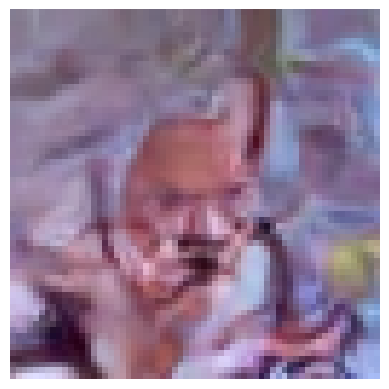

In [34]:
import numpy as np
img = samples[-1][2]
img = np.transpose(img, (1, 2, 0))
img = (img - img.min()) / (img.max() - img.min())
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.imsave("saved_image.png", img)
plt.show()

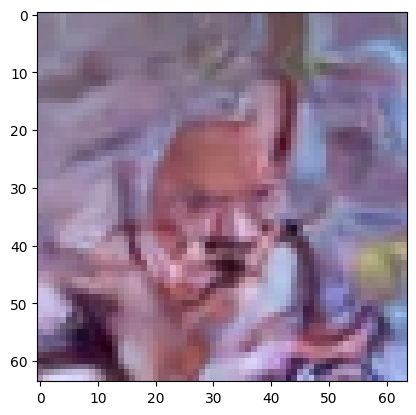

In [35]:
random_index = 16
plt.imshow(img.reshape(image_size, image_size, channels))

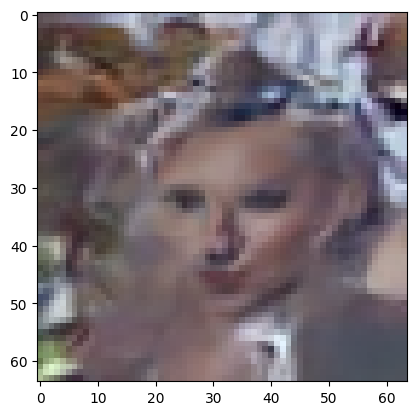

In [25]:
import matplotlib.animation as animation

random_index = 3

fig = plt.figure()
ims = []
#print(samples[2][0].shape)
for i in range(timesteps):
    img = samples[i][random_index]
    img = np.transpose(img, (1, 2, 0)) 
    #img = samples[i][random_index].reshape(image_size, image_size, channels)
    img = (img - img.min()) / (img.max() - img.min())
    im = plt.imshow(img, animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()